In [1]:
import pandas as pd
import numpy as np
import math
from functools import partial
from sklearn.impute import SimpleImputer
import os
import glob
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from scipy.signal import resample
from statsmodels.tsa.arima.model import ARIMA
from tsfresh import extract_features
from catboost import CatBoostRegressor, cv, Pool
import catboost as cb
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.feature_selection import SelectPercentile as SP
from tsfresh import extract_features
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
import scipy
from sklearn import model_selection, preprocessing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import seaborn as sb
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from tsfresh import extract_features
#from pypots.data import mcar, masked_fill
#from pypots.imputation import SAITS
#from pypots.utils.metrics import cal_mae

In [2]:
import math
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = max(approxes[index], 0)
            der1 = math.log1p(targets[index]) - math.log1p(max(0, approxes[index]))
            der2 = -1 / (max(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result
class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((math.log1p(max(0, approx[i])) - math.log1p(max(0, target[i])))**2)

        return error_sum, weight_sum

In [ ]:
def new_metrics(pred, y_test, daysFromStart):
    result = np.zeros(len(pred))
    y_test_ttf = pred + daysFromStart
    DEFAULT_RANGES = [(0, 30, 5),  # Диапазон от 0 до 30 +- 5 суток
                   (30, 180, 18),
                   (180, 365, 36),
                   (365, 730, 73),
                   (730, 10000, 73)
                   ]
    for ind, num in enumerate(pred):
        
        
        if y_test[ind] <= 30:
            if abs(y_test_ttf[ind] - y_test[ind]) <= 5:
                result[ind] = 1
            else:
                result[ind] = 0

                
        elif 30<y_test[ind]<=180:
            if abs(y_test_ttf[ind] - y_test[ind]) <= 18:
                result[ind] = 1
            else:
                result[ind] = 0

                
        elif 180<y_test[ind]<=365:
            if abs(y_test_ttf[ind] - y_test[ind]) <= 36:
                result[ind] = 1
            else:
                result[ind] = 0

                
        elif 365<y_test[ind]:
            if abs(y_test_ttf[ind] - y_test[ind]) <= 73:
                result[ind] = 1
            else:
                result[ind] = 0

                
    return np.sum(result) / len(result)

In [3]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
def get_rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log(y_pred+1)-np.log(y_true+1))**2))

In [4]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path+'/data/combined2', "*.fea"))
df = pd.DataFrame()
for ind, f in tqdm(enumerate(csv_files)):
    # read the csv file
    if ind == 0:
        df = pd.read_feather(f)
    else:
        df1 = pd.read_feather(f)
        df = pd.concat([df, df1], ignore_index=True)

5it [05:56, 71.40s/it]


KeyboardInterrupt: 

Удаляем фичи, где больше 20% пропусков

In [7]:
def kill_na(ds):
    ds = ds.fillna(value=np.nan)
    ds = ds.replace(to_replace='Неизвестно', value=np.nan)
    if ds.isna().sum() > 0.2 * len(ds):
        return 1
    else:
        return 0

In [8]:
start_time = time.perf_counter()
ds = [df[i] for i in df.columns]
with Pool(36) as p:
    res = p.map(kill_na, ds)
finish_time = time.perf_counter()
print(finish_time-start_time)

33.17848122608848


### Оставшиеся признаки

In [30]:
all_columns = df.columns
categorical_features = []
numerical_features = []
bool_features = []
for i in df.columns:
    if df[i].dtype == 'O':
        categorical_features.append(i)
    elif df[i].dtype == 'float64' or df[i].dtype == 'int64' or df[i].dtype == 'int' or df[i].dtype == 'float32':
        numerical_features.append(i)
    elif df[i].dtype == 'bool':
        bool_features.append(i)
print('Качественных признаков -', len(categorical_features))
print('Количественных признаков -', len(numerical_features))
print('Длина таблицы -', len(df))

Качественных признаков - 74
Количественных признаков - 131
Длина таблицы - 113840


### Заполнение пропусков с помощью SAITS и выбор фичей

In [255]:
num_features_ToImpute = numerical_features
num_features_ToImpute.append('SK_Well')
X = df[num_features_ToImpute]
num_samples = len(X['SK_Well'].unique())
X = X.drop(['SK_Well', 'daysToFailure',  'CurrentTTF'], axis = 1)
X = StandardScaler().fit_transform(X.to_numpy())
X = X[:113827,]
X = X.reshape(num_samples, 1127, -1)

In [256]:
saits = SAITS(n_steps=1127, n_features=len(num_features_ToImpute)-3, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=10)
saits.fit(X)

No given device, using default device: cpu
Model initialized successfully. Number of the trainable parameters: 1694189
epoch 0: training loss 1.3047
epoch 1: training loss 1.1668
epoch 2: training loss 1.0717
epoch 3: training loss 1.0283
epoch 4: training loss 0.9543
epoch 5: training loss 0.9276
epoch 6: training loss 0.8676
epoch 7: training loss 0.8340
epoch 8: training loss 0.7873
epoch 9: training loss 0.7852
Finished training.


In [258]:
imputation = saits.impute(X)
num_features_ToImpute.remove('daysToFailure')
num_features_ToImpute.remove('daysFromLastStart')
num_features_ToImpute.remove('SK_Well')
df = df.drop(np.arange(113827, len(df)), axis=0)
for ind, i in enumerate(num_features_ToImpute[:]):
    df[i] = imputation.reshape(113827, -1)[:,ind]

In [31]:
my_imputer_mod = SimpleImputer(strategy='most_frequent')
for i in tqdm(categorical_features):
    for k in df.SK_Well.unique():
        if df[i].dtype == 'object':
            if len(df.loc[df[df['SK_Well'] == k].index, i].unique()) == 1 and pd.isna(df.loc[df[df['SK_Well'] == k].index, i].unique()[0]):
                df.loc[df[df['SK_Well'] == k].index, i] = my_imputer_mod.fit(np.array(df[i]).reshape(-1, 1)).transform(np.array(df[df['SK_Well'] == k][i]).reshape(-1, 1))
            else:
                df.loc[df[df['SK_Well'] == k].index, i] = my_imputer_mod.fit_transform(np.array(df[df['SK_Well'] == k][i]).reshape(-1, 1))

100%|███████████████████████████████████████████| 74/74 [02:43<00:00,  2.21s/it]


In [ ]:
y = df.daysToFailure
#X = df.drop(['CurrentTTF', 'daysToFailure', 'FailureDate', 'SK_Calendar', 'SK_ConfirmDateStart', 'lastStartDate', 'sk_calendarprevmonth', 'SK_Mounts', 'SK_Well'], axis=1)
X = df[numerical_features]#.drop(['daysToFailure'], axis=1)
mi_scores = make_mi_scores(X, y)

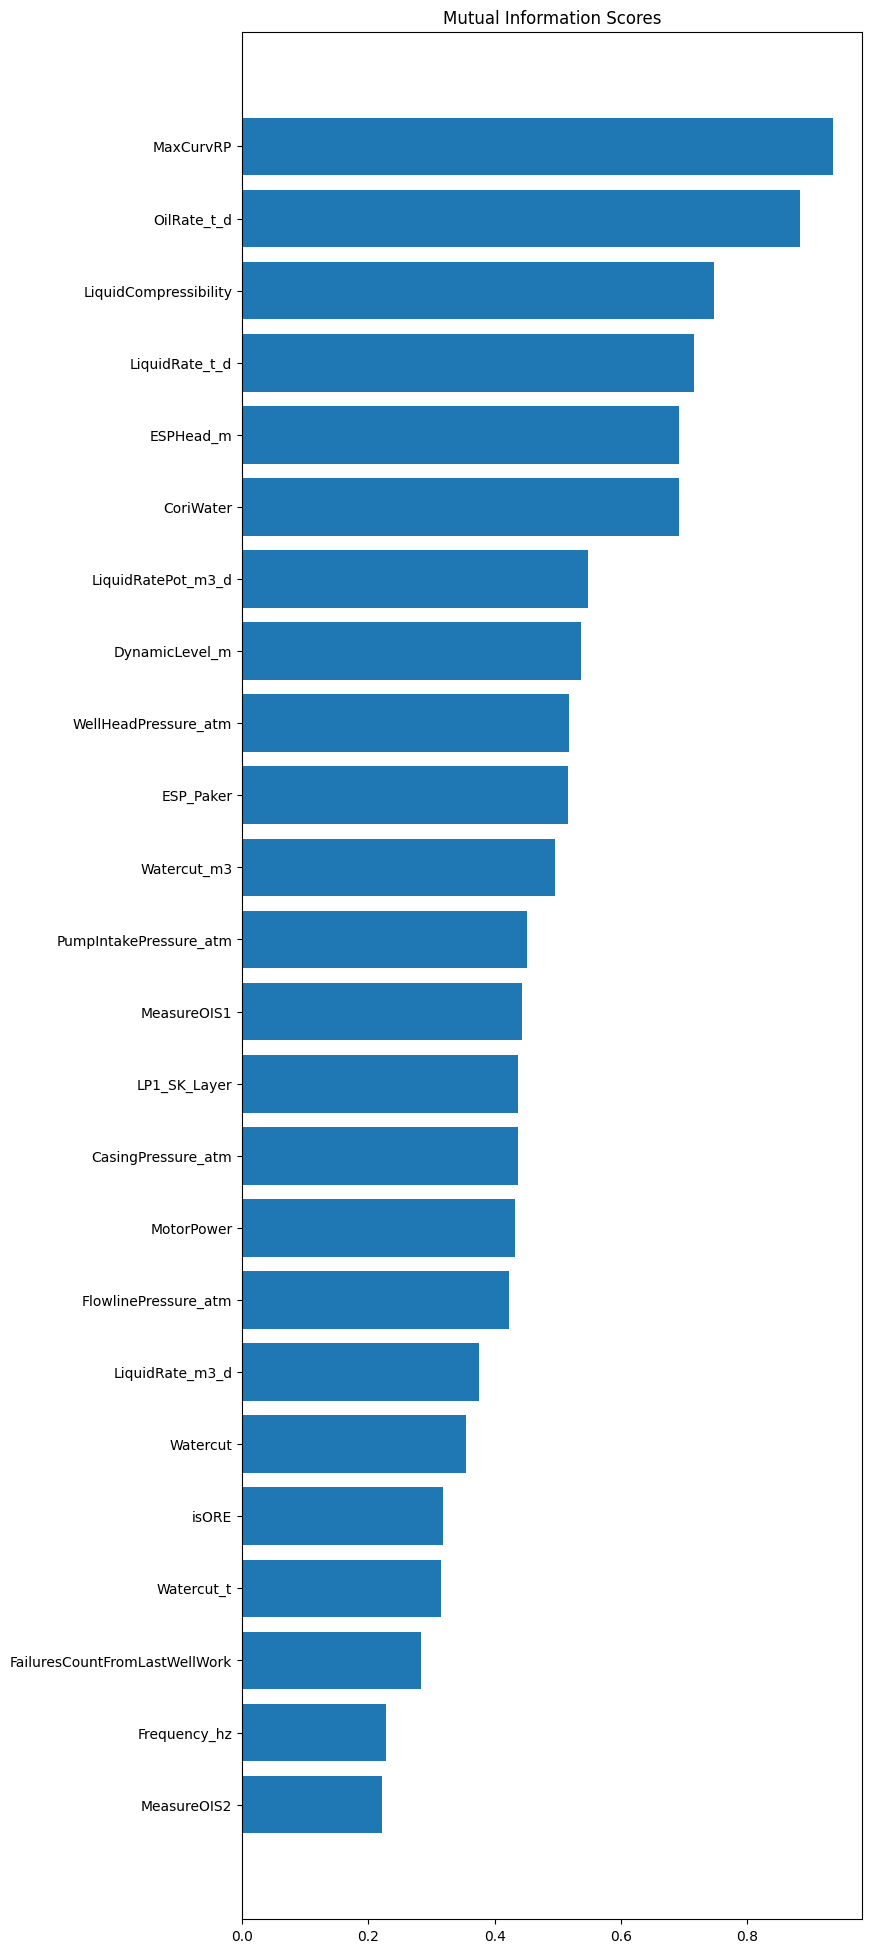

In [263]:
plt.figure(dpi=100, figsize=(8, 25))
plot_mi_scores(mi_scores[mi_scores > 0.2])

In [264]:
new_features = list(mi_scores[mi_scores > 0.2].index)
#new_features.append('SK_Calendar')

categorical_features = []
numerical_features = []
bool_features = []
for ind, i in enumerate(new_features):
    if df[i].dtype == 'O':
        categorical_features.append(i)
    elif df[i].dtype == 'float64' or df[i].dtype == 'int64' or df[i].dtype == 'int' or df[i].dtype == 'float32':
        numerical_features.append(i)
    elif df[i].dtype == 'bool':
        bool_features.append(i)
print('Качественных признаков -', len(categorical_features))
print('Количественных признаков -', len(numerical_features))
print('Длина таблицы -', len(df))

Качественных признаков - 0
Количественных признаков - 24
Длина таблицы - 113827


In [7]:
df_n = df.copy()

In [8]:
d = df_n.groupby('SK_Well').groups
indxs = []
for i in d:
    indxs.append(max(d[i]))
df_n['SK_Calendar'] = pd.to_datetime(df_n['SK_Calendar'], format='%Y-%m-%d')

In [16]:
features_og = np.load('features_og.npy')

In [ ]:
f1 = list(features_og)
f1.append('SK_Well')
f2 = []
for i in features_og:
    df_n[f'{i}_lag1'] = df_n[f1].groupby('SK_Well')[i].shift(1)
    df_n[f'{i}_lag2'] = df_n[f1].groupby('SK_Well')[i].shift(2)
    df_n[f'{i}_lag3'] = df_n[f1].groupby('SK_Well')[i].shift(3)
    f2.append(f'{i}_lag1')
    f2.append(f'{i}_lag2')
    f2.append(f'{i}_lag3')

In [68]:
res = np.array(res)
df = df[df.columns[np.where(res == 0)]]

In [69]:
all_columns = df.columns
categorical_features = []
numerical_features = []
bool_features = []
for i in df.columns:
    if df[i].dtype == 'O':
        categorical_features.append(i)
    elif df[i].dtype == 'float64' or df[i].dtype == 'int64' or df[i].dtype == 'int' or df[i].dtype == 'float32':
        numerical_features.append(i)
    elif df[i].dtype == 'bool':
        bool_features.append(i)

In [70]:
print('Качественных признаков -', len(categorical_features))
print('Количественных признаков -', len(numerical_features))
print('Длина таблицы -', len(df))

Качественных признаков - 49
Количественных признаков - 111
Длина таблицы - 11344342


In [71]:
categorical_features.remove('SK_Well')

In [72]:
for f in categorical_features:
    if 'mark' in f.lower() or 'ett' in f.lower() or 'sk' in f.lower():
        categorical_features.remove(f)
        df = df.drop([f], axis=1)
categorical_features.remove('lastStartDate')
categorical_features.remove('Cluster')
categorical_features.remove('SourcePumpType')
categorical_features.remove('FailureDate')
df = df.drop(['lastStartDate', 'Cluster', 'SourcePumpType', 'FailureDate'], axis=1)

In [380]:
feature_selection_df = df.copy()

In [423]:
np.save('df.npy', df.columns)

In [53]:
feature_selection_df[f].values.reshape(-1, 1)

array([['Ремонтный'],
       ['Ремонтный'],
       ['Ремонтный'],
       ...,
       ['Новый'],
       ['Новый'],
       ['Новый']], dtype=object)

/home/n_vasilenko/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 1000x1000 with 0 Axes>

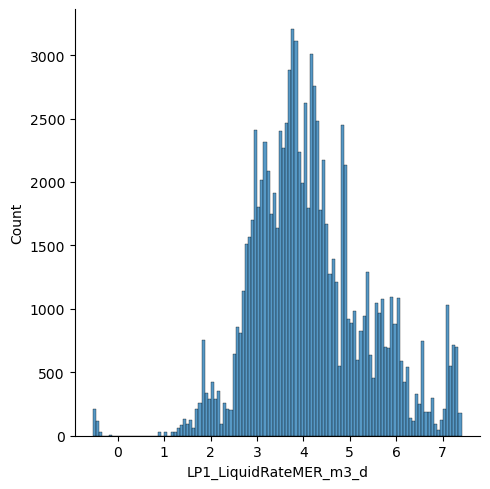

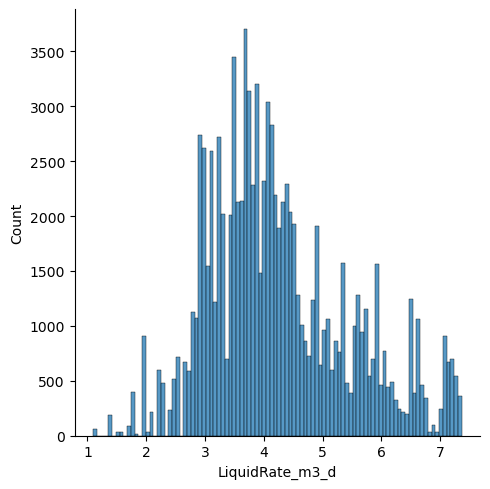

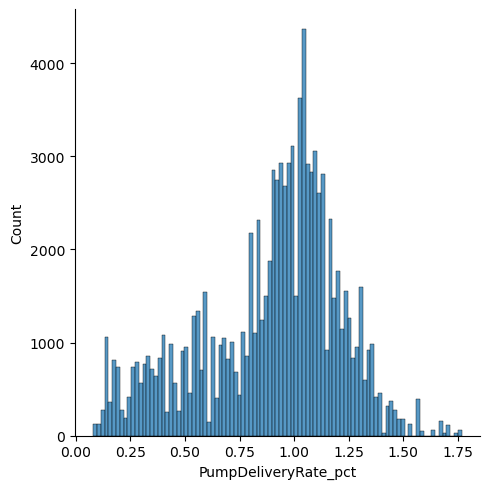

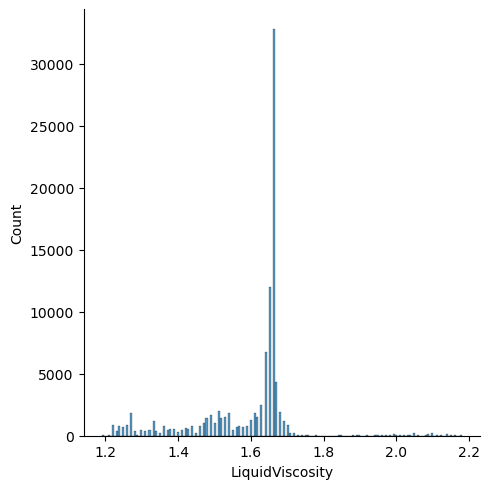

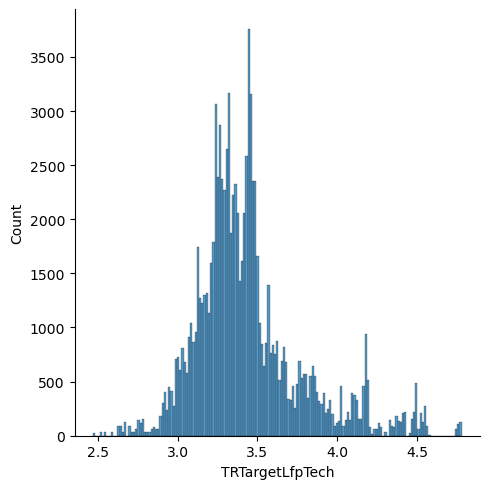

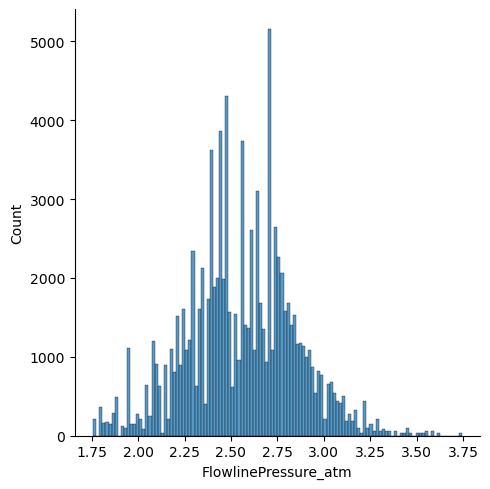

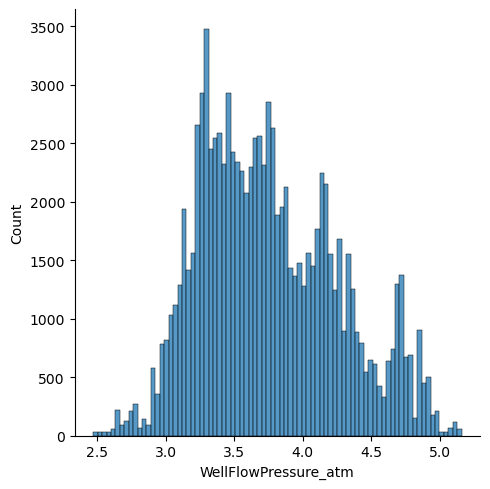

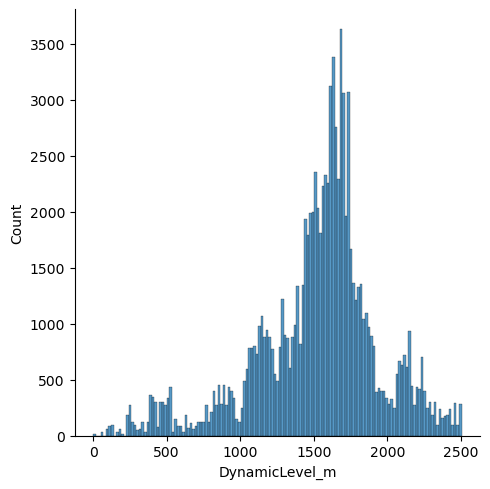

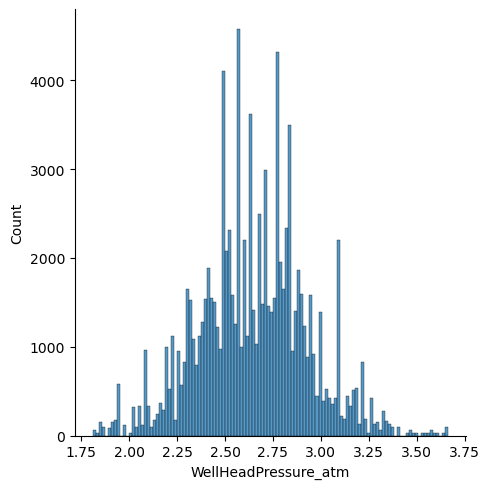

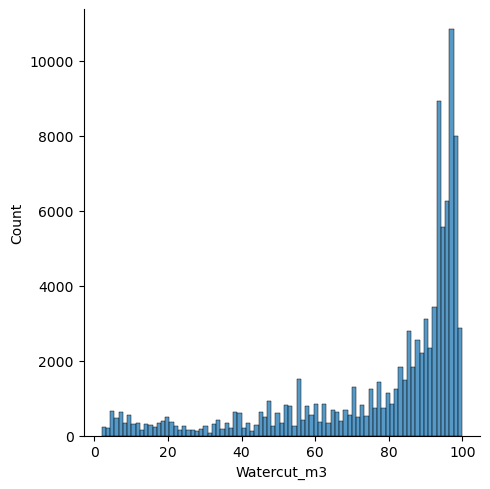

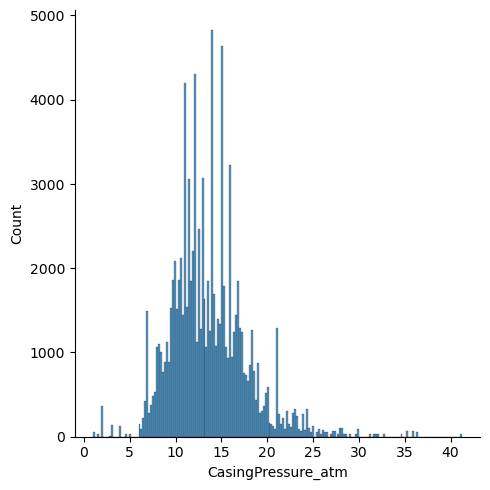

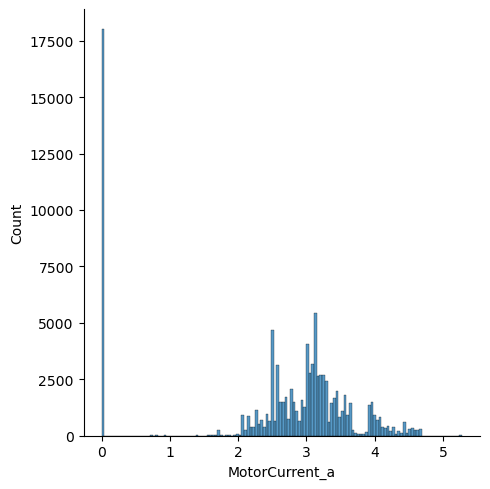

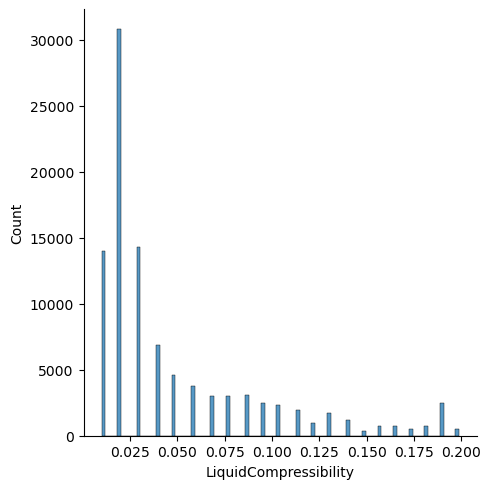

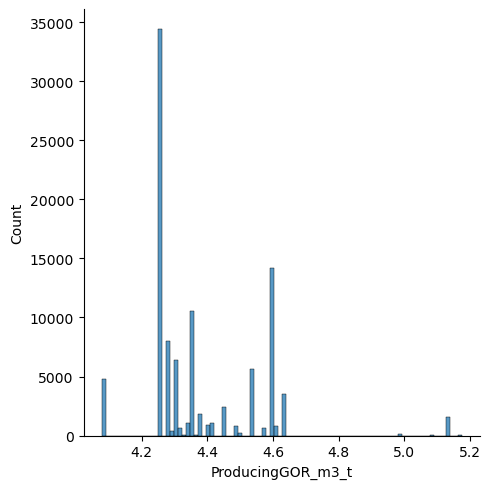

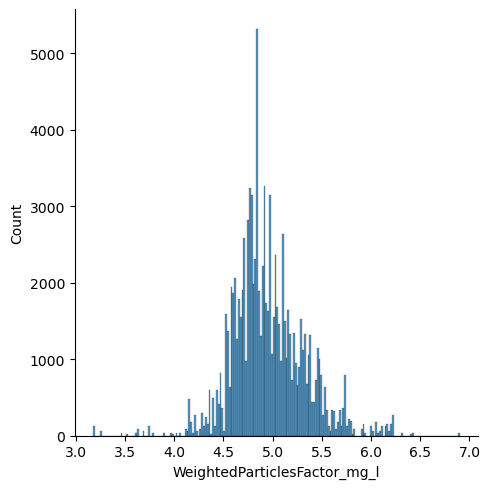

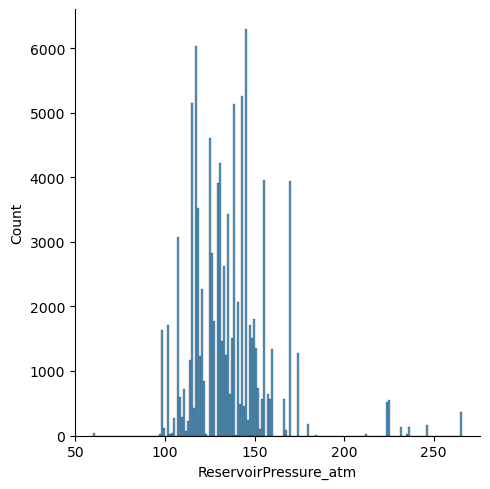

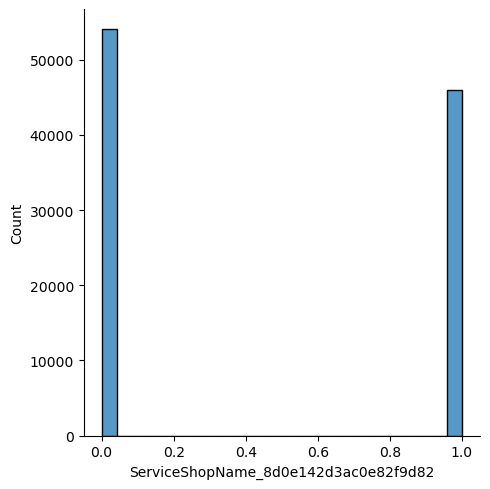

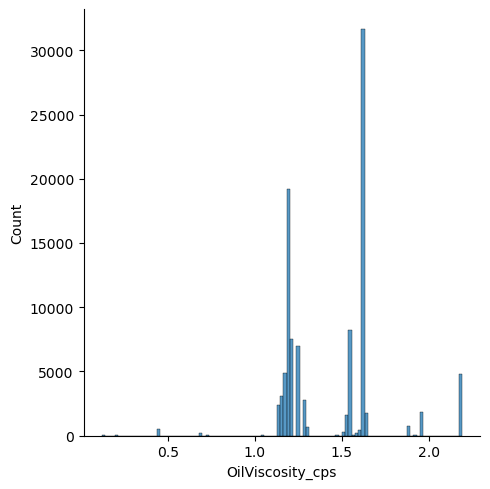

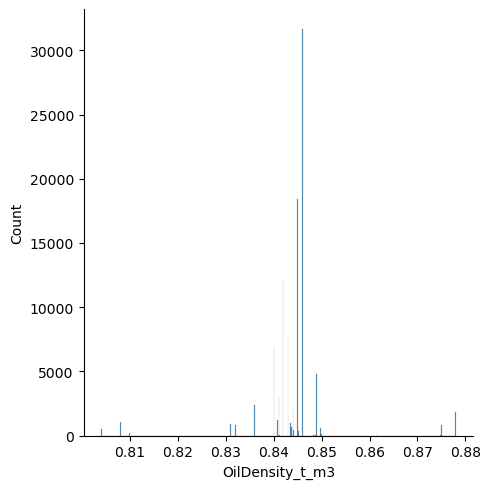

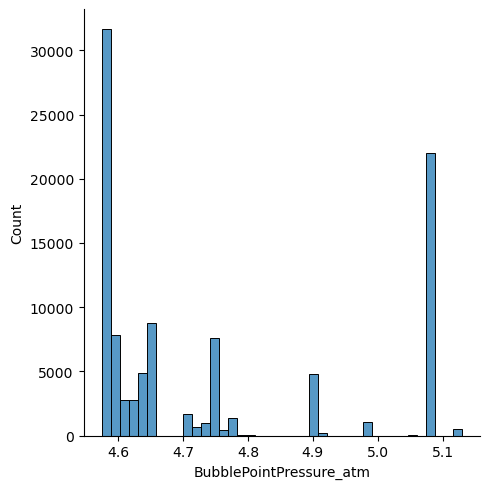

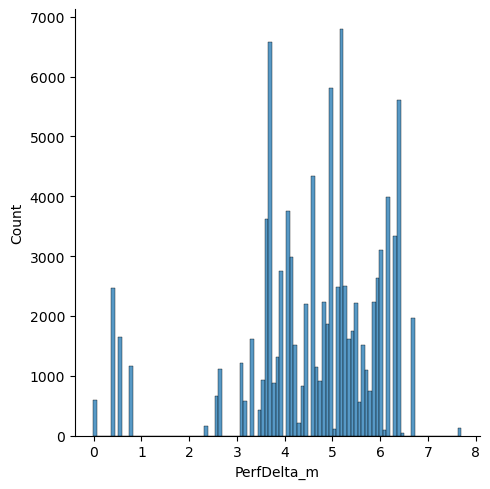

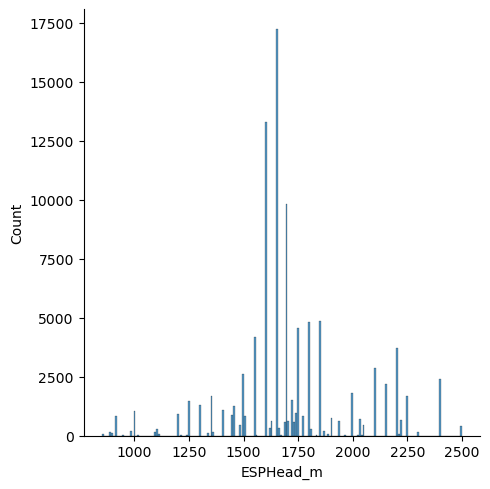

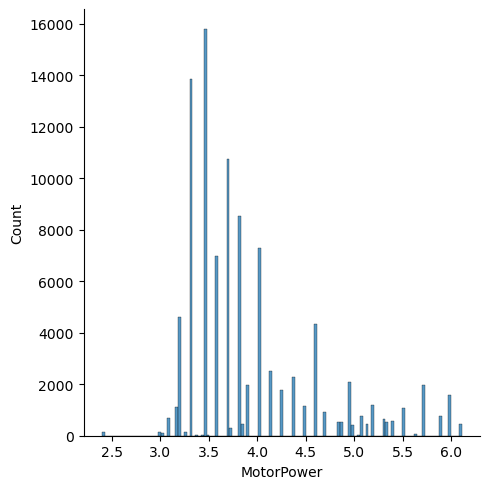

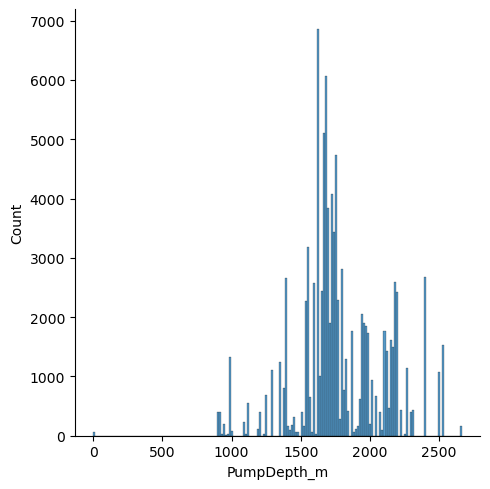

In [335]:
plt.figure(figsize=(10,10))
#for i in df_dist.columns:
sns.displot(np.log(df_dist['LP1_LiquidRateMER_m3_d']))
sns.displot(np.log(df_dist['LiquidRate_m3_d']))
sns.displot(df_dist['PumpDeliveryRate_pct'])
sns.displot(df_dist['LiquidViscosity'])
sns.displot(np.log(df_dist['TRTargetLfpTech']))
sns.displot(np.log(df_dist['FlowlinePressure_atm']))
sns.displot(np.log(df_dist['WellFlowPressure_atm']))
sns.displot(df_dist['DynamicLevel_m'])
sns.displot(np.log(df_dist['WellHeadPressure_atm']))
sns.displot(df_dist['Watercut_m3'])
sns.displot(df_dist['CasingPressure_atm'])
sns.displot(np.log(df_dist['MotorCurrent_a']+1))
sns.displot(np.log(df_dist['LiquidCompressibility']))
sns.displot(np.log(df_dist['ProducingGOR_m3_t']))
sns.displot(np.log(df_dist['WeightedParticlesFactor_mg_l']))
sns.displot(df_dist['ReservoirPressure_atm'])
sns.displot(df_dist['ServiceShopName_8d0e142d3ac0e82f9d82'])
sns.displot(df_dist['OilViscosity_cps'])
sns.displot(df_dist['OilDensity_t_m3'])
sns.displot(np.log(df_dist['BubblePointPressure_atm']))
sns.displot(np.log(df_dist['PerfDelta_m']))
sns.displot(df_dist['ESPHead_m'])
sns.displot(np.log(df_dist['MotorPower']))
sns.displot(df_dist['PumpDepth_m'])
plt.show()

In [31]:
df_lag = df.iloc[:1264242,:].copy()

In [ ]:
for ind, well in enumerate(df_lag['SK_Well'].unique()):
    df_lag.replace(well, ind)

In [32]:
df_lag['SK_Calendar'] = pd.to_datetime(df_lag['SK_Calendar'], format='%Y-%m-%d')

In [205]:
[1,3,4].append(5)

In [33]:
f1 = list(features)
f1.append('SK_Well')
#f1.append('SK_Calendar')

In [15]:
df_lag[f1] = df_lag[f1].fillna(method='ffill')
df_lag[f1] = df_lag[f1].fillna(method='bfill')
df_lag[f1] = df_lag[f1].fillna(value=-1)

In [249]:
df_lag[f1]

LP1_LiquidRateMER_m3_d  LiquidRate_m3_d  LiquidRate_t_d  \
0                   36.513774             43.0       38.906399   
1                   36.513774             43.0       38.906399   
2                   36.513774             43.0       38.906399   
3                   36.513774             43.0       38.906399   
4                   36.513774             43.0       38.906399   
...                       ...              ...             ...   
11382               17.704810             18.0       16.487640   
11383               17.704810             18.0       16.487640   
11384               17.704810             18.0       16.487640   
11385               17.704810             18.0       16.487640   
11386               17.704810             18.0       16.487640   

       PumpDeliveryRate_pct  LiquidRatePot_m3_d  LiquidViscosity  \
0                  0.955556           47.350853             1.64   
1                  0.955556           47.350853             1.64   
2                  0.955556           47.350853             1.64   
3                  0.955556           47.350853             1.64   
4                  0.955556           47.350853             1.64   
...                     ...                 ...              ...   
11382              0.225000           18.691523             1.32   
11383              0.225000           18.691523             1.32   
11384              0.225000           18.691523             1.32   
11385              0.225000           18.691523             1.32   
11386              0.225000           18.691523             1.32   

       TRTargetLfpTech  OilRate_t_d  OilRatePot_t_d  FlowlinePressure_atm  \
0            27.700001      23.6457       24.035294                  17.1   
1            27.700001      23.6457       24.035294                  17.1   
2            27.700001      23.6457       24.035294                  17.1   
3            27.700001      23.6457       24.035294                  17.1   
4            27.700001      23.6457       24.035294                  17.1   
...                ...          ...             ...                   ...   
11382        27.719999       8.8218        9.160715                   9.9   
11383        27.719999       8.8218        9.160715                   9.9   
11384        27.719999       8.8218        9.160715                   9.9   
11385        27.719999       8.8218        9.160715                   9.9   
11386        27.719999       8.8218        9.160715                   9.9   

       ...  ReservoirPressure_atm  OilViscosity_cps  OilDensity_t_m3  \
0      ...                  118.0             1.630            0.846   
1      ...                  118.0             1.630            0.846   
2      ...                  118.0             1.630            0.846   
3      ...                  118.0             1.630            0.846   
4      ...                  118.0             1.630            0.846   
...    ...                    ...               ...              ...   
11382  ...                  132.0             1.196            0.845   
11383  ...                  132.0             1.196            0.845   
11384  ...                  132.0             1.196            0.845   
11385  ...                  132.0             1.196            0.845   
11386  ...                  132.0             1.196            0.845   

       BubblePointPressure_atm  PerfDelta_m  ESPHead_m  MotorPower  \
0                         97.0    37.500000     1600.0        28.0   
1                         97.0    37.500000     1600.0        28.0   
2                         97.0    37.500000     1600.0        28.0   
3                         97.0    37.500000     1600.0        28.0   
4                         97.0    37.500000     1600.0        28.0   
...                        ...          ...        ...         ...   
11382                    160.0   101.610001     1850.0        36.0   
11383                    160.0   101.610001    

In [250]:

X = extract_features(df_lag[f1],
                     column_id="SK_Well",
                     column_sort="SK_Calendar",
                     n_jobs=60)

Feature Extraction: 100%|█████████████████████| 280/280 [02:31<00:00,  1.85it/s]


In [34]:
f2 = []
for i in features:
    df_lag[f'{i}_lag1'] = df_lag[f1].groupby('SK_Well')[i].shift(1)
    df_lag[f'{i}_lag2'] = df_lag[f1].groupby('SK_Well')[i].shift(2)
    df_lag[f'{i}_lag3'] = df_lag[f1].groupby('SK_Well')[i].shift(3)
    f2.append(f'{i}_lag1')
    f2.append(f'{i}_lag2')
    f2.append(f'{i}_lag3')

In [35]:
#f2.append('SK_Well')
f2.append('SK_Calendar')
f2 = np.concatenate((f2,features))

In [60]:
d = df_lag.groupby('SK_Well').groups

In [64]:
max(d['0001d449'])

2341

In [65]:
indxs = []
for i in d:
    indxs.append(max(d[i]))

In [ ]:
features = list(features)
features.append('SK_Calendar')

In [36]:
X_train = df_lag[f2].iloc[:1147591,:].copy().drop(['SK_Calendar'], axis=1)
y_train = df_lag.iloc[:1147591,:].daysToFailure.copy()
X_test = df_lag[f2].iloc[1147591:,:].copy().drop(['SK_Calendar'], axis=1)
y_test = df_lag.iloc[1147591:,:].daysToFailure.copy()
current_ttf = df.iloc[1147591:,:].CurrentTTF.copy()
current_ttf_train = df.iloc[:1147591,:].CurrentTTF.copy()

In [37]:
X_train['SK_Calendar'] = df_lag.iloc[:1147591,:]['SK_Calendar']
X_test['SK_Calendar'] = df_lag.iloc[1147591:,:]['SK_Calendar']

### Train

In [179]:
# train - :1264242
# test - 1023147:
X_train = df[features].iloc[:1264242,:].copy()
y_train = df.iloc[:1264242,:].daysToFailure.copy()
X_test = df[features].iloc[1023147:,:].copy()
y_test = df[['daysToFailure', 'daysFromLastStart']].iloc[1023147:,:].copy()
current_ttf = df.iloc[1023147:,:].CurrentTTF.copy()
current_ttf_train = df.iloc[:1264242,:].CurrentTTF.copy()

In [373]:
scale= StandardScaler()
for i in tqdm(f_toscale):
    X_train[i] = (X_train[i] - X_train.mean()[i])/X_train.std()[i]
    X_test[i] = (X_test[i] - X_test.mean()[i])/X_test.std()[i]

100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.24s/it]


In [180]:
for col in X_train.columns:
    X_train[col] = X_train[col].interpolate()
    X_test[col] = X_test[col].interpolate()

In [256]:
for col in X_train.columns:
    if col == 'ServiceShopName_8d0e142d3ac0e82f9d82':
        continue
    X_train[col] = X_train[col] / X_train[col].abs().max()

In [38]:
model = CatBoostRegressor(depth=6, l2_leaf_reg=9, learning_rate=0.1, random_state=47, loss_function='RMSE', devices='0:1', iterations=1000, thread_count=-1, task_type='GPU')
model.fit(X_train, y_train)

0:	learn: 342.8922303	total: 275ms	remaining: 4m 35s
1:	learn: 339.1721081	total: 539ms	remaining: 4m 28s
2:	learn: 336.4290468	total: 676ms	remaining: 3m 44s
3:	learn: 333.6911610	total: 946ms	remaining: 3m 55s
4:	learn: 331.2420249	total: 1.21s	remaining: 4m
5:	learn: 329.0543425	total: 1.34s	remaining: 3m 41s
6:	learn: 327.1649764	total: 1.41s	remaining: 3m 20s
7:	learn: 325.3198925	total: 1.64s	remaining: 3m 23s
8:	learn: 323.9217644	total: 1.77s	remaining: 3m 15s
9:	learn: 322.4634546	total: 1.95s	remaining: 3m 13s
10:	learn: 321.1515266	total: 2.17s	remaining: 3m 15s
11:	learn: 319.9453027	total: 2.23s	remaining: 3m 3s
12:	learn: 318.8534490	total: 2.31s	remaining: 2m 55s
13:	learn: 317.8778627	total: 2.36s	remaining: 2m 46s
14:	learn: 317.0102724	total: 2.61s	remaining: 2m 51s
15:	learn: 316.2251113	total: 2.86s	remaining: 2m 55s
16:	learn: 315.3059209	total: 3.02s	remaining: 2m 54s
17:	learn: 314.4147742	total: 3.24s	remaining: 2m 56s
18:	learn: 313.3974139	total: 3.52s	remaini

153:	learn: 254.2361123	total: 17.1s	remaining: 1m 34s
154:	learn: 253.8796514	total: 17.2s	remaining: 1m 33s
155:	learn: 253.5261384	total: 17.3s	remaining: 1m 33s
156:	learn: 253.1346144	total: 17.4s	remaining: 1m 33s
157:	learn: 252.8594429	total: 17.4s	remaining: 1m 32s
158:	learn: 252.5701797	total: 17.5s	remaining: 1m 32s
159:	learn: 252.3199974	total: 17.6s	remaining: 1m 32s
160:	learn: 252.1273033	total: 17.7s	remaining: 1m 32s
161:	learn: 251.7826424	total: 17.8s	remaining: 1m 31s
162:	learn: 251.4816666	total: 17.8s	remaining: 1m 31s
163:	learn: 251.2985135	total: 17.9s	remaining: 1m 31s
164:	learn: 251.0098118	total: 18s	remaining: 1m 31s
165:	learn: 250.7780989	total: 18.1s	remaining: 1m 30s
166:	learn: 250.4875150	total: 18.1s	remaining: 1m 30s
167:	learn: 250.2680115	total: 18.2s	remaining: 1m 30s
168:	learn: 249.9526177	total: 18.3s	remaining: 1m 30s
169:	learn: 249.7207528	total: 18.4s	remaining: 1m 29s
170:	learn: 249.4189775	total: 18.5s	remaining: 1m 29s
171:	learn: 

303:	learn: 219.7366982	total: 29.4s	remaining: 1m 7s
304:	learn: 219.5446203	total: 29.5s	remaining: 1m 7s
305:	learn: 219.3737865	total: 29.6s	remaining: 1m 7s
306:	learn: 219.1628256	total: 29.7s	remaining: 1m 7s
307:	learn: 219.0452196	total: 29.8s	remaining: 1m 6s
308:	learn: 218.8791246	total: 29.9s	remaining: 1m 6s
309:	learn: 218.7441769	total: 30s	remaining: 1m 6s
310:	learn: 218.5689780	total: 30s	remaining: 1m 6s
311:	learn: 218.3593318	total: 30.1s	remaining: 1m 6s
312:	learn: 218.1557259	total: 30.2s	remaining: 1m 6s
313:	learn: 217.9802341	total: 30.3s	remaining: 1m 6s
314:	learn: 217.7393454	total: 30.4s	remaining: 1m 6s
315:	learn: 217.4562985	total: 30.5s	remaining: 1m 5s
316:	learn: 217.1921025	total: 30.5s	remaining: 1m 5s
317:	learn: 217.0641879	total: 30.6s	remaining: 1m 5s
318:	learn: 216.8406352	total: 30.7s	remaining: 1m 5s
319:	learn: 216.6856493	total: 30.8s	remaining: 1m 5s
320:	learn: 216.3300182	total: 30.9s	remaining: 1m 5s
321:	learn: 216.0750005	total: 3

459:	learn: 196.6623144	total: 37s	remaining: 43.4s
460:	learn: 196.5475614	total: 37s	remaining: 43.3s
461:	learn: 196.4103544	total: 37s	remaining: 43.1s
462:	learn: 196.2682870	total: 37s	remaining: 43s
463:	learn: 196.1263350	total: 37s	remaining: 42.8s
464:	learn: 195.9524162	total: 37s	remaining: 42.6s
465:	learn: 195.7949414	total: 37.1s	remaining: 42.5s
466:	learn: 195.7172325	total: 37.1s	remaining: 42.3s
467:	learn: 195.5275255	total: 37.1s	remaining: 42.1s
468:	learn: 195.3771071	total: 37.1s	remaining: 42s
469:	learn: 195.2679781	total: 37.1s	remaining: 41.8s
470:	learn: 195.1507408	total: 37.1s	remaining: 41.6s
471:	learn: 194.9837774	total: 37.1s	remaining: 41.5s
472:	learn: 194.8823494	total: 37.1s	remaining: 41.3s
473:	learn: 194.8124754	total: 37.1s	remaining: 41.2s
474:	learn: 194.7042856	total: 37.1s	remaining: 41s
475:	learn: 194.5947701	total: 37.1s	remaining: 40.9s
476:	learn: 194.5223708	total: 37.1s	remaining: 40.7s
477:	learn: 194.4190498	total: 37.1s	remaining

619:	learn: 179.3309949	total: 38s	remaining: 23.3s
620:	learn: 179.2498024	total: 38s	remaining: 23.2s
621:	learn: 179.1257378	total: 38s	remaining: 23.1s
622:	learn: 179.0259517	total: 38s	remaining: 23s
623:	learn: 178.9319346	total: 38.1s	remaining: 22.9s
624:	learn: 178.8602495	total: 38.1s	remaining: 22.8s
625:	learn: 178.7875574	total: 38.1s	remaining: 22.7s
626:	learn: 178.6662183	total: 38.1s	remaining: 22.6s
627:	learn: 178.5779581	total: 38.1s	remaining: 22.6s
628:	learn: 178.4957331	total: 38.1s	remaining: 22.5s
629:	learn: 178.4409754	total: 38.1s	remaining: 22.4s
630:	learn: 178.3591476	total: 38.1s	remaining: 22.3s
631:	learn: 178.2352640	total: 38.1s	remaining: 22.2s
632:	learn: 178.1744869	total: 38.1s	remaining: 22.1s
633:	learn: 178.0166037	total: 38.1s	remaining: 22s
634:	learn: 177.9736517	total: 38.1s	remaining: 21.9s
635:	learn: 177.8737109	total: 38.1s	remaining: 21.8s
636:	learn: 177.7954161	total: 38.1s	remaining: 21.7s
637:	learn: 177.6983277	total: 38.1s	rem

774:	learn: 166.2172169	total: 39s	remaining: 11.3s
775:	learn: 166.1562970	total: 39s	remaining: 11.3s
776:	learn: 166.0943072	total: 39.1s	remaining: 11.2s
777:	learn: 166.0197233	total: 39.1s	remaining: 11.1s
778:	learn: 165.9489988	total: 39.1s	remaining: 11.1s
779:	learn: 165.8558972	total: 39.1s	remaining: 11s
780:	learn: 165.8210850	total: 39.1s	remaining: 11s
781:	learn: 165.7517401	total: 39.1s	remaining: 10.9s
782:	learn: 165.6172465	total: 39.1s	remaining: 10.8s
783:	learn: 165.5848360	total: 39.1s	remaining: 10.8s
784:	learn: 165.5236618	total: 39.1s	remaining: 10.7s
785:	learn: 165.4382280	total: 39.1s	remaining: 10.6s
786:	learn: 165.3816451	total: 39.1s	remaining: 10.6s
787:	learn: 165.3321994	total: 39.1s	remaining: 10.5s
788:	learn: 165.1998003	total: 39.1s	remaining: 10.5s
789:	learn: 165.1071193	total: 39.1s	remaining: 10.4s
790:	learn: 165.0402318	total: 39.1s	remaining: 10.3s
791:	learn: 164.9769951	total: 39.2s	remaining: 10.3s
792:	learn: 164.8942868	total: 39.2s

927:	learn: 155.8739358	total: 40s	remaining: 3.11s
928:	learn: 155.8050202	total: 40.1s	remaining: 3.06s
929:	learn: 155.7035381	total: 40.1s	remaining: 3.02s
930:	learn: 155.5661793	total: 40.1s	remaining: 2.97s
931:	learn: 155.5138022	total: 40.1s	remaining: 2.92s
932:	learn: 155.4034026	total: 40.1s	remaining: 2.88s
933:	learn: 155.3664551	total: 40.1s	remaining: 2.83s
934:	learn: 155.3297745	total: 40.1s	remaining: 2.79s
935:	learn: 155.2481801	total: 40.1s	remaining: 2.74s
936:	learn: 155.1690155	total: 40.1s	remaining: 2.7s
937:	learn: 155.1139732	total: 40.1s	remaining: 2.65s
938:	learn: 155.0542385	total: 40.1s	remaining: 2.61s
939:	learn: 155.0067830	total: 40.1s	remaining: 2.56s
940:	learn: 154.9225937	total: 40.1s	remaining: 2.52s
941:	learn: 154.8526439	total: 40.1s	remaining: 2.47s
942:	learn: 154.7931658	total: 40.2s	remaining: 2.43s
943:	learn: 154.6769619	total: 40.2s	remaining: 2.38s
944:	learn: 154.5739252	total: 40.2s	remaining: 2.34s
945:	learn: 154.5345217	total: 

In [138]:
features = np.load('configs/features.npy', allow_pickle=True)

In [30]:
np.save('features.npy', X_train.columns)

In [67]:
res = model.predict(X_test)

In [69]:
res[res < 5] = 5

In [42]:
get_rmsle(y_test, res)

1.2271253823482873

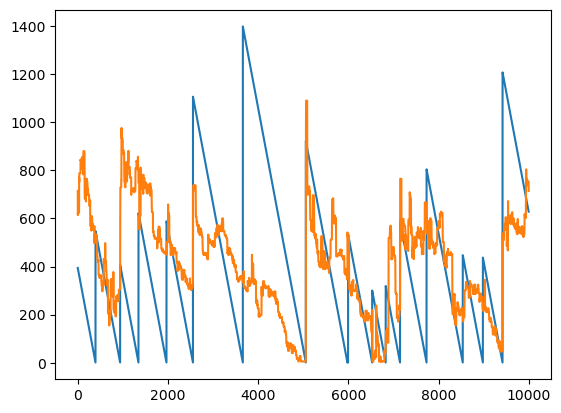

In [43]:
plt.plot(np.array(y_test)[:10000])
plt.plot(res[:10000])
#plt.plot(np.array(current_ttf)[:10000])

In [29]:
model.save_model('model_NIKITA.cbm')

In [ ]:
cv_dataset = Pool(data=X_train,
                  label=y_train)
params = {"iterations": 200,
          "depth": 4,
          "loss_function": RMSLE(),
          "eval_metric" : RMSLE_val(),
          "verbose": True}
scores = cv(cv_dataset,
            params,
            fold_count=2,
            plot="True")

In [ ]:
model_search = CatBoostRegressor(thread_count=-1, iterations=300, task_type='GPU')
grid = {'learning_rate': [0.03, 0.1, 0.01, 0.05],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
       }
randomized_search_result = model_search.randomized_search(grid,
                                                   X=X_train,
                                                   y=y_train,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 498.6855851	test: 497.5332523	best: 497.5332523 (0)	total: 417ms	remaining: 2m 4s
1:	learn: 471.3223740	test: 470.2033041	best: 470.2033041 (1)	total: 885ms	remaining: 2m 11s
2:	learn: 447.7119599	test: 446.6179888	best: 446.6179888 (2)	total: 1.37s	remaining: 2m 15s
3:	learn: 427.5289329	test: 426.4585820	best: 426.4585820 (3)	total: 1.85s	remaining: 2m 17s
4:	learn: 410.3764084	test: 409.3246527	best: 409.3246527 (4)	total: 2.33s	remaining: 2m 17s
5:	learn: 395.8604854	test: 394.8163430	best: 394.8163430 (5)	total: 2.82s	remaining: 2m 18s
6:	learn: 383.5602067	test: 382.5437293	best: 382.5437293 (6)	total: 3.13s	remaining: 2m 10s
7:	learn: 372.9755429	test: 371.9975707	best: 371.9975707 (7)	total: 3.62s	remaining: 2m 11s
8:	learn: 364.1341429	test: 363.2045243	best: 363.2045243 (8)	total: 4.11s	remaining: 2m 13s
9:	learn: 356.8220471	test: 355.9283174	best: 355.9283174 (9)	total: 4.6s	remaining: 2m 13s
10:	learn: 350.7469715	test: 349.9065194	best: 349.9065194 (10)	total: 5

87:	learn: 299.0253997	test: 298.9191843	best: 298.9191843 (87)	total: 41.5s	remaining: 1m 39s
88:	learn: 298.7862225	test: 298.6857785	best: 298.6857785 (88)	total: 42s	remaining: 1m 39s
89:	learn: 298.5930275	test: 298.4836408	best: 298.4836408 (89)	total: 42.5s	remaining: 1m 39s
90:	learn: 298.2328768	test: 298.1205160	best: 298.1205160 (90)	total: 43s	remaining: 1m 38s
91:	learn: 297.9802922	test: 297.8932091	best: 297.8932091 (91)	total: 43.4s	remaining: 1m 38s
92:	learn: 297.7422833	test: 297.6649043	best: 297.6649043 (92)	total: 43.9s	remaining: 1m 37s
93:	learn: 297.4167466	test: 297.3371836	best: 297.3371836 (93)	total: 44.4s	remaining: 1m 37s
94:	learn: 297.1992738	test: 297.1132567	best: 297.1132567 (94)	total: 44.9s	remaining: 1m 36s
95:	learn: 296.9877560	test: 296.9016936	best: 296.9016936 (95)	total: 45.5s	remaining: 1m 36s
96:	learn: 296.7449068	test: 296.6640236	best: 296.6640236 (96)	total: 45.9s	remaining: 1m 36s
97:	learn: 296.5384211	test: 296.4554357	best: 296.455

172:	learn: 281.9611430	test: 282.0506746	best: 282.0506746 (172)	total: 1m 14s	remaining: 54.4s
173:	learn: 281.8340383	test: 281.9327894	best: 281.9327894 (173)	total: 1m 14s	remaining: 53.8s
174:	learn: 281.7053084	test: 281.8089022	best: 281.8089022 (174)	total: 1m 14s	remaining: 53.2s
175:	learn: 281.5494554	test: 281.6522518	best: 281.6522518 (175)	total: 1m 14s	remaining: 52.7s
176:	learn: 281.4182807	test: 281.5228371	best: 281.5228371 (176)	total: 1m 14s	remaining: 52.1s
177:	learn: 281.2301294	test: 281.3321082	best: 281.3321082 (177)	total: 1m 15s	remaining: 51.5s
178:	learn: 281.0669969	test: 281.1672108	best: 281.1672108 (178)	total: 1m 15s	remaining: 50.9s
179:	learn: 280.9211448	test: 281.0214908	best: 281.0214908 (179)	total: 1m 15s	remaining: 50.3s
180:	learn: 280.8201186	test: 280.9237410	best: 280.9237410 (180)	total: 1m 15s	remaining: 49.7s
181:	learn: 280.6399286	test: 280.7428077	best: 280.7428077 (181)	total: 1m 15s	remaining: 49.2s
182:	learn: 280.4617703	test: 

257:	learn: 269.3470913	test: 269.5715509	best: 269.5715509 (257)	total: 1m 29s	remaining: 14.6s
258:	learn: 269.2375961	test: 269.4625199	best: 269.4625199 (258)	total: 1m 29s	remaining: 14.2s
259:	learn: 269.1452967	test: 269.3751590	best: 269.3751590 (259)	total: 1m 29s	remaining: 13.8s
260:	learn: 269.0420790	test: 269.2747969	best: 269.2747969 (260)	total: 1m 30s	remaining: 13.5s
261:	learn: 268.8252270	test: 269.0566162	best: 269.0566162 (261)	total: 1m 30s	remaining: 13.1s
262:	learn: 268.6369582	test: 268.8665107	best: 268.8665107 (262)	total: 1m 30s	remaining: 12.7s
263:	learn: 268.5509316	test: 268.7815538	best: 268.7815538 (263)	total: 1m 30s	remaining: 12.4s
264:	learn: 268.4186902	test: 268.6499663	best: 268.6499663 (264)	total: 1m 30s	remaining: 12s
265:	learn: 268.3461358	test: 268.5877903	best: 268.5877903 (265)	total: 1m 31s	remaining: 11.6s
266:	learn: 268.2304604	test: 268.4761330	best: 268.4761330 (266)	total: 1m 31s	remaining: 11.3s
267:	learn: 268.1580215	test: 26

43:	learn: 314.5326967	test: 314.1644729	best: 314.1644729 (43)	total: 9.98s	remaining: 58.1s
44:	learn: 313.8534993	test: 313.4829294	best: 313.4829294 (44)	total: 10.2s	remaining: 57.8s
45:	learn: 313.2910073	test: 312.9290126	best: 312.9290126 (45)	total: 10.4s	remaining: 57.6s
46:	learn: 312.7666484	test: 312.4238986	best: 312.4238986 (46)	total: 10.7s	remaining: 57.4s
47:	learn: 312.1490617	test: 311.8162525	best: 311.8162525 (47)	total: 10.9s	remaining: 57.2s
48:	learn: 311.6222372	test: 311.3005620	best: 311.3005620 (48)	total: 11.1s	remaining: 56.9s
49:	learn: 311.2182047	test: 310.9128024	best: 310.9128024 (49)	total: 11.3s	remaining: 56.7s
50:	learn: 310.5364703	test: 310.2231085	best: 310.2231085 (50)	total: 11.5s	remaining: 56.4s
51:	learn: 310.1635194	test: 309.8508620	best: 309.8508620 (51)	total: 11.8s	remaining: 56.1s
52:	learn: 309.7320318	test: 309.4144126	best: 309.4144126 (52)	total: 12s	remaining: 55.8s
53:	learn: 309.2615272	test: 308.9595856	best: 308.9595856 (53

130:	learn: 286.9184042	test: 286.9250408	best: 286.9250408 (130)	total: 28.4s	remaining: 36.7s
131:	learn: 286.5074085	test: 286.5044797	best: 286.5044797 (131)	total: 28.6s	remaining: 36.5s
132:	learn: 286.1997565	test: 286.1978236	best: 286.1978236 (132)	total: 28.9s	remaining: 36.2s
133:	learn: 285.9251988	test: 285.9264952	best: 285.9264952 (133)	total: 29.1s	remaining: 36s
134:	learn: 285.6115305	test: 285.6152665	best: 285.6152665 (134)	total: 29.2s	remaining: 35.7s
135:	learn: 285.1002522	test: 285.1044196	best: 285.1044196 (135)	total: 29.4s	remaining: 35.5s
136:	learn: 284.8984030	test: 284.9023237	best: 284.9023237 (136)	total: 29.6s	remaining: 35.2s
137:	learn: 284.5148337	test: 284.5167542	best: 284.5167542 (137)	total: 29.8s	remaining: 35s
138:	learn: 284.2028898	test: 284.2250637	best: 284.2250637 (138)	total: 30s	remaining: 34.7s
139:	learn: 283.9985648	test: 284.0230961	best: 284.0230961 (139)	total: 30.2s	remaining: 34.5s
140:	learn: 283.5986921	test: 283.6307001	best

218:	learn: 267.6378061	test: 267.7949745	best: 267.7949745 (218)	total: 35.2s	remaining: 13s
219:	learn: 267.5064058	test: 267.6609684	best: 267.6609684 (219)	total: 35.2s	remaining: 12.8s
220:	learn: 267.3878143	test: 267.5385603	best: 267.5385603 (220)	total: 35.2s	remaining: 12.6s
221:	learn: 267.2701299	test: 267.4225444	best: 267.4225444 (221)	total: 35.2s	remaining: 12.4s
222:	learn: 267.0190754	test: 267.1652718	best: 267.1652718 (222)	total: 35.3s	remaining: 12.2s
223:	learn: 266.8611572	test: 267.0046252	best: 267.0046252 (223)	total: 35.3s	remaining: 12s
224:	learn: 266.6983026	test: 266.8416332	best: 266.8416332 (224)	total: 35.3s	remaining: 11.8s
225:	learn: 266.5748327	test: 266.7200785	best: 266.7200785 (225)	total: 35.3s	remaining: 11.6s
226:	learn: 266.3883817	test: 266.5306583	best: 266.5306583 (226)	total: 35.4s	remaining: 11.4s
227:	learn: 266.1981129	test: 266.3460868	best: 266.3460868 (227)	total: 35.4s	remaining: 11.2s
228:	learn: 265.9432951	test: 266.0912861	be

8:	learn: 502.4137830	test: 501.2668538	best: 501.2668538 (8)	total: 228ms	remaining: 7.38s
9:	learn: 499.4966297	test: 498.3532770	best: 498.3532770 (9)	total: 254ms	remaining: 7.37s
10:	learn: 496.6362608	test: 495.4973775	best: 495.4973775 (10)	total: 280ms	remaining: 7.37s
11:	learn: 493.7837904	test: 492.6502251	best: 492.6502251 (11)	total: 306ms	remaining: 7.34s
12:	learn: 490.9985682	test: 489.8680419	best: 489.8680419 (12)	total: 331ms	remaining: 7.31s
13:	learn: 488.2722970	test: 487.1435885	best: 487.1435885 (13)	total: 356ms	remaining: 7.27s
14:	learn: 485.5723054	test: 484.4459934	best: 484.4459934 (14)	total: 380ms	remaining: 7.23s
15:	learn: 482.8983320	test: 481.7754670	best: 481.7754670 (15)	total: 405ms	remaining: 7.18s
16:	learn: 480.2609375	test: 479.1415127	best: 479.1415127 (16)	total: 430ms	remaining: 7.16s
17:	learn: 477.6370586	test: 476.5219115	best: 476.5219115 (17)	total: 456ms	remaining: 7.15s
18:	learn: 475.0708726	test: 473.9597334	best: 473.9597334 (18)	

103:	learn: 352.3241098	test: 351.5363890	best: 351.5363890 (103)	total: 2.6s	remaining: 4.89s
104:	learn: 351.6345991	test: 350.8500638	best: 350.8500638 (104)	total: 2.62s	remaining: 4.87s
105:	learn: 350.9604001	test: 350.1760899	best: 350.1760899 (105)	total: 2.65s	remaining: 4.84s
106:	learn: 350.3055874	test: 349.5298309	best: 349.5298309 (106)	total: 2.67s	remaining: 4.82s
107:	learn: 349.6658680	test: 348.8942162	best: 348.8942162 (107)	total: 2.69s	remaining: 4.79s
108:	learn: 349.0227008	test: 348.2515227	best: 348.2515227 (108)	total: 2.72s	remaining: 4.77s
109:	learn: 348.3854793	test: 347.6167535	best: 347.6167535 (109)	total: 2.75s	remaining: 4.74s
110:	learn: 347.7722614	test: 347.0074255	best: 347.0074255 (110)	total: 2.77s	remaining: 4.71s
111:	learn: 347.1728934	test: 346.4114249	best: 346.4114249 (111)	total: 2.79s	remaining: 4.69s
112:	learn: 346.5705064	test: 345.8131585	best: 345.8131585 (112)	total: 2.82s	remaining: 4.66s
113:	learn: 345.9618477	test: 345.2094742

192:	learn: 319.1942522	test: 318.7130566	best: 318.7130566 (192)	total: 4.79s	remaining: 2.65s
193:	learn: 319.0195001	test: 318.5391058	best: 318.5391058 (193)	total: 4.81s	remaining: 2.63s
194:	learn: 318.8183727	test: 318.3394417	best: 318.3394417 (194)	total: 4.84s	remaining: 2.6s
195:	learn: 318.6553857	test: 318.1774580	best: 318.1774580 (195)	total: 4.86s	remaining: 2.58s
196:	learn: 318.4809403	test: 318.0055010	best: 318.0055010 (196)	total: 4.88s	remaining: 2.55s
197:	learn: 318.2872243	test: 317.8110047	best: 317.8110047 (197)	total: 4.91s	remaining: 2.53s
198:	learn: 318.1288737	test: 317.6570944	best: 317.6570944 (198)	total: 4.93s	remaining: 2.5s
199:	learn: 317.9765898	test: 317.5056388	best: 317.5056388 (199)	total: 4.96s	remaining: 2.48s
200:	learn: 317.8165963	test: 317.3489373	best: 317.3489373 (200)	total: 4.98s	remaining: 2.45s
201:	learn: 317.6323919	test: 317.1676412	best: 317.1676412 (201)	total: 5s	remaining: 2.43s
202:	learn: 317.4690068	test: 317.0062831	bes

280:	learn: 308.6691610	test: 308.3226121	best: 308.3226121 (280)	total: 6.95s	remaining: 470ms
281:	learn: 308.5751952	test: 308.2310308	best: 308.2310308 (281)	total: 6.97s	remaining: 445ms
282:	learn: 308.5064810	test: 308.1617768	best: 308.1617768 (282)	total: 7s	remaining: 420ms
283:	learn: 308.4315459	test: 308.0873085	best: 308.0873085 (283)	total: 7.02s	remaining: 395ms
284:	learn: 308.3360318	test: 307.9922096	best: 307.9922096 (284)	total: 7.04s	remaining: 371ms
285:	learn: 308.2500555	test: 307.9057754	best: 307.9057754 (285)	total: 7.07s	remaining: 346ms
286:	learn: 308.1615215	test: 307.8219112	best: 307.8219112 (286)	total: 7.09s	remaining: 321ms
287:	learn: 308.0516004	test: 307.7146531	best: 307.7146531 (287)	total: 7.12s	remaining: 297ms
288:	learn: 307.9722666	test: 307.6360013	best: 307.6360013 (288)	total: 7.14s	remaining: 272ms
289:	learn: 307.9039973	test: 307.5692244	best: 307.5692244 (289)	total: 7.17s	remaining: 247ms
290:	learn: 307.8049424	test: 307.4697282	b

66:	learn: 286.6534221	test: 286.6659802	best: 286.6659802 (66)	total: 20.8s	remaining: 1m 12s
67:	learn: 286.2935081	test: 286.3117089	best: 286.3117089 (67)	total: 21.2s	remaining: 1m 12s
68:	learn: 285.9377908	test: 285.9553917	best: 285.9553917 (68)	total: 21.7s	remaining: 1m 12s
69:	learn: 285.5158518	test: 285.5311680	best: 285.5311680 (69)	total: 22.1s	remaining: 1m 12s
70:	learn: 285.1792842	test: 285.1982336	best: 285.1982336 (70)	total: 22.5s	remaining: 1m 12s
71:	learn: 284.6004243	test: 284.6206061	best: 284.6206061 (71)	total: 23s	remaining: 1m 12s
72:	learn: 284.2616270	test: 284.2835137	best: 284.2835137 (72)	total: 23.4s	remaining: 1m 12s
73:	learn: 283.7028648	test: 283.7465592	best: 283.7465592 (73)	total: 23.9s	remaining: 1m 12s
74:	learn: 283.4108864	test: 283.4616941	best: 283.4616941 (74)	total: 24s	remaining: 1m 11s
75:	learn: 283.0292893	test: 283.0931851	best: 283.0931851 (75)	total: 24s	remaining: 1m 10s
76:	learn: 282.6916393	test: 282.7702236	best: 282.77022

153:	learn: 254.6403125	test: 255.0981024	best: 255.0981024 (153)	total: 1m	remaining: 57.3s
154:	learn: 254.3802311	test: 254.8488621	best: 254.8488621 (154)	total: 1m	remaining: 57s
155:	learn: 253.9742522	test: 254.4473325	best: 254.4473325 (155)	total: 1m 1s	remaining: 56.7s
156:	learn: 253.7885556	test: 254.2726943	best: 254.2726943 (156)	total: 1m 1s	remaining: 56.4s
157:	learn: 253.4792899	test: 253.9469170	best: 253.9469170 (157)	total: 1m 2s	remaining: 56.1s
158:	learn: 253.1001507	test: 253.5640183	best: 253.5640183 (158)	total: 1m 2s	remaining: 55.8s
159:	learn: 252.6750237	test: 253.1291853	best: 253.1291853 (159)	total: 1m 3s	remaining: 55.5s
160:	learn: 252.4032486	test: 252.8551205	best: 252.8551205 (160)	total: 1m 3s	remaining: 55.2s
161:	learn: 252.0799653	test: 252.5331679	best: 252.5331679 (161)	total: 1m 4s	remaining: 54.9s
162:	learn: 251.8097715	test: 252.2710214	best: 252.2710214 (162)	total: 1m 4s	remaining: 54.6s
163:	learn: 251.4671501	test: 251.9358999	best: 

238:	learn: 232.6106283	test: 233.1295259	best: 233.1295259 (238)	total: 1m 42s	remaining: 26.3s
239:	learn: 232.3960849	test: 232.9131532	best: 232.9131532 (239)	total: 1m 43s	remaining: 25.8s
240:	learn: 232.1858204	test: 232.7030693	best: 232.7030693 (240)	total: 1m 43s	remaining: 25.4s
241:	learn: 231.9936069	test: 232.5243511	best: 232.5243511 (241)	total: 1m 44s	remaining: 25s
242:	learn: 231.8303340	test: 232.3610198	best: 232.3610198 (242)	total: 1m 44s	remaining: 24.6s
243:	learn: 231.5370023	test: 232.0784339	best: 232.0784339 (243)	total: 1m 45s	remaining: 24.2s
244:	learn: 231.3404023	test: 231.8768968	best: 231.8768968 (244)	total: 1m 45s	remaining: 23.8s
245:	learn: 231.1940077	test: 231.7247673	best: 231.7247673 (245)	total: 1m 46s	remaining: 23.4s
246:	learn: 230.9148999	test: 231.4483538	best: 231.4483538 (246)	total: 1m 46s	remaining: 22.9s
247:	learn: 230.6767801	test: 231.2210788	best: 231.2210788 (247)	total: 1m 47s	remaining: 22.5s
248:	learn: 230.5120035	test: 23

### Смотрим гиперпараметры

In [63]:
model = CatBoostRegressor()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
randomized_search_result = RandomizedSearchCV(model, grid)
randomized_search_result.fit(X_train, y_train)

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.7728884	total: 26ms	remaining: 25.9s
1:	learn: 310.4330972	total: 38.3ms	remaining: 19.1s
2:	learn: 308.1687059	total: 46.6ms	remaining: 15.5s
3:	learn: 306.0737545	total: 52.7ms	remaining: 13.1s
4:	learn: 304.0949792	total: 58.7ms	remaining: 11.7s
5:	learn: 302.1673161	total: 64.7ms	remaining: 10.7s
6:	learn: 300.4165282	total: 70.6ms	remaining: 10s
7:	learn: 298.6789356	total: 76.2ms	remaining: 9.45s
8:	learn: 297.1561863	total: 82.2ms	remaining: 9.05s
9:	learn: 295.5473554	total: 88.2ms	remaining: 8.73s
10:	learn: 294.0688113	total: 94.3ms	remaining: 8.48s
11:	learn: 292.5935308	total: 100ms	remaining: 8.24s
12:	learn: 291.2170284	total: 106ms	remaining: 8.04s
13:	learn: 289.9006818	total: 112ms	remaining: 7.88s
14:	learn: 288.5456434	total: 118ms	remaining: 7.78s
15:	learn: 287.2420182	total: 124ms	remaining: 7.65s
16:	learn: 286.0389744	total: 130ms	remaining: 7.53s
17:	learn: 284.8087594	total: 136ms	remaining: 7.44s
18:	learn: 283.6598664	total: 143ms	remaining: 7.

172:	learn: 201.7170012	total: 1.12s	remaining: 5.33s
173:	learn: 201.5137214	total: 1.12s	remaining: 5.34s
174:	learn: 201.2565468	total: 1.13s	remaining: 5.33s
175:	learn: 200.6952638	total: 1.14s	remaining: 5.32s
176:	learn: 200.2699798	total: 1.14s	remaining: 5.31s
177:	learn: 199.8862273	total: 1.15s	remaining: 5.31s
178:	learn: 199.6486982	total: 1.16s	remaining: 5.3s
179:	learn: 199.4467094	total: 1.16s	remaining: 5.29s
180:	learn: 198.9991411	total: 1.17s	remaining: 5.28s
181:	learn: 198.4529891	total: 1.17s	remaining: 5.28s
182:	learn: 198.1012640	total: 1.18s	remaining: 5.27s
183:	learn: 197.7833780	total: 1.19s	remaining: 5.26s
184:	learn: 197.4877759	total: 1.19s	remaining: 5.26s
185:	learn: 197.2112680	total: 1.2s	remaining: 5.25s
186:	learn: 196.8804134	total: 1.21s	remaining: 5.25s
187:	learn: 196.6472884	total: 1.21s	remaining: 5.24s
188:	learn: 196.3689616	total: 1.22s	remaining: 5.24s
189:	learn: 195.9328042	total: 1.23s	remaining: 5.23s
190:	learn: 195.7102377	total:

334:	learn: 164.3186252	total: 2.21s	remaining: 4.38s
335:	learn: 164.1240650	total: 2.21s	remaining: 4.38s
336:	learn: 163.9410344	total: 2.22s	remaining: 4.37s
337:	learn: 163.7700292	total: 2.23s	remaining: 4.36s
338:	learn: 163.5615712	total: 2.23s	remaining: 4.35s
339:	learn: 163.4156955	total: 2.24s	remaining: 4.35s
340:	learn: 163.2955778	total: 2.24s	remaining: 4.34s
341:	learn: 163.1125193	total: 2.25s	remaining: 4.33s
342:	learn: 162.9210628	total: 2.26s	remaining: 4.32s
343:	learn: 162.7902250	total: 2.26s	remaining: 4.31s
344:	learn: 162.6312885	total: 2.27s	remaining: 4.31s
345:	learn: 162.5294425	total: 2.27s	remaining: 4.3s
346:	learn: 162.2975901	total: 2.28s	remaining: 4.29s
347:	learn: 162.1235892	total: 2.29s	remaining: 4.28s
348:	learn: 161.9392766	total: 2.29s	remaining: 4.28s
349:	learn: 161.7364119	total: 2.3s	remaining: 4.27s
350:	learn: 161.5491520	total: 2.3s	remaining: 4.26s
351:	learn: 161.3704846	total: 2.31s	remaining: 4.25s
352:	learn: 161.2679113	total: 

498:	learn: 140.0866540	total: 3.29s	remaining: 3.31s
499:	learn: 139.9086324	total: 3.3s	remaining: 3.3s
500:	learn: 139.7301852	total: 3.31s	remaining: 3.3s
501:	learn: 139.5955367	total: 3.32s	remaining: 3.29s
502:	learn: 139.4504073	total: 3.33s	remaining: 3.29s
503:	learn: 139.3528840	total: 3.33s	remaining: 3.28s
504:	learn: 139.2481841	total: 3.34s	remaining: 3.27s
505:	learn: 139.0805343	total: 3.35s	remaining: 3.27s
506:	learn: 138.9279647	total: 3.35s	remaining: 3.26s
507:	learn: 138.8524521	total: 3.36s	remaining: 3.25s
508:	learn: 138.7612050	total: 3.37s	remaining: 3.25s
509:	learn: 138.6573234	total: 3.37s	remaining: 3.24s
510:	learn: 138.4904302	total: 3.38s	remaining: 3.23s
511:	learn: 138.3349877	total: 3.39s	remaining: 3.23s
512:	learn: 138.2588927	total: 3.39s	remaining: 3.22s
513:	learn: 138.1415776	total: 3.4s	remaining: 3.21s
514:	learn: 138.0561293	total: 3.41s	remaining: 3.21s
515:	learn: 137.9181273	total: 3.41s	remaining: 3.2s
516:	learn: 137.7980904	total: 3.

667:	learn: 123.2192320	total: 4.39s	remaining: 2.18s
668:	learn: 123.1115768	total: 4.4s	remaining: 2.18s
669:	learn: 122.9996940	total: 4.41s	remaining: 2.17s
670:	learn: 122.8762071	total: 4.41s	remaining: 2.16s
671:	learn: 122.8374857	total: 4.42s	remaining: 2.16s
672:	learn: 122.7443886	total: 4.42s	remaining: 2.15s
673:	learn: 122.6595509	total: 4.43s	remaining: 2.14s
674:	learn: 122.5758018	total: 4.44s	remaining: 2.14s
675:	learn: 122.4930410	total: 4.45s	remaining: 2.13s
676:	learn: 122.3760884	total: 4.45s	remaining: 2.13s
677:	learn: 122.2508878	total: 4.46s	remaining: 2.12s
678:	learn: 122.1538980	total: 4.47s	remaining: 2.11s
679:	learn: 122.0735719	total: 4.47s	remaining: 2.1s
680:	learn: 122.0175696	total: 4.48s	remaining: 2.1s
681:	learn: 121.9148720	total: 4.49s	remaining: 2.09s
682:	learn: 121.8434257	total: 4.49s	remaining: 2.08s
683:	learn: 121.7628506	total: 4.5s	remaining: 2.08s
684:	learn: 121.6586950	total: 4.51s	remaining: 2.07s
685:	learn: 121.5910144	total: 4

837:	learn: 110.4417818	total: 5.48s	remaining: 1.06s
838:	learn: 110.3827539	total: 5.48s	remaining: 1.05s
839:	learn: 110.3391981	total: 5.49s	remaining: 1.04s
840:	learn: 110.2529257	total: 5.5s	remaining: 1.04s
841:	learn: 110.1852271	total: 5.5s	remaining: 1.03s
842:	learn: 110.1319982	total: 5.51s	remaining: 1.02s
843:	learn: 110.0764862	total: 5.51s	remaining: 1.02s
844:	learn: 110.0062764	total: 5.52s	remaining: 1.01s
845:	learn: 109.9128752	total: 5.53s	remaining: 1.01s
846:	learn: 109.8732253	total: 5.53s	remaining: 1000ms
847:	learn: 109.7744559	total: 5.54s	remaining: 993ms
848:	learn: 109.6960167	total: 5.55s	remaining: 987ms
849:	learn: 109.6189057	total: 5.56s	remaining: 981ms
850:	learn: 109.5632300	total: 5.56s	remaining: 974ms
851:	learn: 109.5094228	total: 5.57s	remaining: 967ms
852:	learn: 109.4130242	total: 5.58s	remaining: 961ms
853:	learn: 109.3774456	total: 5.58s	remaining: 954ms
854:	learn: 109.2924711	total: 5.59s	remaining: 948ms
855:	learn: 109.2270938	total

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 305.8106458	total: 18.9ms	remaining: 18.9s
1:	learn: 303.9368062	total: 28.2ms	remaining: 14.1s
2:	learn: 302.2388159	total: 34.1ms	remaining: 11.3s
3:	learn: 300.8870697	total: 40.4ms	remaining: 10.1s
4:	learn: 299.6963832	total: 48.5ms	remaining: 9.65s
5:	learn: 298.3612148	total: 54.6ms	remaining: 9.05s
6:	learn: 297.1397303	total: 63.2ms	remaining: 8.96s
7:	learn: 296.0932288	total: 69.3ms	remaining: 8.59s
8:	learn: 294.6943048	total: 78.4ms	remaining: 8.63s
9:	learn: 293.5717865	total: 84.2ms	remaining: 8.34s
10:	learn: 292.5319926	total: 93.3ms	remaining: 8.39s
11:	learn: 291.6637207	total: 98.8ms	remaining: 8.13s
12:	learn: 290.4095494	total: 106ms	remaining: 8.07s
13:	learn: 289.3926398	total: 113ms	remaining: 7.93s
14:	learn: 288.5039990	total: 119ms	remaining: 7.8s
15:	learn: 287.6142474	total: 127ms	remaining: 7.82s
16:	learn: 286.5580282	total: 134ms	remaining: 7.73s
17:	learn: 285.8013357	total: 142ms	remaining: 7.73s
18:	learn: 284.7659699	total: 148ms	remaining

159:	learn: 206.5261087	total: 1.11s	remaining: 5.85s
160:	learn: 205.9552619	total: 1.12s	remaining: 5.86s
161:	learn: 205.6817436	total: 1.13s	remaining: 5.84s
162:	learn: 205.4451512	total: 1.14s	remaining: 5.83s
163:	learn: 205.1375838	total: 1.14s	remaining: 5.83s
164:	learn: 204.7674878	total: 1.15s	remaining: 5.82s
165:	learn: 204.4890327	total: 1.16s	remaining: 5.81s
166:	learn: 204.0618986	total: 1.17s	remaining: 5.81s
167:	learn: 203.6824051	total: 1.17s	remaining: 5.81s
168:	learn: 203.2322763	total: 1.18s	remaining: 5.81s
169:	learn: 202.8829724	total: 1.19s	remaining: 5.8s
170:	learn: 202.3751987	total: 1.2s	remaining: 5.8s
171:	learn: 202.1310353	total: 1.2s	remaining: 5.79s
172:	learn: 201.8608333	total: 1.21s	remaining: 5.78s
173:	learn: 201.3306988	total: 1.22s	remaining: 5.77s
174:	learn: 201.0710146	total: 1.22s	remaining: 5.76s
175:	learn: 200.8303060	total: 1.23s	remaining: 5.76s
176:	learn: 200.5742623	total: 1.24s	remaining: 5.74s
177:	learn: 200.3227223	total: 1

326:	learn: 164.6026218	total: 2.2s	remaining: 4.54s
327:	learn: 164.3692655	total: 2.21s	remaining: 4.54s
328:	learn: 164.1811844	total: 2.22s	remaining: 4.53s
329:	learn: 164.0294989	total: 2.23s	remaining: 4.52s
330:	learn: 163.8323831	total: 2.23s	remaining: 4.52s
331:	learn: 163.6849307	total: 2.24s	remaining: 4.51s
332:	learn: 163.5399873	total: 2.25s	remaining: 4.5s
333:	learn: 163.3372109	total: 2.25s	remaining: 4.49s
334:	learn: 163.2348900	total: 2.26s	remaining: 4.49s
335:	learn: 163.0917719	total: 2.26s	remaining: 4.47s
336:	learn: 162.9089261	total: 2.27s	remaining: 4.47s
337:	learn: 162.7927573	total: 2.28s	remaining: 4.46s
338:	learn: 162.6710849	total: 2.28s	remaining: 4.45s
339:	learn: 162.4883751	total: 2.29s	remaining: 4.44s
340:	learn: 162.3694601	total: 2.29s	remaining: 4.43s
341:	learn: 162.0869273	total: 2.3s	remaining: 4.42s
342:	learn: 161.9156844	total: 2.31s	remaining: 4.42s
343:	learn: 161.7694952	total: 2.31s	remaining: 4.41s
344:	learn: 161.5770073	total: 

485:	learn: 140.6227635	total: 3.37s	remaining: 3.57s
486:	learn: 140.5180754	total: 3.39s	remaining: 3.57s
487:	learn: 140.3630399	total: 3.41s	remaining: 3.58s
488:	learn: 140.2136958	total: 3.43s	remaining: 3.58s
489:	learn: 140.1457763	total: 3.44s	remaining: 3.58s
490:	learn: 140.0049312	total: 3.45s	remaining: 3.58s
491:	learn: 139.8858661	total: 3.47s	remaining: 3.59s
492:	learn: 139.7626189	total: 3.49s	remaining: 3.59s
493:	learn: 139.6915329	total: 3.5s	remaining: 3.59s
494:	learn: 139.5283956	total: 3.51s	remaining: 3.58s
495:	learn: 139.2465592	total: 3.52s	remaining: 3.58s
496:	learn: 139.1662620	total: 3.52s	remaining: 3.57s
497:	learn: 138.9835587	total: 3.53s	remaining: 3.56s
498:	learn: 138.8817531	total: 3.54s	remaining: 3.55s
499:	learn: 138.8028929	total: 3.55s	remaining: 3.55s
500:	learn: 138.5180475	total: 3.55s	remaining: 3.54s
501:	learn: 138.4533268	total: 3.56s	remaining: 3.53s
502:	learn: 138.3480702	total: 3.57s	remaining: 3.53s
503:	learn: 138.1771376	total

652:	learn: 122.4273886	total: 5.02s	remaining: 2.67s
653:	learn: 122.3399949	total: 5.03s	remaining: 2.66s
654:	learn: 122.2793400	total: 5.04s	remaining: 2.65s
655:	learn: 122.1248980	total: 5.04s	remaining: 2.65s
656:	learn: 121.9879681	total: 5.05s	remaining: 2.64s
657:	learn: 121.9179955	total: 5.07s	remaining: 2.63s
658:	learn: 121.8649214	total: 5.07s	remaining: 2.63s
659:	learn: 121.8086742	total: 5.08s	remaining: 2.62s
660:	learn: 121.7573572	total: 5.09s	remaining: 2.61s
661:	learn: 121.7035579	total: 5.1s	remaining: 2.6s
662:	learn: 121.6470439	total: 5.11s	remaining: 2.6s
663:	learn: 121.6109880	total: 5.12s	remaining: 2.59s
664:	learn: 121.4865627	total: 5.13s	remaining: 2.58s
665:	learn: 121.4325681	total: 5.14s	remaining: 2.58s
666:	learn: 121.3544974	total: 5.15s	remaining: 2.57s
667:	learn: 121.2419709	total: 5.16s	remaining: 2.56s
668:	learn: 121.1260452	total: 5.17s	remaining: 2.56s
669:	learn: 121.0109352	total: 5.18s	remaining: 2.55s
670:	learn: 120.9345863	total: 

807:	learn: 110.4787272	total: 6.52s	remaining: 1.55s
808:	learn: 110.3900905	total: 6.53s	remaining: 1.54s
809:	learn: 110.2861857	total: 6.54s	remaining: 1.53s
810:	learn: 110.2203478	total: 6.55s	remaining: 1.53s
811:	learn: 110.1546862	total: 6.57s	remaining: 1.52s
812:	learn: 110.0967375	total: 6.57s	remaining: 1.51s
813:	learn: 110.0387943	total: 6.58s	remaining: 1.5s
814:	learn: 109.9615057	total: 6.6s	remaining: 1.5s
815:	learn: 109.8624163	total: 6.6s	remaining: 1.49s
816:	learn: 109.7979645	total: 6.61s	remaining: 1.48s
817:	learn: 109.7254069	total: 6.62s	remaining: 1.47s
818:	learn: 109.6254719	total: 6.63s	remaining: 1.47s
819:	learn: 109.5390244	total: 6.65s	remaining: 1.46s
820:	learn: 109.4998415	total: 6.66s	remaining: 1.45s
821:	learn: 109.4538652	total: 6.67s	remaining: 1.44s
822:	learn: 109.3893582	total: 6.67s	remaining: 1.44s
823:	learn: 109.3411458	total: 6.68s	remaining: 1.43s
824:	learn: 109.2870073	total: 6.69s	remaining: 1.42s
825:	learn: 109.2144147	total: 6

960:	learn: 101.2017781	total: 8.05s	remaining: 327ms
961:	learn: 101.1644100	total: 8.06s	remaining: 318ms
962:	learn: 101.1127696	total: 8.07s	remaining: 310ms
963:	learn: 101.0647950	total: 8.08s	remaining: 302ms
964:	learn: 101.0241709	total: 8.08s	remaining: 293ms
965:	learn: 100.9804174	total: 8.09s	remaining: 285ms
966:	learn: 100.9486853	total: 8.1s	remaining: 276ms
967:	learn: 100.9050891	total: 8.11s	remaining: 268ms
968:	learn: 100.8696322	total: 8.12s	remaining: 260ms
969:	learn: 100.8291259	total: 8.13s	remaining: 251ms
970:	learn: 100.7646327	total: 8.14s	remaining: 243ms
971:	learn: 100.7037340	total: 8.15s	remaining: 235ms
972:	learn: 100.6500045	total: 8.16s	remaining: 226ms
973:	learn: 100.5970625	total: 8.17s	remaining: 218ms
974:	learn: 100.5235201	total: 8.18s	remaining: 210ms
975:	learn: 100.4824447	total: 8.19s	remaining: 201ms
976:	learn: 100.4270480	total: 8.2s	remaining: 193ms
977:	learn: 100.3845698	total: 8.21s	remaining: 185ms
978:	learn: 100.3516132	total:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.6414150	total: 8.38ms	remaining: 8.37s
1:	learn: 310.4698575	total: 16.7ms	remaining: 8.34s
2:	learn: 308.3163742	total: 25.1ms	remaining: 8.36s
3:	learn: 306.6956197	total: 34.1ms	remaining: 8.5s
4:	learn: 304.8247209	total: 43.6ms	remaining: 8.68s
5:	learn: 302.8530307	total: 51.3ms	remaining: 8.5s
6:	learn: 301.3953421	total: 61ms	remaining: 8.66s
7:	learn: 299.6491729	total: 68.3ms	remaining: 8.47s
8:	learn: 298.0917195	total: 77.8ms	remaining: 8.57s
9:	learn: 296.4230726	total: 85.6ms	remaining: 8.47s
10:	learn: 295.1175022	total: 95.4ms	remaining: 8.57s
11:	learn: 293.6682899	total: 103ms	remaining: 8.5s
12:	learn: 292.3016413	total: 112ms	remaining: 8.53s
13:	learn: 290.8860641	total: 120ms	remaining: 8.48s
14:	learn: 289.6151626	total: 130ms	remaining: 8.56s
15:	learn: 288.1563740	total: 141ms	remaining: 8.65s
16:	learn: 286.9122752	total: 149ms	remaining: 8.64s
17:	learn: 285.6869099	total: 159ms	remaining: 8.68s
18:	learn: 284.4297019	total: 167ms	remaining: 8.6

163:	learn: 202.9876212	total: 1.55s	remaining: 7.89s
164:	learn: 202.6998614	total: 1.56s	remaining: 7.87s
165:	learn: 202.3046663	total: 1.57s	remaining: 7.87s
166:	learn: 201.8534183	total: 1.58s	remaining: 7.86s
167:	learn: 201.4299374	total: 1.58s	remaining: 7.85s
168:	learn: 200.9633307	total: 1.59s	remaining: 7.85s
169:	learn: 200.7603211	total: 1.6s	remaining: 7.83s
170:	learn: 200.4524886	total: 1.61s	remaining: 7.82s
171:	learn: 200.1985574	total: 1.62s	remaining: 7.8s
172:	learn: 199.7146262	total: 1.63s	remaining: 7.8s
173:	learn: 199.4268255	total: 1.64s	remaining: 7.79s
174:	learn: 199.1812320	total: 1.65s	remaining: 7.77s
175:	learn: 198.9786203	total: 1.66s	remaining: 7.77s
176:	learn: 198.7019419	total: 1.67s	remaining: 7.75s
177:	learn: 198.4226171	total: 1.68s	remaining: 7.74s
178:	learn: 198.1428900	total: 1.68s	remaining: 7.72s
179:	learn: 197.9673584	total: 1.7s	remaining: 7.72s
180:	learn: 197.7394817	total: 1.71s	remaining: 7.71s
181:	learn: 197.4742511	total: 1

332:	learn: 164.0655898	total: 2.85s	remaining: 5.71s
333:	learn: 163.8733819	total: 2.86s	remaining: 5.7s
334:	learn: 163.7793498	total: 2.86s	remaining: 5.68s
335:	learn: 163.6076048	total: 2.87s	remaining: 5.68s
336:	learn: 163.4562060	total: 2.88s	remaining: 5.66s
337:	learn: 163.2267857	total: 2.88s	remaining: 5.65s
338:	learn: 163.0283933	total: 2.89s	remaining: 5.64s
339:	learn: 162.8943299	total: 2.9s	remaining: 5.63s
340:	learn: 162.5110830	total: 2.91s	remaining: 5.62s
341:	learn: 162.3720678	total: 2.91s	remaining: 5.6s
342:	learn: 162.1695002	total: 2.92s	remaining: 5.6s
343:	learn: 162.0268157	total: 2.93s	remaining: 5.58s
344:	learn: 161.9314205	total: 2.94s	remaining: 5.57s
345:	learn: 161.7262572	total: 2.94s	remaining: 5.56s
346:	learn: 161.6226947	total: 2.95s	remaining: 5.55s
347:	learn: 161.4352536	total: 2.96s	remaining: 5.54s
348:	learn: 161.0797406	total: 2.97s	remaining: 5.54s
349:	learn: 160.9089638	total: 2.97s	remaining: 5.52s
350:	learn: 160.7813846	total: 2

486:	learn: 142.4381804	total: 3.96s	remaining: 4.17s
487:	learn: 142.2940724	total: 3.97s	remaining: 4.17s
488:	learn: 142.2036105	total: 3.98s	remaining: 4.16s
489:	learn: 142.1261883	total: 3.99s	remaining: 4.15s
490:	learn: 142.0392043	total: 4s	remaining: 4.14s
491:	learn: 141.9464675	total: 4s	remaining: 4.13s
492:	learn: 141.8427692	total: 4.01s	remaining: 4.13s
493:	learn: 141.6733796	total: 4.02s	remaining: 4.12s
494:	learn: 141.6002954	total: 4.03s	remaining: 4.11s
495:	learn: 141.5407432	total: 4.04s	remaining: 4.1s
496:	learn: 141.4712044	total: 4.04s	remaining: 4.09s
497:	learn: 141.3980739	total: 4.05s	remaining: 4.08s
498:	learn: 141.3006855	total: 4.06s	remaining: 4.08s
499:	learn: 141.1879214	total: 4.07s	remaining: 4.07s
500:	learn: 141.0875138	total: 4.07s	remaining: 4.06s
501:	learn: 140.9307440	total: 4.08s	remaining: 4.05s
502:	learn: 140.8771807	total: 4.09s	remaining: 4.04s
503:	learn: 140.7719569	total: 4.1s	remaining: 4.03s
504:	learn: 140.6675078	total: 4.1s	

641:	learn: 126.6861038	total: 5.1s	remaining: 2.84s
642:	learn: 126.6302056	total: 5.1s	remaining: 2.83s
643:	learn: 126.5196896	total: 5.11s	remaining: 2.83s
644:	learn: 126.4447623	total: 5.12s	remaining: 2.82s
645:	learn: 126.3861625	total: 5.13s	remaining: 2.81s
646:	learn: 126.3235591	total: 5.13s	remaining: 2.8s
647:	learn: 126.2036937	total: 5.14s	remaining: 2.79s
648:	learn: 126.0794993	total: 5.15s	remaining: 2.78s
649:	learn: 126.0146574	total: 5.15s	remaining: 2.77s
650:	learn: 125.9533149	total: 5.16s	remaining: 2.77s
651:	learn: 125.8982533	total: 5.17s	remaining: 2.76s
652:	learn: 125.7871459	total: 5.17s	remaining: 2.75s
653:	learn: 125.6708286	total: 5.18s	remaining: 2.74s
654:	learn: 125.6176620	total: 5.19s	remaining: 2.73s
655:	learn: 125.5691749	total: 5.19s	remaining: 2.72s
656:	learn: 125.4863131	total: 5.2s	remaining: 2.71s
657:	learn: 125.4486323	total: 5.21s	remaining: 2.71s
658:	learn: 125.3814923	total: 5.21s	remaining: 2.7s
659:	learn: 125.3095431	total: 5.

817:	learn: 113.5785671	total: 6.37s	remaining: 1.42s
818:	learn: 113.5217106	total: 6.37s	remaining: 1.41s
819:	learn: 113.4218125	total: 6.38s	remaining: 1.4s
820:	learn: 113.3643814	total: 6.39s	remaining: 1.39s
821:	learn: 113.3226171	total: 6.4s	remaining: 1.39s
822:	learn: 113.2387162	total: 6.4s	remaining: 1.38s
823:	learn: 113.1021098	total: 6.41s	remaining: 1.37s
824:	learn: 113.0077604	total: 6.42s	remaining: 1.36s
825:	learn: 112.9482366	total: 6.42s	remaining: 1.35s
826:	learn: 112.9007566	total: 6.43s	remaining: 1.34s
827:	learn: 112.8253918	total: 6.44s	remaining: 1.34s
828:	learn: 112.7356482	total: 6.45s	remaining: 1.33s
829:	learn: 112.7021308	total: 6.46s	remaining: 1.32s
830:	learn: 112.6601945	total: 6.46s	remaining: 1.31s
831:	learn: 112.5757489	total: 6.47s	remaining: 1.31s
832:	learn: 112.5013205	total: 6.48s	remaining: 1.3s
833:	learn: 112.4136563	total: 6.49s	remaining: 1.29s
834:	learn: 112.3107069	total: 6.5s	remaining: 1.28s
835:	learn: 112.2634834	total: 6.

984:	learn: 103.7531981	total: 7.65s	remaining: 117ms
985:	learn: 103.6644329	total: 7.66s	remaining: 109ms
986:	learn: 103.6318267	total: 7.67s	remaining: 101ms
987:	learn: 103.6006659	total: 7.67s	remaining: 93.2ms
988:	learn: 103.5765629	total: 7.68s	remaining: 85.4ms
989:	learn: 103.5163983	total: 7.69s	remaining: 77.6ms
990:	learn: 103.4752618	total: 7.69s	remaining: 69.9ms
991:	learn: 103.4323680	total: 7.7s	remaining: 62.1ms
992:	learn: 103.3750261	total: 7.71s	remaining: 54.3ms
993:	learn: 103.2978941	total: 7.71s	remaining: 46.6ms
994:	learn: 103.2356024	total: 7.72s	remaining: 38.8ms
995:	learn: 103.1590541	total: 7.73s	remaining: 31ms
996:	learn: 103.1245344	total: 7.74s	remaining: 23.3ms
997:	learn: 103.1039708	total: 7.74s	remaining: 15.5ms
998:	learn: 103.0226988	total: 7.75s	remaining: 7.76ms
999:	learn: 102.9354646	total: 7.76s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 315.2050846	total: 17.7ms	remaining: 17.6s
1:	learn: 312.9021018	total: 26.8ms	remaining: 13.4s
2:	learn: 310.6512967	total: 32.6ms	remaining: 10.8s
3:	learn: 308.8089754	total: 40.8ms	remaining: 10.2s
4:	learn: 306.7997771	total: 47.1ms	remaining: 9.36s
5:	learn: 305.1929774	total: 54.6ms	remaining: 9.04s
6:	learn: 303.5336624	total: 60.2ms	remaining: 8.54s
7:	learn: 301.7336183	total: 65.9ms	remaining: 8.17s
8:	learn: 300.2377328	total: 73.6ms	remaining: 8.11s
9:	learn: 298.4659654	total: 79.5ms	remaining: 7.87s
10:	learn: 297.0361827	total: 86.9ms	remaining: 7.81s
11:	learn: 295.5553943	total: 93ms	remaining: 7.66s
12:	learn: 294.3240167	total: 99.2ms	remaining: 7.53s
13:	learn: 293.0745486	total: 107ms	remaining: 7.53s
14:	learn: 291.7390271	total: 113ms	remaining: 7.4s
15:	learn: 290.2879653	total: 121ms	remaining: 7.42s
16:	learn: 289.0372066	total: 126ms	remaining: 7.31s
17:	learn: 287.6488077	total: 134ms	remaining: 7.31s
18:	learn: 286.2931829	total: 140ms	remaining:

158:	learn: 208.2320121	total: 1.11s	remaining: 5.88s
159:	learn: 207.9596041	total: 1.12s	remaining: 5.88s
160:	learn: 207.6115017	total: 1.13s	remaining: 5.87s
161:	learn: 207.4242408	total: 1.13s	remaining: 5.85s
162:	learn: 207.1146829	total: 1.14s	remaining: 5.85s
163:	learn: 206.8782055	total: 1.14s	remaining: 5.83s
164:	learn: 206.5387878	total: 1.15s	remaining: 5.82s
165:	learn: 206.1147761	total: 1.16s	remaining: 5.82s
166:	learn: 205.8544138	total: 1.16s	remaining: 5.8s
167:	learn: 205.4630951	total: 1.17s	remaining: 5.8s
168:	learn: 205.2284637	total: 1.18s	remaining: 5.79s
169:	learn: 204.8092745	total: 1.18s	remaining: 5.77s
170:	learn: 204.6391901	total: 1.19s	remaining: 5.77s
171:	learn: 204.2492544	total: 1.2s	remaining: 5.75s
172:	learn: 203.9011443	total: 1.2s	remaining: 5.75s
173:	learn: 203.5813185	total: 1.21s	remaining: 5.74s
174:	learn: 203.2383558	total: 1.22s	remaining: 5.73s
175:	learn: 202.7779037	total: 1.22s	remaining: 5.73s
176:	learn: 202.5249646	total: 1

330:	learn: 163.9026554	total: 2.4s	remaining: 4.86s
331:	learn: 163.7498447	total: 2.41s	remaining: 4.85s
332:	learn: 163.6432434	total: 2.42s	remaining: 4.84s
333:	learn: 163.3326848	total: 2.42s	remaining: 4.83s
334:	learn: 163.1193064	total: 2.43s	remaining: 4.83s
335:	learn: 162.8696405	total: 2.44s	remaining: 4.82s
336:	learn: 162.7005149	total: 2.45s	remaining: 4.81s
337:	learn: 162.5875864	total: 2.45s	remaining: 4.8s
338:	learn: 162.4761945	total: 2.46s	remaining: 4.79s
339:	learn: 162.2208271	total: 2.47s	remaining: 4.79s
340:	learn: 162.0422213	total: 2.47s	remaining: 4.78s
341:	learn: 161.8907947	total: 2.48s	remaining: 4.78s
342:	learn: 161.7308700	total: 2.49s	remaining: 4.76s
343:	learn: 161.5499399	total: 2.49s	remaining: 4.75s
344:	learn: 161.3674660	total: 2.5s	remaining: 4.75s
345:	learn: 161.2838393	total: 2.51s	remaining: 4.74s
346:	learn: 161.1785938	total: 2.51s	remaining: 4.73s
347:	learn: 161.0111101	total: 2.52s	remaining: 4.72s
348:	learn: 160.8753622	total: 

491:	learn: 141.6700525	total: 3.49s	remaining: 3.6s
492:	learn: 141.5964469	total: 3.5s	remaining: 3.6s
493:	learn: 141.5343031	total: 3.5s	remaining: 3.59s
494:	learn: 141.4635824	total: 3.51s	remaining: 3.58s
495:	learn: 141.3797300	total: 3.52s	remaining: 3.58s
496:	learn: 141.2918188	total: 3.52s	remaining: 3.57s
497:	learn: 141.1881990	total: 3.53s	remaining: 3.56s
498:	learn: 141.0712538	total: 3.54s	remaining: 3.55s
499:	learn: 140.9714409	total: 3.54s	remaining: 3.54s
500:	learn: 140.8344872	total: 3.55s	remaining: 3.54s
501:	learn: 140.7017555	total: 3.56s	remaining: 3.53s
502:	learn: 140.6100337	total: 3.56s	remaining: 3.52s
503:	learn: 140.4678372	total: 3.57s	remaining: 3.52s
504:	learn: 140.3145075	total: 3.58s	remaining: 3.51s
505:	learn: 140.1749730	total: 3.58s	remaining: 3.5s
506:	learn: 140.0732654	total: 3.59s	remaining: 3.49s
507:	learn: 139.9215312	total: 3.6s	remaining: 3.48s
508:	learn: 139.8220302	total: 3.6s	remaining: 3.48s
509:	learn: 139.7277975	total: 3.61

651:	learn: 125.6609101	total: 4.61s	remaining: 2.46s
652:	learn: 125.5778139	total: 4.61s	remaining: 2.45s
653:	learn: 125.4869302	total: 4.62s	remaining: 2.44s
654:	learn: 125.3871002	total: 4.63s	remaining: 2.44s
655:	learn: 125.3177374	total: 4.63s	remaining: 2.43s
656:	learn: 125.2767671	total: 4.64s	remaining: 2.42s
657:	learn: 125.2243387	total: 4.64s	remaining: 2.41s
658:	learn: 125.1368718	total: 4.65s	remaining: 2.41s
659:	learn: 125.0665350	total: 4.66s	remaining: 2.4s
660:	learn: 124.9326389	total: 4.67s	remaining: 2.39s
661:	learn: 124.8064817	total: 4.67s	remaining: 2.39s
662:	learn: 124.7362593	total: 4.68s	remaining: 2.38s
663:	learn: 124.6634292	total: 4.69s	remaining: 2.37s
664:	learn: 124.6138889	total: 4.69s	remaining: 2.37s
665:	learn: 124.5237304	total: 4.7s	remaining: 2.36s
666:	learn: 124.4691986	total: 4.71s	remaining: 2.35s
667:	learn: 124.3873353	total: 4.71s	remaining: 2.34s
668:	learn: 124.2959306	total: 4.72s	remaining: 2.34s
669:	learn: 124.1893725	total:

806:	learn: 113.4482203	total: 5.69s	remaining: 1.36s
807:	learn: 113.3939937	total: 5.7s	remaining: 1.35s
808:	learn: 113.3230091	total: 5.71s	remaining: 1.35s
809:	learn: 113.2336150	total: 5.71s	remaining: 1.34s
810:	learn: 113.1915924	total: 5.72s	remaining: 1.33s
811:	learn: 113.0986330	total: 5.73s	remaining: 1.32s
812:	learn: 113.0483072	total: 5.73s	remaining: 1.32s
813:	learn: 112.9923219	total: 5.74s	remaining: 1.31s
814:	learn: 112.8944501	total: 5.75s	remaining: 1.3s
815:	learn: 112.7691977	total: 5.75s	remaining: 1.3s
816:	learn: 112.6409058	total: 5.76s	remaining: 1.29s
817:	learn: 112.5782902	total: 5.77s	remaining: 1.28s
818:	learn: 112.5402898	total: 5.77s	remaining: 1.28s
819:	learn: 112.4787235	total: 5.78s	remaining: 1.27s
820:	learn: 112.4395392	total: 5.79s	remaining: 1.26s
821:	learn: 112.3505202	total: 5.79s	remaining: 1.25s
822:	learn: 112.3045194	total: 5.8s	remaining: 1.25s
823:	learn: 112.2359882	total: 5.81s	remaining: 1.24s
824:	learn: 112.1467398	total: 5

974:	learn: 104.1321662	total: 6.88s	remaining: 176ms
975:	learn: 104.0777159	total: 6.88s	remaining: 169ms
976:	learn: 103.9766661	total: 6.89s	remaining: 162ms
977:	learn: 103.9071786	total: 6.9s	remaining: 155ms
978:	learn: 103.8693482	total: 6.9s	remaining: 148ms
979:	learn: 103.8448095	total: 6.91s	remaining: 141ms
980:	learn: 103.8267220	total: 6.92s	remaining: 134ms
981:	learn: 103.7518208	total: 6.92s	remaining: 127ms
982:	learn: 103.7193168	total: 6.93s	remaining: 120ms
983:	learn: 103.6837000	total: 6.93s	remaining: 113ms
984:	learn: 103.6012804	total: 6.94s	remaining: 106ms
985:	learn: 103.4781433	total: 6.95s	remaining: 98.7ms
986:	learn: 103.3850383	total: 6.96s	remaining: 91.6ms
987:	learn: 103.2714433	total: 6.97s	remaining: 84.6ms
988:	learn: 103.1990202	total: 6.97s	remaining: 77.6ms
989:	learn: 103.1689063	total: 6.98s	remaining: 70.5ms
990:	learn: 103.1400537	total: 6.99s	remaining: 63.4ms
991:	learn: 103.1161983	total: 6.99s	remaining: 56.4ms
992:	learn: 103.0141954

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 298.4695889	total: 25.3ms	remaining: 25.3s
1:	learn: 296.7332073	total: 33.6ms	remaining: 16.8s
2:	learn: 294.9226599	total: 43.8ms	remaining: 14.6s
3:	learn: 293.3749304	total: 52.1ms	remaining: 13s
4:	learn: 291.7117404	total: 60.6ms	remaining: 12.1s
5:	learn: 289.9645433	total: 66.7ms	remaining: 11s
6:	learn: 288.6342549	total: 74.3ms	remaining: 10.5s
7:	learn: 287.2066742	total: 80.5ms	remaining: 9.98s
8:	learn: 285.8043662	total: 86.7ms	remaining: 9.54s
9:	learn: 284.3531549	total: 95.1ms	remaining: 9.41s
10:	learn: 282.9824483	total: 101ms	remaining: 9.09s
11:	learn: 281.8331096	total: 112ms	remaining: 9.19s
12:	learn: 280.6472411	total: 118ms	remaining: 8.93s
13:	learn: 279.5163704	total: 127ms	remaining: 8.91s
14:	learn: 278.4093244	total: 133ms	remaining: 8.73s
15:	learn: 277.1815449	total: 141ms	remaining: 8.68s
16:	learn: 276.1377216	total: 147ms	remaining: 8.5s
17:	learn: 275.1944094	total: 153ms	remaining: 8.35s
18:	learn: 274.2934418	total: 160ms	remaining: 8.28

178:	learn: 198.1461681	total: 1.32s	remaining: 6.07s
179:	learn: 197.9494657	total: 1.33s	remaining: 6.05s
180:	learn: 197.6283540	total: 1.34s	remaining: 6.05s
181:	learn: 197.2121934	total: 1.34s	remaining: 6.04s
182:	learn: 196.9975089	total: 1.35s	remaining: 6.04s
183:	learn: 196.4941222	total: 1.36s	remaining: 6.03s
184:	learn: 196.2778475	total: 1.37s	remaining: 6.03s
185:	learn: 196.0526636	total: 1.37s	remaining: 6.01s
186:	learn: 195.6275329	total: 1.38s	remaining: 6s
187:	learn: 195.4297643	total: 1.39s	remaining: 5.99s
188:	learn: 195.1545292	total: 1.39s	remaining: 5.98s
189:	learn: 194.9990945	total: 1.4s	remaining: 5.98s
190:	learn: 194.7067045	total: 1.41s	remaining: 5.97s
191:	learn: 194.5109673	total: 1.42s	remaining: 5.96s
192:	learn: 194.1729293	total: 1.42s	remaining: 5.95s
193:	learn: 193.9902074	total: 1.43s	remaining: 5.94s
194:	learn: 193.8048038	total: 1.44s	remaining: 5.94s
195:	learn: 193.3763983	total: 1.45s	remaining: 5.94s
196:	learn: 192.9660685	total: 1

356:	learn: 159.3151416	total: 2.6s	remaining: 4.69s
357:	learn: 159.1139867	total: 2.61s	remaining: 4.68s
358:	learn: 159.0008719	total: 2.61s	remaining: 4.67s
359:	learn: 158.8845494	total: 2.62s	remaining: 4.66s
360:	learn: 158.7824822	total: 2.63s	remaining: 4.65s
361:	learn: 158.6879026	total: 2.63s	remaining: 4.64s
362:	learn: 158.5922100	total: 2.64s	remaining: 4.63s
363:	learn: 158.3727515	total: 2.65s	remaining: 4.63s
364:	learn: 158.2437936	total: 2.65s	remaining: 4.62s
365:	learn: 158.1430773	total: 2.66s	remaining: 4.61s
366:	learn: 157.9800421	total: 2.67s	remaining: 4.61s
367:	learn: 157.7534244	total: 2.68s	remaining: 4.6s
368:	learn: 157.5790048	total: 2.69s	remaining: 4.59s
369:	learn: 157.4763269	total: 2.69s	remaining: 4.58s
370:	learn: 157.3114365	total: 2.7s	remaining: 4.57s
371:	learn: 157.1900651	total: 2.7s	remaining: 4.56s
372:	learn: 157.0895030	total: 2.71s	remaining: 4.55s
373:	learn: 156.8591725	total: 2.72s	remaining: 4.55s
374:	learn: 156.7527614	total: 2

510:	learn: 139.0298302	total: 3.69s	remaining: 3.54s
511:	learn: 138.9198677	total: 3.7s	remaining: 3.53s
512:	learn: 138.8418148	total: 3.71s	remaining: 3.52s
513:	learn: 138.7236236	total: 3.71s	remaining: 3.51s
514:	learn: 138.6125811	total: 3.72s	remaining: 3.51s
515:	learn: 138.5300463	total: 3.73s	remaining: 3.5s
516:	learn: 138.4254244	total: 3.74s	remaining: 3.49s
517:	learn: 138.3609165	total: 3.74s	remaining: 3.48s
518:	learn: 138.2665749	total: 3.75s	remaining: 3.47s
519:	learn: 138.1906767	total: 3.76s	remaining: 3.47s
520:	learn: 138.0953280	total: 3.76s	remaining: 3.46s
521:	learn: 138.0327267	total: 3.77s	remaining: 3.45s
522:	learn: 137.8250486	total: 3.78s	remaining: 3.44s
523:	learn: 137.7157624	total: 3.78s	remaining: 3.44s
524:	learn: 137.5194164	total: 3.79s	remaining: 3.43s
525:	learn: 137.4397570	total: 3.8s	remaining: 3.42s
526:	learn: 137.3432687	total: 3.81s	remaining: 3.42s
527:	learn: 137.2121426	total: 3.81s	remaining: 3.41s
528:	learn: 137.0265743	total: 

689:	learn: 122.6467065	total: 4.97s	remaining: 2.23s
690:	learn: 122.5758783	total: 4.98s	remaining: 2.23s
691:	learn: 122.4996740	total: 4.98s	remaining: 2.22s
692:	learn: 122.4095698	total: 4.99s	remaining: 2.21s
693:	learn: 122.3328139	total: 5s	remaining: 2.2s
694:	learn: 122.2483043	total: 5s	remaining: 2.2s
695:	learn: 122.1919891	total: 5.01s	remaining: 2.19s
696:	learn: 122.1247705	total: 5.02s	remaining: 2.18s
697:	learn: 122.0378499	total: 5.03s	remaining: 2.17s
698:	learn: 121.9549069	total: 5.03s	remaining: 2.17s
699:	learn: 121.8663721	total: 5.04s	remaining: 2.16s
700:	learn: 121.8201968	total: 5.04s	remaining: 2.15s
701:	learn: 121.7446827	total: 5.05s	remaining: 2.14s
702:	learn: 121.6325501	total: 5.06s	remaining: 2.14s
703:	learn: 121.5696267	total: 5.07s	remaining: 2.13s
704:	learn: 121.4810107	total: 5.07s	remaining: 2.12s
705:	learn: 121.4073085	total: 5.08s	remaining: 2.12s
706:	learn: 121.3430188	total: 5.09s	remaining: 2.11s
707:	learn: 121.2469297	total: 5.09s

846:	learn: 111.8246722	total: 6.06s	remaining: 1.09s
847:	learn: 111.7753561	total: 6.07s	remaining: 1.09s
848:	learn: 111.7111181	total: 6.08s	remaining: 1.08s
849:	learn: 111.6615993	total: 6.08s	remaining: 1.07s
850:	learn: 111.6044276	total: 6.09s	remaining: 1.07s
851:	learn: 111.5657835	total: 6.1s	remaining: 1.06s
852:	learn: 111.5023021	total: 6.11s	remaining: 1.05s
853:	learn: 111.4514714	total: 6.11s	remaining: 1.04s
854:	learn: 111.3794507	total: 6.12s	remaining: 1.04s
855:	learn: 111.3205222	total: 6.13s	remaining: 1.03s
856:	learn: 111.2246792	total: 6.13s	remaining: 1.02s
857:	learn: 111.1552276	total: 6.14s	remaining: 1.02s
858:	learn: 111.0996307	total: 6.15s	remaining: 1.01s
859:	learn: 111.0254132	total: 6.15s	remaining: 1s
860:	learn: 110.9846537	total: 6.16s	remaining: 995ms
861:	learn: 110.9227977	total: 6.17s	remaining: 988ms
862:	learn: 110.8967926	total: 6.18s	remaining: 981ms
863:	learn: 110.7852790	total: 6.19s	remaining: 974ms
864:	learn: 110.6993510	total: 6

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 304.0464085	total: 21.8ms	remaining: 21.8s
1:	learn: 294.4805922	total: 34.6ms	remaining: 17.3s
2:	learn: 286.1294061	total: 44.9ms	remaining: 14.9s
3:	learn: 279.0435187	total: 58ms	remaining: 14.4s
4:	learn: 272.5479845	total: 70.3ms	remaining: 14s
5:	learn: 266.7820907	total: 80.1ms	remaining: 13.3s
6:	learn: 261.9753482	total: 91ms	remaining: 12.9s
7:	learn: 256.5948800	total: 104ms	remaining: 12.9s
8:	learn: 251.5988308	total: 116ms	remaining: 12.8s
9:	learn: 247.5622820	total: 126ms	remaining: 12.5s
10:	learn: 244.1840736	total: 138ms	remaining: 12.4s
11:	learn: 241.0874347	total: 149ms	remaining: 12.3s
12:	learn: 238.1910938	total: 159ms	remaining: 12s
13:	learn: 234.4712743	total: 171ms	remaining: 12s
14:	learn: 230.6791042	total: 183ms	remaining: 12s
15:	learn: 228.8691612	total: 192ms	remaining: 11.8s
16:	learn: 226.3567753	total: 208ms	remaining: 12s
17:	learn: 224.3539196	total: 221ms	remaining: 12.1s
18:	learn: 221.2203750	total: 233ms	remaining: 12s
19:	learn: 2

165:	learn: 87.6100153	total: 2.01s	remaining: 10.1s
166:	learn: 87.2411284	total: 2.03s	remaining: 10.1s
167:	learn: 86.9440799	total: 2.04s	remaining: 10.1s
168:	learn: 86.7303240	total: 2.05s	remaining: 10.1s
169:	learn: 86.4379765	total: 2.06s	remaining: 10.1s
170:	learn: 86.1658862	total: 2.07s	remaining: 10s
171:	learn: 85.9519004	total: 2.08s	remaining: 10s
172:	learn: 85.7629584	total: 2.09s	remaining: 10s
173:	learn: 85.4991485	total: 2.1s	remaining: 9.98s
174:	learn: 85.2698126	total: 2.11s	remaining: 9.96s
175:	learn: 84.7933560	total: 2.13s	remaining: 9.95s
176:	learn: 84.4070558	total: 2.14s	remaining: 9.94s
177:	learn: 84.1851790	total: 2.15s	remaining: 9.93s
178:	learn: 83.9300173	total: 2.16s	remaining: 9.9s
179:	learn: 83.7180820	total: 2.17s	remaining: 9.89s
180:	learn: 83.2479459	total: 2.18s	remaining: 9.88s
181:	learn: 82.9938257	total: 2.19s	remaining: 9.86s
182:	learn: 82.7217332	total: 2.21s	remaining: 9.85s
183:	learn: 82.4489861	total: 2.22s	remaining: 9.85s
1

331:	learn: 57.5805863	total: 3.97s	remaining: 7.98s
332:	learn: 57.4854623	total: 3.98s	remaining: 7.96s
333:	learn: 57.4002759	total: 3.99s	remaining: 7.95s
334:	learn: 57.2350218	total: 4s	remaining: 7.94s
335:	learn: 57.1051810	total: 4.01s	remaining: 7.93s
336:	learn: 57.0065604	total: 4.02s	remaining: 7.92s
337:	learn: 56.9148493	total: 4.04s	remaining: 7.9s
338:	learn: 56.7415738	total: 4.05s	remaining: 7.89s
339:	learn: 56.6404096	total: 4.06s	remaining: 7.88s
340:	learn: 56.5473891	total: 4.07s	remaining: 7.86s
341:	learn: 56.4920178	total: 4.08s	remaining: 7.86s
342:	learn: 56.3535927	total: 4.09s	remaining: 7.84s
343:	learn: 56.2493551	total: 4.1s	remaining: 7.83s
344:	learn: 56.1643594	total: 4.12s	remaining: 7.82s
345:	learn: 55.9789506	total: 4.13s	remaining: 7.8s
346:	learn: 55.8896456	total: 4.14s	remaining: 7.79s
347:	learn: 55.8182708	total: 4.15s	remaining: 7.78s
348:	learn: 55.7356434	total: 4.16s	remaining: 7.76s
349:	learn: 55.6329898	total: 4.17s	remaining: 7.75s

488:	learn: 45.4930171	total: 5.95s	remaining: 6.22s
489:	learn: 45.3967306	total: 5.97s	remaining: 6.21s
490:	learn: 45.3427916	total: 5.99s	remaining: 6.21s
491:	learn: 45.3043382	total: 6s	remaining: 6.2s
492:	learn: 45.2336645	total: 6.02s	remaining: 6.19s
493:	learn: 45.1670753	total: 6.04s	remaining: 6.18s
494:	learn: 45.1400995	total: 6.05s	remaining: 6.17s
495:	learn: 45.0861207	total: 6.07s	remaining: 6.17s
496:	learn: 44.9916023	total: 6.08s	remaining: 6.16s
497:	learn: 44.9675399	total: 6.1s	remaining: 6.15s
498:	learn: 44.9036710	total: 6.12s	remaining: 6.14s
499:	learn: 44.8328845	total: 6.13s	remaining: 6.13s
500:	learn: 44.7900656	total: 6.15s	remaining: 6.13s
501:	learn: 44.7308370	total: 6.17s	remaining: 6.12s
502:	learn: 44.6980683	total: 6.18s	remaining: 6.11s
503:	learn: 44.6527129	total: 6.2s	remaining: 6.1s
504:	learn: 44.5813635	total: 6.21s	remaining: 6.09s
505:	learn: 44.5626218	total: 6.22s	remaining: 6.08s
506:	learn: 44.5130263	total: 6.24s	remaining: 6.07s


653:	learn: 37.8375464	total: 8.6s	remaining: 4.55s
654:	learn: 37.8173561	total: 8.61s	remaining: 4.54s
655:	learn: 37.7447085	total: 8.63s	remaining: 4.52s
656:	learn: 37.7031001	total: 8.64s	remaining: 4.51s
657:	learn: 37.6420366	total: 8.66s	remaining: 4.5s
658:	learn: 37.6162002	total: 8.67s	remaining: 4.49s
659:	learn: 37.5701600	total: 8.69s	remaining: 4.48s
660:	learn: 37.5475893	total: 8.71s	remaining: 4.46s
661:	learn: 37.5108049	total: 8.72s	remaining: 4.45s
662:	learn: 37.4560026	total: 8.74s	remaining: 4.44s
663:	learn: 37.4168285	total: 8.76s	remaining: 4.43s
664:	learn: 37.3685905	total: 8.77s	remaining: 4.42s
665:	learn: 37.2846713	total: 8.79s	remaining: 4.41s
666:	learn: 37.2547257	total: 8.8s	remaining: 4.39s
667:	learn: 37.2325745	total: 8.82s	remaining: 4.38s
668:	learn: 37.1870327	total: 8.83s	remaining: 4.37s
669:	learn: 37.1523087	total: 8.84s	remaining: 4.36s
670:	learn: 37.1255998	total: 8.86s	remaining: 4.34s
671:	learn: 37.0888811	total: 8.87s	remaining: 4.

826:	learn: 32.6238400	total: 11s	remaining: 2.29s
827:	learn: 32.6111011	total: 11s	remaining: 2.28s
828:	learn: 32.5952966	total: 11s	remaining: 2.27s
829:	learn: 32.5750903	total: 11s	remaining: 2.25s
830:	learn: 32.5498472	total: 11s	remaining: 2.24s
831:	learn: 32.5323679	total: 11s	remaining: 2.23s
832:	learn: 32.5147052	total: 11s	remaining: 2.21s
833:	learn: 32.4940879	total: 11.1s	remaining: 2.2s
834:	learn: 32.4815359	total: 11.1s	remaining: 2.19s
835:	learn: 32.4667148	total: 11.1s	remaining: 2.17s
836:	learn: 32.4410565	total: 11.1s	remaining: 2.16s
837:	learn: 32.4301663	total: 11.1s	remaining: 2.14s
838:	learn: 32.4157618	total: 11.1s	remaining: 2.13s
839:	learn: 32.3869597	total: 11.1s	remaining: 2.12s
840:	learn: 32.3629732	total: 11.1s	remaining: 2.1s
841:	learn: 32.3370886	total: 11.1s	remaining: 2.09s
842:	learn: 32.3087311	total: 11.1s	remaining: 2.07s
843:	learn: 32.2965965	total: 11.1s	remaining: 2.06s
844:	learn: 32.2582215	total: 11.2s	remaining: 2.05s
845:	lear

985:	learn: 29.0836307	total: 13s	remaining: 184ms
986:	learn: 29.0603584	total: 13s	remaining: 171ms
987:	learn: 29.0375442	total: 13s	remaining: 158ms
988:	learn: 29.0261753	total: 13s	remaining: 145ms
989:	learn: 28.9946220	total: 13.1s	remaining: 132ms
990:	learn: 28.9768277	total: 13.1s	remaining: 119ms
991:	learn: 28.9676003	total: 13.1s	remaining: 105ms
992:	learn: 28.9510136	total: 13.1s	remaining: 92.3ms
993:	learn: 28.9373273	total: 13.1s	remaining: 79.1ms
994:	learn: 28.9170696	total: 13.1s	remaining: 66ms
995:	learn: 28.8999980	total: 13.1s	remaining: 52.8ms
996:	learn: 28.8858947	total: 13.2s	remaining: 39.6ms
997:	learn: 28.8567815	total: 13.2s	remaining: 26.4ms
998:	learn: 28.8512920	total: 13.2s	remaining: 13.2ms
999:	learn: 28.8290397	total: 13.2s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 298.7987119	total: 17.6ms	remaining: 17.6s
1:	learn: 291.0990961	total: 37.3ms	remaining: 18.6s
2:	learn: 285.6320449	total: 53.6ms	remaining: 17.8s
3:	learn: 280.1971540	total: 70.5ms	remaining: 17.6s
4:	learn: 275.3187294	total: 83.9ms	remaining: 16.7s
5:	learn: 270.5568257	total: 102ms	remaining: 16.9s
6:	learn: 266.2046567	total: 115ms	remaining: 16.3s
7:	learn: 260.4914892	total: 132ms	remaining: 16.3s
8:	learn: 256.2503342	total: 149ms	remaining: 16.4s
9:	learn: 251.2806259	total: 168ms	remaining: 16.7s
10:	learn: 248.2792438	total: 182ms	remaining: 16.4s
11:	learn: 243.9969403	total: 201ms	remaining: 16.6s
12:	learn: 241.0894400	total: 219ms	remaining: 16.7s
13:	learn: 237.1146384	total: 237ms	remaining: 16.7s
14:	learn: 232.0734726	total: 257ms	remaining: 16.9s
15:	learn: 229.3769987	total: 276ms	remaining: 17s
16:	learn: 225.9286488	total: 293ms	remaining: 16.9s
17:	learn: 221.6318961	total: 309ms	remaining: 16.9s
18:	learn: 219.2475365	total: 325ms	remaining: 16.8s


157:	learn: 88.9427353	total: 2.83s	remaining: 15.1s
158:	learn: 88.6035107	total: 2.85s	remaining: 15.1s
159:	learn: 88.3432176	total: 2.87s	remaining: 15.1s
160:	learn: 87.9655188	total: 2.89s	remaining: 15s
161:	learn: 87.6528513	total: 2.9s	remaining: 15s
162:	learn: 87.3485488	total: 2.93s	remaining: 15.1s
163:	learn: 87.1149889	total: 2.95s	remaining: 15s
164:	learn: 86.8676026	total: 2.96s	remaining: 15s
165:	learn: 86.7418186	total: 2.98s	remaining: 15s
166:	learn: 86.4599261	total: 3s	remaining: 14.9s
167:	learn: 86.2019476	total: 3.01s	remaining: 14.9s
168:	learn: 85.9433971	total: 3.02s	remaining: 14.9s
169:	learn: 85.6413079	total: 3.05s	remaining: 14.9s
170:	learn: 85.0819102	total: 3.06s	remaining: 14.9s
171:	learn: 84.7477332	total: 3.08s	remaining: 14.8s
172:	learn: 84.5477395	total: 3.09s	remaining: 14.8s
173:	learn: 84.2468446	total: 3.11s	remaining: 14.7s
174:	learn: 83.8949713	total: 3.12s	remaining: 14.7s
175:	learn: 83.6071902	total: 3.14s	remaining: 14.7s
176:	le

321:	learn: 57.8416482	total: 5.5s	remaining: 11.6s
322:	learn: 57.7598559	total: 5.51s	remaining: 11.6s
323:	learn: 57.7113459	total: 5.53s	remaining: 11.5s
324:	learn: 57.6277552	total: 5.56s	remaining: 11.6s
325:	learn: 57.4825089	total: 5.58s	remaining: 11.5s
326:	learn: 57.3762004	total: 5.58s	remaining: 11.5s
327:	learn: 57.2824720	total: 5.6s	remaining: 11.5s
328:	learn: 57.1965657	total: 5.61s	remaining: 11.4s
329:	learn: 57.0387085	total: 5.62s	remaining: 11.4s
330:	learn: 56.8924714	total: 5.63s	remaining: 11.4s
331:	learn: 56.7625657	total: 5.65s	remaining: 11.4s
332:	learn: 56.5924475	total: 5.66s	remaining: 11.3s
333:	learn: 56.5165437	total: 5.68s	remaining: 11.3s
334:	learn: 56.4300670	total: 5.69s	remaining: 11.3s
335:	learn: 56.3583189	total: 5.7s	remaining: 11.3s
336:	learn: 56.2272320	total: 5.71s	remaining: 11.2s
337:	learn: 56.1235759	total: 5.73s	remaining: 11.2s
338:	learn: 56.0022140	total: 5.75s	remaining: 11.2s
339:	learn: 55.8884774	total: 5.76s	remaining: 11

480:	learn: 44.9381549	total: 7.49s	remaining: 8.08s
481:	learn: 44.8959510	total: 7.5s	remaining: 8.06s
482:	learn: 44.7835322	total: 7.51s	remaining: 8.04s
483:	learn: 44.7087981	total: 7.53s	remaining: 8.02s
484:	learn: 44.6532785	total: 7.54s	remaining: 8s
485:	learn: 44.5788774	total: 7.55s	remaining: 7.98s
486:	learn: 44.5061655	total: 7.57s	remaining: 7.97s
487:	learn: 44.4504499	total: 7.58s	remaining: 7.95s
488:	learn: 44.3570874	total: 7.59s	remaining: 7.93s
489:	learn: 44.3172450	total: 7.6s	remaining: 7.91s
490:	learn: 44.2941506	total: 7.61s	remaining: 7.89s
491:	learn: 44.2551893	total: 7.63s	remaining: 7.88s
492:	learn: 44.2119374	total: 7.64s	remaining: 7.86s
493:	learn: 44.1831790	total: 7.65s	remaining: 7.83s
494:	learn: 44.1131848	total: 7.66s	remaining: 7.82s
495:	learn: 44.0753571	total: 7.68s	remaining: 7.8s
496:	learn: 43.9918351	total: 7.69s	remaining: 7.78s
497:	learn: 43.9393955	total: 7.7s	remaining: 7.76s
498:	learn: 43.9064027	total: 7.71s	remaining: 7.74s


638:	learn: 37.4201172	total: 9.45s	remaining: 5.34s
639:	learn: 37.3989829	total: 9.46s	remaining: 5.32s
640:	learn: 37.3648289	total: 9.47s	remaining: 5.3s
641:	learn: 37.3243856	total: 9.48s	remaining: 5.29s
642:	learn: 37.2832121	total: 9.5s	remaining: 5.27s
643:	learn: 37.2581610	total: 9.51s	remaining: 5.26s
644:	learn: 37.2229590	total: 9.52s	remaining: 5.24s
645:	learn: 37.1694918	total: 9.53s	remaining: 5.22s
646:	learn: 37.1514191	total: 9.54s	remaining: 5.21s
647:	learn: 37.1193253	total: 9.55s	remaining: 5.19s
648:	learn: 37.0759097	total: 9.57s	remaining: 5.17s
649:	learn: 37.0460925	total: 9.58s	remaining: 5.16s
650:	learn: 37.0030573	total: 9.59s	remaining: 5.14s
651:	learn: 36.9715984	total: 9.61s	remaining: 5.13s
652:	learn: 36.9348771	total: 9.62s	remaining: 5.11s
653:	learn: 36.9026123	total: 9.63s	remaining: 5.1s
654:	learn: 36.8849950	total: 9.64s	remaining: 5.08s
655:	learn: 36.8624291	total: 9.66s	remaining: 5.06s
656:	learn: 36.8341424	total: 9.67s	remaining: 5.

799:	learn: 32.9492021	total: 12s	remaining: 3s
800:	learn: 32.9337736	total: 12s	remaining: 2.99s
801:	learn: 32.9013330	total: 12s	remaining: 2.97s
802:	learn: 32.8854697	total: 12.1s	remaining: 2.96s
803:	learn: 32.8629967	total: 12.1s	remaining: 2.94s
804:	learn: 32.8380243	total: 12.1s	remaining: 2.92s
805:	learn: 32.8000076	total: 12.1s	remaining: 2.91s
806:	learn: 32.7757329	total: 12.1s	remaining: 2.89s
807:	learn: 32.7550634	total: 12.1s	remaining: 2.88s
808:	learn: 32.7360761	total: 12.1s	remaining: 2.86s
809:	learn: 32.7234721	total: 12.1s	remaining: 2.85s
810:	learn: 32.7022571	total: 12.1s	remaining: 2.83s
811:	learn: 32.6842777	total: 12.2s	remaining: 2.81s
812:	learn: 32.6712288	total: 12.2s	remaining: 2.8s
813:	learn: 32.6645706	total: 12.2s	remaining: 2.78s
814:	learn: 32.6391193	total: 12.2s	remaining: 2.77s
815:	learn: 32.6217726	total: 12.2s	remaining: 2.75s
816:	learn: 32.6035120	total: 12.2s	remaining: 2.74s
817:	learn: 32.5838133	total: 12.2s	remaining: 2.72s
818

955:	learn: 29.6410838	total: 14.4s	remaining: 663ms
956:	learn: 29.6027618	total: 14.4s	remaining: 648ms
957:	learn: 29.5831258	total: 14.4s	remaining: 633ms
958:	learn: 29.5662255	total: 14.4s	remaining: 618ms
959:	learn: 29.5583883	total: 14.5s	remaining: 603ms
960:	learn: 29.5304668	total: 14.5s	remaining: 588ms
961:	learn: 29.5154599	total: 14.5s	remaining: 573ms
962:	learn: 29.4957253	total: 14.5s	remaining: 558ms
963:	learn: 29.4829809	total: 14.5s	remaining: 543ms
964:	learn: 29.4703248	total: 14.6s	remaining: 529ms
965:	learn: 29.4445321	total: 14.6s	remaining: 514ms
966:	learn: 29.4217053	total: 14.6s	remaining: 499ms
967:	learn: 29.4018229	total: 14.6s	remaining: 484ms
968:	learn: 29.3844464	total: 14.7s	remaining: 469ms
969:	learn: 29.3678106	total: 14.7s	remaining: 454ms
970:	learn: 29.3631091	total: 14.7s	remaining: 438ms
971:	learn: 29.3483232	total: 14.7s	remaining: 423ms
972:	learn: 29.3196571	total: 14.7s	remaining: 408ms
973:	learn: 29.3028586	total: 14.7s	remaining:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 303.7582923	total: 17.8ms	remaining: 17.8s
1:	learn: 294.2520072	total: 33.4ms	remaining: 16.7s
2:	learn: 285.1164795	total: 50.4ms	remaining: 16.7s
3:	learn: 277.5323862	total: 66.5ms	remaining: 16.6s
4:	learn: 270.8214848	total: 81.6ms	remaining: 16.2s
5:	learn: 264.5494912	total: 97.9ms	remaining: 16.2s
6:	learn: 259.7190276	total: 112ms	remaining: 15.9s
7:	learn: 254.3330642	total: 129ms	remaining: 16s
8:	learn: 249.2069135	total: 144ms	remaining: 15.9s
9:	learn: 245.6037818	total: 162ms	remaining: 16s
10:	learn: 241.0030976	total: 175ms	remaining: 15.7s
11:	learn: 237.1834975	total: 192ms	remaining: 15.8s
12:	learn: 233.2894796	total: 208ms	remaining: 15.8s
13:	learn: 229.4731279	total: 222ms	remaining: 15.6s
14:	learn: 226.3236815	total: 237ms	remaining: 15.6s
15:	learn: 224.1380615	total: 252ms	remaining: 15.5s
16:	learn: 219.7870083	total: 268ms	remaining: 15.5s
17:	learn: 216.4039386	total: 283ms	remaining: 15.5s
18:	learn: 213.1932957	total: 299ms	remaining: 15.4s
1

169:	learn: 87.9060194	total: 2.39s	remaining: 11.7s
170:	learn: 87.6586639	total: 2.41s	remaining: 11.7s
171:	learn: 87.4192904	total: 2.42s	remaining: 11.6s
172:	learn: 87.0546901	total: 2.43s	remaining: 11.6s
173:	learn: 86.7646490	total: 2.44s	remaining: 11.6s
174:	learn: 86.5425176	total: 2.45s	remaining: 11.6s
175:	learn: 86.0003906	total: 2.46s	remaining: 11.5s
176:	learn: 85.5840931	total: 2.48s	remaining: 11.5s
177:	learn: 85.2301809	total: 2.49s	remaining: 11.5s
178:	learn: 84.9561010	total: 2.51s	remaining: 11.5s
179:	learn: 84.6546617	total: 2.52s	remaining: 11.5s
180:	learn: 84.3229282	total: 2.53s	remaining: 11.5s
181:	learn: 84.0773910	total: 2.54s	remaining: 11.4s
182:	learn: 83.8344970	total: 2.56s	remaining: 11.4s
183:	learn: 83.5378918	total: 2.57s	remaining: 11.4s
184:	learn: 83.2838271	total: 2.58s	remaining: 11.4s
185:	learn: 82.9921686	total: 2.59s	remaining: 11.3s
186:	learn: 82.7970540	total: 2.61s	remaining: 11.3s
187:	learn: 82.4152278	total: 2.62s	remaining:

339:	learn: 57.6607778	total: 4.37s	remaining: 8.48s
340:	learn: 57.5675308	total: 4.38s	remaining: 8.47s
341:	learn: 57.4980890	total: 4.39s	remaining: 8.45s
342:	learn: 57.3778696	total: 4.4s	remaining: 8.44s
343:	learn: 57.1967545	total: 4.42s	remaining: 8.42s
344:	learn: 57.1276486	total: 4.43s	remaining: 8.4s
345:	learn: 56.9654290	total: 4.44s	remaining: 8.39s
346:	learn: 56.8885893	total: 4.45s	remaining: 8.38s
347:	learn: 56.7755558	total: 4.46s	remaining: 8.36s
348:	learn: 56.5698678	total: 4.47s	remaining: 8.35s
349:	learn: 56.4588686	total: 4.49s	remaining: 8.34s
350:	learn: 56.3495389	total: 4.5s	remaining: 8.32s
351:	learn: 56.3110492	total: 4.51s	remaining: 8.3s
352:	learn: 56.2931234	total: 4.52s	remaining: 8.29s
353:	learn: 56.1829136	total: 4.53s	remaining: 8.27s
354:	learn: 56.1204233	total: 4.54s	remaining: 8.25s
355:	learn: 56.0512568	total: 4.55s	remaining: 8.23s
356:	learn: 56.0156536	total: 4.56s	remaining: 8.22s
357:	learn: 55.8666947	total: 4.57s	remaining: 8.2

501:	learn: 44.6904173	total: 6.33s	remaining: 6.28s
502:	learn: 44.6445535	total: 6.34s	remaining: 6.27s
503:	learn: 44.5875436	total: 6.36s	remaining: 6.26s
504:	learn: 44.5276289	total: 6.37s	remaining: 6.24s
505:	learn: 44.4594747	total: 6.38s	remaining: 6.23s
506:	learn: 44.4264350	total: 6.39s	remaining: 6.21s
507:	learn: 44.3764996	total: 6.4s	remaining: 6.2s
508:	learn: 44.3119749	total: 6.41s	remaining: 6.19s
509:	learn: 44.2725066	total: 6.42s	remaining: 6.17s
510:	learn: 44.2489962	total: 6.43s	remaining: 6.16s
511:	learn: 44.2150108	total: 6.44s	remaining: 6.14s
512:	learn: 44.1679264	total: 6.46s	remaining: 6.13s
513:	learn: 44.1054004	total: 6.47s	remaining: 6.12s
514:	learn: 44.0222701	total: 6.48s	remaining: 6.1s
515:	learn: 43.9655786	total: 6.49s	remaining: 6.09s
516:	learn: 43.9397110	total: 6.5s	remaining: 6.08s
517:	learn: 43.8851701	total: 6.52s	remaining: 6.06s
518:	learn: 43.8468198	total: 6.53s	remaining: 6.05s
519:	learn: 43.7704192	total: 6.54s	remaining: 6.0

669:	learn: 36.8883083	total: 8.31s	remaining: 4.09s
670:	learn: 36.8458042	total: 8.32s	remaining: 4.08s
671:	learn: 36.7939001	total: 8.33s	remaining: 4.07s
672:	learn: 36.7746834	total: 8.34s	remaining: 4.05s
673:	learn: 36.7468410	total: 8.36s	remaining: 4.04s
674:	learn: 36.7007720	total: 8.37s	remaining: 4.03s
675:	learn: 36.6749370	total: 8.38s	remaining: 4.02s
676:	learn: 36.6474265	total: 8.39s	remaining: 4s
677:	learn: 36.6213727	total: 8.4s	remaining: 3.99s
678:	learn: 36.5619767	total: 8.42s	remaining: 3.98s
679:	learn: 36.5378837	total: 8.43s	remaining: 3.96s
680:	learn: 36.5113788	total: 8.44s	remaining: 3.95s
681:	learn: 36.4860019	total: 8.45s	remaining: 3.94s
682:	learn: 36.4480455	total: 8.46s	remaining: 3.93s
683:	learn: 36.4282640	total: 8.47s	remaining: 3.91s
684:	learn: 36.3802751	total: 8.48s	remaining: 3.9s
685:	learn: 36.3579094	total: 8.49s	remaining: 3.89s
686:	learn: 36.3372139	total: 8.5s	remaining: 3.87s
687:	learn: 36.3144783	total: 8.52s	remaining: 3.86s

833:	learn: 31.8503597	total: 10.3s	remaining: 2.04s
834:	learn: 31.8341880	total: 10.3s	remaining: 2.03s
835:	learn: 31.7791560	total: 10.3s	remaining: 2.02s
836:	learn: 31.7603302	total: 10.3s	remaining: 2s
837:	learn: 31.7245656	total: 10.3s	remaining: 1.99s
838:	learn: 31.7053519	total: 10.3s	remaining: 1.98s
839:	learn: 31.6859228	total: 10.3s	remaining: 1.97s
840:	learn: 31.6520518	total: 10.3s	remaining: 1.95s
841:	learn: 31.6249047	total: 10.3s	remaining: 1.94s
842:	learn: 31.6115241	total: 10.4s	remaining: 1.93s
843:	learn: 31.5891980	total: 10.4s	remaining: 1.92s
844:	learn: 31.5781488	total: 10.4s	remaining: 1.91s
845:	learn: 31.5463035	total: 10.4s	remaining: 1.9s
846:	learn: 31.5283033	total: 10.4s	remaining: 1.88s
847:	learn: 31.4978123	total: 10.5s	remaining: 1.87s
848:	learn: 31.4802068	total: 10.5s	remaining: 1.86s
849:	learn: 31.4562791	total: 10.5s	remaining: 1.85s
850:	learn: 31.4388598	total: 10.5s	remaining: 1.84s
851:	learn: 31.4048268	total: 10.5s	remaining: 1.8

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 308.0649368	total: 18.6ms	remaining: 18.6s
1:	learn: 298.7864057	total: 29.6ms	remaining: 14.8s
2:	learn: 291.9292781	total: 39.3ms	remaining: 13.1s
3:	learn: 284.6339220	total: 49.4ms	remaining: 12.3s
4:	learn: 277.8356236	total: 59.2ms	remaining: 11.8s
5:	learn: 271.9785449	total: 69.7ms	remaining: 11.5s
6:	learn: 266.6577558	total: 79.9ms	remaining: 11.3s
7:	learn: 261.2287561	total: 89.9ms	remaining: 11.2s
8:	learn: 256.5777736	total: 99.7ms	remaining: 11s
9:	learn: 252.7705079	total: 109ms	remaining: 10.8s
10:	learn: 248.8355875	total: 118ms	remaining: 10.7s
11:	learn: 245.4012809	total: 128ms	remaining: 10.5s
12:	learn: 241.8518403	total: 138ms	remaining: 10.5s
13:	learn: 239.0818883	total: 147ms	remaining: 10.4s
14:	learn: 236.5270932	total: 157ms	remaining: 10.3s
15:	learn: 233.2135239	total: 171ms	remaining: 10.5s
16:	learn: 229.0507734	total: 194ms	remaining: 11.2s
17:	learn: 226.6124070	total: 206ms	remaining: 11.2s
18:	learn: 224.0376472	total: 215ms	remaining: 11

159:	learn: 91.1188970	total: 1.75s	remaining: 9.18s
160:	learn: 90.9223841	total: 1.76s	remaining: 9.16s
161:	learn: 90.7611837	total: 1.77s	remaining: 9.14s
162:	learn: 90.4121879	total: 1.78s	remaining: 9.14s
163:	learn: 90.0797558	total: 1.79s	remaining: 9.12s
164:	learn: 89.7095845	total: 1.8s	remaining: 9.11s
165:	learn: 89.5388481	total: 1.81s	remaining: 9.1s
166:	learn: 89.2162208	total: 1.82s	remaining: 9.09s
167:	learn: 88.7083503	total: 1.83s	remaining: 9.08s
168:	learn: 88.4507607	total: 1.84s	remaining: 9.06s
169:	learn: 88.2477217	total: 1.85s	remaining: 9.05s
170:	learn: 88.0241645	total: 1.86s	remaining: 9.04s
171:	learn: 87.7971056	total: 1.87s	remaining: 9.02s
172:	learn: 87.6241651	total: 1.88s	remaining: 9.01s
173:	learn: 87.4553687	total: 1.9s	remaining: 9s
174:	learn: 86.8621978	total: 1.92s	remaining: 9.05s
175:	learn: 86.6222866	total: 1.93s	remaining: 9.04s
176:	learn: 86.0267828	total: 1.94s	remaining: 9.04s
177:	learn: 85.8827614	total: 1.95s	remaining: 9.02s

319:	learn: 60.1140440	total: 3.92s	remaining: 8.32s
320:	learn: 60.0237821	total: 3.93s	remaining: 8.31s
321:	learn: 59.9299713	total: 3.94s	remaining: 8.29s
322:	learn: 59.8336318	total: 3.95s	remaining: 8.28s
323:	learn: 59.7211710	total: 3.96s	remaining: 8.26s
324:	learn: 59.5838897	total: 3.97s	remaining: 8.25s
325:	learn: 59.5255451	total: 3.98s	remaining: 8.23s
326:	learn: 59.4180391	total: 3.99s	remaining: 8.22s
327:	learn: 59.3165773	total: 4s	remaining: 8.2s
328:	learn: 59.2358471	total: 4.01s	remaining: 8.18s
329:	learn: 59.1410398	total: 4.02s	remaining: 8.17s
330:	learn: 58.9258987	total: 4.03s	remaining: 8.15s
331:	learn: 58.8152911	total: 4.04s	remaining: 8.14s
332:	learn: 58.6730696	total: 4.05s	remaining: 8.12s
333:	learn: 58.6182390	total: 4.07s	remaining: 8.11s
334:	learn: 58.5006218	total: 4.08s	remaining: 8.09s
335:	learn: 58.3485227	total: 4.09s	remaining: 8.08s
336:	learn: 58.2213397	total: 4.1s	remaining: 8.06s
337:	learn: 58.1326303	total: 4.11s	remaining: 8.05

476:	learn: 46.4788927	total: 5.65s	remaining: 6.2s
477:	learn: 46.4277997	total: 5.66s	remaining: 6.18s
478:	learn: 46.3731540	total: 5.67s	remaining: 6.17s
479:	learn: 46.3072005	total: 5.68s	remaining: 6.15s
480:	learn: 46.2264282	total: 5.69s	remaining: 6.14s
481:	learn: 46.1880971	total: 5.7s	remaining: 6.13s
482:	learn: 46.0747680	total: 5.71s	remaining: 6.11s
483:	learn: 45.9906777	total: 5.72s	remaining: 6.1s
484:	learn: 45.9424148	total: 5.73s	remaining: 6.08s
485:	learn: 45.9011276	total: 5.74s	remaining: 6.07s
486:	learn: 45.8540596	total: 5.75s	remaining: 6.05s
487:	learn: 45.7732180	total: 5.76s	remaining: 6.04s
488:	learn: 45.7127580	total: 5.77s	remaining: 6.03s
489:	learn: 45.6295841	total: 5.78s	remaining: 6.01s
490:	learn: 45.5753156	total: 5.79s	remaining: 6s
491:	learn: 45.5203780	total: 5.79s	remaining: 5.98s
492:	learn: 45.4717152	total: 5.8s	remaining: 5.97s
493:	learn: 45.4289097	total: 5.81s	remaining: 5.96s
494:	learn: 45.3492156	total: 5.83s	remaining: 5.94s


642:	learn: 38.4132191	total: 7.38s	remaining: 4.1s
643:	learn: 38.3457086	total: 7.39s	remaining: 4.08s
644:	learn: 38.3211612	total: 7.4s	remaining: 4.07s
645:	learn: 38.2936238	total: 7.41s	remaining: 4.06s
646:	learn: 38.2630535	total: 7.42s	remaining: 4.05s
647:	learn: 38.2322503	total: 7.43s	remaining: 4.04s
648:	learn: 38.1990849	total: 7.44s	remaining: 4.02s
649:	learn: 38.1650780	total: 7.45s	remaining: 4.01s
650:	learn: 38.0960600	total: 7.46s	remaining: 4s
651:	learn: 38.0485313	total: 7.47s	remaining: 3.99s
652:	learn: 38.0203299	total: 7.48s	remaining: 3.98s
653:	learn: 37.9900749	total: 7.49s	remaining: 3.96s
654:	learn: 37.9446006	total: 7.51s	remaining: 3.95s
655:	learn: 37.8904468	total: 7.52s	remaining: 3.94s
656:	learn: 37.8663894	total: 7.53s	remaining: 3.93s
657:	learn: 37.8374538	total: 7.54s	remaining: 3.92s
658:	learn: 37.7761771	total: 7.55s	remaining: 3.9s
659:	learn: 37.7560930	total: 7.56s	remaining: 3.89s
660:	learn: 37.7124572	total: 7.57s	remaining: 3.88s

800:	learn: 33.2369071	total: 9.11s	remaining: 2.26s
801:	learn: 33.2217265	total: 9.12s	remaining: 2.25s
802:	learn: 33.2122549	total: 9.13s	remaining: 2.24s
803:	learn: 33.1906000	total: 9.14s	remaining: 2.23s
804:	learn: 33.1702889	total: 9.14s	remaining: 2.21s
805:	learn: 33.1413959	total: 9.15s	remaining: 2.2s
806:	learn: 33.1214176	total: 9.16s	remaining: 2.19s
807:	learn: 33.0967691	total: 9.18s	remaining: 2.18s
808:	learn: 33.0668492	total: 9.19s	remaining: 2.17s
809:	learn: 33.0478304	total: 9.19s	remaining: 2.16s
810:	learn: 33.0297117	total: 9.2s	remaining: 2.14s
811:	learn: 33.0125464	total: 9.21s	remaining: 2.13s
812:	learn: 32.9928235	total: 9.22s	remaining: 2.12s
813:	learn: 32.9707261	total: 9.23s	remaining: 2.11s
814:	learn: 32.9511566	total: 9.24s	remaining: 2.1s
815:	learn: 32.9231698	total: 9.25s	remaining: 2.09s
816:	learn: 32.8932496	total: 9.26s	remaining: 2.07s
817:	learn: 32.8629051	total: 9.27s	remaining: 2.06s
818:	learn: 32.8420877	total: 9.28s	remaining: 2.

956:	learn: 29.6728855	total: 10.9s	remaining: 488ms
957:	learn: 29.6523091	total: 10.9s	remaining: 476ms
958:	learn: 29.6343494	total: 10.9s	remaining: 465ms
959:	learn: 29.6048085	total: 10.9s	remaining: 454ms
960:	learn: 29.5560064	total: 10.9s	remaining: 442ms
961:	learn: 29.5356578	total: 10.9s	remaining: 431ms
962:	learn: 29.5185520	total: 10.9s	remaining: 420ms
963:	learn: 29.4918544	total: 10.9s	remaining: 408ms
964:	learn: 29.4676428	total: 10.9s	remaining: 397ms
965:	learn: 29.4420264	total: 11s	remaining: 386ms
966:	learn: 29.4278349	total: 11s	remaining: 374ms
967:	learn: 29.4117167	total: 11s	remaining: 363ms
968:	learn: 29.3848967	total: 11s	remaining: 351ms
969:	learn: 29.3786791	total: 11s	remaining: 340ms
970:	learn: 29.3582306	total: 11s	remaining: 329ms
971:	learn: 29.3403855	total: 11s	remaining: 317ms
972:	learn: 29.3029536	total: 11s	remaining: 306ms
973:	learn: 29.2507982	total: 11s	remaining: 295ms
974:	learn: 29.2371764	total: 11.1s	remaining: 283ms
975:	learn:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 292.1225451	total: 53ms	remaining: 53s
1:	learn: 284.6694587	total: 65.2ms	remaining: 32.6s
2:	learn: 276.4374862	total: 75.7ms	remaining: 25.2s
3:	learn: 269.9992520	total: 87.1ms	remaining: 21.7s
4:	learn: 264.3711471	total: 99.7ms	remaining: 19.8s
5:	learn: 257.8740025	total: 111ms	remaining: 18.3s
6:	learn: 252.9029845	total: 122ms	remaining: 17.3s
7:	learn: 248.6334312	total: 135ms	remaining: 16.7s
8:	learn: 242.6634153	total: 145ms	remaining: 15.9s
9:	learn: 239.2048668	total: 156ms	remaining: 15.4s
10:	learn: 235.8235763	total: 167ms	remaining: 15s
11:	learn: 232.6247273	total: 177ms	remaining: 14.6s
12:	learn: 228.8284460	total: 188ms	remaining: 14.3s
13:	learn: 226.0154113	total: 199ms	remaining: 14s
14:	learn: 221.7072354	total: 209ms	remaining: 13.7s
15:	learn: 218.4132504	total: 220ms	remaining: 13.5s
16:	learn: 215.3753761	total: 232ms	remaining: 13.4s
17:	learn: 211.8590313	total: 245ms	remaining: 13.3s
18:	learn: 209.7516808	total: 255ms	remaining: 13.1s
19:	le

163:	learn: 87.9595164	total: 2.08s	remaining: 10.6s
164:	learn: 87.6584457	total: 2.09s	remaining: 10.6s
165:	learn: 87.4175381	total: 2.1s	remaining: 10.6s
166:	learn: 87.2139138	total: 2.11s	remaining: 10.5s
167:	learn: 86.9585334	total: 2.13s	remaining: 10.6s
168:	learn: 86.7370707	total: 2.14s	remaining: 10.5s
169:	learn: 86.2158390	total: 2.16s	remaining: 10.5s
170:	learn: 85.7583539	total: 2.17s	remaining: 10.5s
171:	learn: 85.4551742	total: 2.18s	remaining: 10.5s
172:	learn: 85.2053529	total: 2.19s	remaining: 10.5s
173:	learn: 85.0438739	total: 2.2s	remaining: 10.5s
174:	learn: 84.6254205	total: 2.21s	remaining: 10.4s
175:	learn: 84.3227688	total: 2.22s	remaining: 10.4s
176:	learn: 83.8783190	total: 2.23s	remaining: 10.4s
177:	learn: 83.4456932	total: 2.25s	remaining: 10.4s
178:	learn: 83.2633378	total: 2.26s	remaining: 10.4s
179:	learn: 83.0393661	total: 2.27s	remaining: 10.3s
180:	learn: 82.8053988	total: 2.28s	remaining: 10.3s
181:	learn: 82.5796400	total: 2.29s	remaining: 1

319:	learn: 57.6881515	total: 5.21s	remaining: 11.1s
320:	learn: 57.6312070	total: 5.23s	remaining: 11.1s
321:	learn: 57.5473848	total: 5.24s	remaining: 11s
322:	learn: 57.4450206	total: 5.25s	remaining: 11s
323:	learn: 57.3839280	total: 5.26s	remaining: 11s
324:	learn: 57.3090042	total: 5.28s	remaining: 11s
325:	learn: 57.2130193	total: 5.29s	remaining: 10.9s
326:	learn: 57.1206179	total: 5.3s	remaining: 10.9s
327:	learn: 57.0115467	total: 5.31s	remaining: 10.9s
328:	learn: 56.9086039	total: 5.33s	remaining: 10.9s
329:	learn: 56.8489387	total: 5.34s	remaining: 10.8s
330:	learn: 56.7344698	total: 5.35s	remaining: 10.8s
331:	learn: 56.6597557	total: 5.36s	remaining: 10.8s
332:	learn: 56.5955010	total: 5.37s	remaining: 10.8s
333:	learn: 56.4868354	total: 5.38s	remaining: 10.7s
334:	learn: 56.4012966	total: 5.4s	remaining: 10.7s
335:	learn: 56.3183188	total: 5.41s	remaining: 10.7s
336:	learn: 56.2445238	total: 5.42s	remaining: 10.7s
337:	learn: 56.1390050	total: 5.44s	remaining: 10.6s
338

488:	learn: 44.7721154	total: 7.6s	remaining: 7.94s
489:	learn: 44.6784930	total: 7.61s	remaining: 7.92s
490:	learn: 44.5996415	total: 7.62s	remaining: 7.9s
491:	learn: 44.5590599	total: 7.63s	remaining: 7.88s
492:	learn: 44.5142185	total: 7.65s	remaining: 7.86s
493:	learn: 44.4679936	total: 7.66s	remaining: 7.84s
494:	learn: 44.3889633	total: 7.67s	remaining: 7.82s
495:	learn: 44.3322597	total: 7.68s	remaining: 7.8s
496:	learn: 44.2877751	total: 7.69s	remaining: 7.78s
497:	learn: 44.2436034	total: 7.7s	remaining: 7.76s
498:	learn: 44.1645658	total: 7.71s	remaining: 7.74s
499:	learn: 44.1057958	total: 7.72s	remaining: 7.72s
500:	learn: 44.0440037	total: 7.73s	remaining: 7.7s
501:	learn: 43.9620760	total: 7.74s	remaining: 7.68s
502:	learn: 43.9304817	total: 7.75s	remaining: 7.66s
503:	learn: 43.8911472	total: 7.76s	remaining: 7.64s
504:	learn: 43.8162727	total: 7.77s	remaining: 7.62s
505:	learn: 43.7731490	total: 7.78s	remaining: 7.6s
506:	learn: 43.7173895	total: 7.79s	remaining: 7.58s

657:	learn: 36.9216200	total: 10.5s	remaining: 5.44s
658:	learn: 36.9096200	total: 10.5s	remaining: 5.42s
659:	learn: 36.8715057	total: 10.5s	remaining: 5.41s
660:	learn: 36.8326724	total: 10.5s	remaining: 5.39s
661:	learn: 36.8029330	total: 10.5s	remaining: 5.37s
662:	learn: 36.7764487	total: 10.5s	remaining: 5.36s
663:	learn: 36.7173417	total: 10.6s	remaining: 5.34s
664:	learn: 36.6806514	total: 10.6s	remaining: 5.32s
665:	learn: 36.6611353	total: 10.6s	remaining: 5.3s
666:	learn: 36.6328116	total: 10.6s	remaining: 5.29s
667:	learn: 36.6040279	total: 10.6s	remaining: 5.27s
668:	learn: 36.5671719	total: 10.6s	remaining: 5.25s
669:	learn: 36.5552312	total: 10.6s	remaining: 5.23s
670:	learn: 36.5277157	total: 10.6s	remaining: 5.22s
671:	learn: 36.4962865	total: 10.7s	remaining: 5.2s
672:	learn: 36.4633392	total: 10.7s	remaining: 5.18s
673:	learn: 36.4491649	total: 10.7s	remaining: 5.16s
674:	learn: 36.4024702	total: 10.7s	remaining: 5.14s
675:	learn: 36.3718537	total: 10.7s	remaining: 5

827:	learn: 31.9785849	total: 12.4s	remaining: 2.57s
828:	learn: 31.9572316	total: 12.4s	remaining: 2.56s
829:	learn: 31.9409100	total: 12.4s	remaining: 2.54s
830:	learn: 31.9193522	total: 12.4s	remaining: 2.52s
831:	learn: 31.8946230	total: 12.4s	remaining: 2.51s
832:	learn: 31.8549466	total: 12.4s	remaining: 2.49s
833:	learn: 31.8397321	total: 12.4s	remaining: 2.48s
834:	learn: 31.8204349	total: 12.5s	remaining: 2.46s
835:	learn: 31.7999755	total: 12.5s	remaining: 2.44s
836:	learn: 31.7673667	total: 12.5s	remaining: 2.43s
837:	learn: 31.7430012	total: 12.5s	remaining: 2.41s
838:	learn: 31.7184948	total: 12.5s	remaining: 2.4s
839:	learn: 31.7051768	total: 12.5s	remaining: 2.38s
840:	learn: 31.6860262	total: 12.5s	remaining: 2.37s
841:	learn: 31.6747363	total: 12.5s	remaining: 2.35s
842:	learn: 31.6573844	total: 12.5s	remaining: 2.33s
843:	learn: 31.6189493	total: 12.5s	remaining: 2.32s
844:	learn: 31.5877873	total: 12.6s	remaining: 2.3s
845:	learn: 31.5657155	total: 12.6s	remaining: 2

989:	learn: 28.4045677	total: 15s	remaining: 151ms
990:	learn: 28.3913097	total: 15s	remaining: 136ms
991:	learn: 28.3753632	total: 15s	remaining: 121ms
992:	learn: 28.3555004	total: 15s	remaining: 106ms
993:	learn: 28.3387205	total: 15.1s	remaining: 90.9ms
994:	learn: 28.3164052	total: 15.1s	remaining: 75.8ms
995:	learn: 28.3014371	total: 15.1s	remaining: 60.6ms
996:	learn: 28.2759459	total: 15.1s	remaining: 45.5ms
997:	learn: 28.2629774	total: 15.1s	remaining: 30.3ms
998:	learn: 28.2496358	total: 15.2s	remaining: 15.2ms
999:	learn: 28.2333111	total: 15.2s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 309.8950836	total: 137ms	remaining: 2m 16s
1:	learn: 304.7212594	total: 242ms	remaining: 2m
2:	learn: 299.8165913	total: 348ms	remaining: 1m 55s
3:	learn: 295.2777383	total: 464ms	remaining: 1m 55s
4:	learn: 290.6401887	total: 585ms	remaining: 1m 56s
5:	learn: 286.2118691	total: 699ms	remaining: 1m 55s
6:	learn: 281.5384209	total: 807ms	remaining: 1m 54s
7:	learn: 277.4497684	total: 912ms	remaining: 1m 53s
8:	learn: 273.2898987	total: 1.07s	remaining: 1m 57s
9:	learn: 269.2517309	total: 1.17s	remaining: 1m 56s
10:	learn: 265.4384886	total: 1.27s	remaining: 1m 54s
11:	learn: 261.6984599	total: 1.39s	remaining: 1m 54s
12:	learn: 258.1717438	total: 1.49s	remaining: 1m 53s
13:	learn: 254.1924253	total: 1.59s	remaining: 1m 51s
14:	learn: 250.7672495	total: 1.7s	remaining: 1m 51s
15:	learn: 247.3318500	total: 1.8s	remaining: 1m 50s
16:	learn: 243.9580474	total: 1.9s	remaining: 1m 49s
17:	learn: 240.7018960	total: 2.02s	remaining: 1m 50s
18:	learn: 237.4440444	total: 2.13s	remaining

152:	learn: 89.9108988	total: 17.7s	remaining: 1m 38s
153:	learn: 89.5113418	total: 17.8s	remaining: 1m 37s
154:	learn: 89.1375888	total: 17.9s	remaining: 1m 37s
155:	learn: 88.8778686	total: 18s	remaining: 1m 37s
156:	learn: 88.4863878	total: 18.1s	remaining: 1m 37s
157:	learn: 88.0983518	total: 18.2s	remaining: 1m 37s
158:	learn: 87.5644284	total: 18.3s	remaining: 1m 36s
159:	learn: 87.0175425	total: 18.4s	remaining: 1m 36s
160:	learn: 86.6183311	total: 18.5s	remaining: 1m 36s
161:	learn: 86.3067283	total: 18.6s	remaining: 1m 36s
162:	learn: 86.0326177	total: 18.7s	remaining: 1m 36s
163:	learn: 85.8151364	total: 18.8s	remaining: 1m 35s
164:	learn: 85.4567963	total: 18.9s	remaining: 1m 35s
165:	learn: 84.9055446	total: 19.1s	remaining: 1m 35s
166:	learn: 84.5223976	total: 19.2s	remaining: 1m 35s
167:	learn: 84.1720686	total: 19.3s	remaining: 1m 35s
168:	learn: 83.9249924	total: 19.4s	remaining: 1m 35s
169:	learn: 83.6924467	total: 19.4s	remaining: 1m 34s
170:	learn: 83.3258867	total: 

305:	learn: 55.1158297	total: 32.3s	remaining: 1m 13s
306:	learn: 54.9783540	total: 32.4s	remaining: 1m 13s
307:	learn: 54.8046502	total: 32.6s	remaining: 1m 13s
308:	learn: 54.7131765	total: 32.7s	remaining: 1m 13s
309:	learn: 54.5561767	total: 32.8s	remaining: 1m 13s
310:	learn: 54.4560968	total: 32.9s	remaining: 1m 12s
311:	learn: 54.2732627	total: 33.1s	remaining: 1m 12s
312:	learn: 54.0956869	total: 33.2s	remaining: 1m 12s
313:	learn: 54.0128227	total: 33.3s	remaining: 1m 12s
314:	learn: 53.9154652	total: 33.4s	remaining: 1m 12s
315:	learn: 53.7215618	total: 33.5s	remaining: 1m 12s
316:	learn: 53.5895883	total: 33.7s	remaining: 1m 12s
317:	learn: 53.4112483	total: 33.8s	remaining: 1m 12s
318:	learn: 53.2878036	total: 33.9s	remaining: 1m 12s
319:	learn: 53.2020325	total: 34s	remaining: 1m 12s
320:	learn: 53.0553984	total: 34.1s	remaining: 1m 12s
321:	learn: 52.9208657	total: 34.3s	remaining: 1m 12s
322:	learn: 52.8083382	total: 34.4s	remaining: 1m 12s
323:	learn: 52.6956028	total: 

461:	learn: 41.0419960	total: 49.7s	remaining: 57.9s
462:	learn: 41.0146329	total: 49.8s	remaining: 57.7s
463:	learn: 40.9462891	total: 49.9s	remaining: 57.7s
464:	learn: 40.8990609	total: 50s	remaining: 57.6s
465:	learn: 40.8486322	total: 50.2s	remaining: 57.5s
466:	learn: 40.8035353	total: 50.3s	remaining: 57.4s
467:	learn: 40.7461694	total: 50.4s	remaining: 57.3s
468:	learn: 40.7028375	total: 50.5s	remaining: 57.2s
469:	learn: 40.6373166	total: 50.6s	remaining: 57.1s
470:	learn: 40.5485538	total: 50.7s	remaining: 57s
471:	learn: 40.4612943	total: 50.9s	remaining: 56.9s
472:	learn: 40.3955664	total: 51s	remaining: 56.8s
473:	learn: 40.3160717	total: 51.1s	remaining: 56.7s
474:	learn: 40.2722096	total: 51.2s	remaining: 56.6s
475:	learn: 40.1783598	total: 51.3s	remaining: 56.5s
476:	learn: 40.1083928	total: 51.4s	remaining: 56.4s
477:	learn: 40.0500940	total: 51.6s	remaining: 56.3s
478:	learn: 40.0018712	total: 51.7s	remaining: 56.2s
479:	learn: 39.9613401	total: 51.8s	remaining: 56.1s

619:	learn: 32.8905401	total: 1m 7s	remaining: 41.6s
620:	learn: 32.8599844	total: 1m 8s	remaining: 41.5s
621:	learn: 32.8251972	total: 1m 8s	remaining: 41.4s
622:	learn: 32.8072762	total: 1m 8s	remaining: 41.3s
623:	learn: 32.7824990	total: 1m 8s	remaining: 41.2s
624:	learn: 32.7580101	total: 1m 8s	remaining: 41.1s
625:	learn: 32.7289409	total: 1m 8s	remaining: 41s
626:	learn: 32.6759095	total: 1m 8s	remaining: 40.9s
627:	learn: 32.6044000	total: 1m 8s	remaining: 40.8s
628:	learn: 32.5532026	total: 1m 9s	remaining: 40.7s
629:	learn: 32.5242983	total: 1m 9s	remaining: 40.6s
630:	learn: 32.5005318	total: 1m 9s	remaining: 40.5s
631:	learn: 32.4655398	total: 1m 9s	remaining: 40.4s
632:	learn: 32.3997442	total: 1m 9s	remaining: 40.3s
633:	learn: 32.3754057	total: 1m 9s	remaining: 40.2s
634:	learn: 32.3229598	total: 1m 9s	remaining: 40.1s
635:	learn: 32.3016476	total: 1m 9s	remaining: 40s
636:	learn: 32.2638758	total: 1m 9s	remaining: 39.9s
637:	learn: 32.2297605	total: 1m 10s	remaining: 39

774:	learn: 27.3387013	total: 1m 26s	remaining: 25.1s
775:	learn: 27.3131215	total: 1m 26s	remaining: 25s
776:	learn: 27.2808757	total: 1m 26s	remaining: 24.9s
777:	learn: 27.2346965	total: 1m 26s	remaining: 24.7s
778:	learn: 27.2125031	total: 1m 26s	remaining: 24.6s
779:	learn: 27.1830457	total: 1m 26s	remaining: 24.5s
780:	learn: 27.1556229	total: 1m 27s	remaining: 24.4s
781:	learn: 27.1253932	total: 1m 27s	remaining: 24.3s
782:	learn: 27.0843097	total: 1m 27s	remaining: 24.2s
783:	learn: 27.0552223	total: 1m 27s	remaining: 24.1s
784:	learn: 27.0119803	total: 1m 27s	remaining: 23.9s
785:	learn: 26.9811534	total: 1m 27s	remaining: 23.8s
786:	learn: 26.9544426	total: 1m 27s	remaining: 23.7s
787:	learn: 26.9283465	total: 1m 27s	remaining: 23.6s
788:	learn: 26.8864937	total: 1m 27s	remaining: 23.5s
789:	learn: 26.8663504	total: 1m 27s	remaining: 23.4s
790:	learn: 26.8318042	total: 1m 28s	remaining: 23.3s
791:	learn: 26.8053290	total: 1m 28s	remaining: 23.1s
792:	learn: 26.7655934	total: 

928:	learn: 23.3475442	total: 1m 42s	remaining: 7.86s
929:	learn: 23.3127699	total: 1m 42s	remaining: 7.75s
930:	learn: 23.2891971	total: 1m 43s	remaining: 7.64s
931:	learn: 23.2666964	total: 1m 43s	remaining: 7.53s
932:	learn: 23.2426269	total: 1m 43s	remaining: 7.42s
933:	learn: 23.2315623	total: 1m 43s	remaining: 7.31s
934:	learn: 23.2145838	total: 1m 43s	remaining: 7.2s
935:	learn: 23.1864538	total: 1m 43s	remaining: 7.09s
936:	learn: 23.1726289	total: 1m 43s	remaining: 6.98s
937:	learn: 23.1558672	total: 1m 43s	remaining: 6.87s
938:	learn: 23.1413819	total: 1m 44s	remaining: 6.76s
939:	learn: 23.1223053	total: 1m 44s	remaining: 6.65s
940:	learn: 23.1043254	total: 1m 44s	remaining: 6.54s
941:	learn: 23.0872617	total: 1m 44s	remaining: 6.43s
942:	learn: 23.0657753	total: 1m 44s	remaining: 6.32s
943:	learn: 23.0339458	total: 1m 44s	remaining: 6.21s
944:	learn: 23.0128764	total: 1m 44s	remaining: 6.1s
945:	learn: 22.9805160	total: 1m 44s	remaining: 5.99s
946:	learn: 22.9531118	total: 

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 303.0115946	total: 126ms	remaining: 2m 5s
1:	learn: 298.2950416	total: 253ms	remaining: 2m 6s
2:	learn: 293.4877068	total: 380ms	remaining: 2m 6s
3:	learn: 288.9729625	total: 501ms	remaining: 2m 4s
4:	learn: 285.0743628	total: 619ms	remaining: 2m 3s
5:	learn: 281.4021537	total: 746ms	remaining: 2m 3s
6:	learn: 277.6998341	total: 873ms	remaining: 2m 3s
7:	learn: 273.5347166	total: 999ms	remaining: 2m 3s
8:	learn: 269.5927932	total: 1.12s	remaining: 2m 2s
9:	learn: 265.6531263	total: 1.25s	remaining: 2m 3s
10:	learn: 262.4791342	total: 1.38s	remaining: 2m 3s
11:	learn: 259.0310144	total: 1.5s	remaining: 2m 3s
12:	learn: 255.8838057	total: 1.65s	remaining: 2m 5s
13:	learn: 251.7937479	total: 1.76s	remaining: 2m 4s
14:	learn: 248.9643617	total: 1.86s	remaining: 2m 2s
15:	learn: 246.2641729	total: 1.96s	remaining: 2m
16:	learn: 242.7473003	total: 2.06s	remaining: 1m 58s
17:	learn: 239.6024130	total: 2.15s	remaining: 1m 57s
18:	learn: 237.1068915	total: 2.26s	remaining: 1m 56s
19:	

154:	learn: 84.3408172	total: 15.8s	remaining: 1m 26s
155:	learn: 84.0447487	total: 15.9s	remaining: 1m 26s
156:	learn: 83.7183916	total: 16s	remaining: 1m 26s
157:	learn: 83.2926773	total: 16.1s	remaining: 1m 25s
158:	learn: 82.8173277	total: 16.2s	remaining: 1m 25s
159:	learn: 82.3329804	total: 16.3s	remaining: 1m 25s
160:	learn: 81.9815774	total: 16.4s	remaining: 1m 25s
161:	learn: 81.5393190	total: 16.5s	remaining: 1m 25s
162:	learn: 81.1029284	total: 16.6s	remaining: 1m 25s
163:	learn: 80.9404223	total: 16.7s	remaining: 1m 25s
164:	learn: 80.6692329	total: 16.8s	remaining: 1m 25s
165:	learn: 80.2947957	total: 16.9s	remaining: 1m 24s
166:	learn: 79.8973469	total: 17s	remaining: 1m 24s
167:	learn: 79.6228277	total: 17.1s	remaining: 1m 24s
168:	learn: 79.3288664	total: 17.2s	remaining: 1m 24s
169:	learn: 78.9817043	total: 17.3s	remaining: 1m 24s
170:	learn: 78.7251926	total: 17.4s	remaining: 1m 24s
171:	learn: 78.3091108	total: 17.5s	remaining: 1m 24s
172:	learn: 77.9553471	total: 17

308:	learn: 52.3566683	total: 33.1s	remaining: 1m 13s
309:	learn: 52.2344386	total: 33.2s	remaining: 1m 13s
310:	learn: 52.1027658	total: 33.3s	remaining: 1m 13s
311:	learn: 52.0126738	total: 33.4s	remaining: 1m 13s
312:	learn: 51.8762471	total: 33.5s	remaining: 1m 13s
313:	learn: 51.7756994	total: 33.5s	remaining: 1m 13s
314:	learn: 51.6663668	total: 33.6s	remaining: 1m 13s
315:	learn: 51.5363519	total: 33.7s	remaining: 1m 13s
316:	learn: 51.3935885	total: 33.8s	remaining: 1m 12s
317:	learn: 51.3139861	total: 33.9s	remaining: 1m 12s
318:	learn: 51.2345986	total: 34s	remaining: 1m 12s
319:	learn: 51.0914857	total: 34.1s	remaining: 1m 12s
320:	learn: 50.9702739	total: 34.2s	remaining: 1m 12s
321:	learn: 50.8828703	total: 34.3s	remaining: 1m 12s
322:	learn: 50.7686365	total: 34.4s	remaining: 1m 12s
323:	learn: 50.6578574	total: 34.5s	remaining: 1m 12s
324:	learn: 50.5026366	total: 34.7s	remaining: 1m 11s
325:	learn: 50.3631659	total: 34.8s	remaining: 1m 11s
326:	learn: 50.2422928	total: 

463:	learn: 38.8540366	total: 50.5s	remaining: 58.3s
464:	learn: 38.8262898	total: 50.6s	remaining: 58.2s
465:	learn: 38.7903696	total: 50.7s	remaining: 58.1s
466:	learn: 38.7185628	total: 50.8s	remaining: 58s
467:	learn: 38.6584844	total: 50.9s	remaining: 57.8s
468:	learn: 38.6027239	total: 51s	remaining: 57.7s
469:	learn: 38.5498952	total: 51.1s	remaining: 57.6s
470:	learn: 38.4726582	total: 51.2s	remaining: 57.5s
471:	learn: 38.4329587	total: 51.3s	remaining: 57.4s
472:	learn: 38.3592865	total: 51.4s	remaining: 57.2s
473:	learn: 38.2918663	total: 51.5s	remaining: 57.2s
474:	learn: 38.2415979	total: 51.7s	remaining: 57.1s
475:	learn: 38.1446693	total: 51.8s	remaining: 57s
476:	learn: 38.0920605	total: 51.9s	remaining: 56.9s
477:	learn: 38.0548710	total: 52s	remaining: 56.8s
478:	learn: 37.9951675	total: 52.2s	remaining: 56.7s
479:	learn: 37.9036650	total: 52.3s	remaining: 56.6s
480:	learn: 37.8485241	total: 52.4s	remaining: 56.5s
481:	learn: 37.7801077	total: 52.5s	remaining: 56.5s
4

620:	learn: 31.3731040	total: 1m 6s	remaining: 40.8s
621:	learn: 31.3337586	total: 1m 6s	remaining: 40.7s
622:	learn: 31.2980387	total: 1m 7s	remaining: 40.6s
623:	learn: 31.2523486	total: 1m 7s	remaining: 40.5s
624:	learn: 31.2235503	total: 1m 7s	remaining: 40.3s
625:	learn: 31.2000544	total: 1m 7s	remaining: 40.2s
626:	learn: 31.1562841	total: 1m 7s	remaining: 40.1s
627:	learn: 31.1259800	total: 1m 7s	remaining: 40s
628:	learn: 31.0966641	total: 1m 7s	remaining: 39.9s
629:	learn: 31.0742613	total: 1m 7s	remaining: 39.8s
630:	learn: 31.0355206	total: 1m 7s	remaining: 39.7s
631:	learn: 30.9784054	total: 1m 7s	remaining: 39.5s
632:	learn: 30.9419610	total: 1m 8s	remaining: 39.4s
633:	learn: 30.8859060	total: 1m 8s	remaining: 39.3s
634:	learn: 30.8574136	total: 1m 8s	remaining: 39.2s
635:	learn: 30.8263870	total: 1m 8s	remaining: 39.1s
636:	learn: 30.7925719	total: 1m 8s	remaining: 39s
637:	learn: 30.7754599	total: 1m 8s	remaining: 38.9s
638:	learn: 30.7144355	total: 1m 8s	remaining: 38.

773:	learn: 26.4218981	total: 1m 23s	remaining: 24.4s
774:	learn: 26.3824601	total: 1m 23s	remaining: 24.3s
775:	learn: 26.3471744	total: 1m 23s	remaining: 24.2s
776:	learn: 26.3286149	total: 1m 23s	remaining: 24.1s
777:	learn: 26.3004839	total: 1m 23s	remaining: 24s
778:	learn: 26.2698540	total: 1m 24s	remaining: 23.9s
779:	learn: 26.2297324	total: 1m 24s	remaining: 23.7s
780:	learn: 26.2067997	total: 1m 24s	remaining: 23.6s
781:	learn: 26.1614692	total: 1m 24s	remaining: 23.5s
782:	learn: 26.1222437	total: 1m 24s	remaining: 23.4s
783:	learn: 26.1112082	total: 1m 24s	remaining: 23.3s
784:	learn: 26.0825114	total: 1m 24s	remaining: 23.2s
785:	learn: 26.0537846	total: 1m 24s	remaining: 23.1s
786:	learn: 26.0132327	total: 1m 24s	remaining: 23s
787:	learn: 25.9932534	total: 1m 24s	remaining: 22.8s
788:	learn: 25.9725756	total: 1m 25s	remaining: 22.7s
789:	learn: 25.9526754	total: 1m 25s	remaining: 22.6s
790:	learn: 25.9337435	total: 1m 25s	remaining: 22.5s
791:	learn: 25.9181997	total: 1m

928:	learn: 22.8806404	total: 1m 39s	remaining: 7.61s
929:	learn: 22.8538991	total: 1m 39s	remaining: 7.5s
930:	learn: 22.8330069	total: 1m 39s	remaining: 7.39s
931:	learn: 22.8108232	total: 1m 39s	remaining: 7.28s
932:	learn: 22.8016115	total: 1m 39s	remaining: 7.17s
933:	learn: 22.7670870	total: 1m 39s	remaining: 7.07s
934:	learn: 22.7442656	total: 1m 40s	remaining: 6.96s
935:	learn: 22.7336379	total: 1m 40s	remaining: 6.85s
936:	learn: 22.7117283	total: 1m 40s	remaining: 6.74s
937:	learn: 22.7004920	total: 1m 40s	remaining: 6.63s
938:	learn: 22.6716959	total: 1m 40s	remaining: 6.52s
939:	learn: 22.6542321	total: 1m 40s	remaining: 6.42s
940:	learn: 22.6375881	total: 1m 40s	remaining: 6.31s
941:	learn: 22.6164658	total: 1m 40s	remaining: 6.2s
942:	learn: 22.6013283	total: 1m 40s	remaining: 6.09s
943:	learn: 22.5683784	total: 1m 40s	remaining: 5.98s
944:	learn: 22.5395290	total: 1m 40s	remaining: 5.88s
945:	learn: 22.5298443	total: 1m 41s	remaining: 5.77s
946:	learn: 22.5110761	total: 

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 308.9267028	total: 87.9ms	remaining: 1m 27s
1:	learn: 303.1176756	total: 175ms	remaining: 1m 27s
2:	learn: 297.5814108	total: 263ms	remaining: 1m 27s
3:	learn: 292.9583057	total: 349ms	remaining: 1m 26s
4:	learn: 287.7522110	total: 434ms	remaining: 1m 26s
5:	learn: 283.4017095	total: 521ms	remaining: 1m 26s
6:	learn: 278.6318665	total: 607ms	remaining: 1m 26s
7:	learn: 274.3539489	total: 691ms	remaining: 1m 25s
8:	learn: 270.4507304	total: 782ms	remaining: 1m 26s
9:	learn: 266.1186192	total: 869ms	remaining: 1m 26s
10:	learn: 262.0264447	total: 955ms	remaining: 1m 25s
11:	learn: 257.6065990	total: 1.04s	remaining: 1m 26s
12:	learn: 254.1258996	total: 1.13s	remaining: 1m 25s
13:	learn: 250.4066925	total: 1.21s	remaining: 1m 25s
14:	learn: 246.3429884	total: 1.3s	remaining: 1m 25s
15:	learn: 242.0949670	total: 1.39s	remaining: 1m 25s
16:	learn: 238.4382392	total: 1.47s	remaining: 1m 25s
17:	learn: 234.5539085	total: 1.56s	remaining: 1m 25s
18:	learn: 231.3281097	total: 1.65s	re

153:	learn: 83.1468486	total: 13.2s	remaining: 1m 12s
154:	learn: 82.8671739	total: 13.2s	remaining: 1m 12s
155:	learn: 82.6606880	total: 13.3s	remaining: 1m 12s
156:	learn: 82.4156743	total: 13.4s	remaining: 1m 12s
157:	learn: 82.0945496	total: 13.5s	remaining: 1m 11s
158:	learn: 81.7340303	total: 13.6s	remaining: 1m 11s
159:	learn: 81.3406588	total: 13.7s	remaining: 1m 11s
160:	learn: 80.9368764	total: 13.7s	remaining: 1m 11s
161:	learn: 80.6527798	total: 13.8s	remaining: 1m 11s
162:	learn: 80.1168162	total: 13.9s	remaining: 1m 11s
163:	learn: 79.9456357	total: 14s	remaining: 1m 11s
164:	learn: 79.7011660	total: 14.1s	remaining: 1m 11s
165:	learn: 79.2628958	total: 14.2s	remaining: 1m 11s
166:	learn: 79.0057705	total: 14.2s	remaining: 1m 11s
167:	learn: 78.8224518	total: 14.3s	remaining: 1m 10s
168:	learn: 78.5108697	total: 14.4s	remaining: 1m 10s
169:	learn: 78.2679713	total: 14.5s	remaining: 1m 10s
170:	learn: 77.9372033	total: 14.6s	remaining: 1m 10s
171:	learn: 77.4682963	total: 

309:	learn: 51.7855395	total: 26.2s	remaining: 58.4s
310:	learn: 51.5745259	total: 26.3s	remaining: 58.3s
311:	learn: 51.4798115	total: 26.4s	remaining: 58.2s
312:	learn: 51.3708623	total: 26.5s	remaining: 58.1s
313:	learn: 51.2714812	total: 26.6s	remaining: 58.1s
314:	learn: 51.1701574	total: 26.7s	remaining: 58s
315:	learn: 51.0892528	total: 26.7s	remaining: 57.9s
316:	learn: 51.0268024	total: 26.8s	remaining: 57.8s
317:	learn: 50.9398019	total: 26.9s	remaining: 57.7s
318:	learn: 50.8439922	total: 27s	remaining: 57.6s
319:	learn: 50.7519460	total: 27.1s	remaining: 57.6s
320:	learn: 50.6556296	total: 27.2s	remaining: 57.5s
321:	learn: 50.5566675	total: 27.3s	remaining: 57.4s
322:	learn: 50.3576961	total: 27.3s	remaining: 57.3s
323:	learn: 50.2402873	total: 27.4s	remaining: 57.2s
324:	learn: 50.1702149	total: 27.5s	remaining: 57.1s
325:	learn: 50.0536419	total: 27.6s	remaining: 57s
326:	learn: 49.9380614	total: 27.7s	remaining: 56.9s
327:	learn: 49.8278933	total: 27.8s	remaining: 56.9s

467:	learn: 38.4498999	total: 39.9s	remaining: 45.3s
468:	learn: 38.4061784	total: 40s	remaining: 45.2s
469:	learn: 38.3477878	total: 40s	remaining: 45.2s
470:	learn: 38.2974656	total: 40.1s	remaining: 45.1s
471:	learn: 38.2154029	total: 40.2s	remaining: 45s
472:	learn: 38.1399999	total: 40.3s	remaining: 44.9s
473:	learn: 38.0984718	total: 40.4s	remaining: 44.8s
474:	learn: 38.0416882	total: 40.5s	remaining: 44.7s
475:	learn: 37.9927970	total: 40.6s	remaining: 44.6s
476:	learn: 37.9578136	total: 40.6s	remaining: 44.6s
477:	learn: 37.9161495	total: 40.7s	remaining: 44.5s
478:	learn: 37.8568049	total: 40.8s	remaining: 44.4s
479:	learn: 37.8091472	total: 40.9s	remaining: 44.3s
480:	learn: 37.7633940	total: 41s	remaining: 44.2s
481:	learn: 37.6766643	total: 41.1s	remaining: 44.2s
482:	learn: 37.6259325	total: 41.2s	remaining: 44.1s
483:	learn: 37.5715774	total: 41.3s	remaining: 44s
484:	learn: 37.5375846	total: 41.3s	remaining: 43.9s
485:	learn: 37.4643691	total: 41.4s	remaining: 43.8s
486

623:	learn: 30.8478380	total: 54.3s	remaining: 32.7s
624:	learn: 30.8182490	total: 54.3s	remaining: 32.6s
625:	learn: 30.7574307	total: 54.4s	remaining: 32.5s
626:	learn: 30.7221151	total: 54.5s	remaining: 32.4s
627:	learn: 30.6820790	total: 54.6s	remaining: 32.3s
628:	learn: 30.6471333	total: 54.7s	remaining: 32.3s
629:	learn: 30.6133325	total: 54.8s	remaining: 32.2s
630:	learn: 30.5820824	total: 54.9s	remaining: 32.1s
631:	learn: 30.5541565	total: 55s	remaining: 32s
632:	learn: 30.4970860	total: 55.1s	remaining: 31.9s
633:	learn: 30.4191781	total: 55.2s	remaining: 31.8s
634:	learn: 30.3776716	total: 55.2s	remaining: 31.8s
635:	learn: 30.3335359	total: 55.3s	remaining: 31.7s
636:	learn: 30.3204155	total: 55.4s	remaining: 31.6s
637:	learn: 30.2763849	total: 55.5s	remaining: 31.5s
638:	learn: 30.2474386	total: 55.6s	remaining: 31.4s
639:	learn: 30.2207910	total: 55.7s	remaining: 31.3s
640:	learn: 30.1759759	total: 55.8s	remaining: 31.2s
641:	learn: 30.1139942	total: 55.8s	remaining: 31.

780:	learn: 25.7738376	total: 1m 8s	remaining: 19.2s
781:	learn: 25.7432654	total: 1m 8s	remaining: 19.2s
782:	learn: 25.7314304	total: 1m 8s	remaining: 19.1s
783:	learn: 25.7133719	total: 1m 9s	remaining: 19s
784:	learn: 25.6760050	total: 1m 9s	remaining: 18.9s
785:	learn: 25.6656186	total: 1m 9s	remaining: 18.8s
786:	learn: 25.6452964	total: 1m 9s	remaining: 18.8s
787:	learn: 25.6166601	total: 1m 9s	remaining: 18.7s
788:	learn: 25.5979874	total: 1m 9s	remaining: 18.6s
789:	learn: 25.5944146	total: 1m 9s	remaining: 18.5s
790:	learn: 25.5769771	total: 1m 9s	remaining: 18.4s
791:	learn: 25.5459562	total: 1m 9s	remaining: 18.3s
792:	learn: 25.5286277	total: 1m 9s	remaining: 18.2s
793:	learn: 25.4995603	total: 1m 9s	remaining: 18.1s
794:	learn: 25.4817369	total: 1m 9s	remaining: 18s
795:	learn: 25.4649511	total: 1m 10s	remaining: 17.9s
796:	learn: 25.4420425	total: 1m 10s	remaining: 17.9s
797:	learn: 25.4259940	total: 1m 10s	remaining: 17.8s
798:	learn: 25.3943681	total: 1m 10s	remaining:

934:	learn: 22.3014597	total: 1m 25s	remaining: 5.92s
935:	learn: 22.2851013	total: 1m 25s	remaining: 5.83s
936:	learn: 22.2689625	total: 1m 25s	remaining: 5.74s
937:	learn: 22.2425388	total: 1m 25s	remaining: 5.65s
938:	learn: 22.2197204	total: 1m 25s	remaining: 5.55s
939:	learn: 22.1955784	total: 1m 25s	remaining: 5.47s
940:	learn: 22.1739073	total: 1m 25s	remaining: 5.38s
941:	learn: 22.1492296	total: 1m 25s	remaining: 5.29s
942:	learn: 22.1320247	total: 1m 25s	remaining: 5.19s
943:	learn: 22.1187522	total: 1m 26s	remaining: 5.1s
944:	learn: 22.0907862	total: 1m 26s	remaining: 5.01s
945:	learn: 22.0552434	total: 1m 26s	remaining: 4.92s
946:	learn: 22.0414276	total: 1m 26s	remaining: 4.83s
947:	learn: 22.0190591	total: 1m 26s	remaining: 4.74s
948:	learn: 22.0103172	total: 1m 26s	remaining: 4.65s
949:	learn: 21.9818100	total: 1m 26s	remaining: 4.56s
950:	learn: 21.9637963	total: 1m 26s	remaining: 4.47s
951:	learn: 21.9478412	total: 1m 26s	remaining: 4.38s
952:	learn: 21.9373877	total:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.0136860	total: 98.7ms	remaining: 1m 38s
1:	learn: 306.8935417	total: 190ms	remaining: 1m 34s
2:	learn: 301.4256178	total: 281ms	remaining: 1m 33s
3:	learn: 296.5325346	total: 375ms	remaining: 1m 33s
4:	learn: 291.6596876	total: 470ms	remaining: 1m 33s
5:	learn: 286.7468528	total: 560ms	remaining: 1m 32s
6:	learn: 282.6862587	total: 657ms	remaining: 1m 33s
7:	learn: 278.0485061	total: 753ms	remaining: 1m 33s
8:	learn: 273.9591595	total: 851ms	remaining: 1m 33s
9:	learn: 269.7158279	total: 952ms	remaining: 1m 34s
10:	learn: 265.4856369	total: 1.05s	remaining: 1m 34s
11:	learn: 261.7288764	total: 1.17s	remaining: 1m 36s
12:	learn: 258.1276213	total: 1.28s	remaining: 1m 37s
13:	learn: 255.1534273	total: 1.37s	remaining: 1m 36s
14:	learn: 251.8752644	total: 1.47s	remaining: 1m 36s
15:	learn: 248.5340933	total: 1.56s	remaining: 1m 36s
16:	learn: 245.4609048	total: 1.65s	remaining: 1m 35s
17:	learn: 242.1238109	total: 1.75s	remaining: 1m 35s
18:	learn: 239.5358107	total: 1.85s	r

152:	learn: 88.0823165	total: 14.9s	remaining: 1m 22s
153:	learn: 87.6125218	total: 15s	remaining: 1m 22s
154:	learn: 87.2483606	total: 15.1s	remaining: 1m 22s
155:	learn: 86.8380180	total: 15.2s	remaining: 1m 21s
156:	learn: 86.4235210	total: 15.2s	remaining: 1m 21s
157:	learn: 86.1234514	total: 15.3s	remaining: 1m 21s
158:	learn: 85.5450979	total: 15.4s	remaining: 1m 21s
159:	learn: 85.0981472	total: 15.5s	remaining: 1m 21s
160:	learn: 84.7459052	total: 15.6s	remaining: 1m 21s
161:	learn: 84.3286698	total: 15.7s	remaining: 1m 21s
162:	learn: 84.0751273	total: 15.8s	remaining: 1m 21s
163:	learn: 83.8727725	total: 15.9s	remaining: 1m 21s
164:	learn: 83.6147214	total: 16s	remaining: 1m 21s
165:	learn: 83.2264143	total: 16.1s	remaining: 1m 20s
166:	learn: 82.8863088	total: 16.2s	remaining: 1m 20s
167:	learn: 82.6738853	total: 16.3s	remaining: 1m 20s
168:	learn: 82.2363075	total: 16.4s	remaining: 1m 20s
169:	learn: 81.9684567	total: 16.5s	remaining: 1m 20s
170:	learn: 81.7549175	total: 16

305:	learn: 54.7293985	total: 29.5s	remaining: 1m 6s
306:	learn: 54.6155021	total: 29.6s	remaining: 1m 6s
307:	learn: 54.4872110	total: 29.7s	remaining: 1m 6s
308:	learn: 54.4066855	total: 29.8s	remaining: 1m 6s
309:	learn: 54.2899669	total: 29.9s	remaining: 1m 6s
310:	learn: 54.1671800	total: 30s	remaining: 1m 6s
311:	learn: 54.0709868	total: 30.1s	remaining: 1m 6s
312:	learn: 53.9691392	total: 30.2s	remaining: 1m 6s
313:	learn: 53.8101228	total: 30.3s	remaining: 1m 6s
314:	learn: 53.6461219	total: 30.4s	remaining: 1m 6s
315:	learn: 53.5732322	total: 30.4s	remaining: 1m 5s
316:	learn: 53.4402276	total: 30.5s	remaining: 1m 5s
317:	learn: 53.3322841	total: 30.6s	remaining: 1m 5s
318:	learn: 53.2414398	total: 30.7s	remaining: 1m 5s
319:	learn: 53.1141932	total: 30.8s	remaining: 1m 5s
320:	learn: 53.0285799	total: 30.9s	remaining: 1m 5s
321:	learn: 52.9246825	total: 31s	remaining: 1m 5s
322:	learn: 52.7589820	total: 31.1s	remaining: 1m 5s
323:	learn: 52.6512632	total: 31.2s	remaining: 1m 

462:	learn: 40.7830965	total: 47.2s	remaining: 54.7s
463:	learn: 40.7287017	total: 47.3s	remaining: 54.6s
464:	learn: 40.6671312	total: 47.4s	remaining: 54.5s
465:	learn: 40.5869475	total: 47.4s	remaining: 54.4s
466:	learn: 40.5279773	total: 47.5s	remaining: 54.3s
467:	learn: 40.4887035	total: 47.7s	remaining: 54.2s
468:	learn: 40.4190072	total: 47.8s	remaining: 54.1s
469:	learn: 40.3614919	total: 47.8s	remaining: 54s
470:	learn: 40.2713526	total: 47.9s	remaining: 53.8s
471:	learn: 40.2053337	total: 48s	remaining: 53.7s
472:	learn: 40.1362998	total: 48.1s	remaining: 53.6s
473:	learn: 40.0743346	total: 48.2s	remaining: 53.5s
474:	learn: 40.0309688	total: 48.3s	remaining: 53.4s
475:	learn: 39.9746025	total: 48.4s	remaining: 53.3s
476:	learn: 39.9071520	total: 48.5s	remaining: 53.2s
477:	learn: 39.8472851	total: 48.6s	remaining: 53.1s
478:	learn: 39.7789238	total: 48.7s	remaining: 53s
479:	learn: 39.7337969	total: 48.8s	remaining: 52.9s
480:	learn: 39.6240434	total: 48.9s	remaining: 52.8s

620:	learn: 32.3601686	total: 1m 3s	remaining: 38.6s
621:	learn: 32.3227839	total: 1m 3s	remaining: 38.4s
622:	learn: 32.2786329	total: 1m 3s	remaining: 38.4s
623:	learn: 32.2431990	total: 1m 3s	remaining: 38.3s
624:	learn: 32.1903708	total: 1m 3s	remaining: 38.2s
625:	learn: 32.1543351	total: 1m 3s	remaining: 38.1s
626:	learn: 32.1071535	total: 1m 3s	remaining: 38s
627:	learn: 32.0777827	total: 1m 3s	remaining: 37.9s
628:	learn: 32.0430422	total: 1m 4s	remaining: 37.8s
629:	learn: 32.0130496	total: 1m 4s	remaining: 37.7s
630:	learn: 31.9604094	total: 1m 4s	remaining: 37.6s
631:	learn: 31.9129358	total: 1m 4s	remaining: 37.5s
632:	learn: 31.8802514	total: 1m 4s	remaining: 37.4s
633:	learn: 31.8085048	total: 1m 4s	remaining: 37.3s
634:	learn: 31.7763398	total: 1m 4s	remaining: 37.3s
635:	learn: 31.7336908	total: 1m 4s	remaining: 37.2s
636:	learn: 31.6874387	total: 1m 5s	remaining: 37.1s
637:	learn: 31.6432137	total: 1m 5s	remaining: 37s
638:	learn: 31.5533104	total: 1m 5s	remaining: 36.

775:	learn: 26.9920454	total: 1m 18s	remaining: 22.7s
776:	learn: 26.9726177	total: 1m 18s	remaining: 22.6s
777:	learn: 26.9454642	total: 1m 18s	remaining: 22.5s
778:	learn: 26.9013271	total: 1m 18s	remaining: 22.4s
779:	learn: 26.8718700	total: 1m 18s	remaining: 22.2s
780:	learn: 26.8429032	total: 1m 18s	remaining: 22.1s
781:	learn: 26.8089576	total: 1m 19s	remaining: 22s
782:	learn: 26.7893319	total: 1m 19s	remaining: 21.9s
783:	learn: 26.7532827	total: 1m 19s	remaining: 21.8s
784:	learn: 26.7166312	total: 1m 19s	remaining: 21.7s
785:	learn: 26.6887860	total: 1m 19s	remaining: 21.6s
786:	learn: 26.6565203	total: 1m 19s	remaining: 21.5s
787:	learn: 26.6397275	total: 1m 19s	remaining: 21.4s
788:	learn: 26.6028679	total: 1m 19s	remaining: 21.3s
789:	learn: 26.5808174	total: 1m 19s	remaining: 21.2s
790:	learn: 26.5445019	total: 1m 19s	remaining: 21.1s
791:	learn: 26.5144318	total: 1m 19s	remaining: 21s
792:	learn: 26.4946083	total: 1m 20s	remaining: 20.9s
793:	learn: 26.4695088	total: 1m

929:	learn: 23.2262508	total: 1m 33s	remaining: 7.06s
930:	learn: 23.2119353	total: 1m 33s	remaining: 6.96s
931:	learn: 23.1812593	total: 1m 34s	remaining: 6.86s
932:	learn: 23.1552999	total: 1m 34s	remaining: 6.76s
933:	learn: 23.1370586	total: 1m 34s	remaining: 6.65s
934:	learn: 23.1205269	total: 1m 34s	remaining: 6.55s
935:	learn: 23.1049098	total: 1m 34s	remaining: 6.45s
936:	learn: 23.0791020	total: 1m 34s	remaining: 6.35s
937:	learn: 23.0576498	total: 1m 34s	remaining: 6.25s
938:	learn: 23.0390168	total: 1m 34s	remaining: 6.14s
939:	learn: 23.0140679	total: 1m 34s	remaining: 6.04s
940:	learn: 22.9904132	total: 1m 34s	remaining: 5.94s
941:	learn: 22.9733433	total: 1m 34s	remaining: 5.84s
942:	learn: 22.9539447	total: 1m 34s	remaining: 5.74s
943:	learn: 22.9236270	total: 1m 35s	remaining: 5.64s
944:	learn: 22.9109189	total: 1m 35s	remaining: 5.54s
945:	learn: 22.9001367	total: 1m 35s	remaining: 5.43s
946:	learn: 22.8840662	total: 1m 35s	remaining: 5.33s
947:	learn: 22.8708096	total

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 295.5668191	total: 88ms	remaining: 1m 27s
1:	learn: 290.7729312	total: 171ms	remaining: 1m 25s
2:	learn: 286.1481897	total: 258ms	remaining: 1m 25s
3:	learn: 281.3200106	total: 343ms	remaining: 1m 25s
4:	learn: 276.4456678	total: 430ms	remaining: 1m 25s
5:	learn: 272.5591257	total: 515ms	remaining: 1m 25s
6:	learn: 268.7395618	total: 599ms	remaining: 1m 25s
7:	learn: 264.3013330	total: 687ms	remaining: 1m 25s
8:	learn: 259.9864969	total: 771ms	remaining: 1m 24s
9:	learn: 256.0378565	total: 857ms	remaining: 1m 24s
10:	learn: 251.8986980	total: 942ms	remaining: 1m 24s
11:	learn: 248.5194512	total: 1.03s	remaining: 1m 24s
12:	learn: 244.7375497	total: 1.12s	remaining: 1m 25s
13:	learn: 242.0826542	total: 1.21s	remaining: 1m 25s
14:	learn: 239.2312196	total: 1.3s	remaining: 1m 25s
15:	learn: 235.3482637	total: 1.39s	remaining: 1m 25s
16:	learn: 232.5083644	total: 1.48s	remaining: 1m 25s
17:	learn: 229.5903616	total: 1.56s	remaining: 1m 25s
18:	learn: 226.9444113	total: 1.65s	rema

154:	learn: 79.7018741	total: 14.8s	remaining: 1m 20s
155:	learn: 79.4767881	total: 14.9s	remaining: 1m 20s
156:	learn: 79.1935702	total: 15.1s	remaining: 1m 21s
157:	learn: 78.7895587	total: 15.3s	remaining: 1m 21s
158:	learn: 78.3835464	total: 15.4s	remaining: 1m 21s
159:	learn: 78.1548741	total: 15.5s	remaining: 1m 21s
160:	learn: 77.7816541	total: 15.6s	remaining: 1m 21s
161:	learn: 77.5723948	total: 15.7s	remaining: 1m 21s
162:	learn: 77.1896591	total: 15.8s	remaining: 1m 20s
163:	learn: 76.8119686	total: 15.9s	remaining: 1m 20s
164:	learn: 76.3889826	total: 16s	remaining: 1m 20s
165:	learn: 76.0636175	total: 16.1s	remaining: 1m 20s
166:	learn: 75.7258263	total: 16.1s	remaining: 1m 20s
167:	learn: 75.4728371	total: 16.3s	remaining: 1m 20s
168:	learn: 75.2544339	total: 16.4s	remaining: 1m 20s
169:	learn: 75.0197936	total: 16.5s	remaining: 1m 20s
170:	learn: 74.6395441	total: 16.6s	remaining: 1m 20s
171:	learn: 74.3805426	total: 16.7s	remaining: 1m 20s
172:	learn: 74.1025731	total: 

308:	learn: 48.9379774	total: 29.7s	remaining: 1m 6s
309:	learn: 48.7606586	total: 29.8s	remaining: 1m 6s
310:	learn: 48.6113130	total: 29.9s	remaining: 1m 6s
311:	learn: 48.4817688	total: 30s	remaining: 1m 6s
312:	learn: 48.3795085	total: 30.1s	remaining: 1m 6s
313:	learn: 48.2589360	total: 30.2s	remaining: 1m 6s
314:	learn: 48.1631548	total: 30.3s	remaining: 1m 5s
315:	learn: 48.0853923	total: 30.4s	remaining: 1m 5s
316:	learn: 47.9700182	total: 30.5s	remaining: 1m 5s
317:	learn: 47.8977261	total: 30.6s	remaining: 1m 5s
318:	learn: 47.7942744	total: 30.7s	remaining: 1m 5s
319:	learn: 47.7271419	total: 30.8s	remaining: 1m 5s
320:	learn: 47.6321332	total: 30.9s	remaining: 1m 5s
321:	learn: 47.4967898	total: 31s	remaining: 1m 5s
322:	learn: 47.4372709	total: 31.1s	remaining: 1m 5s
323:	learn: 47.3598021	total: 31.2s	remaining: 1m 5s
324:	learn: 47.2061820	total: 31.3s	remaining: 1m 5s
325:	learn: 47.0940930	total: 31.4s	remaining: 1m 4s
326:	learn: 46.9915377	total: 31.5s	remaining: 1m 

465:	learn: 36.5535755	total: 44.7s	remaining: 51.2s
466:	learn: 36.4786393	total: 44.8s	remaining: 51.1s
467:	learn: 36.4499176	total: 44.9s	remaining: 51s
468:	learn: 36.3840031	total: 45s	remaining: 50.9s
469:	learn: 36.3365571	total: 45s	remaining: 50.8s
470:	learn: 36.3095718	total: 45.1s	remaining: 50.7s
471:	learn: 36.2734297	total: 45.2s	remaining: 50.6s
472:	learn: 36.2124764	total: 45.3s	remaining: 50.5s
473:	learn: 36.1652376	total: 45.4s	remaining: 50.4s
474:	learn: 36.1242596	total: 45.5s	remaining: 50.2s
475:	learn: 36.0479445	total: 45.5s	remaining: 50.1s
476:	learn: 35.9859879	total: 45.6s	remaining: 50s
477:	learn: 35.9503340	total: 45.7s	remaining: 49.9s
478:	learn: 35.8662324	total: 45.8s	remaining: 49.8s
479:	learn: 35.8137482	total: 45.9s	remaining: 49.7s
480:	learn: 35.7325171	total: 46s	remaining: 49.6s
481:	learn: 35.6906112	total: 46.1s	remaining: 49.5s
482:	learn: 35.6424074	total: 46.1s	remaining: 49.4s
483:	learn: 35.5945031	total: 46.2s	remaining: 49.3s
484

621:	learn: 29.9235944	total: 59.9s	remaining: 36.4s
622:	learn: 29.8921351	total: 60s	remaining: 36.3s
623:	learn: 29.8483841	total: 1m	remaining: 36.2s
624:	learn: 29.8214340	total: 1m	remaining: 36.1s
625:	learn: 29.7974309	total: 1m	remaining: 36s
626:	learn: 29.7512901	total: 1m	remaining: 36s
627:	learn: 29.7153335	total: 1m	remaining: 36s
628:	learn: 29.6726772	total: 1m	remaining: 35.9s
629:	learn: 29.6189134	total: 1m 1s	remaining: 35.9s
630:	learn: 29.5977598	total: 1m 1s	remaining: 35.8s
631:	learn: 29.5744130	total: 1m 1s	remaining: 35.7s
632:	learn: 29.5443384	total: 1m 1s	remaining: 35.6s
633:	learn: 29.4999328	total: 1m 1s	remaining: 35.5s
634:	learn: 29.4789300	total: 1m 1s	remaining: 35.4s
635:	learn: 29.4373458	total: 1m 1s	remaining: 35.3s
636:	learn: 29.3865650	total: 1m 1s	remaining: 35.2s
637:	learn: 29.3723643	total: 1m 1s	remaining: 35.1s
638:	learn: 29.3347731	total: 1m 1s	remaining: 35s
639:	learn: 29.2957165	total: 1m 2s	remaining: 34.9s
640:	learn: 29.260462

777:	learn: 25.4196506	total: 1m 15s	remaining: 21.4s
778:	learn: 25.3927149	total: 1m 15s	remaining: 21.3s
779:	learn: 25.3840060	total: 1m 15s	remaining: 21.2s
780:	learn: 25.3578636	total: 1m 15s	remaining: 21.1s
781:	learn: 25.3352460	total: 1m 15s	remaining: 21s
782:	learn: 25.3031425	total: 1m 15s	remaining: 20.9s
783:	learn: 25.2832693	total: 1m 15s	remaining: 20.8s
784:	learn: 25.2599667	total: 1m 15s	remaining: 20.7s
785:	learn: 25.2342501	total: 1m 15s	remaining: 20.6s
786:	learn: 25.1999047	total: 1m 15s	remaining: 20.5s
787:	learn: 25.1693345	total: 1m 15s	remaining: 20.4s
788:	learn: 25.1394861	total: 1m 16s	remaining: 20.3s
789:	learn: 25.1071212	total: 1m 16s	remaining: 20.2s
790:	learn: 25.0935884	total: 1m 16s	remaining: 20.1s
791:	learn: 25.0799104	total: 1m 16s	remaining: 20s
792:	learn: 25.0554911	total: 1m 16s	remaining: 19.9s
793:	learn: 25.0331187	total: 1m 16s	remaining: 19.9s
794:	learn: 25.0059295	total: 1m 16s	remaining: 19.8s
795:	learn: 24.9914164	total: 1m

932:	learn: 22.0973860	total: 1m 29s	remaining: 6.46s
933:	learn: 22.0705926	total: 1m 30s	remaining: 6.37s
934:	learn: 22.0513011	total: 1m 30s	remaining: 6.28s
935:	learn: 22.0331170	total: 1m 30s	remaining: 6.18s
936:	learn: 22.0144810	total: 1m 30s	remaining: 6.08s
937:	learn: 22.0084500	total: 1m 30s	remaining: 5.98s
938:	learn: 21.9892447	total: 1m 30s	remaining: 5.88s
939:	learn: 21.9760036	total: 1m 30s	remaining: 5.79s
940:	learn: 21.9542547	total: 1m 30s	remaining: 5.69s
941:	learn: 21.9374397	total: 1m 30s	remaining: 5.59s
942:	learn: 21.9193625	total: 1m 30s	remaining: 5.5s
943:	learn: 21.9014680	total: 1m 31s	remaining: 5.4s
944:	learn: 21.8775220	total: 1m 31s	remaining: 5.3s
945:	learn: 21.8589429	total: 1m 31s	remaining: 5.2s
946:	learn: 21.8360853	total: 1m 31s	remaining: 5.11s
947:	learn: 21.8131513	total: 1m 31s	remaining: 5.01s
948:	learn: 21.8033945	total: 1m 31s	remaining: 4.91s
949:	learn: 21.7851090	total: 1m 31s	remaining: 4.82s
950:	learn: 21.7705603	total: 1m

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 311.7593648	total: 29.8ms	remaining: 29.8s
1:	learn: 308.6752233	total: 42.2ms	remaining: 21s
2:	learn: 305.6904465	total: 54.7ms	remaining: 18.2s
3:	learn: 302.8476382	total: 67.9ms	remaining: 16.9s
4:	learn: 299.9004404	total: 78.4ms	remaining: 15.6s
5:	learn: 297.1386330	total: 88.6ms	remaining: 14.7s
6:	learn: 294.4928581	total: 102ms	remaining: 14.4s
7:	learn: 292.0412039	total: 115ms	remaining: 14.2s
8:	learn: 289.6193608	total: 125ms	remaining: 13.7s
9:	learn: 287.2851837	total: 137ms	remaining: 13.6s
10:	learn: 285.0249123	total: 150ms	remaining: 13.5s
11:	learn: 282.8908167	total: 161ms	remaining: 13.2s
12:	learn: 280.8420206	total: 174ms	remaining: 13.2s
13:	learn: 278.8024075	total: 185ms	remaining: 13.1s
14:	learn: 276.8372690	total: 199ms	remaining: 13s
15:	learn: 274.9562073	total: 209ms	remaining: 12.9s
16:	learn: 273.1410306	total: 220ms	remaining: 12.7s
17:	learn: 271.2968945	total: 234ms	remaining: 12.8s
18:	learn: 269.4780294	total: 246ms	remaining: 12.7s
1

167:	learn: 159.6795832	total: 2.01s	remaining: 9.97s
168:	learn: 159.4264890	total: 2.02s	remaining: 9.96s
169:	learn: 158.9229878	total: 2.04s	remaining: 9.95s
170:	learn: 158.4665965	total: 2.05s	remaining: 9.93s
171:	learn: 157.9652292	total: 2.06s	remaining: 9.92s
172:	learn: 157.5645611	total: 2.07s	remaining: 9.9s
173:	learn: 156.9677151	total: 2.08s	remaining: 9.9s
174:	learn: 156.5528467	total: 2.1s	remaining: 9.89s
175:	learn: 156.0159612	total: 2.12s	remaining: 9.91s
176:	learn: 155.6426959	total: 2.13s	remaining: 9.89s
177:	learn: 155.2589633	total: 2.14s	remaining: 9.87s
178:	learn: 154.8950662	total: 2.15s	remaining: 9.86s
179:	learn: 154.4448845	total: 2.16s	remaining: 9.85s
180:	learn: 154.1156483	total: 2.17s	remaining: 9.83s
181:	learn: 153.7662444	total: 2.18s	remaining: 9.82s
182:	learn: 153.4569707	total: 2.2s	remaining: 9.82s
183:	learn: 153.0450175	total: 2.21s	remaining: 9.81s
184:	learn: 152.6955276	total: 2.23s	remaining: 9.8s
185:	learn: 152.4557382	total: 2.

324:	learn: 116.3342006	total: 3.95s	remaining: 8.2s
325:	learn: 116.1448150	total: 3.96s	remaining: 8.19s
326:	learn: 115.9507365	total: 3.98s	remaining: 8.18s
327:	learn: 115.7520789	total: 3.99s	remaining: 8.17s
328:	learn: 115.6808265	total: 4s	remaining: 8.16s
329:	learn: 115.5276367	total: 4.01s	remaining: 8.14s
330:	learn: 115.3447829	total: 4.02s	remaining: 8.13s
331:	learn: 115.1756762	total: 4.04s	remaining: 8.12s
332:	learn: 115.0401935	total: 4.05s	remaining: 8.11s
333:	learn: 114.8227993	total: 4.06s	remaining: 8.09s
334:	learn: 114.6860354	total: 4.07s	remaining: 8.08s
335:	learn: 114.5500299	total: 4.08s	remaining: 8.07s
336:	learn: 114.4120080	total: 4.09s	remaining: 8.05s
337:	learn: 114.3287858	total: 4.1s	remaining: 8.03s
338:	learn: 114.1982724	total: 4.11s	remaining: 8.02s
339:	learn: 113.9911680	total: 4.12s	remaining: 8.01s
340:	learn: 113.7842379	total: 4.14s	remaining: 7.99s
341:	learn: 113.6234602	total: 4.15s	remaining: 7.98s
342:	learn: 113.4594722	total: 4.

482:	learn: 93.7751015	total: 5.91s	remaining: 6.32s
483:	learn: 93.7051453	total: 5.92s	remaining: 6.31s
484:	learn: 93.6036695	total: 5.93s	remaining: 6.3s
485:	learn: 93.4629421	total: 5.94s	remaining: 6.29s
486:	learn: 93.3498322	total: 5.96s	remaining: 6.27s
487:	learn: 93.2280085	total: 5.97s	remaining: 6.26s
488:	learn: 93.1186602	total: 5.98s	remaining: 6.25s
489:	learn: 92.9985979	total: 5.99s	remaining: 6.24s
490:	learn: 92.8802878	total: 6.01s	remaining: 6.23s
491:	learn: 92.7527061	total: 6.02s	remaining: 6.22s
492:	learn: 92.6397895	total: 6.04s	remaining: 6.21s
493:	learn: 92.5353635	total: 6.05s	remaining: 6.2s
494:	learn: 92.4443187	total: 6.06s	remaining: 6.18s
495:	learn: 92.3095966	total: 6.07s	remaining: 6.17s
496:	learn: 92.2454733	total: 6.08s	remaining: 6.15s
497:	learn: 92.1936408	total: 6.09s	remaining: 6.14s
498:	learn: 92.0999606	total: 6.1s	remaining: 6.13s
499:	learn: 91.9750492	total: 6.12s	remaining: 6.12s
500:	learn: 91.7823082	total: 6.13s	remaining: 6.

645:	learn: 79.2740824	total: 8.04s	remaining: 4.41s
646:	learn: 79.1873760	total: 8.05s	remaining: 4.39s
647:	learn: 79.1118884	total: 8.07s	remaining: 4.38s
648:	learn: 79.0383871	total: 8.09s	remaining: 4.37s
649:	learn: 78.9997717	total: 8.1s	remaining: 4.36s
650:	learn: 78.9545611	total: 8.12s	remaining: 4.35s
651:	learn: 78.8837787	total: 8.13s	remaining: 4.34s
652:	learn: 78.8243494	total: 8.14s	remaining: 4.33s
653:	learn: 78.7652251	total: 8.15s	remaining: 4.31s
654:	learn: 78.6751873	total: 8.16s	remaining: 4.3s
655:	learn: 78.5958404	total: 8.17s	remaining: 4.29s
656:	learn: 78.5377312	total: 8.18s	remaining: 4.27s
657:	learn: 78.4969572	total: 8.19s	remaining: 4.26s
658:	learn: 78.4256433	total: 8.2s	remaining: 4.25s
659:	learn: 78.3416099	total: 8.21s	remaining: 4.23s
660:	learn: 78.2989493	total: 8.23s	remaining: 4.22s
661:	learn: 78.2257059	total: 8.24s	remaining: 4.21s
662:	learn: 78.1715935	total: 8.25s	remaining: 4.19s
663:	learn: 78.1051830	total: 8.26s	remaining: 4.

802:	learn: 69.8699733	total: 10s	remaining: 2.46s
803:	learn: 69.8309264	total: 10.1s	remaining: 2.45s
804:	learn: 69.7573255	total: 10.1s	remaining: 2.44s
805:	learn: 69.7048508	total: 10.1s	remaining: 2.42s
806:	learn: 69.6631654	total: 10.1s	remaining: 2.41s
807:	learn: 69.6260901	total: 10.1s	remaining: 2.4s
808:	learn: 69.5905901	total: 10.1s	remaining: 2.39s
809:	learn: 69.5020329	total: 10.1s	remaining: 2.38s
810:	learn: 69.4597533	total: 10.1s	remaining: 2.36s
811:	learn: 69.4229230	total: 10.2s	remaining: 2.35s
812:	learn: 69.3546455	total: 10.2s	remaining: 2.34s
813:	learn: 69.3008693	total: 10.2s	remaining: 2.33s
814:	learn: 69.2504727	total: 10.2s	remaining: 2.31s
815:	learn: 69.1565324	total: 10.2s	remaining: 2.3s
816:	learn: 69.0904285	total: 10.2s	remaining: 2.29s
817:	learn: 69.0265933	total: 10.2s	remaining: 2.28s
818:	learn: 68.9807300	total: 10.2s	remaining: 2.26s
819:	learn: 68.9267098	total: 10.3s	remaining: 2.25s
820:	learn: 68.8696081	total: 10.3s	remaining: 2.2

960:	learn: 62.5800433	total: 12.2s	remaining: 495ms
961:	learn: 62.5367053	total: 12.2s	remaining: 482ms
962:	learn: 62.4819508	total: 12.2s	remaining: 469ms
963:	learn: 62.4322164	total: 12.2s	remaining: 457ms
964:	learn: 62.3914268	total: 12.2s	remaining: 444ms
965:	learn: 62.3614823	total: 12.3s	remaining: 431ms
966:	learn: 62.3380516	total: 12.3s	remaining: 419ms
967:	learn: 62.3046861	total: 12.3s	remaining: 406ms
968:	learn: 62.2567609	total: 12.3s	remaining: 393ms
969:	learn: 62.2091808	total: 12.3s	remaining: 381ms
970:	learn: 62.1514748	total: 12.3s	remaining: 368ms
971:	learn: 62.1302478	total: 12.3s	remaining: 356ms
972:	learn: 62.0737103	total: 12.4s	remaining: 343ms
973:	learn: 62.0407335	total: 12.4s	remaining: 330ms
974:	learn: 61.9806580	total: 12.4s	remaining: 318ms
975:	learn: 61.9436877	total: 12.4s	remaining: 305ms
976:	learn: 61.9132385	total: 12.4s	remaining: 292ms
977:	learn: 61.8870423	total: 12.4s	remaining: 280ms
978:	learn: 61.8622844	total: 12.4s	remaining:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 304.9834781	total: 31.5ms	remaining: 31.5s
1:	learn: 302.4632186	total: 43.9ms	remaining: 21.9s
2:	learn: 299.9015377	total: 55.4ms	remaining: 18.4s
3:	learn: 297.9429645	total: 68.1ms	remaining: 17s
4:	learn: 295.5401388	total: 78.2ms	remaining: 15.6s
5:	learn: 293.5146212	total: 89.9ms	remaining: 14.9s
6:	learn: 291.4084201	total: 101ms	remaining: 14.4s
7:	learn: 289.6717614	total: 114ms	remaining: 14.1s
8:	learn: 287.8359850	total: 125ms	remaining: 13.7s
9:	learn: 286.0533945	total: 135ms	remaining: 13.4s
10:	learn: 284.5795937	total: 162ms	remaining: 14.5s
11:	learn: 282.8280168	total: 171ms	remaining: 14.1s
12:	learn: 281.1801568	total: 183ms	remaining: 13.9s
13:	learn: 279.6260905	total: 194ms	remaining: 13.7s
14:	learn: 278.1397544	total: 205ms	remaining: 13.5s
15:	learn: 276.8019204	total: 216ms	remaining: 13.3s
16:	learn: 275.3132977	total: 229ms	remaining: 13.3s
17:	learn: 273.8386741	total: 239ms	remaining: 13.1s
18:	learn: 272.2458645	total: 251ms	remaining: 12.9s

160:	learn: 159.9304329	total: 2.25s	remaining: 11.7s
161:	learn: 159.4183494	total: 2.26s	remaining: 11.7s
162:	learn: 158.9568125	total: 2.27s	remaining: 11.7s
163:	learn: 158.4284859	total: 2.29s	remaining: 11.7s
164:	learn: 157.9990927	total: 2.3s	remaining: 11.6s
165:	learn: 157.6903200	total: 2.31s	remaining: 11.6s
166:	learn: 157.1835804	total: 2.32s	remaining: 11.6s
167:	learn: 156.9425973	total: 2.33s	remaining: 11.5s
168:	learn: 156.6038558	total: 2.34s	remaining: 11.5s
169:	learn: 156.3467022	total: 2.35s	remaining: 11.5s
170:	learn: 156.0450132	total: 2.36s	remaining: 11.5s
171:	learn: 155.7268829	total: 2.37s	remaining: 11.4s
172:	learn: 155.3672930	total: 2.38s	remaining: 11.4s
173:	learn: 154.8306723	total: 2.39s	remaining: 11.4s
174:	learn: 154.5404030	total: 2.4s	remaining: 11.3s
175:	learn: 154.1531990	total: 2.42s	remaining: 11.3s
176:	learn: 153.7430249	total: 2.43s	remaining: 11.3s
177:	learn: 153.4614545	total: 2.44s	remaining: 11.3s
178:	learn: 153.1287389	total:

326:	learn: 114.6803007	total: 4.17s	remaining: 8.59s
327:	learn: 114.4860574	total: 4.18s	remaining: 8.57s
328:	learn: 114.3788687	total: 4.2s	remaining: 8.56s
329:	learn: 114.1089663	total: 4.21s	remaining: 8.54s
330:	learn: 114.0014086	total: 4.22s	remaining: 8.53s
331:	learn: 113.7639653	total: 4.23s	remaining: 8.51s
332:	learn: 113.5632213	total: 4.24s	remaining: 8.5s
333:	learn: 113.3087215	total: 4.25s	remaining: 8.48s
334:	learn: 113.1467059	total: 4.27s	remaining: 8.47s
335:	learn: 113.0181935	total: 4.28s	remaining: 8.46s
336:	learn: 112.8606137	total: 4.29s	remaining: 8.44s
337:	learn: 112.7126936	total: 4.3s	remaining: 8.42s
338:	learn: 112.5656433	total: 4.31s	remaining: 8.41s
339:	learn: 112.4326907	total: 4.32s	remaining: 8.39s
340:	learn: 112.1196669	total: 4.33s	remaining: 8.38s
341:	learn: 112.0038725	total: 4.34s	remaining: 8.36s
342:	learn: 111.7592741	total: 4.36s	remaining: 8.34s
343:	learn: 111.4961607	total: 4.37s	remaining: 8.33s
344:	learn: 111.3939318	total: 

496:	learn: 90.6014669	total: 6.3s	remaining: 6.37s
497:	learn: 90.4901430	total: 6.31s	remaining: 6.36s
498:	learn: 90.3946115	total: 6.32s	remaining: 6.35s
499:	learn: 90.2686585	total: 6.33s	remaining: 6.33s
500:	learn: 90.1483568	total: 6.34s	remaining: 6.32s
501:	learn: 90.0021274	total: 6.36s	remaining: 6.3s
502:	learn: 89.9085797	total: 6.37s	remaining: 6.29s
503:	learn: 89.8021590	total: 6.38s	remaining: 6.28s
504:	learn: 89.6680880	total: 6.4s	remaining: 6.27s
505:	learn: 89.5655742	total: 6.41s	remaining: 6.25s
506:	learn: 89.4618874	total: 6.42s	remaining: 6.24s
507:	learn: 89.3076986	total: 6.43s	remaining: 6.23s
508:	learn: 89.1998102	total: 6.44s	remaining: 6.22s
509:	learn: 89.1190196	total: 6.45s	remaining: 6.2s
510:	learn: 89.0390053	total: 6.46s	remaining: 6.19s
511:	learn: 88.9566470	total: 6.48s	remaining: 6.17s
512:	learn: 88.8747728	total: 6.49s	remaining: 6.16s
513:	learn: 88.8045915	total: 6.5s	remaining: 6.15s
514:	learn: 88.7220788	total: 6.51s	remaining: 6.13

654:	learn: 76.3666503	total: 8.08s	remaining: 4.26s
655:	learn: 76.3188576	total: 8.09s	remaining: 4.24s
656:	learn: 76.2457726	total: 8.1s	remaining: 4.23s
657:	learn: 76.1905875	total: 8.12s	remaining: 4.22s
658:	learn: 76.1175554	total: 8.13s	remaining: 4.2s
659:	learn: 76.0439999	total: 8.14s	remaining: 4.19s
660:	learn: 75.9704289	total: 8.15s	remaining: 4.18s
661:	learn: 75.8673464	total: 8.16s	remaining: 4.17s
662:	learn: 75.8132614	total: 8.17s	remaining: 4.15s
663:	learn: 75.7629382	total: 8.18s	remaining: 4.14s
664:	learn: 75.7172570	total: 8.19s	remaining: 4.13s
665:	learn: 75.6641075	total: 8.21s	remaining: 4.11s
666:	learn: 75.6129364	total: 8.22s	remaining: 4.1s
667:	learn: 75.5374515	total: 8.23s	remaining: 4.09s
668:	learn: 75.4191009	total: 8.24s	remaining: 4.08s
669:	learn: 75.3666279	total: 8.25s	remaining: 4.06s
670:	learn: 75.2601908	total: 8.26s	remaining: 4.05s
671:	learn: 75.2019308	total: 8.27s	remaining: 4.04s
672:	learn: 75.1152300	total: 8.29s	remaining: 4.

821:	learn: 66.4304423	total: 9.86s	remaining: 2.13s
822:	learn: 66.3608739	total: 9.87s	remaining: 2.12s
823:	learn: 66.2748210	total: 9.88s	remaining: 2.11s
824:	learn: 66.2155919	total: 9.9s	remaining: 2.1s
825:	learn: 66.1517565	total: 9.91s	remaining: 2.09s
826:	learn: 66.1136214	total: 9.93s	remaining: 2.08s
827:	learn: 66.0789760	total: 9.94s	remaining: 2.06s
828:	learn: 66.0413646	total: 9.95s	remaining: 2.05s
829:	learn: 65.9879546	total: 9.97s	remaining: 2.04s
830:	learn: 65.9421194	total: 9.98s	remaining: 2.03s
831:	learn: 65.8845391	total: 9.99s	remaining: 2.02s
832:	learn: 65.8529024	total: 10s	remaining: 2.01s
833:	learn: 65.8163224	total: 10s	remaining: 1.99s
834:	learn: 65.7593575	total: 10s	remaining: 1.98s
835:	learn: 65.7375793	total: 10s	remaining: 1.97s
836:	learn: 65.7002122	total: 10.1s	remaining: 1.96s
837:	learn: 65.6547937	total: 10.1s	remaining: 1.95s
838:	learn: 65.6121612	total: 10.1s	remaining: 1.94s
839:	learn: 65.5600400	total: 10.1s	remaining: 1.92s
840

979:	learn: 59.4848222	total: 11.7s	remaining: 238ms
980:	learn: 59.4404395	total: 11.7s	remaining: 226ms
981:	learn: 59.4071242	total: 11.7s	remaining: 214ms
982:	learn: 59.3473227	total: 11.7s	remaining: 202ms
983:	learn: 59.2818070	total: 11.7s	remaining: 190ms
984:	learn: 59.2370397	total: 11.7s	remaining: 178ms
985:	learn: 59.2071094	total: 11.7s	remaining: 166ms
986:	learn: 59.1851593	total: 11.7s	remaining: 155ms
987:	learn: 59.1548246	total: 11.7s	remaining: 143ms
988:	learn: 59.0912437	total: 11.8s	remaining: 131ms
989:	learn: 59.0328024	total: 11.8s	remaining: 119ms
990:	learn: 58.9695950	total: 11.8s	remaining: 107ms
991:	learn: 58.9329113	total: 11.8s	remaining: 95ms
992:	learn: 58.8867748	total: 11.8s	remaining: 83.1ms
993:	learn: 58.8090359	total: 11.8s	remaining: 71.2ms
994:	learn: 58.7726242	total: 11.8s	remaining: 59.4ms
995:	learn: 58.7398012	total: 11.8s	remaining: 47.5ms
996:	learn: 58.7137431	total: 11.8s	remaining: 35.6ms
997:	learn: 58.6723376	total: 11.8s	remain

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 311.4593206	total: 27ms	remaining: 27s
1:	learn: 308.2751920	total: 70.4ms	remaining: 35.1s
2:	learn: 305.0790753	total: 81.5ms	remaining: 27.1s
3:	learn: 302.0626347	total: 92.6ms	remaining: 23.1s
4:	learn: 299.2867305	total: 103ms	remaining: 20.5s
5:	learn: 296.5364762	total: 115ms	remaining: 19s
6:	learn: 294.0774150	total: 128ms	remaining: 18.1s
7:	learn: 291.4719258	total: 139ms	remaining: 17.3s
8:	learn: 288.9938320	total: 151ms	remaining: 16.6s
9:	learn: 286.6130446	total: 162ms	remaining: 16s
10:	learn: 284.1318157	total: 173ms	remaining: 15.6s
11:	learn: 282.2225196	total: 184ms	remaining: 15.2s
12:	learn: 280.0882101	total: 195ms	remaining: 14.8s
13:	learn: 278.0386760	total: 207ms	remaining: 14.6s
14:	learn: 275.9886689	total: 220ms	remaining: 14.5s
15:	learn: 274.0211472	total: 234ms	remaining: 14.4s
16:	learn: 272.2516438	total: 245ms	remaining: 14.2s
17:	learn: 270.4583262	total: 256ms	remaining: 14s
18:	learn: 268.6410469	total: 267ms	remaining: 13.8s
19:	learn

156:	learn: 162.8529350	total: 1.81s	remaining: 9.73s
157:	learn: 162.3998316	total: 1.82s	remaining: 9.73s
158:	learn: 162.1337832	total: 1.84s	remaining: 9.72s
159:	learn: 161.6327523	total: 1.85s	remaining: 9.71s
160:	learn: 161.2705313	total: 1.86s	remaining: 9.7s
161:	learn: 160.7396939	total: 1.88s	remaining: 9.7s
162:	learn: 160.3689479	total: 1.89s	remaining: 9.68s
163:	learn: 159.8904990	total: 1.9s	remaining: 9.67s
164:	learn: 159.5291072	total: 1.91s	remaining: 9.66s
165:	learn: 159.1299703	total: 1.92s	remaining: 9.65s
166:	learn: 158.9207600	total: 1.93s	remaining: 9.63s
167:	learn: 158.6912003	total: 1.94s	remaining: 9.61s
168:	learn: 158.2024439	total: 1.95s	remaining: 9.6s
169:	learn: 157.6909485	total: 1.97s	remaining: 9.59s
170:	learn: 157.3742099	total: 1.98s	remaining: 9.58s
171:	learn: 157.0664871	total: 1.99s	remaining: 9.57s
172:	learn: 156.7061200	total: 2s	remaining: 9.55s
173:	learn: 156.3924403	total: 2.01s	remaining: 9.56s
174:	learn: 156.0862605	total: 2.02

309:	learn: 120.8503402	total: 3.6s	remaining: 8.02s
310:	learn: 120.6179917	total: 3.62s	remaining: 8.01s
311:	learn: 120.4224565	total: 3.63s	remaining: 8s
312:	learn: 120.3215721	total: 3.64s	remaining: 7.99s
313:	learn: 120.1671971	total: 3.65s	remaining: 7.97s
314:	learn: 120.0112302	total: 3.66s	remaining: 7.96s
315:	learn: 119.8247260	total: 3.67s	remaining: 7.94s
316:	learn: 119.5706696	total: 3.68s	remaining: 7.93s
317:	learn: 119.3722911	total: 3.69s	remaining: 7.92s
318:	learn: 119.1800620	total: 3.7s	remaining: 7.9s
319:	learn: 118.9940603	total: 3.71s	remaining: 7.89s
320:	learn: 118.8778453	total: 3.73s	remaining: 7.88s
321:	learn: 118.7172473	total: 3.74s	remaining: 7.87s
322:	learn: 118.5332894	total: 3.75s	remaining: 7.86s
323:	learn: 118.3092704	total: 3.76s	remaining: 7.85s
324:	learn: 118.1958550	total: 3.78s	remaining: 7.84s
325:	learn: 117.8587830	total: 3.79s	remaining: 7.83s
326:	learn: 117.7404019	total: 3.8s	remaining: 7.82s
327:	learn: 117.5436691	total: 3.81

464:	learn: 97.2867870	total: 5.34s	remaining: 6.15s
465:	learn: 97.2029666	total: 5.36s	remaining: 6.14s
466:	learn: 97.0991286	total: 5.37s	remaining: 6.12s
467:	learn: 96.9697184	total: 5.38s	remaining: 6.11s
468:	learn: 96.9005850	total: 5.39s	remaining: 6.1s
469:	learn: 96.7304354	total: 5.4s	remaining: 6.09s
470:	learn: 96.6668644	total: 5.41s	remaining: 6.07s
471:	learn: 96.5316165	total: 5.42s	remaining: 6.06s
472:	learn: 96.4097884	total: 5.43s	remaining: 6.05s
473:	learn: 96.2956002	total: 5.44s	remaining: 6.04s
474:	learn: 96.2076403	total: 5.45s	remaining: 6.03s
475:	learn: 96.0102211	total: 5.46s	remaining: 6.02s
476:	learn: 95.9492295	total: 5.48s	remaining: 6s
477:	learn: 95.8022244	total: 5.49s	remaining: 5.99s
478:	learn: 95.7286538	total: 5.5s	remaining: 5.98s
479:	learn: 95.6593694	total: 5.51s	remaining: 5.97s
480:	learn: 95.5101832	total: 5.52s	remaining: 5.96s
481:	learn: 95.3946773	total: 5.53s	remaining: 5.94s
482:	learn: 95.2934053	total: 5.54s	remaining: 5.93s

636:	learn: 80.7028097	total: 7.31s	remaining: 4.17s
637:	learn: 80.6162478	total: 7.32s	remaining: 4.15s
638:	learn: 80.5048700	total: 7.33s	remaining: 4.14s
639:	learn: 80.4165595	total: 7.34s	remaining: 4.13s
640:	learn: 80.3780090	total: 7.35s	remaining: 4.12s
641:	learn: 80.2597457	total: 7.37s	remaining: 4.11s
642:	learn: 80.1995728	total: 7.38s	remaining: 4.09s
643:	learn: 80.0696846	total: 7.39s	remaining: 4.08s
644:	learn: 80.0196758	total: 7.4s	remaining: 4.07s
645:	learn: 79.9296283	total: 7.41s	remaining: 4.06s
646:	learn: 79.8434430	total: 7.42s	remaining: 4.05s
647:	learn: 79.7760550	total: 7.43s	remaining: 4.04s
648:	learn: 79.7021939	total: 7.44s	remaining: 4.02s
649:	learn: 79.6457677	total: 7.45s	remaining: 4.01s
650:	learn: 79.6047073	total: 7.46s	remaining: 4s
651:	learn: 79.5287645	total: 7.47s	remaining: 3.99s
652:	learn: 79.4875031	total: 7.48s	remaining: 3.98s
653:	learn: 79.4170341	total: 7.49s	remaining: 3.96s
654:	learn: 79.3199128	total: 7.51s	remaining: 3.9

794:	learn: 70.0466018	total: 9.53s	remaining: 2.46s
795:	learn: 69.9788951	total: 9.55s	remaining: 2.45s
796:	learn: 69.9229313	total: 9.56s	remaining: 2.43s
797:	learn: 69.8571963	total: 9.57s	remaining: 2.42s
798:	learn: 69.8229290	total: 9.58s	remaining: 2.41s
799:	learn: 69.7760340	total: 9.6s	remaining: 2.4s
800:	learn: 69.7332584	total: 9.61s	remaining: 2.39s
801:	learn: 69.6412746	total: 9.62s	remaining: 2.38s
802:	learn: 69.5842565	total: 9.63s	remaining: 2.36s
803:	learn: 69.5361715	total: 9.65s	remaining: 2.35s
804:	learn: 69.5033470	total: 9.66s	remaining: 2.34s
805:	learn: 69.4751921	total: 9.67s	remaining: 2.33s
806:	learn: 69.4430622	total: 9.68s	remaining: 2.31s
807:	learn: 69.4017183	total: 9.69s	remaining: 2.3s
808:	learn: 69.3289350	total: 9.71s	remaining: 2.29s
809:	learn: 69.2873138	total: 9.72s	remaining: 2.28s
810:	learn: 69.2394815	total: 9.73s	remaining: 2.27s
811:	learn: 69.1960928	total: 9.74s	remaining: 2.25s
812:	learn: 69.1526225	total: 9.75s	remaining: 2.

965:	learn: 61.9335716	total: 11.9s	remaining: 418ms
966:	learn: 61.8747049	total: 11.9s	remaining: 406ms
967:	learn: 61.8344243	total: 11.9s	remaining: 393ms
968:	learn: 61.8156342	total: 11.9s	remaining: 381ms
969:	learn: 61.7739057	total: 11.9s	remaining: 369ms
970:	learn: 61.7433431	total: 11.9s	remaining: 356ms
971:	learn: 61.6896157	total: 11.9s	remaining: 344ms
972:	learn: 61.6513915	total: 11.9s	remaining: 332ms
973:	learn: 61.6282083	total: 12s	remaining: 319ms
974:	learn: 61.5897755	total: 12s	remaining: 307ms
975:	learn: 61.5423763	total: 12s	remaining: 295ms
976:	learn: 61.5022861	total: 12s	remaining: 282ms
977:	learn: 61.4653535	total: 12s	remaining: 270ms
978:	learn: 61.4400900	total: 12s	remaining: 258ms
979:	learn: 61.3974899	total: 12s	remaining: 245ms
980:	learn: 61.3588060	total: 12s	remaining: 233ms
981:	learn: 61.3213077	total: 12s	remaining: 221ms
982:	learn: 61.2597704	total: 12.1s	remaining: 208ms
983:	learn: 61.1952678	total: 12.1s	remaining: 196ms
984:	learn:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 314.2421584	total: 26.4ms	remaining: 26.4s
1:	learn: 311.1619868	total: 43.5ms	remaining: 21.7s
2:	learn: 308.5785229	total: 53.5ms	remaining: 17.8s
3:	learn: 305.9786967	total: 63.4ms	remaining: 15.8s
4:	learn: 303.4041229	total: 73.7ms	remaining: 14.7s
5:	learn: 300.7641120	total: 84ms	remaining: 13.9s
6:	learn: 298.1281808	total: 94.6ms	remaining: 13.4s
7:	learn: 295.8601884	total: 105ms	remaining: 13s
8:	learn: 293.5904695	total: 115ms	remaining: 12.6s
9:	learn: 291.2176934	total: 126ms	remaining: 12.4s
10:	learn: 288.8461483	total: 137ms	remaining: 12.3s
11:	learn: 286.6491532	total: 147ms	remaining: 12.1s
12:	learn: 284.6136382	total: 158ms	remaining: 12s
13:	learn: 282.5757406	total: 169ms	remaining: 11.9s
14:	learn: 280.6859165	total: 178ms	remaining: 11.7s
15:	learn: 279.3077571	total: 189ms	remaining: 11.6s
16:	learn: 277.5070283	total: 199ms	remaining: 11.5s
17:	learn: 275.7023686	total: 209ms	remaining: 11.4s
18:	learn: 273.8769439	total: 221ms	remaining: 11.4s
19

168:	learn: 161.2609288	total: 1.78s	remaining: 8.76s
169:	learn: 160.9642592	total: 1.79s	remaining: 8.76s
170:	learn: 160.6850697	total: 1.81s	remaining: 8.77s
171:	learn: 160.3361368	total: 1.82s	remaining: 8.77s
172:	learn: 159.9692478	total: 1.83s	remaining: 8.77s
173:	learn: 159.5251391	total: 1.84s	remaining: 8.76s
174:	learn: 158.9455103	total: 1.85s	remaining: 8.75s
175:	learn: 158.6386739	total: 1.86s	remaining: 8.73s
176:	learn: 158.2010927	total: 1.88s	remaining: 8.72s
177:	learn: 157.6962318	total: 1.89s	remaining: 8.72s
178:	learn: 157.1468056	total: 1.9s	remaining: 8.71s
179:	learn: 156.8896751	total: 1.91s	remaining: 8.7s
180:	learn: 156.6150983	total: 1.92s	remaining: 8.68s
181:	learn: 156.2544853	total: 1.93s	remaining: 8.67s
182:	learn: 155.8988316	total: 1.94s	remaining: 8.66s
183:	learn: 155.4260727	total: 1.95s	remaining: 8.65s
184:	learn: 155.1376058	total: 1.96s	remaining: 8.63s
185:	learn: 154.6504236	total: 1.97s	remaining: 8.63s
186:	learn: 154.2616962	total:

337:	learn: 116.1445501	total: 3.53s	remaining: 6.92s
338:	learn: 115.9871996	total: 3.54s	remaining: 6.91s
339:	learn: 115.8362048	total: 3.56s	remaining: 6.9s
340:	learn: 115.6192760	total: 3.56s	remaining: 6.89s
341:	learn: 115.5048049	total: 3.58s	remaining: 6.88s
342:	learn: 115.2931044	total: 3.58s	remaining: 6.87s
343:	learn: 115.1757793	total: 3.6s	remaining: 6.86s
344:	learn: 115.0033044	total: 3.61s	remaining: 6.85s
345:	learn: 114.8859538	total: 3.62s	remaining: 6.84s
346:	learn: 114.6258224	total: 3.63s	remaining: 6.83s
347:	learn: 114.5240200	total: 3.64s	remaining: 6.81s
348:	learn: 114.2261909	total: 3.65s	remaining: 6.8s
349:	learn: 114.0512623	total: 3.66s	remaining: 6.79s
350:	learn: 113.9385902	total: 3.67s	remaining: 6.78s
351:	learn: 113.7778531	total: 3.68s	remaining: 6.77s
352:	learn: 113.6054937	total: 3.69s	remaining: 6.76s
353:	learn: 113.4495052	total: 3.7s	remaining: 6.75s
354:	learn: 113.2130278	total: 3.71s	remaining: 6.74s
355:	learn: 113.0996443	total: 3

496:	learn: 94.7367199	total: 5.28s	remaining: 5.34s
497:	learn: 94.6611086	total: 5.29s	remaining: 5.33s
498:	learn: 94.5360090	total: 5.3s	remaining: 5.33s
499:	learn: 94.4564926	total: 5.32s	remaining: 5.32s
500:	learn: 94.2615746	total: 5.33s	remaining: 5.31s
501:	learn: 94.1624275	total: 5.35s	remaining: 5.3s
502:	learn: 94.0063461	total: 5.36s	remaining: 5.3s
503:	learn: 93.8665833	total: 5.37s	remaining: 5.29s
504:	learn: 93.7640606	total: 5.39s	remaining: 5.28s
505:	learn: 93.6765095	total: 5.4s	remaining: 5.27s
506:	learn: 93.5772416	total: 5.41s	remaining: 5.26s
507:	learn: 93.5172146	total: 5.43s	remaining: 5.26s
508:	learn: 93.3820346	total: 5.44s	remaining: 5.25s
509:	learn: 93.2383644	total: 5.46s	remaining: 5.24s
510:	learn: 93.1344191	total: 5.47s	remaining: 5.24s
511:	learn: 93.0746773	total: 5.49s	remaining: 5.23s
512:	learn: 93.0093399	total: 5.5s	remaining: 5.22s
513:	learn: 92.9484292	total: 5.52s	remaining: 5.22s
514:	learn: 92.8034857	total: 5.53s	remaining: 5.21

656:	learn: 80.5611078	total: 7.66s	remaining: 4s
657:	learn: 80.4699313	total: 7.67s	remaining: 3.99s
658:	learn: 80.4207177	total: 7.68s	remaining: 3.98s
659:	learn: 80.3670834	total: 7.69s	remaining: 3.96s
660:	learn: 80.3210126	total: 7.7s	remaining: 3.95s
661:	learn: 80.2027770	total: 7.71s	remaining: 3.94s
662:	learn: 80.1235693	total: 7.72s	remaining: 3.93s
663:	learn: 80.0794077	total: 7.74s	remaining: 3.91s
664:	learn: 79.9959806	total: 7.75s	remaining: 3.9s
665:	learn: 79.9515121	total: 7.76s	remaining: 3.89s
666:	learn: 79.8931688	total: 7.77s	remaining: 3.88s
667:	learn: 79.8216692	total: 7.78s	remaining: 3.87s
668:	learn: 79.7139040	total: 7.79s	remaining: 3.85s
669:	learn: 79.6461296	total: 7.8s	remaining: 3.84s
670:	learn: 79.5378259	total: 7.82s	remaining: 3.83s
671:	learn: 79.4606130	total: 7.83s	remaining: 3.82s
672:	learn: 79.3337789	total: 7.84s	remaining: 3.81s
673:	learn: 79.2709983	total: 7.85s	remaining: 3.79s
674:	learn: 79.1983436	total: 7.86s	remaining: 3.79s

817:	learn: 70.2021771	total: 9.37s	remaining: 2.08s
818:	learn: 70.1352855	total: 9.38s	remaining: 2.07s
819:	learn: 70.0618758	total: 9.39s	remaining: 2.06s
820:	learn: 70.0004354	total: 9.4s	remaining: 2.05s
821:	learn: 69.9473963	total: 9.41s	remaining: 2.04s
822:	learn: 69.8949523	total: 9.42s	remaining: 2.02s
823:	learn: 69.8302893	total: 9.43s	remaining: 2.01s
824:	learn: 69.7628144	total: 9.44s	remaining: 2s
825:	learn: 69.7050181	total: 9.45s	remaining: 1.99s
826:	learn: 69.6781456	total: 9.46s	remaining: 1.98s
827:	learn: 69.6457671	total: 9.47s	remaining: 1.97s
828:	learn: 69.6057640	total: 9.48s	remaining: 1.96s
829:	learn: 69.5627930	total: 9.49s	remaining: 1.94s
830:	learn: 69.4664242	total: 9.5s	remaining: 1.93s
831:	learn: 69.4065485	total: 9.51s	remaining: 1.92s
832:	learn: 69.3615004	total: 9.52s	remaining: 1.91s
833:	learn: 69.2955181	total: 9.53s	remaining: 1.9s
834:	learn: 69.2391884	total: 9.54s	remaining: 1.89s
835:	learn: 69.1496766	total: 9.56s	remaining: 1.87s

987:	learn: 62.1089558	total: 11.1s	remaining: 135ms
988:	learn: 62.0732683	total: 11.1s	remaining: 124ms
989:	learn: 62.0488856	total: 11.2s	remaining: 113ms
990:	learn: 62.0167005	total: 11.2s	remaining: 101ms
991:	learn: 61.9637636	total: 11.2s	remaining: 90.1ms
992:	learn: 61.9405061	total: 11.2s	remaining: 78.9ms
993:	learn: 61.9049912	total: 11.2s	remaining: 67.6ms
994:	learn: 61.8573717	total: 11.2s	remaining: 56.3ms
995:	learn: 61.8258795	total: 11.2s	remaining: 45.1ms
996:	learn: 61.7952785	total: 11.2s	remaining: 33.8ms
997:	learn: 61.7471135	total: 11.2s	remaining: 22.5ms
998:	learn: 61.6972465	total: 11.3s	remaining: 11.3ms
999:	learn: 61.6372573	total: 11.3s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 297.7862519	total: 34.8ms	remaining: 34.8s
1:	learn: 294.9135505	total: 53.8ms	remaining: 26.8s
2:	learn: 292.3275934	total: 63.7ms	remaining: 21.2s
3:	learn: 289.7728035	total: 75.2ms	remaining: 18.7s
4:	learn: 287.2334792	total: 86.6ms	remaining: 17.2s
5:	learn: 284.9091084	total: 97.3ms	remaining: 16.1s
6:	learn: 282.7380411	total: 108ms	remaining: 15.3s
7:	learn: 280.6024062	total: 118ms	remaining: 14.7s
8:	learn: 278.4525624	total: 130ms	remaining: 14.3s
9:	learn: 276.1754893	total: 140ms	remaining: 13.9s
10:	learn: 274.1611928	total: 152ms	remaining: 13.6s
11:	learn: 272.0770498	total: 162ms	remaining: 13.4s
12:	learn: 270.2678280	total: 173ms	remaining: 13.2s
13:	learn: 268.3914543	total: 185ms	remaining: 13.1s
14:	learn: 266.6035271	total: 196ms	remaining: 12.9s
15:	learn: 265.0179281	total: 205ms	remaining: 12.6s
16:	learn: 263.1304510	total: 216ms	remaining: 12.5s
17:	learn: 261.4019084	total: 228ms	remaining: 12.4s
18:	learn: 259.8928410	total: 239ms	remaining: 12.

162:	learn: 155.4572329	total: 1.76s	remaining: 9.04s
163:	learn: 155.1339391	total: 1.77s	remaining: 9.03s
164:	learn: 154.9373984	total: 1.78s	remaining: 9.01s
165:	learn: 154.6276035	total: 1.79s	remaining: 8.99s
166:	learn: 154.3749941	total: 1.8s	remaining: 8.98s
167:	learn: 154.1223181	total: 1.81s	remaining: 8.96s
168:	learn: 153.7397492	total: 1.82s	remaining: 8.95s
169:	learn: 153.2846005	total: 1.83s	remaining: 8.94s
170:	learn: 152.9423673	total: 1.84s	remaining: 8.92s
171:	learn: 152.4823868	total: 1.85s	remaining: 8.91s
172:	learn: 152.0549089	total: 1.86s	remaining: 8.9s
173:	learn: 151.7102280	total: 1.87s	remaining: 8.89s
174:	learn: 151.4352303	total: 1.88s	remaining: 8.87s
175:	learn: 151.0081453	total: 1.89s	remaining: 8.86s
176:	learn: 150.5831486	total: 1.9s	remaining: 8.86s
177:	learn: 150.3029190	total: 1.91s	remaining: 8.84s
178:	learn: 149.9208422	total: 1.93s	remaining: 8.83s
179:	learn: 149.5854610	total: 1.94s	remaining: 8.82s
180:	learn: 149.2049960	total: 

318:	learn: 114.5958895	total: 3.53s	remaining: 7.55s
319:	learn: 114.4190044	total: 3.55s	remaining: 7.55s
320:	learn: 114.2877517	total: 3.57s	remaining: 7.56s
321:	learn: 114.0762401	total: 3.59s	remaining: 7.57s
322:	learn: 113.8967214	total: 3.61s	remaining: 7.57s
323:	learn: 113.7153766	total: 3.63s	remaining: 7.57s
324:	learn: 113.6071648	total: 3.65s	remaining: 7.58s
325:	learn: 113.4585059	total: 3.67s	remaining: 7.58s
326:	learn: 113.3040971	total: 3.68s	remaining: 7.58s
327:	learn: 113.1459465	total: 3.7s	remaining: 7.58s
328:	learn: 112.9913033	total: 3.71s	remaining: 7.58s
329:	learn: 112.7866003	total: 3.73s	remaining: 7.57s
330:	learn: 112.6597281	total: 3.74s	remaining: 7.56s
331:	learn: 112.5082379	total: 3.75s	remaining: 7.55s
332:	learn: 112.3744526	total: 3.76s	remaining: 7.54s
333:	learn: 112.1842967	total: 3.78s	remaining: 7.53s
334:	learn: 111.9493603	total: 3.79s	remaining: 7.52s
335:	learn: 111.6483274	total: 3.8s	remaining: 7.51s
336:	learn: 111.5170975	total:

475:	learn: 92.0087267	total: 6.42s	remaining: 7.07s
476:	learn: 91.9227826	total: 6.44s	remaining: 7.06s
477:	learn: 91.7957097	total: 6.46s	remaining: 7.06s
478:	learn: 91.7141110	total: 6.48s	remaining: 7.05s
479:	learn: 91.6387317	total: 6.5s	remaining: 7.04s
480:	learn: 91.5825290	total: 6.51s	remaining: 7.03s
481:	learn: 91.4981185	total: 6.54s	remaining: 7.03s
482:	learn: 91.4152289	total: 6.57s	remaining: 7.03s
483:	learn: 91.3140878	total: 6.58s	remaining: 7.02s
484:	learn: 91.1933015	total: 6.61s	remaining: 7.02s
485:	learn: 91.1094286	total: 6.63s	remaining: 7.01s
486:	learn: 90.9363030	total: 6.68s	remaining: 7.04s
487:	learn: 90.8215761	total: 6.7s	remaining: 7.03s
488:	learn: 90.7263339	total: 6.74s	remaining: 7.04s
489:	learn: 90.6637559	total: 6.76s	remaining: 7.03s
490:	learn: 90.5979264	total: 6.78s	remaining: 7.02s
491:	learn: 90.5101059	total: 6.8s	remaining: 7.02s
492:	learn: 90.3613279	total: 6.82s	remaining: 7.02s
493:	learn: 90.1980105	total: 6.84s	remaining: 7.

638:	learn: 77.7076153	total: 9.72s	remaining: 5.49s
639:	learn: 77.6650255	total: 9.73s	remaining: 5.47s
640:	learn: 77.6007727	total: 9.75s	remaining: 5.46s
641:	learn: 77.5504863	total: 9.76s	remaining: 5.44s
642:	learn: 77.4294156	total: 9.78s	remaining: 5.43s
643:	learn: 77.3149293	total: 9.8s	remaining: 5.42s
644:	learn: 77.2734639	total: 9.81s	remaining: 5.4s
645:	learn: 77.2114746	total: 9.84s	remaining: 5.39s
646:	learn: 77.1193858	total: 9.85s	remaining: 5.38s
647:	learn: 77.0445122	total: 9.87s	remaining: 5.36s
648:	learn: 76.9897316	total: 9.89s	remaining: 5.35s
649:	learn: 76.9307861	total: 9.91s	remaining: 5.33s
650:	learn: 76.8478690	total: 9.93s	remaining: 5.32s
651:	learn: 76.7910164	total: 9.95s	remaining: 5.31s
652:	learn: 76.7244566	total: 9.98s	remaining: 5.3s
653:	learn: 76.6644281	total: 10s	remaining: 5.29s
654:	learn: 76.5577911	total: 10s	remaining: 5.28s
655:	learn: 76.4991905	total: 10s	remaining: 5.26s
656:	learn: 76.4196988	total: 10.1s	remaining: 5.25s
65

798:	learn: 67.7482536	total: 12.3s	remaining: 3.1s
799:	learn: 67.7170755	total: 12.3s	remaining: 3.09s
800:	learn: 67.6559281	total: 12.4s	remaining: 3.07s
801:	learn: 67.5616403	total: 12.4s	remaining: 3.05s
802:	learn: 67.4674517	total: 12.4s	remaining: 3.04s
803:	learn: 67.4214597	total: 12.4s	remaining: 3.02s
804:	learn: 67.3468572	total: 12.4s	remaining: 3.01s
805:	learn: 67.2913457	total: 12.4s	remaining: 2.99s
806:	learn: 67.2232287	total: 12.4s	remaining: 2.98s
807:	learn: 67.1897751	total: 12.5s	remaining: 2.96s
808:	learn: 67.1590229	total: 12.5s	remaining: 2.94s
809:	learn: 67.0946298	total: 12.5s	remaining: 2.93s
810:	learn: 67.0466394	total: 12.5s	remaining: 2.91s
811:	learn: 66.9912163	total: 12.5s	remaining: 2.9s
812:	learn: 66.9229206	total: 12.5s	remaining: 2.88s
813:	learn: 66.8909913	total: 12.5s	remaining: 2.86s
814:	learn: 66.8607619	total: 12.5s	remaining: 2.85s
815:	learn: 66.7820946	total: 12.6s	remaining: 2.83s
816:	learn: 66.7354166	total: 12.6s	remaining: 2

954:	learn: 60.5043920	total: 14.6s	remaining: 686ms
955:	learn: 60.4719424	total: 14.6s	remaining: 670ms
956:	learn: 60.4099531	total: 14.6s	remaining: 655ms
957:	learn: 60.3813715	total: 14.6s	remaining: 640ms
958:	learn: 60.3277053	total: 14.6s	remaining: 625ms
959:	learn: 60.2949001	total: 14.6s	remaining: 609ms
960:	learn: 60.2330407	total: 14.6s	remaining: 594ms
961:	learn: 60.1909832	total: 14.7s	remaining: 579ms
962:	learn: 60.1397159	total: 14.7s	remaining: 563ms
963:	learn: 60.1072732	total: 14.7s	remaining: 548ms
964:	learn: 60.0441384	total: 14.7s	remaining: 533ms
965:	learn: 60.0207828	total: 14.7s	remaining: 517ms
966:	learn: 59.9847988	total: 14.7s	remaining: 502ms
967:	learn: 59.9538123	total: 14.7s	remaining: 487ms
968:	learn: 59.9357118	total: 14.7s	remaining: 472ms
969:	learn: 59.8967514	total: 14.8s	remaining: 456ms
970:	learn: 59.8570591	total: 14.8s	remaining: 441ms
971:	learn: 59.8298310	total: 14.8s	remaining: 426ms
972:	learn: 59.8033684	total: 14.8s	remaining:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 310.0948843	total: 110ms	remaining: 1m 49s
1:	learn: 305.1068880	total: 236ms	remaining: 1m 57s
2:	learn: 300.3606851	total: 341ms	remaining: 1m 53s
3:	learn: 295.9522508	total: 457ms	remaining: 1m 53s
4:	learn: 291.5265197	total: 565ms	remaining: 1m 52s
5:	learn: 287.2700335	total: 690ms	remaining: 1m 54s
6:	learn: 282.7352944	total: 803ms	remaining: 1m 53s
7:	learn: 278.7261665	total: 913ms	remaining: 1m 53s
8:	learn: 274.9085076	total: 1.03s	remaining: 1m 53s
9:	learn: 270.9970909	total: 1.14s	remaining: 1m 52s
10:	learn: 267.3000001	total: 1.26s	remaining: 1m 53s
11:	learn: 263.6995529	total: 1.38s	remaining: 1m 53s
12:	learn: 260.2508739	total: 1.5s	remaining: 1m 54s
13:	learn: 256.3627958	total: 1.64s	remaining: 1m 55s
14:	learn: 252.9814274	total: 1.78s	remaining: 1m 56s
15:	learn: 249.6397387	total: 1.9s	remaining: 1m 56s
16:	learn: 246.3474533	total: 2.02s	remaining: 1m 56s
17:	learn: 243.1180296	total: 2.13s	remaining: 1m 56s
18:	learn: 239.9468290	total: 2.26s	rema

152:	learn: 94.2904792	total: 19s	remaining: 1m 45s
153:	learn: 93.7846769	total: 19.1s	remaining: 1m 44s
154:	learn: 93.3764623	total: 19.2s	remaining: 1m 44s
155:	learn: 93.1512596	total: 19.3s	remaining: 1m 44s
156:	learn: 92.8284691	total: 19.5s	remaining: 1m 44s
157:	learn: 92.4259021	total: 19.6s	remaining: 1m 44s
158:	learn: 91.8090871	total: 19.7s	remaining: 1m 44s
159:	learn: 91.3193105	total: 19.8s	remaining: 1m 44s
160:	learn: 91.0929573	total: 20s	remaining: 1m 44s
161:	learn: 90.7210607	total: 20.1s	remaining: 1m 43s
162:	learn: 90.3946198	total: 20.2s	remaining: 1m 43s
163:	learn: 90.1981127	total: 20.3s	remaining: 1m 43s
164:	learn: 89.7004900	total: 20.4s	remaining: 1m 43s
165:	learn: 89.3291275	total: 20.6s	remaining: 1m 43s
166:	learn: 88.9458832	total: 20.7s	remaining: 1m 43s
167:	learn: 88.6002997	total: 20.8s	remaining: 1m 43s
168:	learn: 88.3119195	total: 20.9s	remaining: 1m 42s
169:	learn: 88.1679612	total: 21s	remaining: 1m 42s
170:	learn: 87.7533102	total: 21.2

306:	learn: 59.8867250	total: 38.1s	remaining: 1m 26s
307:	learn: 59.8168786	total: 38.2s	remaining: 1m 25s
308:	learn: 59.7425264	total: 38.4s	remaining: 1m 25s
309:	learn: 59.6205400	total: 38.5s	remaining: 1m 25s
310:	learn: 59.5620279	total: 38.6s	remaining: 1m 25s
311:	learn: 59.4094756	total: 38.7s	remaining: 1m 25s
312:	learn: 59.2448033	total: 38.9s	remaining: 1m 25s
313:	learn: 59.1454280	total: 39s	remaining: 1m 25s
314:	learn: 59.0488621	total: 39.1s	remaining: 1m 25s
315:	learn: 58.8844921	total: 39.2s	remaining: 1m 24s
316:	learn: 58.8307046	total: 39.3s	remaining: 1m 24s
317:	learn: 58.7668093	total: 39.5s	remaining: 1m 24s
318:	learn: 58.5647779	total: 39.6s	remaining: 1m 24s
319:	learn: 58.4426312	total: 39.7s	remaining: 1m 24s
320:	learn: 58.2925199	total: 39.9s	remaining: 1m 24s
321:	learn: 58.1811704	total: 40s	remaining: 1m 24s
322:	learn: 58.0587089	total: 40.1s	remaining: 1m 24s
323:	learn: 57.9340695	total: 40.2s	remaining: 1m 23s
324:	learn: 57.7958690	total: 40

460:	learn: 46.3973043	total: 57.4s	remaining: 1m 7s
461:	learn: 46.3199784	total: 57.5s	remaining: 1m 6s
462:	learn: 46.2745631	total: 57.6s	remaining: 1m 6s
463:	learn: 46.2313049	total: 57.7s	remaining: 1m 6s
464:	learn: 46.1796460	total: 57.8s	remaining: 1m 6s
465:	learn: 46.1073900	total: 58s	remaining: 1m 6s
466:	learn: 46.0531132	total: 58.1s	remaining: 1m 6s
467:	learn: 46.0114884	total: 58.2s	remaining: 1m 6s
468:	learn: 45.9687519	total: 58.3s	remaining: 1m 6s
469:	learn: 45.9371270	total: 58.5s	remaining: 1m 5s
470:	learn: 45.8432836	total: 58.6s	remaining: 1m 5s
471:	learn: 45.8018397	total: 58.7s	remaining: 1m 5s
472:	learn: 45.7567343	total: 58.8s	remaining: 1m 5s
473:	learn: 45.6797031	total: 59s	remaining: 1m 5s
474:	learn: 45.6135877	total: 59.1s	remaining: 1m 5s
475:	learn: 45.5804516	total: 59.2s	remaining: 1m 5s
476:	learn: 45.5254579	total: 59.3s	remaining: 1m 5s
477:	learn: 45.4946601	total: 59.4s	remaining: 1m 4s
478:	learn: 45.4443589	total: 59.6s	remaining: 1m 

617:	learn: 38.5125359	total: 1m 17s	remaining: 47.6s
618:	learn: 38.4604386	total: 1m 17s	remaining: 47.5s
619:	learn: 38.4318052	total: 1m 17s	remaining: 47.4s
620:	learn: 38.3967679	total: 1m 17s	remaining: 47.3s
621:	learn: 38.3642337	total: 1m 17s	remaining: 47.1s
622:	learn: 38.3205419	total: 1m 17s	remaining: 47s
623:	learn: 38.2902996	total: 1m 17s	remaining: 46.9s
624:	learn: 38.2522799	total: 1m 17s	remaining: 46.7s
625:	learn: 38.2011314	total: 1m 18s	remaining: 46.6s
626:	learn: 38.1311109	total: 1m 18s	remaining: 46.5s
627:	learn: 38.1106321	total: 1m 18s	remaining: 46.4s
628:	learn: 38.0552924	total: 1m 18s	remaining: 46.3s
629:	learn: 37.9733747	total: 1m 18s	remaining: 46.1s
630:	learn: 37.9147887	total: 1m 18s	remaining: 46s
631:	learn: 37.8587043	total: 1m 18s	remaining: 45.9s
632:	learn: 37.8310573	total: 1m 18s	remaining: 45.8s
633:	learn: 37.7973615	total: 1m 19s	remaining: 45.6s
634:	learn: 37.7728605	total: 1m 19s	remaining: 45.5s
635:	learn: 37.7263162	total: 1m

770:	learn: 33.4087463	total: 1m 38s	remaining: 29.3s
771:	learn: 33.3936053	total: 1m 38s	remaining: 29.2s
772:	learn: 33.3660888	total: 1m 38s	remaining: 29.1s
773:	learn: 33.3461923	total: 1m 39s	remaining: 28.9s
774:	learn: 33.3219467	total: 1m 39s	remaining: 28.8s
775:	learn: 33.3068139	total: 1m 39s	remaining: 28.7s
776:	learn: 33.2877830	total: 1m 39s	remaining: 28.6s
777:	learn: 33.2675747	total: 1m 39s	remaining: 28.4s
778:	learn: 33.2500291	total: 1m 39s	remaining: 28.3s
779:	learn: 33.2034687	total: 1m 40s	remaining: 28.2s
780:	learn: 33.1808929	total: 1m 40s	remaining: 28.1s
781:	learn: 33.1397431	total: 1m 40s	remaining: 28s
782:	learn: 33.1204084	total: 1m 40s	remaining: 27.9s
783:	learn: 33.0970006	total: 1m 40s	remaining: 27.7s
784:	learn: 33.0564040	total: 1m 40s	remaining: 27.6s
785:	learn: 33.0144309	total: 1m 40s	remaining: 27.5s
786:	learn: 32.9699153	total: 1m 41s	remaining: 27.4s
787:	learn: 32.9437809	total: 1m 41s	remaining: 27.2s
788:	learn: 32.8993273	total: 

925:	learn: 29.7017774	total: 1m 58s	remaining: 9.5s
926:	learn: 29.6781175	total: 1m 59s	remaining: 9.37s
927:	learn: 29.6513662	total: 1m 59s	remaining: 9.24s
928:	learn: 29.6307296	total: 1m 59s	remaining: 9.11s
929:	learn: 29.6176736	total: 1m 59s	remaining: 8.98s
930:	learn: 29.6013930	total: 1m 59s	remaining: 8.85s
931:	learn: 29.5855766	total: 1m 59s	remaining: 8.72s
932:	learn: 29.5787699	total: 1m 59s	remaining: 8.59s
933:	learn: 29.5441439	total: 1m 59s	remaining: 8.46s
934:	learn: 29.5215976	total: 1m 59s	remaining: 8.33s
935:	learn: 29.5062264	total: 1m 59s	remaining: 8.2s
936:	learn: 29.4967141	total: 1m 59s	remaining: 8.06s
937:	learn: 29.4732784	total: 2m	remaining: 7.93s
938:	learn: 29.4640391	total: 2m	remaining: 7.8s
939:	learn: 29.4450332	total: 2m	remaining: 7.67s
940:	learn: 29.4280113	total: 2m	remaining: 7.54s
941:	learn: 29.3934418	total: 2m	remaining: 7.42s
942:	learn: 29.3695069	total: 2m	remaining: 7.29s
943:	learn: 29.3505459	total: 2m	remaining: 7.16s
944:	

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 303.1293203	total: 93.2ms	remaining: 1m 33s
1:	learn: 298.6560044	total: 186ms	remaining: 1m 33s
2:	learn: 293.9723652	total: 274ms	remaining: 1m 31s
3:	learn: 289.6344998	total: 381ms	remaining: 1m 34s
4:	learn: 285.8198699	total: 475ms	remaining: 1m 34s
5:	learn: 282.2378842	total: 563ms	remaining: 1m 33s
6:	learn: 278.6446340	total: 662ms	remaining: 1m 33s
7:	learn: 274.5735403	total: 761ms	remaining: 1m 34s
8:	learn: 270.8702858	total: 860ms	remaining: 1m 34s
9:	learn: 266.9892153	total: 952ms	remaining: 1m 34s
10:	learn: 263.8874974	total: 1.04s	remaining: 1m 33s
11:	learn: 261.0765811	total: 1.14s	remaining: 1m 33s
12:	learn: 257.6673065	total: 1.25s	remaining: 1m 34s
13:	learn: 253.8928442	total: 1.34s	remaining: 1m 34s
14:	learn: 250.9899935	total: 1.44s	remaining: 1m 34s
15:	learn: 248.3933546	total: 1.52s	remaining: 1m 33s
16:	learn: 245.7338470	total: 1.62s	remaining: 1m 33s
17:	learn: 242.6243737	total: 1.72s	remaining: 1m 33s
18:	learn: 240.1140912	total: 1.82s	r

152:	learn: 89.6513694	total: 14.6s	remaining: 1m 20s
153:	learn: 89.3569118	total: 14.7s	remaining: 1m 20s
154:	learn: 89.0200586	total: 14.8s	remaining: 1m 20s
155:	learn: 88.6966859	total: 14.9s	remaining: 1m 20s
156:	learn: 88.3919768	total: 14.9s	remaining: 1m 20s
157:	learn: 88.0066144	total: 15s	remaining: 1m 20s
158:	learn: 87.6851427	total: 15.1s	remaining: 1m 20s
159:	learn: 87.1061562	total: 15.2s	remaining: 1m 19s
160:	learn: 86.6947873	total: 15.3s	remaining: 1m 19s
161:	learn: 86.2672484	total: 15.4s	remaining: 1m 19s
162:	learn: 85.9719837	total: 15.5s	remaining: 1m 19s
163:	learn: 85.5491268	total: 15.6s	remaining: 1m 19s
164:	learn: 85.1835874	total: 15.7s	remaining: 1m 19s
165:	learn: 84.9362731	total: 15.8s	remaining: 1m 19s
166:	learn: 84.5814857	total: 15.9s	remaining: 1m 19s
167:	learn: 84.2839333	total: 16s	remaining: 1m 19s
168:	learn: 83.7922744	total: 16.1s	remaining: 1m 19s
169:	learn: 83.4916648	total: 16.2s	remaining: 1m 18s
170:	learn: 83.2582597	total: 16

305:	learn: 57.7517324	total: 35s	remaining: 1m 19s
306:	learn: 57.6373006	total: 35.1s	remaining: 1m 19s
307:	learn: 57.4189209	total: 35.2s	remaining: 1m 19s
308:	learn: 57.3352602	total: 35.4s	remaining: 1m 19s
309:	learn: 57.2396141	total: 35.5s	remaining: 1m 19s
310:	learn: 57.0392835	total: 35.6s	remaining: 1m 18s
311:	learn: 56.9010470	total: 35.8s	remaining: 1m 18s
312:	learn: 56.7802715	total: 35.9s	remaining: 1m 18s
313:	learn: 56.6744406	total: 36s	remaining: 1m 18s
314:	learn: 56.5450636	total: 36.1s	remaining: 1m 18s
315:	learn: 56.4601530	total: 36.3s	remaining: 1m 18s
316:	learn: 56.3504422	total: 36.4s	remaining: 1m 18s
317:	learn: 56.2912649	total: 36.5s	remaining: 1m 18s
318:	learn: 56.1747297	total: 36.7s	remaining: 1m 18s
319:	learn: 56.0925944	total: 36.8s	remaining: 1m 18s
320:	learn: 55.9255662	total: 36.9s	remaining: 1m 18s
321:	learn: 55.8066801	total: 37.1s	remaining: 1m 18s
322:	learn: 55.7235412	total: 37.2s	remaining: 1m 17s
323:	learn: 55.6067693	total: 37

459:	learn: 44.7869434	total: 55.9s	remaining: 1m 5s
460:	learn: 44.7139338	total: 56s	remaining: 1m 5s
461:	learn: 44.6451966	total: 56.2s	remaining: 1m 5s
462:	learn: 44.5972020	total: 56.3s	remaining: 1m 5s
463:	learn: 44.5459094	total: 56.4s	remaining: 1m 5s
464:	learn: 44.4669988	total: 56.6s	remaining: 1m 5s
465:	learn: 44.4161382	total: 56.7s	remaining: 1m 4s
466:	learn: 44.3463196	total: 56.9s	remaining: 1m 4s
467:	learn: 44.3011222	total: 57s	remaining: 1m 4s
468:	learn: 44.2487915	total: 57.1s	remaining: 1m 4s
469:	learn: 44.2181456	total: 57.2s	remaining: 1m 4s
470:	learn: 44.1622206	total: 57.4s	remaining: 1m 4s
471:	learn: 44.1064407	total: 57.5s	remaining: 1m 4s
472:	learn: 44.0686959	total: 57.6s	remaining: 1m 4s
473:	learn: 44.0170093	total: 57.8s	remaining: 1m 4s
474:	learn: 43.9750697	total: 57.9s	remaining: 1m 3s
475:	learn: 43.9347818	total: 58.1s	remaining: 1m 3s
476:	learn: 43.8845527	total: 58.2s	remaining: 1m 3s
477:	learn: 43.8146271	total: 58.3s	remaining: 1m 

616:	learn: 37.5194153	total: 1m 18s	remaining: 48.5s
617:	learn: 37.4867511	total: 1m 18s	remaining: 48.3s
618:	learn: 37.4538487	total: 1m 18s	remaining: 48.2s
619:	learn: 37.4236906	total: 1m 18s	remaining: 48.1s
620:	learn: 37.3850876	total: 1m 18s	remaining: 48s
621:	learn: 37.3396383	total: 1m 18s	remaining: 47.9s
622:	learn: 37.2842888	total: 1m 18s	remaining: 47.7s
623:	learn: 37.2067329	total: 1m 19s	remaining: 47.6s
624:	learn: 37.1546924	total: 1m 19s	remaining: 47.5s
625:	learn: 37.1270000	total: 1m 19s	remaining: 47.4s
626:	learn: 37.0896285	total: 1m 19s	remaining: 47.2s
627:	learn: 37.0411941	total: 1m 19s	remaining: 47.1s
628:	learn: 37.0087136	total: 1m 19s	remaining: 47s
629:	learn: 36.9786032	total: 1m 19s	remaining: 46.9s
630:	learn: 36.9539537	total: 1m 19s	remaining: 46.7s
631:	learn: 36.9406269	total: 1m 20s	remaining: 46.6s
632:	learn: 36.9131452	total: 1m 20s	remaining: 46.5s
633:	learn: 36.8892097	total: 1m 20s	remaining: 46.4s
634:	learn: 36.8580091	total: 1m

770:	learn: 32.6491873	total: 1m 39s	remaining: 29.7s
771:	learn: 32.6191965	total: 1m 40s	remaining: 29.6s
772:	learn: 32.5931662	total: 1m 40s	remaining: 29.4s
773:	learn: 32.5703903	total: 1m 40s	remaining: 29.3s
774:	learn: 32.5550576	total: 1m 40s	remaining: 29.2s
775:	learn: 32.5312397	total: 1m 40s	remaining: 29.1s
776:	learn: 32.4976667	total: 1m 40s	remaining: 28.9s
777:	learn: 32.4583709	total: 1m 40s	remaining: 28.8s
778:	learn: 32.4209223	total: 1m 41s	remaining: 28.7s
779:	learn: 32.4110249	total: 1m 41s	remaining: 28.6s
780:	learn: 32.3931642	total: 1m 41s	remaining: 28.4s
781:	learn: 32.3812104	total: 1m 41s	remaining: 28.3s
782:	learn: 32.3705676	total: 1m 41s	remaining: 28.2s
783:	learn: 32.3482404	total: 1m 41s	remaining: 28s
784:	learn: 32.3267096	total: 1m 41s	remaining: 27.9s
785:	learn: 32.3122225	total: 1m 42s	remaining: 27.8s
786:	learn: 32.2764115	total: 1m 42s	remaining: 27.7s
787:	learn: 32.2615772	total: 1m 42s	remaining: 27.6s
788:	learn: 32.2435826	total: 

923:	learn: 29.3069882	total: 2m 1s	remaining: 10s
924:	learn: 29.2837317	total: 2m 1s	remaining: 9.89s
925:	learn: 29.2764348	total: 2m 2s	remaining: 9.76s
926:	learn: 29.2645174	total: 2m 2s	remaining: 9.63s
927:	learn: 29.2254323	total: 2m 2s	remaining: 9.5s
928:	learn: 29.2191138	total: 2m 2s	remaining: 9.37s
929:	learn: 29.2025004	total: 2m 2s	remaining: 9.24s
930:	learn: 29.1792387	total: 2m 2s	remaining: 9.1s
931:	learn: 29.1583444	total: 2m 2s	remaining: 8.97s
932:	learn: 29.1512284	total: 2m 3s	remaining: 8.84s
933:	learn: 29.1382495	total: 2m 3s	remaining: 8.71s
934:	learn: 29.1015378	total: 2m 3s	remaining: 8.58s
935:	learn: 29.0882700	total: 2m 3s	remaining: 8.45s
936:	learn: 29.0653454	total: 2m 3s	remaining: 8.31s
937:	learn: 29.0500953	total: 2m 3s	remaining: 8.18s
938:	learn: 29.0263201	total: 2m 3s	remaining: 8.05s
939:	learn: 29.0025915	total: 2m 4s	remaining: 7.92s
940:	learn: 28.9964997	total: 2m 4s	remaining: 7.79s
941:	learn: 28.9849852	total: 2m 4s	remaining: 7.6

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 309.2009040	total: 135ms	remaining: 2m 14s
1:	learn: 303.2369717	total: 268ms	remaining: 2m 13s
2:	learn: 297.8198898	total: 443ms	remaining: 2m 27s
3:	learn: 293.3397231	total: 589ms	remaining: 2m 26s
4:	learn: 288.3401016	total: 721ms	remaining: 2m 23s
5:	learn: 283.4447013	total: 853ms	remaining: 2m 21s
6:	learn: 278.9198236	total: 1.02s	remaining: 2m 24s
7:	learn: 274.7517437	total: 1.15s	remaining: 2m 22s
8:	learn: 270.9530219	total: 1.29s	remaining: 2m 22s
9:	learn: 266.8436747	total: 1.43s	remaining: 2m 21s
10:	learn: 262.7756323	total: 1.58s	remaining: 2m 22s
11:	learn: 258.6358744	total: 1.72s	remaining: 2m 21s
12:	learn: 255.2164404	total: 1.85s	remaining: 2m 20s
13:	learn: 251.3701329	total: 1.98s	remaining: 2m 19s
14:	learn: 248.0512013	total: 2.12s	remaining: 2m 19s
15:	learn: 243.9820659	total: 2.25s	remaining: 2m 18s
16:	learn: 240.4773315	total: 2.41s	remaining: 2m 19s
17:	learn: 236.7266434	total: 2.53s	remaining: 2m 18s
18:	learn: 233.5334842	total: 2.66s	re

154:	learn: 88.3153297	total: 21.1s	remaining: 1m 54s
155:	learn: 88.1215049	total: 21.2s	remaining: 1m 54s
156:	learn: 87.8465691	total: 21.3s	remaining: 1m 54s
157:	learn: 87.4108882	total: 21.5s	remaining: 1m 54s
158:	learn: 87.0169871	total: 21.6s	remaining: 1m 54s
159:	learn: 86.5679830	total: 21.7s	remaining: 1m 54s
160:	learn: 86.2337306	total: 21.9s	remaining: 1m 53s
161:	learn: 85.9797401	total: 22s	remaining: 1m 53s
162:	learn: 85.5893807	total: 22.1s	remaining: 1m 53s
163:	learn: 85.3595531	total: 22.3s	remaining: 1m 53s
164:	learn: 85.1693615	total: 22.4s	remaining: 1m 53s
165:	learn: 84.9030443	total: 22.5s	remaining: 1m 53s
166:	learn: 84.3889055	total: 22.7s	remaining: 1m 53s
167:	learn: 84.1485575	total: 22.8s	remaining: 1m 52s
168:	learn: 83.7017465	total: 22.9s	remaining: 1m 52s
169:	learn: 83.3810115	total: 23.1s	remaining: 1m 52s
170:	learn: 83.0612005	total: 23.2s	remaining: 1m 52s
171:	learn: 82.7574061	total: 23.3s	remaining: 1m 52s
172:	learn: 82.5367150	total: 

308:	learn: 57.9004188	total: 42.7s	remaining: 1m 35s
309:	learn: 57.7723212	total: 42.9s	remaining: 1m 35s
310:	learn: 57.6634822	total: 43s	remaining: 1m 35s
311:	learn: 57.5179452	total: 43.2s	remaining: 1m 35s
312:	learn: 57.4161539	total: 43.3s	remaining: 1m 35s
313:	learn: 57.3545940	total: 43.4s	remaining: 1m 34s
314:	learn: 57.2690758	total: 43.6s	remaining: 1m 34s
315:	learn: 57.1411075	total: 43.7s	remaining: 1m 34s
316:	learn: 57.0779870	total: 43.8s	remaining: 1m 34s
317:	learn: 56.9223881	total: 43.9s	remaining: 1m 34s
318:	learn: 56.7957106	total: 44.1s	remaining: 1m 34s
319:	learn: 56.7131942	total: 44.2s	remaining: 1m 33s
320:	learn: 56.5966083	total: 44.4s	remaining: 1m 33s
321:	learn: 56.5058648	total: 44.5s	remaining: 1m 33s
322:	learn: 56.3814611	total: 44.6s	remaining: 1m 33s
323:	learn: 56.2992801	total: 44.8s	remaining: 1m 33s
324:	learn: 56.2477104	total: 44.9s	remaining: 1m 33s
325:	learn: 56.1377842	total: 45.1s	remaining: 1m 33s
326:	learn: 56.0591780	total: 

462:	learn: 44.6506675	total: 1m 3s	remaining: 1m 14s
463:	learn: 44.5992470	total: 1m 4s	remaining: 1m 13s
464:	learn: 44.5689904	total: 1m 4s	remaining: 1m 13s
465:	learn: 44.5183557	total: 1m 4s	remaining: 1m 13s
466:	learn: 44.4180376	total: 1m 4s	remaining: 1m 13s
467:	learn: 44.3770866	total: 1m 4s	remaining: 1m 13s
468:	learn: 44.2800868	total: 1m 4s	remaining: 1m 13s
469:	learn: 44.2206538	total: 1m 4s	remaining: 1m 13s
470:	learn: 44.1398741	total: 1m 5s	remaining: 1m 13s
471:	learn: 44.0507098	total: 1m 5s	remaining: 1m 12s
472:	learn: 43.9989394	total: 1m 5s	remaining: 1m 12s
473:	learn: 43.9454875	total: 1m 5s	remaining: 1m 12s
474:	learn: 43.8802008	total: 1m 5s	remaining: 1m 12s
475:	learn: 43.8283304	total: 1m 5s	remaining: 1m 12s
476:	learn: 43.7662918	total: 1m 5s	remaining: 1m 12s
477:	learn: 43.7170266	total: 1m 5s	remaining: 1m 12s
478:	learn: 43.6637496	total: 1m 6s	remaining: 1m 11s
479:	learn: 43.6164359	total: 1m 6s	remaining: 1m 11s
480:	learn: 43.5423482	total

616:	learn: 37.1638661	total: 1m 25s	remaining: 53.1s
617:	learn: 37.1262046	total: 1m 25s	remaining: 53s
618:	learn: 37.0880815	total: 1m 25s	remaining: 52.9s
619:	learn: 37.0467656	total: 1m 26s	remaining: 52.7s
620:	learn: 37.0039090	total: 1m 26s	remaining: 52.6s
621:	learn: 36.9401008	total: 1m 26s	remaining: 52.5s
622:	learn: 36.9080962	total: 1m 26s	remaining: 52.3s
623:	learn: 36.8628135	total: 1m 26s	remaining: 52.2s
624:	learn: 36.8186289	total: 1m 26s	remaining: 52s
625:	learn: 36.7726961	total: 1m 26s	remaining: 51.9s
626:	learn: 36.7502415	total: 1m 27s	remaining: 51.8s
627:	learn: 36.7169615	total: 1m 27s	remaining: 51.6s
628:	learn: 36.6865785	total: 1m 27s	remaining: 51.5s
629:	learn: 36.6583858	total: 1m 27s	remaining: 51.4s
630:	learn: 36.6220930	total: 1m 27s	remaining: 51.3s
631:	learn: 36.5851747	total: 1m 27s	remaining: 51.1s
632:	learn: 36.5649315	total: 1m 27s	remaining: 51s
633:	learn: 36.5455022	total: 1m 28s	remaining: 50.8s
634:	learn: 36.5037897	total: 1m 2

769:	learn: 32.1950210	total: 1m 46s	remaining: 31.9s
770:	learn: 32.1826942	total: 1m 46s	remaining: 31.8s
771:	learn: 32.1598538	total: 1m 47s	remaining: 31.6s
772:	learn: 32.1380985	total: 1m 47s	remaining: 31.5s
773:	learn: 32.1133682	total: 1m 47s	remaining: 31.3s
774:	learn: 32.0914404	total: 1m 47s	remaining: 31.2s
775:	learn: 32.0739427	total: 1m 47s	remaining: 31.1s
776:	learn: 32.0380503	total: 1m 47s	remaining: 30.9s
777:	learn: 32.0128634	total: 1m 47s	remaining: 30.8s
778:	learn: 31.9919533	total: 1m 48s	remaining: 30.7s
779:	learn: 31.9498808	total: 1m 48s	remaining: 30.5s
780:	learn: 31.9201606	total: 1m 48s	remaining: 30.4s
781:	learn: 31.9046706	total: 1m 48s	remaining: 30.2s
782:	learn: 31.8827792	total: 1m 48s	remaining: 30.1s
783:	learn: 31.8527561	total: 1m 48s	remaining: 30s
784:	learn: 31.8212514	total: 1m 48s	remaining: 29.8s
785:	learn: 31.7825971	total: 1m 49s	remaining: 29.7s
786:	learn: 31.7562178	total: 1m 49s	remaining: 29.5s
787:	learn: 31.7355818	total: 

924:	learn: 28.6481936	total: 2m 8s	remaining: 10.4s
925:	learn: 28.6267075	total: 2m 8s	remaining: 10.3s
926:	learn: 28.6125442	total: 2m 9s	remaining: 10.2s
927:	learn: 28.6016754	total: 2m 9s	remaining: 10s
928:	learn: 28.5693760	total: 2m 9s	remaining: 9.89s
929:	learn: 28.5480999	total: 2m 9s	remaining: 9.75s
930:	learn: 28.5273363	total: 2m 9s	remaining: 9.61s
931:	learn: 28.5060745	total: 2m 9s	remaining: 9.47s
932:	learn: 28.4891820	total: 2m 9s	remaining: 9.33s
933:	learn: 28.4770649	total: 2m 10s	remaining: 9.19s
934:	learn: 28.4603679	total: 2m 10s	remaining: 9.05s
935:	learn: 28.4465289	total: 2m 10s	remaining: 8.91s
936:	learn: 28.4180815	total: 2m 10s	remaining: 8.78s
937:	learn: 28.4059532	total: 2m 10s	remaining: 8.63s
938:	learn: 28.3900092	total: 2m 10s	remaining: 8.49s
939:	learn: 28.3762406	total: 2m 10s	remaining: 8.35s
940:	learn: 28.3713582	total: 2m 11s	remaining: 8.21s
941:	learn: 28.3534454	total: 2m 11s	remaining: 8.07s
942:	learn: 28.3246941	total: 2m 11s	re

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.1997935	total: 135ms	remaining: 2m 15s
1:	learn: 307.2489223	total: 254ms	remaining: 2m 6s
2:	learn: 302.0004466	total: 387ms	remaining: 2m 8s
3:	learn: 297.2454371	total: 514ms	remaining: 2m 7s
4:	learn: 292.5068009	total: 665ms	remaining: 2m 12s
5:	learn: 287.7739554	total: 790ms	remaining: 2m 10s
6:	learn: 283.7813160	total: 918ms	remaining: 2m 10s
7:	learn: 279.3109055	total: 1.04s	remaining: 2m 8s
8:	learn: 275.5820266	total: 1.19s	remaining: 2m 10s
9:	learn: 271.9095835	total: 1.33s	remaining: 2m 12s
10:	learn: 267.7658646	total: 1.47s	remaining: 2m 12s
11:	learn: 264.1386134	total: 1.61s	remaining: 2m 12s
12:	learn: 260.6096252	total: 1.75s	remaining: 2m 12s
13:	learn: 257.6349425	total: 1.9s	remaining: 2m 14s
14:	learn: 254.3800504	total: 2.05s	remaining: 2m 14s
15:	learn: 251.0924810	total: 2.19s	remaining: 2m 14s
16:	learn: 247.5148278	total: 2.35s	remaining: 2m 15s
17:	learn: 243.8021188	total: 2.48s	remaining: 2m 15s
18:	learn: 241.4416221	total: 2.62s	remaini

152:	learn: 93.1845407	total: 23.8s	remaining: 2m 11s
153:	learn: 92.8518165	total: 24.1s	remaining: 2m 12s
154:	learn: 92.3970114	total: 24.3s	remaining: 2m 12s
155:	learn: 92.0255299	total: 24.4s	remaining: 2m 12s
156:	learn: 91.6531731	total: 24.5s	remaining: 2m 11s
157:	learn: 91.2247087	total: 24.7s	remaining: 2m 11s
158:	learn: 90.9620036	total: 24.9s	remaining: 2m 11s
159:	learn: 90.4895175	total: 25.1s	remaining: 2m 11s
160:	learn: 90.0347563	total: 25.2s	remaining: 2m 11s
161:	learn: 89.7051096	total: 25.4s	remaining: 2m 11s
162:	learn: 89.3145485	total: 25.5s	remaining: 2m 10s
163:	learn: 88.8747055	total: 25.6s	remaining: 2m 10s
164:	learn: 88.5457236	total: 25.8s	remaining: 2m 10s
165:	learn: 88.3738967	total: 26s	remaining: 2m 10s
166:	learn: 88.2227064	total: 26.1s	remaining: 2m 10s
167:	learn: 87.9889914	total: 26.3s	remaining: 2m 10s
168:	learn: 87.5691609	total: 26.4s	remaining: 2m 9s
169:	learn: 87.2118006	total: 26.6s	remaining: 2m 9s
170:	learn: 86.8283710	total: 26

307:	learn: 59.0007936	total: 47.2s	remaining: 1m 46s
308:	learn: 58.9315249	total: 47.4s	remaining: 1m 45s
309:	learn: 58.7786557	total: 47.5s	remaining: 1m 45s
310:	learn: 58.5746459	total: 47.6s	remaining: 1m 45s
311:	learn: 58.4097849	total: 47.8s	remaining: 1m 45s
312:	learn: 58.3372647	total: 47.9s	remaining: 1m 45s
313:	learn: 58.2109216	total: 48.1s	remaining: 1m 45s
314:	learn: 58.1266710	total: 48.2s	remaining: 1m 44s
315:	learn: 58.0455602	total: 48.4s	remaining: 1m 44s
316:	learn: 57.9152432	total: 48.5s	remaining: 1m 44s
317:	learn: 57.7976838	total: 48.6s	remaining: 1m 44s
318:	learn: 57.6766940	total: 48.8s	remaining: 1m 44s
319:	learn: 57.5526923	total: 48.9s	remaining: 1m 43s
320:	learn: 57.4262161	total: 49s	remaining: 1m 43s
321:	learn: 57.3250399	total: 49.2s	remaining: 1m 43s
322:	learn: 57.2185555	total: 49.3s	remaining: 1m 43s
323:	learn: 57.1094178	total: 49.4s	remaining: 1m 43s
324:	learn: 57.0563394	total: 49.6s	remaining: 1m 42s
325:	learn: 56.9558994	total: 

461:	learn: 46.0213349	total: 1m 9s	remaining: 1m 21s
462:	learn: 45.9618157	total: 1m 9s	remaining: 1m 21s
463:	learn: 45.8801082	total: 1m 10s	remaining: 1m 21s
464:	learn: 45.8164571	total: 1m 10s	remaining: 1m 20s
465:	learn: 45.7477908	total: 1m 10s	remaining: 1m 20s
466:	learn: 45.6872697	total: 1m 10s	remaining: 1m 20s
467:	learn: 45.6415314	total: 1m 10s	remaining: 1m 20s
468:	learn: 45.5477335	total: 1m 10s	remaining: 1m 20s
469:	learn: 45.4638769	total: 1m 10s	remaining: 1m 19s
470:	learn: 45.4135117	total: 1m 11s	remaining: 1m 19s
471:	learn: 45.3228681	total: 1m 11s	remaining: 1m 19s
472:	learn: 45.2685751	total: 1m 11s	remaining: 1m 19s
473:	learn: 45.2268719	total: 1m 11s	remaining: 1m 19s
474:	learn: 45.1447610	total: 1m 11s	remaining: 1m 19s
475:	learn: 45.1044267	total: 1m 11s	remaining: 1m 18s
476:	learn: 45.0401466	total: 1m 11s	remaining: 1m 18s
477:	learn: 44.9623365	total: 1m 11s	remaining: 1m 18s
478:	learn: 44.8783021	total: 1m 12s	remaining: 1m 18s
479:	learn: 

613:	learn: 38.3954952	total: 1m 29s	remaining: 56.2s
614:	learn: 38.3428378	total: 1m 29s	remaining: 56.1s
615:	learn: 38.3003285	total: 1m 29s	remaining: 55.9s
616:	learn: 38.2505579	total: 1m 29s	remaining: 55.8s
617:	learn: 38.2158814	total: 1m 29s	remaining: 55.6s
618:	learn: 38.1853269	total: 1m 30s	remaining: 55.5s
619:	learn: 38.1571193	total: 1m 30s	remaining: 55.3s
620:	learn: 38.1254581	total: 1m 30s	remaining: 55.2s
621:	learn: 38.0552928	total: 1m 30s	remaining: 55s
622:	learn: 37.9983946	total: 1m 30s	remaining: 54.9s
623:	learn: 37.9639685	total: 1m 30s	remaining: 54.7s
624:	learn: 37.8990808	total: 1m 30s	remaining: 54.5s
625:	learn: 37.8577372	total: 1m 31s	remaining: 54.4s
626:	learn: 37.8110585	total: 1m 31s	remaining: 54.2s
627:	learn: 37.7848803	total: 1m 31s	remaining: 54.1s
628:	learn: 37.7530069	total: 1m 31s	remaining: 53.9s
629:	learn: 37.6833449	total: 1m 31s	remaining: 53.8s
630:	learn: 37.6565470	total: 1m 31s	remaining: 53.6s
631:	learn: 37.6134751	total: 

767:	learn: 33.1421930	total: 1m 49s	remaining: 33s
768:	learn: 33.1220648	total: 1m 49s	remaining: 32.8s
769:	learn: 33.0801990	total: 1m 49s	remaining: 32.7s
770:	learn: 33.0416030	total: 1m 49s	remaining: 32.5s
771:	learn: 33.0078311	total: 1m 49s	remaining: 32.4s
772:	learn: 32.9842174	total: 1m 49s	remaining: 32.2s
773:	learn: 32.9549210	total: 1m 49s	remaining: 32.1s
774:	learn: 32.9210346	total: 1m 50s	remaining: 32s
775:	learn: 32.9039332	total: 1m 50s	remaining: 31.8s
776:	learn: 32.8713999	total: 1m 50s	remaining: 31.7s
777:	learn: 32.8479520	total: 1m 50s	remaining: 31.5s
778:	learn: 32.8276538	total: 1m 50s	remaining: 31.4s
779:	learn: 32.7811530	total: 1m 50s	remaining: 31.2s
780:	learn: 32.7531298	total: 1m 50s	remaining: 31.1s
781:	learn: 32.7295157	total: 1m 50s	remaining: 30.9s
782:	learn: 32.7128493	total: 1m 51s	remaining: 30.8s
783:	learn: 32.6839650	total: 1m 51s	remaining: 30.6s
784:	learn: 32.6603688	total: 1m 51s	remaining: 30.5s
785:	learn: 32.6388418	total: 1m

922:	learn: 29.5953326	total: 2m 8s	remaining: 10.7s
923:	learn: 29.5744456	total: 2m 8s	remaining: 10.6s
924:	learn: 29.5311904	total: 2m 8s	remaining: 10.4s
925:	learn: 29.5210468	total: 2m 8s	remaining: 10.3s
926:	learn: 29.4812522	total: 2m 8s	remaining: 10.2s
927:	learn: 29.4489977	total: 2m 9s	remaining: 10s
928:	learn: 29.4382201	total: 2m 9s	remaining: 9.87s
929:	learn: 29.4154391	total: 2m 9s	remaining: 9.73s
930:	learn: 29.4064568	total: 2m 9s	remaining: 9.59s
931:	learn: 29.3957143	total: 2m 9s	remaining: 9.45s
932:	learn: 29.3801971	total: 2m 9s	remaining: 9.31s
933:	learn: 29.3606787	total: 2m 9s	remaining: 9.17s
934:	learn: 29.3385149	total: 2m 9s	remaining: 9.03s
935:	learn: 29.3133209	total: 2m 10s	remaining: 8.89s
936:	learn: 29.2699681	total: 2m 10s	remaining: 8.75s
937:	learn: 29.2524468	total: 2m 10s	remaining: 8.61s
938:	learn: 29.2402500	total: 2m 10s	remaining: 8.47s
939:	learn: 29.2110154	total: 2m 10s	remaining: 8.33s
940:	learn: 29.1966663	total: 2m 10s	remain

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 295.7212361	total: 115ms	remaining: 1m 54s
1:	learn: 291.0975131	total: 238ms	remaining: 1m 58s
2:	learn: 286.6554145	total: 355ms	remaining: 1m 57s
3:	learn: 281.8592542	total: 471ms	remaining: 1m 57s
4:	learn: 277.2327974	total: 591ms	remaining: 1m 57s
5:	learn: 273.4480449	total: 718ms	remaining: 1m 58s
6:	learn: 269.7887745	total: 830ms	remaining: 1m 57s
7:	learn: 265.4934872	total: 938ms	remaining: 1m 56s
8:	learn: 261.3438630	total: 1.06s	remaining: 1m 56s
9:	learn: 257.5805011	total: 1.17s	remaining: 1m 55s
10:	learn: 253.5466093	total: 1.29s	remaining: 1m 56s
11:	learn: 250.3970321	total: 1.4s	remaining: 1m 55s
12:	learn: 247.0695476	total: 1.52s	remaining: 1m 55s
13:	learn: 244.4793183	total: 1.63s	remaining: 1m 54s
14:	learn: 241.3879181	total: 1.74s	remaining: 1m 54s
15:	learn: 237.6827299	total: 1.86s	remaining: 1m 54s
16:	learn: 235.1012413	total: 1.97s	remaining: 1m 53s
17:	learn: 232.1202891	total: 2.08s	remaining: 1m 53s
18:	learn: 229.7269623	total: 2.2s	rema

152:	learn: 86.9054252	total: 18.3s	remaining: 1m 41s
153:	learn: 86.3997680	total: 18.4s	remaining: 1m 41s
154:	learn: 86.0172020	total: 18.6s	remaining: 1m 41s
155:	learn: 85.6467162	total: 18.7s	remaining: 1m 41s
156:	learn: 85.3524292	total: 18.8s	remaining: 1m 40s
157:	learn: 85.0449270	total: 18.9s	remaining: 1m 40s
158:	learn: 84.6557818	total: 19s	remaining: 1m 40s
159:	learn: 84.3562587	total: 19.2s	remaining: 1m 40s
160:	learn: 84.0275182	total: 19.3s	remaining: 1m 40s
161:	learn: 83.7963432	total: 19.4s	remaining: 1m 40s
162:	learn: 83.4644785	total: 19.5s	remaining: 1m 40s
163:	learn: 83.0933838	total: 19.6s	remaining: 1m 40s
164:	learn: 82.7682112	total: 19.8s	remaining: 1m 40s
165:	learn: 82.4361507	total: 19.9s	remaining: 1m 39s
166:	learn: 82.0892396	total: 20s	remaining: 1m 39s
167:	learn: 81.7918049	total: 20.1s	remaining: 1m 39s
168:	learn: 81.5073306	total: 20.3s	remaining: 1m 39s
169:	learn: 81.2597689	total: 20.4s	remaining: 1m 39s
170:	learn: 80.9048543	total: 20

306:	learn: 55.2114507	total: 37s	remaining: 1m 23s
307:	learn: 55.1312934	total: 37.2s	remaining: 1m 23s
308:	learn: 54.9098451	total: 37.3s	remaining: 1m 23s
309:	learn: 54.7690030	total: 37.4s	remaining: 1m 23s
310:	learn: 54.6373341	total: 37.5s	remaining: 1m 23s
311:	learn: 54.5615298	total: 37.6s	remaining: 1m 23s
312:	learn: 54.3553974	total: 37.8s	remaining: 1m 22s
313:	learn: 54.2211047	total: 37.9s	remaining: 1m 22s
314:	learn: 54.1183538	total: 38s	remaining: 1m 22s
315:	learn: 54.0504087	total: 38.2s	remaining: 1m 22s
316:	learn: 53.9590896	total: 38.3s	remaining: 1m 22s
317:	learn: 53.7434952	total: 38.4s	remaining: 1m 22s
318:	learn: 53.5893935	total: 38.5s	remaining: 1m 22s
319:	learn: 53.4897503	total: 38.6s	remaining: 1m 22s
320:	learn: 53.3615683	total: 38.8s	remaining: 1m 21s
321:	learn: 53.2573633	total: 38.9s	remaining: 1m 21s
322:	learn: 53.1748043	total: 39s	remaining: 1m 21s
323:	learn: 53.0616876	total: 39.1s	remaining: 1m 21s
324:	learn: 52.9280164	total: 39.2

459:	learn: 42.9468600	total: 56.3s	remaining: 1m 6s
460:	learn: 42.8932169	total: 56.4s	remaining: 1m 5s
461:	learn: 42.8520401	total: 56.5s	remaining: 1m 5s
462:	learn: 42.8004334	total: 56.6s	remaining: 1m 5s
463:	learn: 42.7415281	total: 56.8s	remaining: 1m 5s
464:	learn: 42.6982037	total: 56.9s	remaining: 1m 5s
465:	learn: 42.6402866	total: 57s	remaining: 1m 5s
466:	learn: 42.5959946	total: 57.1s	remaining: 1m 5s
467:	learn: 42.5207666	total: 57.2s	remaining: 1m 5s
468:	learn: 42.4844783	total: 57.4s	remaining: 1m 4s
469:	learn: 42.4183860	total: 57.5s	remaining: 1m 4s
470:	learn: 42.3864284	total: 57.6s	remaining: 1m 4s
471:	learn: 42.3520163	total: 57.7s	remaining: 1m 4s
472:	learn: 42.2863016	total: 57.8s	remaining: 1m 4s
473:	learn: 42.2207742	total: 57.9s	remaining: 1m 4s
474:	learn: 42.1818722	total: 58s	remaining: 1m 4s
475:	learn: 42.1065194	total: 58.2s	remaining: 1m 4s
476:	learn: 42.0730273	total: 58.3s	remaining: 1m 3s
477:	learn: 42.0042825	total: 58.4s	remaining: 1m 

615:	learn: 36.6438391	total: 1m 14s	remaining: 46.6s
616:	learn: 36.6070580	total: 1m 14s	remaining: 46.4s
617:	learn: 36.5997103	total: 1m 14s	remaining: 46.3s
618:	learn: 36.5827688	total: 1m 15s	remaining: 46.2s
619:	learn: 36.5284573	total: 1m 15s	remaining: 46.1s
620:	learn: 36.5058342	total: 1m 15s	remaining: 46s
621:	learn: 36.4787324	total: 1m 15s	remaining: 45.8s
622:	learn: 36.4672385	total: 1m 15s	remaining: 45.7s
623:	learn: 36.4384392	total: 1m 15s	remaining: 45.6s
624:	learn: 36.3995897	total: 1m 15s	remaining: 45.5s
625:	learn: 36.3748458	total: 1m 15s	remaining: 45.3s
626:	learn: 36.3594176	total: 1m 16s	remaining: 45.2s
627:	learn: 36.3146528	total: 1m 16s	remaining: 45.1s
628:	learn: 36.2802458	total: 1m 16s	remaining: 45s
629:	learn: 36.2474866	total: 1m 16s	remaining: 44.9s
630:	learn: 36.2197326	total: 1m 16s	remaining: 44.7s
631:	learn: 36.1929135	total: 1m 16s	remaining: 44.6s
632:	learn: 36.1615644	total: 1m 16s	remaining: 44.5s
633:	learn: 36.1290578	total: 1m

768:	learn: 32.3184657	total: 1m 32s	remaining: 27.9s
769:	learn: 32.3093959	total: 1m 32s	remaining: 27.8s
770:	learn: 32.2801288	total: 1m 33s	remaining: 27.6s
771:	learn: 32.2400446	total: 1m 33s	remaining: 27.5s
772:	learn: 32.2210734	total: 1m 33s	remaining: 27.4s
773:	learn: 32.2059397	total: 1m 33s	remaining: 27.3s
774:	learn: 32.1923778	total: 1m 33s	remaining: 27.2s
775:	learn: 32.1478569	total: 1m 33s	remaining: 27s
776:	learn: 32.1345184	total: 1m 33s	remaining: 26.9s
777:	learn: 32.1127850	total: 1m 33s	remaining: 26.8s
778:	learn: 32.0874741	total: 1m 34s	remaining: 26.7s
779:	learn: 32.0401364	total: 1m 34s	remaining: 26.6s
780:	learn: 32.0124493	total: 1m 34s	remaining: 26.4s
781:	learn: 32.0048060	total: 1m 34s	remaining: 26.3s
782:	learn: 31.9753139	total: 1m 34s	remaining: 26.2s
783:	learn: 31.9607204	total: 1m 34s	remaining: 26.1s
784:	learn: 31.9462710	total: 1m 34s	remaining: 25.9s
785:	learn: 31.9114769	total: 1m 34s	remaining: 25.8s
786:	learn: 31.8904232	total: 

922:	learn: 28.8901898	total: 1m 51s	remaining: 9.27s
923:	learn: 28.8814112	total: 1m 51s	remaining: 9.14s
924:	learn: 28.8753894	total: 1m 51s	remaining: 9.02s
925:	learn: 28.8627235	total: 1m 51s	remaining: 8.9s
926:	learn: 28.8283686	total: 1m 51s	remaining: 8.78s
927:	learn: 28.8197694	total: 1m 51s	remaining: 8.66s
928:	learn: 28.8004347	total: 1m 51s	remaining: 8.54s
929:	learn: 28.7789880	total: 1m 51s	remaining: 8.42s
930:	learn: 28.7475317	total: 1m 52s	remaining: 8.3s
931:	learn: 28.7416785	total: 1m 52s	remaining: 8.19s
932:	learn: 28.7359828	total: 1m 52s	remaining: 8.06s
933:	learn: 28.7256275	total: 1m 52s	remaining: 7.94s
934:	learn: 28.7081817	total: 1m 52s	remaining: 7.83s
935:	learn: 28.6935135	total: 1m 52s	remaining: 7.7s
936:	learn: 28.6788129	total: 1m 52s	remaining: 7.58s
937:	learn: 28.6724979	total: 1m 52s	remaining: 7.46s
938:	learn: 28.6566675	total: 1m 52s	remaining: 7.34s
939:	learn: 28.6442985	total: 1m 53s	remaining: 7.22s
940:	learn: 28.6157146	total: 1

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.7668131	total: 39.7ms	remaining: 39.7s
1:	learn: 310.4213411	total: 50.5ms	remaining: 25.2s
2:	learn: 308.1507048	total: 57.4ms	remaining: 19.1s
3:	learn: 306.0508118	total: 70.1ms	remaining: 17.5s
4:	learn: 304.0635073	total: 76.2ms	remaining: 15.2s
5:	learn: 302.1323643	total: 87ms	remaining: 14.4s
6:	learn: 300.3762013	total: 92.8ms	remaining: 13.2s
7:	learn: 298.6349811	total: 101ms	remaining: 12.6s
8:	learn: 297.1093123	total: 108ms	remaining: 11.8s
9:	learn: 295.4978067	total: 119ms	remaining: 11.7s
10:	learn: 294.0103891	total: 125ms	remaining: 11.3s
11:	learn: 292.5315923	total: 136ms	remaining: 11.2s
12:	learn: 291.1521260	total: 142ms	remaining: 10.7s
13:	learn: 289.8331998	total: 152ms	remaining: 10.7s
14:	learn: 288.4731170	total: 158ms	remaining: 10.4s
15:	learn: 287.1649575	total: 167ms	remaining: 10.3s
16:	learn: 285.9581524	total: 173ms	remaining: 10s
17:	learn: 284.7277539	total: 185ms	remaining: 10.1s
18:	learn: 283.5794347	total: 191ms	remaining: 9.86s


169:	learn: 203.7855039	total: 1.55s	remaining: 7.56s
170:	learn: 203.4231932	total: 1.55s	remaining: 7.53s
171:	learn: 202.9519377	total: 1.56s	remaining: 7.54s
172:	learn: 202.6291351	total: 1.57s	remaining: 7.52s
173:	learn: 202.1938954	total: 1.59s	remaining: 7.54s
174:	learn: 201.9263198	total: 1.6s	remaining: 7.54s
175:	learn: 201.5519325	total: 1.6s	remaining: 7.51s
176:	learn: 201.2644099	total: 1.61s	remaining: 7.5s
177:	learn: 200.8163265	total: 1.62s	remaining: 7.48s
178:	learn: 200.6249674	total: 1.63s	remaining: 7.48s
179:	learn: 200.3940901	total: 1.64s	remaining: 7.45s
180:	learn: 199.9560714	total: 1.65s	remaining: 7.45s
181:	learn: 199.7242686	total: 1.65s	remaining: 7.43s
182:	learn: 199.4011943	total: 1.66s	remaining: 7.43s
183:	learn: 199.0139835	total: 1.67s	remaining: 7.4s
184:	learn: 198.7907747	total: 1.68s	remaining: 7.39s
185:	learn: 198.6490611	total: 1.68s	remaining: 7.37s
186:	learn: 198.3298492	total: 1.7s	remaining: 7.37s
187:	learn: 198.0334931	total: 1.

329:	learn: 164.3307274	total: 3.28s	remaining: 6.67s
330:	learn: 164.1522235	total: 3.3s	remaining: 6.66s
331:	learn: 164.0342738	total: 3.31s	remaining: 6.66s
332:	learn: 163.5978215	total: 3.33s	remaining: 6.67s
333:	learn: 163.4224148	total: 3.34s	remaining: 6.67s
334:	learn: 163.2767612	total: 3.35s	remaining: 6.65s
335:	learn: 163.0646728	total: 3.45s	remaining: 6.82s
336:	learn: 162.9153235	total: 3.56s	remaining: 7.01s
337:	learn: 162.7602859	total: 3.6s	remaining: 7.04s
338:	learn: 162.6508314	total: 3.6s	remaining: 7.03s
339:	learn: 162.5322314	total: 3.63s	remaining: 7.04s
340:	learn: 162.3347097	total: 3.63s	remaining: 7.02s
341:	learn: 162.1465839	total: 3.64s	remaining: 7s
342:	learn: 161.8830218	total: 3.65s	remaining: 6.98s
343:	learn: 161.7215150	total: 3.65s	remaining: 6.97s
344:	learn: 161.6285717	total: 3.66s	remaining: 6.95s
345:	learn: 161.5326827	total: 3.67s	remaining: 6.93s
346:	learn: 161.3039516	total: 3.67s	remaining: 6.91s
347:	learn: 161.1500153	total: 3.6

495:	learn: 140.2640778	total: 4.68s	remaining: 4.76s
496:	learn: 140.1144050	total: 4.69s	remaining: 4.75s
497:	learn: 140.0328218	total: 4.7s	remaining: 4.73s
498:	learn: 139.9064810	total: 4.7s	remaining: 4.72s
499:	learn: 139.8458348	total: 4.71s	remaining: 4.71s
500:	learn: 139.6802674	total: 4.71s	remaining: 4.7s
501:	learn: 139.5717802	total: 4.72s	remaining: 4.68s
502:	learn: 139.4305318	total: 4.73s	remaining: 4.67s
503:	learn: 139.3033127	total: 4.74s	remaining: 4.66s
504:	learn: 139.1591769	total: 4.74s	remaining: 4.65s
505:	learn: 138.9725691	total: 4.75s	remaining: 4.64s
506:	learn: 138.8789673	total: 4.76s	remaining: 4.62s
507:	learn: 138.7229076	total: 4.76s	remaining: 4.61s
508:	learn: 138.6279081	total: 4.77s	remaining: 4.6s
509:	learn: 138.4303173	total: 4.78s	remaining: 4.59s
510:	learn: 138.2719444	total: 4.79s	remaining: 4.58s
511:	learn: 138.1234795	total: 4.79s	remaining: 4.57s
512:	learn: 137.9803553	total: 4.8s	remaining: 4.56s
513:	learn: 137.8538257	total: 4.

673:	learn: 121.9508934	total: 6.37s	remaining: 3.08s
674:	learn: 121.8926873	total: 6.38s	remaining: 3.07s
675:	learn: 121.7777619	total: 6.39s	remaining: 3.06s
676:	learn: 121.6623377	total: 6.4s	remaining: 3.06s
677:	learn: 121.6142063	total: 6.41s	remaining: 3.04s
678:	learn: 121.5536704	total: 6.42s	remaining: 3.03s
679:	learn: 121.4838442	total: 6.42s	remaining: 3.02s
680:	learn: 121.4349542	total: 6.43s	remaining: 3.01s
681:	learn: 121.3813887	total: 6.44s	remaining: 3s
682:	learn: 121.2784851	total: 6.45s	remaining: 2.99s
683:	learn: 121.2140458	total: 6.45s	remaining: 2.98s
684:	learn: 121.1169766	total: 6.46s	remaining: 2.97s
685:	learn: 121.0605556	total: 6.46s	remaining: 2.96s
686:	learn: 121.0087276	total: 6.47s	remaining: 2.95s
687:	learn: 120.9157822	total: 6.48s	remaining: 2.94s
688:	learn: 120.8332888	total: 6.49s	remaining: 2.93s
689:	learn: 120.7204485	total: 6.51s	remaining: 2.92s
690:	learn: 120.6542619	total: 6.52s	remaining: 2.92s
691:	learn: 120.6092406	total: 6

826:	learn: 110.9048781	total: 7.49s	remaining: 1.57s
827:	learn: 110.8621579	total: 7.49s	remaining: 1.56s
828:	learn: 110.7996199	total: 7.5s	remaining: 1.55s
829:	learn: 110.7043060	total: 7.5s	remaining: 1.54s
830:	learn: 110.6082120	total: 7.51s	remaining: 1.53s
831:	learn: 110.5504721	total: 7.52s	remaining: 1.52s
832:	learn: 110.4806433	total: 7.53s	remaining: 1.51s
833:	learn: 110.4156027	total: 7.53s	remaining: 1.5s
834:	learn: 110.3576951	total: 7.54s	remaining: 1.49s
835:	learn: 110.3180465	total: 7.54s	remaining: 1.48s
836:	learn: 110.2779951	total: 7.55s	remaining: 1.47s
837:	learn: 110.1989105	total: 7.56s	remaining: 1.46s
838:	learn: 110.1111237	total: 7.56s	remaining: 1.45s
839:	learn: 110.0457362	total: 7.57s	remaining: 1.44s
840:	learn: 109.9650996	total: 7.58s	remaining: 1.43s
841:	learn: 109.9075757	total: 7.58s	remaining: 1.42s
842:	learn: 109.8528825	total: 7.59s	remaining: 1.41s
843:	learn: 109.7540360	total: 7.6s	remaining: 1.4s
844:	learn: 109.7065812	total: 7.

992:	learn: 101.0524768	total: 8.58s	remaining: 60.5ms
993:	learn: 101.0042072	total: 8.59s	remaining: 51.9ms
994:	learn: 100.9526082	total: 8.6s	remaining: 43.2ms
995:	learn: 100.9117020	total: 8.6s	remaining: 34.6ms
996:	learn: 100.8608772	total: 8.61s	remaining: 25.9ms
997:	learn: 100.8163546	total: 8.62s	remaining: 17.3ms
998:	learn: 100.7491040	total: 8.62s	remaining: 8.63ms
999:	learn: 100.7130105	total: 8.63s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 305.8039305	total: 21.6ms	remaining: 21.6s
1:	learn: 303.9234847	total: 27.2ms	remaining: 13.6s
2:	learn: 302.2139710	total: 34.4ms	remaining: 11.4s
3:	learn: 300.8526140	total: 41.3ms	remaining: 10.3s
4:	learn: 299.6524586	total: 47.4ms	remaining: 9.43s
5:	learn: 298.2974465	total: 54ms	remaining: 8.94s
6:	learn: 297.0707792	total: 60ms	remaining: 8.51s
7:	learn: 296.0099096	total: 67.2ms	remaining: 8.34s
8:	learn: 294.6065822	total: 73.4ms	remaining: 8.08s
9:	learn: 293.4695892	total: 78.9ms	remaining: 7.82s
10:	learn: 292.4286506	total: 87.9ms	remaining: 7.91s
11:	learn: 291.5498203	total: 93.3ms	remaining: 7.68s
12:	learn: 290.2911393	total: 100ms	remaining: 7.62s
13:	learn: 289.2637045	total: 106ms	remaining: 7.46s
14:	learn: 288.3723575	total: 112ms	remaining: 7.35s
15:	learn: 287.4795452	total: 119ms	remaining: 7.3s
16:	learn: 286.4222679	total: 126ms	remaining: 7.26s
17:	learn: 285.3624214	total: 135ms	remaining: 7.36s
18:	learn: 284.3624646	total: 142ms	remaining: 7.

160:	learn: 205.4088758	total: 1.11s	remaining: 5.81s
161:	learn: 205.0842341	total: 1.12s	remaining: 5.8s
162:	learn: 204.6649842	total: 1.13s	remaining: 5.79s
163:	learn: 204.3262151	total: 1.14s	remaining: 5.79s
164:	learn: 203.7919353	total: 1.14s	remaining: 5.78s
165:	learn: 203.5335967	total: 1.15s	remaining: 5.77s
166:	learn: 203.1188521	total: 1.16s	remaining: 5.76s
167:	learn: 202.8222058	total: 1.16s	remaining: 5.75s
168:	learn: 202.3895209	total: 1.17s	remaining: 5.75s
169:	learn: 201.9182660	total: 1.18s	remaining: 5.74s
170:	learn: 201.5816864	total: 1.18s	remaining: 5.73s
171:	learn: 201.2440407	total: 1.19s	remaining: 5.72s
172:	learn: 200.9671685	total: 1.2s	remaining: 5.71s
173:	learn: 200.7329044	total: 1.2s	remaining: 5.71s
174:	learn: 200.4961898	total: 1.21s	remaining: 5.7s
175:	learn: 200.2557929	total: 1.22s	remaining: 5.69s
176:	learn: 200.0656415	total: 1.22s	remaining: 5.68s
177:	learn: 199.8002533	total: 1.23s	remaining: 5.67s
178:	learn: 199.5218291	total: 1

333:	learn: 163.5592388	total: 2.4s	remaining: 4.78s
334:	learn: 163.4479580	total: 2.41s	remaining: 4.78s
335:	learn: 163.3185404	total: 2.41s	remaining: 4.77s
336:	learn: 163.1403024	total: 2.42s	remaining: 4.76s
337:	learn: 163.0465932	total: 2.42s	remaining: 4.75s
338:	learn: 162.9455672	total: 2.43s	remaining: 4.74s
339:	learn: 162.7595878	total: 2.44s	remaining: 4.73s
340:	learn: 162.4722191	total: 2.44s	remaining: 4.72s
341:	learn: 162.1998279	total: 2.45s	remaining: 4.72s
342:	learn: 161.9242355	total: 2.46s	remaining: 4.71s
343:	learn: 161.8059548	total: 2.47s	remaining: 4.71s
344:	learn: 161.6367301	total: 2.48s	remaining: 4.7s
345:	learn: 161.5646234	total: 2.48s	remaining: 4.69s
346:	learn: 161.4195032	total: 2.49s	remaining: 4.68s
347:	learn: 161.1971629	total: 2.5s	remaining: 4.68s
348:	learn: 161.0456083	total: 2.5s	remaining: 4.67s
349:	learn: 160.9290307	total: 2.51s	remaining: 4.66s
350:	learn: 160.7922981	total: 2.52s	remaining: 4.66s
351:	learn: 160.6493909	total: 2

512:	learn: 136.5105127	total: 3.74s	remaining: 3.55s
513:	learn: 136.4161820	total: 3.75s	remaining: 3.54s
514:	learn: 136.1707277	total: 3.76s	remaining: 3.54s
515:	learn: 136.0721031	total: 3.77s	remaining: 3.53s
516:	learn: 135.9478314	total: 3.77s	remaining: 3.52s
517:	learn: 135.7999367	total: 3.78s	remaining: 3.52s
518:	learn: 135.7370880	total: 3.79s	remaining: 3.51s
519:	learn: 135.6466334	total: 3.79s	remaining: 3.5s
520:	learn: 135.5668907	total: 3.8s	remaining: 3.49s
521:	learn: 135.4459837	total: 3.81s	remaining: 3.49s
522:	learn: 135.3461141	total: 3.82s	remaining: 3.48s
523:	learn: 135.2059750	total: 3.83s	remaining: 3.48s
524:	learn: 135.1050621	total: 3.84s	remaining: 3.47s
525:	learn: 134.9740578	total: 3.84s	remaining: 3.46s
526:	learn: 134.8975203	total: 3.85s	remaining: 3.46s
527:	learn: 134.7449709	total: 3.86s	remaining: 3.45s
528:	learn: 134.6917745	total: 3.87s	remaining: 3.45s
529:	learn: 134.5886411	total: 3.88s	remaining: 3.44s
530:	learn: 134.4797474	total:

669:	learn: 120.1995053	total: 4.84s	remaining: 2.38s
670:	learn: 120.0877782	total: 4.85s	remaining: 2.38s
671:	learn: 120.0024124	total: 4.86s	remaining: 2.37s
672:	learn: 119.8967889	total: 4.86s	remaining: 2.36s
673:	learn: 119.8258694	total: 4.87s	remaining: 2.35s
674:	learn: 119.7802923	total: 4.88s	remaining: 2.35s
675:	learn: 119.7098393	total: 4.88s	remaining: 2.34s
676:	learn: 119.6444406	total: 4.89s	remaining: 2.33s
677:	learn: 119.5682749	total: 4.89s	remaining: 2.32s
678:	learn: 119.5087906	total: 4.9s	remaining: 2.32s
679:	learn: 119.3931071	total: 4.91s	remaining: 2.31s
680:	learn: 119.2930223	total: 4.91s	remaining: 2.3s
681:	learn: 119.2348891	total: 4.92s	remaining: 2.29s
682:	learn: 119.1528418	total: 4.93s	remaining: 2.29s
683:	learn: 119.0610108	total: 4.93s	remaining: 2.28s
684:	learn: 118.9934959	total: 4.94s	remaining: 2.27s
685:	learn: 118.8996731	total: 4.95s	remaining: 2.26s
686:	learn: 118.8208439	total: 4.95s	remaining: 2.26s
687:	learn: 118.7119792	total:

823:	learn: 108.5980994	total: 6.86s	remaining: 1.47s
824:	learn: 108.5420788	total: 6.96s	remaining: 1.48s
825:	learn: 108.4397613	total: 7.01s	remaining: 1.48s
826:	learn: 108.3370400	total: 7.05s	remaining: 1.47s
827:	learn: 108.2436265	total: 7.09s	remaining: 1.47s
828:	learn: 108.1843843	total: 7.1s	remaining: 1.47s
829:	learn: 108.0413520	total: 7.13s	remaining: 1.46s
830:	learn: 108.0141722	total: 7.14s	remaining: 1.45s
831:	learn: 107.9578378	total: 7.15s	remaining: 1.44s
832:	learn: 107.9135510	total: 7.15s	remaining: 1.43s
833:	learn: 107.8663063	total: 7.17s	remaining: 1.43s
834:	learn: 107.8139275	total: 7.18s	remaining: 1.42s
835:	learn: 107.7694341	total: 7.18s	remaining: 1.41s
836:	learn: 107.6893406	total: 7.2s	remaining: 1.4s
837:	learn: 107.6452137	total: 7.21s	remaining: 1.39s
838:	learn: 107.5900475	total: 7.21s	remaining: 1.38s
839:	learn: 107.5280382	total: 7.23s	remaining: 1.38s
840:	learn: 107.4670996	total: 7.23s	remaining: 1.37s
841:	learn: 107.3775072	total: 

991:	learn: 98.8195273	total: 9.21s	remaining: 74.3ms
992:	learn: 98.7604920	total: 9.23s	remaining: 65ms
993:	learn: 98.7104948	total: 9.24s	remaining: 55.8ms
994:	learn: 98.6224379	total: 9.26s	remaining: 46.5ms
995:	learn: 98.5694717	total: 9.26s	remaining: 37.2ms
996:	learn: 98.5199056	total: 9.27s	remaining: 27.9ms
997:	learn: 98.4554864	total: 9.29s	remaining: 18.6ms
998:	learn: 98.4113396	total: 9.3s	remaining: 9.31ms
999:	learn: 98.3796879	total: 9.32s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.6271358	total: 26.6ms	remaining: 26.6s
1:	learn: 310.4425528	total: 35.4ms	remaining: 17.7s
2:	learn: 308.2837457	total: 46.3ms	remaining: 15.4s
3:	learn: 306.6595034	total: 53.2ms	remaining: 13.3s
4:	learn: 304.7776586	total: 67.3ms	remaining: 13.4s
5:	learn: 302.7995653	total: 79.9ms	remaining: 13.2s
6:	learn: 301.3401793	total: 95.2ms	remaining: 13.5s
7:	learn: 299.5907593	total: 103ms	remaining: 12.7s
8:	learn: 298.0305993	total: 114ms	remaining: 12.5s
9:	learn: 296.3537694	total: 130ms	remaining: 12.8s
10:	learn: 295.0678746	total: 158ms	remaining: 14.2s
11:	learn: 293.6196439	total: 166ms	remaining: 13.7s
12:	learn: 292.2499998	total: 176ms	remaining: 13.4s
13:	learn: 290.9889978	total: 183ms	remaining: 12.9s
14:	learn: 289.5712873	total: 199ms	remaining: 13s
15:	learn: 288.1588482	total: 211ms	remaining: 13s
16:	learn: 286.9132807	total: 221ms	remaining: 12.8s
17:	learn: 285.6596234	total: 231ms	remaining: 12.6s
18:	learn: 284.3984312	total: 241ms	remaining: 12.5s


156:	learn: 205.8509137	total: 1.79s	remaining: 9.61s
157:	learn: 205.5466866	total: 1.8s	remaining: 9.61s
158:	learn: 205.2833564	total: 1.82s	remaining: 9.61s
159:	learn: 204.9585205	total: 1.82s	remaining: 9.58s
160:	learn: 204.5589539	total: 1.84s	remaining: 9.57s
161:	learn: 204.3429366	total: 1.85s	remaining: 9.57s
162:	learn: 204.1051020	total: 1.85s	remaining: 9.53s
163:	learn: 203.8314477	total: 1.87s	remaining: 9.53s
164:	learn: 203.5356650	total: 1.88s	remaining: 9.53s
165:	learn: 203.1224638	total: 1.89s	remaining: 9.5s
166:	learn: 202.8927959	total: 1.9s	remaining: 9.48s
167:	learn: 202.6009642	total: 1.91s	remaining: 9.47s
168:	learn: 202.2124001	total: 1.92s	remaining: 9.44s
169:	learn: 201.9705643	total: 1.93s	remaining: 9.42s
170:	learn: 201.6798784	total: 1.94s	remaining: 9.39s
171:	learn: 201.4164733	total: 1.95s	remaining: 9.38s
172:	learn: 200.9370900	total: 1.95s	remaining: 9.35s
173:	learn: 200.6291995	total: 1.97s	remaining: 9.34s
174:	learn: 200.4225167	total: 

311:	learn: 167.8505879	total: 3.35s	remaining: 7.38s
312:	learn: 167.5193331	total: 3.36s	remaining: 7.37s
313:	learn: 167.4014967	total: 3.37s	remaining: 7.36s
314:	learn: 167.2885086	total: 3.38s	remaining: 7.35s
315:	learn: 167.1376570	total: 3.39s	remaining: 7.33s
316:	learn: 166.9574932	total: 3.4s	remaining: 7.32s
317:	learn: 166.7604154	total: 3.41s	remaining: 7.31s
318:	learn: 166.6049859	total: 3.42s	remaining: 7.3s
319:	learn: 166.3634440	total: 3.43s	remaining: 7.29s
320:	learn: 166.2146026	total: 3.44s	remaining: 7.28s
321:	learn: 166.0444885	total: 3.46s	remaining: 7.28s
322:	learn: 165.8779170	total: 3.46s	remaining: 7.26s
323:	learn: 165.7026368	total: 3.48s	remaining: 7.25s
324:	learn: 165.4337616	total: 3.49s	remaining: 7.25s
325:	learn: 165.2783891	total: 3.5s	remaining: 7.23s
326:	learn: 165.1336475	total: 3.51s	remaining: 7.22s
327:	learn: 164.9052731	total: 3.52s	remaining: 7.21s
328:	learn: 164.7488049	total: 3.53s	remaining: 7.2s
329:	learn: 164.5666628	total: 3

481:	learn: 143.0820200	total: 5.09s	remaining: 5.47s
482:	learn: 142.9961279	total: 5.1s	remaining: 5.46s
483:	learn: 142.7608696	total: 5.11s	remaining: 5.44s
484:	learn: 142.6585968	total: 5.12s	remaining: 5.43s
485:	learn: 142.5785646	total: 5.12s	remaining: 5.42s
486:	learn: 142.4678020	total: 5.13s	remaining: 5.4s
487:	learn: 142.3487855	total: 5.14s	remaining: 5.39s
488:	learn: 142.2956317	total: 5.14s	remaining: 5.38s
489:	learn: 142.1439083	total: 5.15s	remaining: 5.36s
490:	learn: 142.0243334	total: 5.16s	remaining: 5.35s
491:	learn: 141.9549342	total: 5.18s	remaining: 5.35s
492:	learn: 141.8485205	total: 5.21s	remaining: 5.35s
493:	learn: 141.7416937	total: 5.22s	remaining: 5.34s
494:	learn: 141.6710943	total: 5.22s	remaining: 5.33s
495:	learn: 141.4500749	total: 5.24s	remaining: 5.32s
496:	learn: 141.2869848	total: 5.25s	remaining: 5.31s
497:	learn: 141.1380069	total: 5.26s	remaining: 5.3s
498:	learn: 140.9988859	total: 5.27s	remaining: 5.29s
499:	learn: 140.8892299	total: 

641:	learn: 127.3081057	total: 6.56s	remaining: 3.66s
642:	learn: 127.1941742	total: 6.56s	remaining: 3.64s
643:	learn: 127.1098106	total: 6.57s	remaining: 3.63s
644:	learn: 127.0210727	total: 6.58s	remaining: 3.62s
645:	learn: 126.9867118	total: 6.59s	remaining: 3.61s
646:	learn: 126.9025541	total: 6.59s	remaining: 3.6s
647:	learn: 126.8625830	total: 6.6s	remaining: 3.59s
648:	learn: 126.7866512	total: 6.61s	remaining: 3.58s
649:	learn: 126.7140873	total: 6.62s	remaining: 3.56s
650:	learn: 126.6241566	total: 6.63s	remaining: 3.55s
651:	learn: 126.5459570	total: 6.63s	remaining: 3.54s
652:	learn: 126.4356857	total: 6.64s	remaining: 3.53s
653:	learn: 126.3493540	total: 6.65s	remaining: 3.52s
654:	learn: 126.2853550	total: 6.66s	remaining: 3.51s
655:	learn: 126.2046523	total: 6.67s	remaining: 3.5s
656:	learn: 126.0773984	total: 6.68s	remaining: 3.48s
657:	learn: 126.0162000	total: 6.69s	remaining: 3.48s
658:	learn: 125.9609602	total: 6.69s	remaining: 3.46s
659:	learn: 125.9087841	total: 

797:	learn: 115.3499670	total: 7.92s	remaining: 2.01s
798:	learn: 115.2712247	total: 7.93s	remaining: 2s
799:	learn: 115.2176693	total: 7.94s	remaining: 1.99s
800:	learn: 115.1533685	total: 7.95s	remaining: 1.98s
801:	learn: 115.1209024	total: 7.96s	remaining: 1.97s
802:	learn: 115.0278028	total: 7.97s	remaining: 1.96s
803:	learn: 114.9377226	total: 7.98s	remaining: 1.95s
804:	learn: 114.8745280	total: 7.99s	remaining: 1.93s
805:	learn: 114.8260375	total: 8s	remaining: 1.93s
806:	learn: 114.7407494	total: 8.01s	remaining: 1.92s
807:	learn: 114.7058808	total: 8.01s	remaining: 1.9s
808:	learn: 114.6192546	total: 8.02s	remaining: 1.89s
809:	learn: 114.5758734	total: 8.03s	remaining: 1.88s
810:	learn: 114.5179236	total: 8.04s	remaining: 1.87s
811:	learn: 114.4541630	total: 8.05s	remaining: 1.86s
812:	learn: 114.3399596	total: 8.06s	remaining: 1.85s
813:	learn: 114.3094520	total: 8.07s	remaining: 1.84s
814:	learn: 114.2345581	total: 8.08s	remaining: 1.83s
815:	learn: 114.1763362	total: 8.08

959:	learn: 105.0590466	total: 9.47s	remaining: 394ms
960:	learn: 105.0233670	total: 9.51s	remaining: 386ms
961:	learn: 104.9399542	total: 9.52s	remaining: 376ms
962:	learn: 104.9025728	total: 9.53s	remaining: 366ms
963:	learn: 104.8521626	total: 9.55s	remaining: 357ms
964:	learn: 104.8188805	total: 9.56s	remaining: 347ms
965:	learn: 104.7412530	total: 9.57s	remaining: 337ms
966:	learn: 104.6865016	total: 9.58s	remaining: 327ms
967:	learn: 104.6024887	total: 9.59s	remaining: 317ms
968:	learn: 104.5796024	total: 9.6s	remaining: 307ms
969:	learn: 104.5439584	total: 9.61s	remaining: 297ms
970:	learn: 104.5115928	total: 9.63s	remaining: 288ms
971:	learn: 104.4793642	total: 9.64s	remaining: 278ms
972:	learn: 104.4375093	total: 9.65s	remaining: 268ms
973:	learn: 104.3871707	total: 9.66s	remaining: 258ms
974:	learn: 104.3555705	total: 9.66s	remaining: 248ms
975:	learn: 104.2873554	total: 9.68s	remaining: 238ms
976:	learn: 104.2435202	total: 9.69s	remaining: 228ms
977:	learn: 104.1969904	total

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 315.1964856	total: 11.7ms	remaining: 11.7s
1:	learn: 312.8859388	total: 17.7ms	remaining: 8.81s
2:	learn: 310.6262559	total: 24.5ms	remaining: 8.13s
3:	learn: 308.7791610	total: 30.4ms	remaining: 7.57s
4:	learn: 306.7619050	total: 36.3ms	remaining: 7.22s
5:	learn: 305.1520798	total: 42.3ms	remaining: 7.01s
6:	learn: 303.4895477	total: 47.9ms	remaining: 6.8s
7:	learn: 301.6864403	total: 60.1ms	remaining: 7.46s
8:	learn: 300.1884840	total: 80.5ms	remaining: 8.86s
9:	learn: 298.4114697	total: 92.8ms	remaining: 9.19s
10:	learn: 296.9785290	total: 100ms	remaining: 9.02s
11:	learn: 295.4952120	total: 109ms	remaining: 8.95s
12:	learn: 294.2627103	total: 117ms	remaining: 8.85s
13:	learn: 293.0095816	total: 125ms	remaining: 8.81s
14:	learn: 291.6708955	total: 133ms	remaining: 8.74s
15:	learn: 290.2187626	total: 142ms	remaining: 8.73s
16:	learn: 288.9651135	total: 150ms	remaining: 8.66s
17:	learn: 287.5735644	total: 158ms	remaining: 8.61s
18:	learn: 286.2167461	total: 167ms	remaining: 

167:	learn: 205.7570062	total: 1.51s	remaining: 7.5s
168:	learn: 205.5155209	total: 1.52s	remaining: 7.49s
169:	learn: 205.1055008	total: 1.53s	remaining: 7.49s
170:	learn: 204.3961794	total: 1.54s	remaining: 7.47s
171:	learn: 204.1432637	total: 1.55s	remaining: 7.46s
172:	learn: 203.8013072	total: 1.56s	remaining: 7.45s
173:	learn: 203.5165443	total: 1.57s	remaining: 7.44s
174:	learn: 203.1215205	total: 1.57s	remaining: 7.43s
175:	learn: 202.7708941	total: 1.59s	remaining: 7.43s
176:	learn: 202.5052748	total: 1.6s	remaining: 7.42s
177:	learn: 202.2344326	total: 1.61s	remaining: 7.45s
178:	learn: 201.9352576	total: 1.62s	remaining: 7.45s
179:	learn: 201.7668699	total: 1.63s	remaining: 7.44s
180:	learn: 201.5117150	total: 1.64s	remaining: 7.43s
181:	learn: 201.2705255	total: 1.65s	remaining: 7.43s
182:	learn: 200.9028739	total: 1.66s	remaining: 7.43s
183:	learn: 200.6478856	total: 1.67s	remaining: 7.42s
184:	learn: 200.2127072	total: 1.68s	remaining: 7.42s
185:	learn: 199.9771241	total:

337:	learn: 162.8202418	total: 3.03s	remaining: 5.94s
338:	learn: 162.7123346	total: 3.04s	remaining: 5.93s
339:	learn: 162.4237116	total: 3.05s	remaining: 5.92s
340:	learn: 162.2370396	total: 3.09s	remaining: 5.97s
341:	learn: 162.0990444	total: 3.1s	remaining: 5.96s
342:	learn: 161.8279473	total: 3.11s	remaining: 5.96s
343:	learn: 161.5710166	total: 3.12s	remaining: 5.95s
344:	learn: 161.3921457	total: 3.13s	remaining: 5.94s
345:	learn: 161.2654460	total: 3.14s	remaining: 5.93s
346:	learn: 161.1090757	total: 3.15s	remaining: 5.92s
347:	learn: 160.8733756	total: 3.15s	remaining: 5.91s
348:	learn: 160.6979612	total: 3.16s	remaining: 5.9s
349:	learn: 160.5333195	total: 3.17s	remaining: 5.89s
350:	learn: 160.4312166	total: 3.18s	remaining: 5.88s
351:	learn: 160.3490992	total: 3.18s	remaining: 5.86s
352:	learn: 160.1332600	total: 3.19s	remaining: 5.85s
353:	learn: 160.0193682	total: 3.2s	remaining: 5.84s
354:	learn: 159.8598997	total: 3.21s	remaining: 5.83s
355:	learn: 159.7115866	total: 

503:	learn: 139.6437220	total: 4.33s	remaining: 4.26s
504:	learn: 139.5115228	total: 4.34s	remaining: 4.25s
505:	learn: 139.4458541	total: 4.35s	remaining: 4.25s
506:	learn: 139.3236031	total: 4.36s	remaining: 4.24s
507:	learn: 139.1799386	total: 4.37s	remaining: 4.23s
508:	learn: 139.0025473	total: 4.38s	remaining: 4.22s
509:	learn: 138.9248182	total: 4.38s	remaining: 4.21s
510:	learn: 138.8106471	total: 4.39s	remaining: 4.2s
511:	learn: 138.7073206	total: 4.4s	remaining: 4.19s
512:	learn: 138.6253789	total: 4.4s	remaining: 4.18s
513:	learn: 138.4882078	total: 4.41s	remaining: 4.17s
514:	learn: 138.3798592	total: 4.42s	remaining: 4.16s
515:	learn: 138.1735442	total: 4.43s	remaining: 4.15s
516:	learn: 138.1035850	total: 4.43s	remaining: 4.14s
517:	learn: 138.0233071	total: 4.44s	remaining: 4.13s
518:	learn: 137.9002352	total: 4.45s	remaining: 4.12s
519:	learn: 137.7622218	total: 4.46s	remaining: 4.11s
520:	learn: 137.6669182	total: 4.46s	remaining: 4.1s
521:	learn: 137.5462665	total: 4

663:	learn: 123.5606607	total: 5.85s	remaining: 2.96s
664:	learn: 123.4702298	total: 5.86s	remaining: 2.95s
665:	learn: 123.2651653	total: 5.86s	remaining: 2.94s
666:	learn: 123.2163521	total: 5.87s	remaining: 2.93s
667:	learn: 123.1803819	total: 5.88s	remaining: 2.92s
668:	learn: 123.1198658	total: 5.88s	remaining: 2.91s
669:	learn: 123.0327422	total: 5.89s	remaining: 2.9s
670:	learn: 122.9320722	total: 5.9s	remaining: 2.89s
671:	learn: 122.8419635	total: 5.9s	remaining: 2.88s
672:	learn: 122.7093984	total: 5.91s	remaining: 2.87s
673:	learn: 122.6218941	total: 5.92s	remaining: 2.86s
674:	learn: 122.5727737	total: 5.92s	remaining: 2.85s
675:	learn: 122.4849479	total: 5.93s	remaining: 2.84s
676:	learn: 122.3642887	total: 5.94s	remaining: 2.83s
677:	learn: 122.2756602	total: 5.95s	remaining: 2.82s
678:	learn: 122.2002885	total: 5.95s	remaining: 2.81s
679:	learn: 122.0991473	total: 5.96s	remaining: 2.8s
680:	learn: 122.0118750	total: 5.97s	remaining: 2.79s
681:	learn: 121.9286662	total: 5

824:	learn: 111.4811833	total: 6.94s	remaining: 1.47s
825:	learn: 111.4171784	total: 6.95s	remaining: 1.46s
826:	learn: 111.3082380	total: 6.95s	remaining: 1.45s
827:	learn: 111.2387888	total: 6.96s	remaining: 1.45s
828:	learn: 111.1337344	total: 6.96s	remaining: 1.44s
829:	learn: 111.0409640	total: 6.97s	remaining: 1.43s
830:	learn: 110.9866725	total: 6.98s	remaining: 1.42s
831:	learn: 110.8595855	total: 6.98s	remaining: 1.41s
832:	learn: 110.7383326	total: 6.99s	remaining: 1.4s
833:	learn: 110.6717336	total: 7s	remaining: 1.39s
834:	learn: 110.5714006	total: 7s	remaining: 1.38s
835:	learn: 110.5092520	total: 7.01s	remaining: 1.38s
836:	learn: 110.4716905	total: 7.01s	remaining: 1.37s
837:	learn: 110.4355031	total: 7.02s	remaining: 1.36s
838:	learn: 110.4035670	total: 7.03s	remaining: 1.35s
839:	learn: 110.3069673	total: 7.03s	remaining: 1.34s
840:	learn: 110.1955818	total: 7.04s	remaining: 1.33s
841:	learn: 110.1504507	total: 7.04s	remaining: 1.32s
842:	learn: 110.0798651	total: 7.05

997:	learn: 101.6194096	total: 8.03s	remaining: 16.1ms
998:	learn: 101.5880315	total: 8.04s	remaining: 8.04ms
999:	learn: 101.5452020	total: 8.04s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 298.4663403	total: 13.4ms	remaining: 13.4s
1:	learn: 296.7225694	total: 19.7ms	remaining: 9.85s
2:	learn: 294.9052552	total: 26.1ms	remaining: 8.69s
3:	learn: 293.3535525	total: 32.4ms	remaining: 8.06s
4:	learn: 291.6854733	total: 38.9ms	remaining: 7.73s
5:	learn: 289.9344648	total: 45.2ms	remaining: 7.48s
6:	learn: 288.6016803	total: 51.6ms	remaining: 7.31s
7:	learn: 287.1706999	total: 57.8ms	remaining: 7.17s
8:	learn: 285.7674642	total: 63.8ms	remaining: 7.03s
9:	learn: 284.3147627	total: 70ms	remaining: 6.93s
10:	learn: 282.9427646	total: 76.6ms	remaining: 6.88s
11:	learn: 281.7907288	total: 83ms	remaining: 6.83s
12:	learn: 280.6016300	total: 89.3ms	remaining: 6.78s
13:	learn: 279.4701815	total: 95.9ms	remaining: 6.75s
14:	learn: 278.3624383	total: 103ms	remaining: 6.74s
15:	learn: 277.1338451	total: 109ms	remaining: 6.7s
16:	learn: 276.0887132	total: 115ms	remaining: 6.65s
17:	learn: 275.1431545	total: 121ms	remaining: 6.62s
18:	learn: 274.2397982	total: 127ms	remaining: 

166:	learn: 199.2750465	total: 1.15s	remaining: 5.73s
167:	learn: 198.8453659	total: 1.16s	remaining: 5.72s
168:	learn: 198.5477644	total: 1.16s	remaining: 5.71s
169:	learn: 198.1936720	total: 1.17s	remaining: 5.7s
170:	learn: 197.9175461	total: 1.17s	remaining: 5.69s
171:	learn: 197.6631228	total: 1.18s	remaining: 5.68s
172:	learn: 197.3585585	total: 1.19s	remaining: 5.67s
173:	learn: 197.0556278	total: 1.19s	remaining: 5.66s
174:	learn: 196.7051902	total: 1.2s	remaining: 5.66s
175:	learn: 196.3880543	total: 1.21s	remaining: 5.64s
176:	learn: 196.1706100	total: 1.21s	remaining: 5.64s
177:	learn: 195.7411299	total: 1.22s	remaining: 5.63s
178:	learn: 195.4525901	total: 1.22s	remaining: 5.62s
179:	learn: 195.2590539	total: 1.23s	remaining: 5.61s
180:	learn: 194.9199913	total: 1.24s	remaining: 5.6s
181:	learn: 194.6632817	total: 1.24s	remaining: 5.59s
182:	learn: 194.4420466	total: 1.25s	remaining: 5.58s
183:	learn: 194.0765722	total: 1.25s	remaining: 5.57s
184:	learn: 193.6309844	total: 

330:	learn: 160.6309622	total: 2.24s	remaining: 4.53s
331:	learn: 160.5051518	total: 2.25s	remaining: 4.52s
332:	learn: 160.3927776	total: 2.25s	remaining: 4.51s
333:	learn: 160.2295681	total: 2.26s	remaining: 4.51s
334:	learn: 160.1401492	total: 2.27s	remaining: 4.5s
335:	learn: 160.0361925	total: 2.27s	remaining: 4.49s
336:	learn: 159.8658962	total: 2.28s	remaining: 4.49s
337:	learn: 159.7540361	total: 2.29s	remaining: 4.48s
338:	learn: 159.6144495	total: 2.29s	remaining: 4.47s
339:	learn: 159.3899623	total: 2.3s	remaining: 4.46s
340:	learn: 159.2154425	total: 2.31s	remaining: 4.46s
341:	learn: 159.0759849	total: 2.31s	remaining: 4.45s
342:	learn: 158.8587033	total: 2.32s	remaining: 4.45s
343:	learn: 158.7046000	total: 2.33s	remaining: 4.44s
344:	learn: 158.6056525	total: 2.33s	remaining: 4.43s
345:	learn: 158.3994675	total: 2.35s	remaining: 4.43s
346:	learn: 158.2814578	total: 2.35s	remaining: 4.43s
347:	learn: 158.1279388	total: 2.36s	remaining: 4.42s
348:	learn: 157.9314239	total:

509:	learn: 136.1575690	total: 3.71s	remaining: 3.56s
510:	learn: 136.0520112	total: 3.72s	remaining: 3.56s
511:	learn: 135.9307570	total: 3.72s	remaining: 3.55s
512:	learn: 135.8095590	total: 3.73s	remaining: 3.54s
513:	learn: 135.7425333	total: 3.73s	remaining: 3.53s
514:	learn: 135.6528571	total: 3.74s	remaining: 3.52s
515:	learn: 135.5495559	total: 3.75s	remaining: 3.51s
516:	learn: 135.4393247	total: 3.75s	remaining: 3.51s
517:	learn: 135.2326996	total: 3.76s	remaining: 3.5s
518:	learn: 135.1619731	total: 3.77s	remaining: 3.49s
519:	learn: 135.0937640	total: 3.77s	remaining: 3.48s
520:	learn: 135.0119866	total: 3.78s	remaining: 3.47s
521:	learn: 134.9275739	total: 3.78s	remaining: 3.46s
522:	learn: 134.8689612	total: 3.79s	remaining: 3.46s
523:	learn: 134.7594331	total: 3.8s	remaining: 3.45s
524:	learn: 134.5637749	total: 3.8s	remaining: 3.44s
525:	learn: 134.4247026	total: 3.81s	remaining: 3.43s
526:	learn: 134.3221220	total: 3.81s	remaining: 3.42s
527:	learn: 134.1881594	total: 

677:	learn: 120.8350407	total: 4.81s	remaining: 2.28s
678:	learn: 120.7834166	total: 4.81s	remaining: 2.27s
679:	learn: 120.7175338	total: 4.82s	remaining: 2.27s
680:	learn: 120.6664906	total: 4.83s	remaining: 2.26s
681:	learn: 120.5204457	total: 4.83s	remaining: 2.25s
682:	learn: 120.4159881	total: 4.84s	remaining: 2.25s
683:	learn: 120.3493453	total: 4.85s	remaining: 2.24s
684:	learn: 120.2759027	total: 4.86s	remaining: 2.23s
685:	learn: 120.1822237	total: 4.86s	remaining: 2.23s
686:	learn: 120.1127557	total: 4.87s	remaining: 2.22s
687:	learn: 120.0423725	total: 4.88s	remaining: 2.21s
688:	learn: 119.9972220	total: 4.88s	remaining: 2.2s
689:	learn: 119.9344117	total: 4.89s	remaining: 2.2s
690:	learn: 119.8709794	total: 4.89s	remaining: 2.19s
691:	learn: 119.8192412	total: 4.9s	remaining: 2.18s
692:	learn: 119.7637150	total: 4.91s	remaining: 2.17s
693:	learn: 119.7193657	total: 4.91s	remaining: 2.17s
694:	learn: 119.5812747	total: 4.92s	remaining: 2.16s
695:	learn: 119.4843507	total: 

833:	learn: 109.9904080	total: 6.13s	remaining: 1.22s
834:	learn: 109.9419652	total: 6.14s	remaining: 1.21s
835:	learn: 109.8645399	total: 6.15s	remaining: 1.21s
836:	learn: 109.8023000	total: 6.17s	remaining: 1.2s
837:	learn: 109.7538912	total: 6.18s	remaining: 1.19s
838:	learn: 109.7054129	total: 6.19s	remaining: 1.19s
839:	learn: 109.6203796	total: 6.2s	remaining: 1.18s
840:	learn: 109.5560428	total: 6.2s	remaining: 1.17s
841:	learn: 109.5124603	total: 6.21s	remaining: 1.17s
842:	learn: 109.4331096	total: 6.22s	remaining: 1.16s
843:	learn: 109.3793211	total: 6.23s	remaining: 1.15s
844:	learn: 109.2870141	total: 6.24s	remaining: 1.15s
845:	learn: 109.2512057	total: 6.25s	remaining: 1.14s
846:	learn: 109.1990556	total: 6.26s	remaining: 1.13s
847:	learn: 109.1464761	total: 6.27s	remaining: 1.12s
848:	learn: 109.0893728	total: 6.28s	remaining: 1.12s
849:	learn: 109.0145912	total: 6.29s	remaining: 1.11s
850:	learn: 108.9663652	total: 6.29s	remaining: 1.1s
851:	learn: 108.8773332	total: 6

986:	learn: 101.5781983	total: 7.24s	remaining: 95.4ms
987:	learn: 101.5206791	total: 7.25s	remaining: 88ms
988:	learn: 101.4793163	total: 7.25s	remaining: 80.7ms
989:	learn: 101.3995837	total: 7.26s	remaining: 73.4ms
990:	learn: 101.2704239	total: 7.27s	remaining: 66ms
991:	learn: 101.2323138	total: 7.28s	remaining: 58.7ms
992:	learn: 101.1802785	total: 7.28s	remaining: 51.3ms
993:	learn: 101.1527906	total: 7.29s	remaining: 44ms
994:	learn: 101.1219904	total: 7.29s	remaining: 36.7ms
995:	learn: 101.0912468	total: 7.3s	remaining: 29.3ms
996:	learn: 101.0515733	total: 7.31s	remaining: 22ms
997:	learn: 101.0259512	total: 7.31s	remaining: 14.7ms
998:	learn: 100.9965482	total: 7.32s	remaining: 7.33ms
999:	learn: 100.9190833	total: 7.33s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 298.4651684	total: 116ms	remaining: 1m 55s
1:	learn: 283.3392874	total: 214ms	remaining: 1m 46s
2:	learn: 269.9428658	total: 306ms	remaining: 1m 41s
3:	learn: 258.2676742	total: 406ms	remaining: 1m 41s
4:	learn: 246.7835136	total: 517ms	remaining: 1m 42s
5:	learn: 237.5746385	total: 619ms	remaining: 1m 42s
6:	learn: 227.5001419	total: 706ms	remaining: 1m 40s
7:	learn: 218.9376022	total: 796ms	remaining: 1m 38s
8:	learn: 210.9810963	total: 898ms	remaining: 1m 38s
9:	learn: 203.4691165	total: 1.01s	remaining: 1m 39s
10:	learn: 195.8622342	total: 1.1s	remaining: 1m 38s
11:	learn: 190.0661059	total: 1.2s	remaining: 1m 38s
12:	learn: 184.7512519	total: 1.31s	remaining: 1m 39s
13:	learn: 178.9902514	total: 1.43s	remaining: 1m 40s
14:	learn: 173.1390441	total: 1.53s	remaining: 1m 40s
15:	learn: 169.4185120	total: 1.63s	remaining: 1m 40s
16:	learn: 164.1453664	total: 1.72s	remaining: 1m 39s
17:	learn: 160.2195172	total: 1.81s	remaining: 1m 38s
18:	learn: 155.2544224	total: 1.93s	rema

154:	learn: 44.5265451	total: 18.2s	remaining: 1m 39s
155:	learn: 44.4037334	total: 18.3s	remaining: 1m 39s
156:	learn: 44.2576812	total: 18.5s	remaining: 1m 39s
157:	learn: 44.0147186	total: 18.6s	remaining: 1m 39s
158:	learn: 43.7518702	total: 18.7s	remaining: 1m 39s
159:	learn: 43.4775654	total: 18.8s	remaining: 1m 38s
160:	learn: 43.3132406	total: 19s	remaining: 1m 38s
161:	learn: 43.2039490	total: 19.1s	remaining: 1m 38s
162:	learn: 43.0493807	total: 19.2s	remaining: 1m 38s
163:	learn: 42.9282736	total: 19.3s	remaining: 1m 38s
164:	learn: 42.8551084	total: 19.4s	remaining: 1m 38s
165:	learn: 42.7320968	total: 19.5s	remaining: 1m 38s
166:	learn: 42.5826861	total: 19.6s	remaining: 1m 37s
167:	learn: 42.3290987	total: 19.8s	remaining: 1m 37s
168:	learn: 42.2414837	total: 19.9s	remaining: 1m 37s
169:	learn: 42.0891472	total: 20s	remaining: 1m 37s
170:	learn: 41.9190695	total: 20.2s	remaining: 1m 37s
171:	learn: 41.6848615	total: 20.3s	remaining: 1m 37s
172:	learn: 41.5416783	total: 20

307:	learn: 29.1726956	total: 36.3s	remaining: 1m 21s
308:	learn: 29.1017746	total: 36.5s	remaining: 1m 21s
309:	learn: 29.0433255	total: 36.6s	remaining: 1m 21s
310:	learn: 28.9620499	total: 36.7s	remaining: 1m 21s
311:	learn: 28.8989807	total: 36.8s	remaining: 1m 21s
312:	learn: 28.8327101	total: 36.9s	remaining: 1m 21s
313:	learn: 28.7888119	total: 37.1s	remaining: 1m 21s
314:	learn: 28.7191263	total: 37.2s	remaining: 1m 20s
315:	learn: 28.6871290	total: 37.3s	remaining: 1m 20s
316:	learn: 28.6372457	total: 37.4s	remaining: 1m 20s
317:	learn: 28.5907094	total: 37.5s	remaining: 1m 20s
318:	learn: 28.5186367	total: 37.7s	remaining: 1m 20s
319:	learn: 28.4847039	total: 37.8s	remaining: 1m 20s
320:	learn: 28.4230710	total: 38s	remaining: 1m 20s
321:	learn: 28.3610289	total: 38.1s	remaining: 1m 20s
322:	learn: 28.2770830	total: 38.2s	remaining: 1m 20s
323:	learn: 28.2069998	total: 38.3s	remaining: 1m 19s
324:	learn: 28.1531109	total: 38.4s	remaining: 1m 19s
325:	learn: 28.0742661	total: 

461:	learn: 22.6928672	total: 54.8s	remaining: 1m 3s
462:	learn: 22.6534182	total: 54.9s	remaining: 1m 3s
463:	learn: 22.6145335	total: 55s	remaining: 1m 3s
464:	learn: 22.5775284	total: 55.1s	remaining: 1m 3s
465:	learn: 22.5276680	total: 55.2s	remaining: 1m 3s
466:	learn: 22.5097825	total: 55.3s	remaining: 1m 3s
467:	learn: 22.4781105	total: 55.5s	remaining: 1m 3s
468:	learn: 22.4670933	total: 55.6s	remaining: 1m 2s
469:	learn: 22.4221954	total: 55.7s	remaining: 1m 2s
470:	learn: 22.3838721	total: 55.8s	remaining: 1m 2s
471:	learn: 22.3516201	total: 56s	remaining: 1m 2s
472:	learn: 22.3218255	total: 56.1s	remaining: 1m 2s
473:	learn: 22.3057670	total: 56.2s	remaining: 1m 2s
474:	learn: 22.2733982	total: 56.3s	remaining: 1m 2s
475:	learn: 22.2296942	total: 56.4s	remaining: 1m 2s
476:	learn: 22.1973332	total: 56.5s	remaining: 1m 1s
477:	learn: 22.1936725	total: 56.7s	remaining: 1m 1s
478:	learn: 22.1767473	total: 56.8s	remaining: 1m 1s
479:	learn: 22.1296096	total: 56.9s	remaining: 1m 

619:	learn: 18.9192509	total: 1m 12s	remaining: 44.5s
620:	learn: 18.9091148	total: 1m 12s	remaining: 44.4s
621:	learn: 18.8962234	total: 1m 12s	remaining: 44.3s
622:	learn: 18.8756430	total: 1m 13s	remaining: 44.2s
623:	learn: 18.8656582	total: 1m 13s	remaining: 44.1s
624:	learn: 18.8394258	total: 1m 13s	remaining: 44s
625:	learn: 18.8359938	total: 1m 13s	remaining: 43.8s
626:	learn: 18.8325598	total: 1m 13s	remaining: 43.7s
627:	learn: 18.8293779	total: 1m 13s	remaining: 43.5s
628:	learn: 18.8263133	total: 1m 13s	remaining: 43.3s
629:	learn: 18.8107399	total: 1m 13s	remaining: 43.2s
630:	learn: 18.7905912	total: 1m 13s	remaining: 43.1s
631:	learn: 18.7839357	total: 1m 13s	remaining: 43s
632:	learn: 18.7809812	total: 1m 13s	remaining: 42.8s
633:	learn: 18.7614825	total: 1m 13s	remaining: 42.7s
634:	learn: 18.7388751	total: 1m 14s	remaining: 42.6s
635:	learn: 18.7088477	total: 1m 14s	remaining: 42.5s
636:	learn: 18.6987558	total: 1m 14s	remaining: 42.4s
637:	learn: 18.6834418	total: 1m

773:	learn: 16.5534530	total: 1m 29s	remaining: 26.1s
774:	learn: 16.5417544	total: 1m 29s	remaining: 26s
775:	learn: 16.5254034	total: 1m 29s	remaining: 25.9s
776:	learn: 16.5221680	total: 1m 29s	remaining: 25.7s
777:	learn: 16.5111943	total: 1m 29s	remaining: 25.6s
778:	learn: 16.5012053	total: 1m 29s	remaining: 25.5s
779:	learn: 16.4884374	total: 1m 30s	remaining: 25.4s
780:	learn: 16.4754869	total: 1m 30s	remaining: 25.3s
781:	learn: 16.4667327	total: 1m 30s	remaining: 25.2s
782:	learn: 16.4530320	total: 1m 30s	remaining: 25.1s
783:	learn: 16.4419516	total: 1m 30s	remaining: 24.9s
784:	learn: 16.4254154	total: 1m 30s	remaining: 24.8s
785:	learn: 16.4134946	total: 1m 30s	remaining: 24.7s
786:	learn: 16.3963914	total: 1m 30s	remaining: 24.6s
787:	learn: 16.3891986	total: 1m 30s	remaining: 24.5s
788:	learn: 16.3879140	total: 1m 31s	remaining: 24.3s
789:	learn: 16.3752619	total: 1m 31s	remaining: 24.2s
790:	learn: 16.3552185	total: 1m 31s	remaining: 24.1s
791:	learn: 16.3350767	total: 

926:	learn: 14.8756941	total: 1m 46s	remaining: 8.41s
927:	learn: 14.8714054	total: 1m 46s	remaining: 8.3s
928:	learn: 14.8648851	total: 1m 47s	remaining: 8.18s
929:	learn: 14.8563667	total: 1m 47s	remaining: 8.07s
930:	learn: 14.8425738	total: 1m 47s	remaining: 7.95s
931:	learn: 14.8323438	total: 1m 47s	remaining: 7.84s
932:	learn: 14.8231235	total: 1m 47s	remaining: 7.72s
933:	learn: 14.8102750	total: 1m 47s	remaining: 7.61s
934:	learn: 14.8020176	total: 1m 47s	remaining: 7.49s
935:	learn: 14.7961566	total: 1m 47s	remaining: 7.38s
936:	learn: 14.7871411	total: 1m 47s	remaining: 7.26s
937:	learn: 14.7795155	total: 1m 48s	remaining: 7.14s
938:	learn: 14.7734748	total: 1m 48s	remaining: 7.03s
939:	learn: 14.7671607	total: 1m 48s	remaining: 6.92s
940:	learn: 14.7553869	total: 1m 48s	remaining: 6.8s
941:	learn: 14.7377206	total: 1m 48s	remaining: 6.68s
942:	learn: 14.7267397	total: 1m 48s	remaining: 6.57s
943:	learn: 14.7055729	total: 1m 48s	remaining: 6.45s
944:	learn: 14.7026423	total: 

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 292.6282767	total: 116ms	remaining: 1m 56s
1:	learn: 278.5244247	total: 234ms	remaining: 1m 56s
2:	learn: 265.3541692	total: 349ms	remaining: 1m 56s
3:	learn: 253.5130059	total: 470ms	remaining: 1m 57s
4:	learn: 244.9119488	total: 587ms	remaining: 1m 56s
5:	learn: 232.9066485	total: 696ms	remaining: 1m 55s
6:	learn: 224.0653317	total: 797ms	remaining: 1m 53s
7:	learn: 215.7857063	total: 911ms	remaining: 1m 53s
8:	learn: 208.7168105	total: 1.04s	remaining: 1m 54s
9:	learn: 203.4721701	total: 1.18s	remaining: 1m 56s
10:	learn: 196.5579404	total: 1.28s	remaining: 1m 55s
11:	learn: 189.1431200	total: 1.37s	remaining: 1m 52s
12:	learn: 183.4806515	total: 1.46s	remaining: 1m 50s
13:	learn: 179.2349513	total: 1.54s	remaining: 1m 48s
14:	learn: 172.1153593	total: 1.63s	remaining: 1m 47s
15:	learn: 167.1280499	total: 1.72s	remaining: 1m 45s
16:	learn: 162.1487308	total: 1.81s	remaining: 1m 44s
17:	learn: 156.9209357	total: 1.9s	remaining: 1m 43s
18:	learn: 153.4231660	total: 1.99s	rem

156:	learn: 42.6862066	total: 16.1s	remaining: 1m 26s
157:	learn: 42.4856942	total: 16.2s	remaining: 1m 26s
158:	learn: 42.3370333	total: 16.2s	remaining: 1m 25s
159:	learn: 42.1994178	total: 16.3s	remaining: 1m 25s
160:	learn: 41.9750668	total: 16.4s	remaining: 1m 25s
161:	learn: 41.8869870	total: 16.5s	remaining: 1m 25s
162:	learn: 41.7287388	total: 16.6s	remaining: 1m 25s
163:	learn: 41.6118675	total: 16.7s	remaining: 1m 25s
164:	learn: 41.4294859	total: 16.8s	remaining: 1m 24s
165:	learn: 41.2828201	total: 16.9s	remaining: 1m 24s
166:	learn: 41.0075301	total: 17s	remaining: 1m 24s
167:	learn: 40.8253952	total: 17s	remaining: 1m 24s
168:	learn: 40.7302618	total: 17.1s	remaining: 1m 24s
169:	learn: 40.5756798	total: 17.2s	remaining: 1m 24s
170:	learn: 40.4465737	total: 17.3s	remaining: 1m 23s
171:	learn: 40.3461710	total: 17.4s	remaining: 1m 23s
172:	learn: 40.1943920	total: 17.5s	remaining: 1m 23s
173:	learn: 40.0760545	total: 17.6s	remaining: 1m 23s
174:	learn: 39.9304818	total: 17

309:	learn: 28.5967191	total: 30.2s	remaining: 1m 7s
310:	learn: 28.5658087	total: 30.3s	remaining: 1m 7s
311:	learn: 28.4930968	total: 30.4s	remaining: 1m 6s
312:	learn: 28.4651488	total: 30.5s	remaining: 1m 6s
313:	learn: 28.4383847	total: 30.5s	remaining: 1m 6s
314:	learn: 28.4058302	total: 30.6s	remaining: 1m 6s
315:	learn: 28.3134238	total: 30.7s	remaining: 1m 6s
316:	learn: 28.2700315	total: 30.8s	remaining: 1m 6s
317:	learn: 28.2245592	total: 30.9s	remaining: 1m 6s
318:	learn: 28.1751919	total: 31s	remaining: 1m 6s
319:	learn: 28.1222371	total: 31.1s	remaining: 1m 6s
320:	learn: 28.0840647	total: 31.2s	remaining: 1m 5s
321:	learn: 28.0208017	total: 31.3s	remaining: 1m 5s
322:	learn: 27.9472873	total: 31.4s	remaining: 1m 5s
323:	learn: 27.8984982	total: 31.4s	remaining: 1m 5s
324:	learn: 27.8552060	total: 31.5s	remaining: 1m 5s
325:	learn: 27.8155916	total: 31.6s	remaining: 1m 5s
326:	learn: 27.7589649	total: 31.7s	remaining: 1m 5s
327:	learn: 27.7263825	total: 31.8s	remaining: 1

466:	learn: 22.5010091	total: 48.2s	remaining: 55s
467:	learn: 22.4816386	total: 48.3s	remaining: 54.9s
468:	learn: 22.4501034	total: 48.4s	remaining: 54.7s
469:	learn: 22.4251316	total: 48.5s	remaining: 54.7s
470:	learn: 22.3792510	total: 48.6s	remaining: 54.6s
471:	learn: 22.3598303	total: 48.7s	remaining: 54.4s
472:	learn: 22.3399231	total: 48.8s	remaining: 54.3s
473:	learn: 22.3281895	total: 48.9s	remaining: 54.2s
474:	learn: 22.3037614	total: 49s	remaining: 54.1s
475:	learn: 22.2906387	total: 49.1s	remaining: 54s
476:	learn: 22.2732570	total: 49.2s	remaining: 53.9s
477:	learn: 22.2464705	total: 49.4s	remaining: 53.9s
478:	learn: 22.2309197	total: 49.5s	remaining: 53.9s
479:	learn: 22.1949132	total: 49.7s	remaining: 53.8s
480:	learn: 22.1677484	total: 49.8s	remaining: 53.7s
481:	learn: 22.1213587	total: 49.9s	remaining: 53.7s
482:	learn: 22.1058653	total: 50.1s	remaining: 53.7s
483:	learn: 22.0772401	total: 50.3s	remaining: 53.6s
484:	learn: 22.0406671	total: 50.4s	remaining: 53.5s

624:	learn: 19.1746875	total: 1m 5s	remaining: 39.5s
625:	learn: 19.1495889	total: 1m 5s	remaining: 39.4s
626:	learn: 19.1386290	total: 1m 5s	remaining: 39.3s
627:	learn: 19.1112395	total: 1m 6s	remaining: 39.2s
628:	learn: 19.0915204	total: 1m 6s	remaining: 39.1s
629:	learn: 19.0864258	total: 1m 6s	remaining: 39s
630:	learn: 19.0715846	total: 1m 6s	remaining: 38.8s
631:	learn: 19.0569747	total: 1m 6s	remaining: 38.7s
632:	learn: 19.0393517	total: 1m 6s	remaining: 38.6s
633:	learn: 19.0305552	total: 1m 6s	remaining: 38.5s
634:	learn: 19.0183281	total: 1m 6s	remaining: 38.4s
635:	learn: 18.9933558	total: 1m 6s	remaining: 38.3s
636:	learn: 18.9841104	total: 1m 7s	remaining: 38.2s
637:	learn: 18.9807539	total: 1m 7s	remaining: 38.1s
638:	learn: 18.9735824	total: 1m 7s	remaining: 38s
639:	learn: 18.9479926	total: 1m 7s	remaining: 37.9s
640:	learn: 18.9201670	total: 1m 7s	remaining: 37.8s
641:	learn: 18.9060228	total: 1m 7s	remaining: 37.7s
642:	learn: 18.8983828	total: 1m 7s	remaining: 37.

778:	learn: 16.7689935	total: 1m 21s	remaining: 23s
779:	learn: 16.7543951	total: 1m 21s	remaining: 22.9s
780:	learn: 16.7336131	total: 1m 21s	remaining: 22.8s
781:	learn: 16.7000337	total: 1m 21s	remaining: 22.7s
782:	learn: 16.6813126	total: 1m 21s	remaining: 22.6s
783:	learn: 16.6628642	total: 1m 21s	remaining: 22.5s
784:	learn: 16.6612966	total: 1m 21s	remaining: 22.4s
785:	learn: 16.6585832	total: 1m 21s	remaining: 22.3s
786:	learn: 16.6390733	total: 1m 21s	remaining: 22.2s
787:	learn: 16.6367269	total: 1m 21s	remaining: 22.1s
788:	learn: 16.6341500	total: 1m 22s	remaining: 21.9s
789:	learn: 16.6231257	total: 1m 22s	remaining: 21.8s
790:	learn: 16.6097396	total: 1m 22s	remaining: 21.7s
791:	learn: 16.6066298	total: 1m 22s	remaining: 21.6s
792:	learn: 16.5997959	total: 1m 22s	remaining: 21.5s
793:	learn: 16.5922359	total: 1m 22s	remaining: 21.4s
794:	learn: 16.5784335	total: 1m 22s	remaining: 21.3s
795:	learn: 16.5620727	total: 1m 22s	remaining: 21.2s
796:	learn: 16.5534562	total: 

933:	learn: 15.0017301	total: 1m 36s	remaining: 6.8s
934:	learn: 14.9878089	total: 1m 36s	remaining: 6.7s
935:	learn: 14.9750443	total: 1m 36s	remaining: 6.59s
936:	learn: 14.9609103	total: 1m 36s	remaining: 6.49s
937:	learn: 14.9536821	total: 1m 36s	remaining: 6.39s
938:	learn: 14.9409493	total: 1m 36s	remaining: 6.29s
939:	learn: 14.9291236	total: 1m 36s	remaining: 6.18s
940:	learn: 14.9280729	total: 1m 36s	remaining: 6.08s
941:	learn: 14.9085714	total: 1m 37s	remaining: 5.98s
942:	learn: 14.9060255	total: 1m 37s	remaining: 5.87s
943:	learn: 14.8978534	total: 1m 37s	remaining: 5.77s
944:	learn: 14.8874602	total: 1m 37s	remaining: 5.67s
945:	learn: 14.8785308	total: 1m 37s	remaining: 5.56s
946:	learn: 14.8768822	total: 1m 37s	remaining: 5.46s
947:	learn: 14.8650290	total: 1m 37s	remaining: 5.36s
948:	learn: 14.8521123	total: 1m 37s	remaining: 5.25s
949:	learn: 14.8448349	total: 1m 37s	remaining: 5.15s
950:	learn: 14.8398920	total: 1m 37s	remaining: 5.05s
951:	learn: 14.8294939	total: 

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 296.1592947	total: 97.5ms	remaining: 1m 37s
1:	learn: 279.1721021	total: 200ms	remaining: 1m 39s
2:	learn: 264.1643622	total: 298ms	remaining: 1m 39s
3:	learn: 252.4540733	total: 397ms	remaining: 1m 38s
4:	learn: 239.9029730	total: 496ms	remaining: 1m 38s
5:	learn: 230.0599803	total: 590ms	remaining: 1m 37s
6:	learn: 220.2403833	total: 688ms	remaining: 1m 37s
7:	learn: 213.1563917	total: 797ms	remaining: 1m 38s
8:	learn: 204.3154462	total: 897ms	remaining: 1m 38s
9:	learn: 195.8895084	total: 996ms	remaining: 1m 38s
10:	learn: 188.0507489	total: 1.1s	remaining: 1m 38s
11:	learn: 181.9779871	total: 1.2s	remaining: 1m 38s
12:	learn: 176.8813827	total: 1.29s	remaining: 1m 38s
13:	learn: 170.2774325	total: 1.39s	remaining: 1m 37s
14:	learn: 163.4131339	total: 1.49s	remaining: 1m 37s
15:	learn: 159.5395595	total: 1.59s	remaining: 1m 37s
16:	learn: 156.0475757	total: 1.69s	remaining: 1m 37s
17:	learn: 150.8556525	total: 1.79s	remaining: 1m 37s
18:	learn: 147.2801072	total: 1.89s	rem

155:	learn: 42.7902721	total: 15.4s	remaining: 1m 23s
156:	learn: 42.7026873	total: 15.5s	remaining: 1m 23s
157:	learn: 42.5427681	total: 15.6s	remaining: 1m 23s
158:	learn: 42.3316274	total: 15.7s	remaining: 1m 22s
159:	learn: 42.2129922	total: 15.8s	remaining: 1m 22s
160:	learn: 42.1043731	total: 15.9s	remaining: 1m 22s
161:	learn: 41.8436607	total: 16s	remaining: 1m 22s
162:	learn: 41.6495175	total: 16.1s	remaining: 1m 22s
163:	learn: 41.4438734	total: 16.2s	remaining: 1m 22s
164:	learn: 41.2401379	total: 16.3s	remaining: 1m 22s
165:	learn: 41.1477209	total: 16.4s	remaining: 1m 22s
166:	learn: 41.0297226	total: 16.5s	remaining: 1m 22s
167:	learn: 40.8528173	total: 16.6s	remaining: 1m 22s
168:	learn: 40.7506778	total: 16.7s	remaining: 1m 22s
169:	learn: 40.6181818	total: 16.8s	remaining: 1m 21s
170:	learn: 40.3840244	total: 16.9s	remaining: 1m 21s
171:	learn: 40.2961762	total: 17s	remaining: 1m 21s
172:	learn: 40.0781926	total: 17.1s	remaining: 1m 21s
173:	learn: 39.8554698	total: 17

310:	learn: 28.3131508	total: 30.8s	remaining: 1m 8s
311:	learn: 28.2829422	total: 30.9s	remaining: 1m 8s
312:	learn: 28.2515457	total: 31s	remaining: 1m 8s
313:	learn: 28.2003062	total: 31.1s	remaining: 1m 8s
314:	learn: 28.1477798	total: 31.2s	remaining: 1m 7s
315:	learn: 28.1086966	total: 31.3s	remaining: 1m 7s
316:	learn: 28.0826979	total: 31.4s	remaining: 1m 7s
317:	learn: 28.0196471	total: 31.5s	remaining: 1m 7s
318:	learn: 27.9436604	total: 31.6s	remaining: 1m 7s
319:	learn: 27.8463095	total: 31.7s	remaining: 1m 7s
320:	learn: 27.7526288	total: 31.8s	remaining: 1m 7s
321:	learn: 27.6950105	total: 31.9s	remaining: 1m 7s
322:	learn: 27.6520101	total: 32s	remaining: 1m 7s
323:	learn: 27.6016411	total: 32.1s	remaining: 1m 7s
324:	learn: 27.5594979	total: 32.2s	remaining: 1m 6s
325:	learn: 27.5242000	total: 32.3s	remaining: 1m 6s
326:	learn: 27.4467505	total: 32.4s	remaining: 1m 6s
327:	learn: 27.3992653	total: 32.5s	remaining: 1m 6s
328:	learn: 27.3656396	total: 32.6s	remaining: 1m 

468:	learn: 22.1553701	total: 46.5s	remaining: 52.7s
469:	learn: 22.1129853	total: 46.6s	remaining: 52.6s
470:	learn: 22.0671255	total: 46.7s	remaining: 52.5s
471:	learn: 22.0497906	total: 46.8s	remaining: 52.4s
472:	learn: 22.0269776	total: 46.9s	remaining: 52.3s
473:	learn: 21.9992080	total: 47s	remaining: 52.2s
474:	learn: 21.9667520	total: 47.1s	remaining: 52.1s
475:	learn: 21.9533853	total: 47.2s	remaining: 52s
476:	learn: 21.9167479	total: 47.3s	remaining: 51.9s
477:	learn: 21.9090951	total: 47.4s	remaining: 51.8s
478:	learn: 21.8729780	total: 47.5s	remaining: 51.7s
479:	learn: 21.8353574	total: 47.6s	remaining: 51.6s
480:	learn: 21.8147857	total: 47.7s	remaining: 51.5s
481:	learn: 21.7912288	total: 47.8s	remaining: 51.4s
482:	learn: 21.7759727	total: 47.9s	remaining: 51.3s
483:	learn: 21.7440377	total: 48s	remaining: 51.2s
484:	learn: 21.7159473	total: 48.1s	remaining: 51.1s
485:	learn: 21.6913036	total: 48.2s	remaining: 51s
486:	learn: 21.6795856	total: 48.3s	remaining: 50.9s
4

625:	learn: 18.5070017	total: 1m 2s	remaining: 37.1s
626:	learn: 18.4946488	total: 1m 2s	remaining: 37s
627:	learn: 18.4841673	total: 1m 2s	remaining: 36.9s
628:	learn: 18.4741332	total: 1m 2s	remaining: 36.8s
629:	learn: 18.4370369	total: 1m 2s	remaining: 36.7s
630:	learn: 18.4162422	total: 1m 2s	remaining: 36.6s
631:	learn: 18.4063526	total: 1m 2s	remaining: 36.5s
632:	learn: 18.3687252	total: 1m 2s	remaining: 36.4s
633:	learn: 18.3480963	total: 1m 2s	remaining: 36.3s
634:	learn: 18.3388901	total: 1m 3s	remaining: 36.2s
635:	learn: 18.3244252	total: 1m 3s	remaining: 36.1s
636:	learn: 18.3144622	total: 1m 3s	remaining: 36s
637:	learn: 18.2936944	total: 1m 3s	remaining: 35.9s
638:	learn: 18.2669311	total: 1m 3s	remaining: 35.8s
639:	learn: 18.2536619	total: 1m 3s	remaining: 35.7s
640:	learn: 18.2482740	total: 1m 3s	remaining: 35.6s
641:	learn: 18.2344618	total: 1m 3s	remaining: 35.5s
642:	learn: 18.2219039	total: 1m 3s	remaining: 35.4s
643:	learn: 18.2066601	total: 1m 3s	remaining: 35.

779:	learn: 16.0279632	total: 1m 17s	remaining: 21.8s
780:	learn: 16.0165961	total: 1m 17s	remaining: 21.7s
781:	learn: 15.9999727	total: 1m 17s	remaining: 21.6s
782:	learn: 15.9766662	total: 1m 17s	remaining: 21.5s
783:	learn: 15.9676813	total: 1m 17s	remaining: 21.4s
784:	learn: 15.9590827	total: 1m 17s	remaining: 21.3s
785:	learn: 15.9452454	total: 1m 17s	remaining: 21.2s
786:	learn: 15.9433278	total: 1m 18s	remaining: 21.1s
787:	learn: 15.9363049	total: 1m 18s	remaining: 21s
788:	learn: 15.9313865	total: 1m 18s	remaining: 20.9s
789:	learn: 15.9244001	total: 1m 18s	remaining: 20.8s
790:	learn: 15.9184343	total: 1m 18s	remaining: 20.7s
791:	learn: 15.9071762	total: 1m 18s	remaining: 20.6s
792:	learn: 15.8955341	total: 1m 18s	remaining: 20.5s
793:	learn: 15.8901488	total: 1m 18s	remaining: 20.4s
794:	learn: 15.8869703	total: 1m 18s	remaining: 20.3s
795:	learn: 15.8767780	total: 1m 18s	remaining: 20.2s
796:	learn: 15.8628050	total: 1m 19s	remaining: 20.1s
797:	learn: 15.8579078	total: 

932:	learn: 14.4031343	total: 1m 32s	remaining: 6.68s
933:	learn: 14.3953753	total: 1m 33s	remaining: 6.58s
934:	learn: 14.3908886	total: 1m 33s	remaining: 6.47s
935:	learn: 14.3792469	total: 1m 33s	remaining: 6.38s
936:	learn: 14.3702928	total: 1m 33s	remaining: 6.28s
937:	learn: 14.3646370	total: 1m 33s	remaining: 6.17s
938:	learn: 14.3555194	total: 1m 33s	remaining: 6.08s
939:	learn: 14.3446754	total: 1m 33s	remaining: 5.98s
940:	learn: 14.3364878	total: 1m 33s	remaining: 5.88s
941:	learn: 14.3272465	total: 1m 33s	remaining: 5.78s
942:	learn: 14.3206778	total: 1m 33s	remaining: 5.68s
943:	learn: 14.3066936	total: 1m 34s	remaining: 5.58s
944:	learn: 14.3019271	total: 1m 34s	remaining: 5.48s
945:	learn: 14.2895437	total: 1m 34s	remaining: 5.38s
946:	learn: 14.2801812	total: 1m 34s	remaining: 5.28s
947:	learn: 14.2656104	total: 1m 34s	remaining: 5.18s
948:	learn: 14.2578928	total: 1m 34s	remaining: 5.08s
949:	learn: 14.2517473	total: 1m 34s	remaining: 4.98s
950:	learn: 14.2366452	total

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 301.2652542	total: 129ms	remaining: 2m 8s
1:	learn: 286.1034641	total: 233ms	remaining: 1m 56s
2:	learn: 271.6380425	total: 403ms	remaining: 2m 13s
3:	learn: 259.4223677	total: 565ms	remaining: 2m 20s
4:	learn: 246.8914835	total: 655ms	remaining: 2m 10s
5:	learn: 237.3663860	total: 749ms	remaining: 2m 4s
6:	learn: 228.3279716	total: 855ms	remaining: 2m 1s
7:	learn: 218.9463943	total: 959ms	remaining: 1m 58s
8:	learn: 211.5546764	total: 1.06s	remaining: 1m 57s
9:	learn: 204.6788302	total: 1.16s	remaining: 1m 54s
10:	learn: 196.0096045	total: 1.26s	remaining: 1m 53s
11:	learn: 188.6181894	total: 1.36s	remaining: 1m 51s
12:	learn: 182.1409934	total: 1.45s	remaining: 1m 50s
13:	learn: 177.1329281	total: 1.55s	remaining: 1m 49s
14:	learn: 170.7038210	total: 1.65s	remaining: 1m 48s
15:	learn: 165.7211843	total: 1.74s	remaining: 1m 47s
16:	learn: 160.0869654	total: 1.84s	remaining: 1m 46s
17:	learn: 156.4374224	total: 1.93s	remaining: 1m 45s
18:	learn: 152.3027443	total: 2.03s	remai

155:	learn: 44.0760093	total: 15.8s	remaining: 1m 25s
156:	learn: 43.8387057	total: 15.9s	remaining: 1m 25s
157:	learn: 43.6837465	total: 16s	remaining: 1m 25s
158:	learn: 43.4640590	total: 16.1s	remaining: 1m 25s
159:	learn: 43.3216155	total: 16.2s	remaining: 1m 25s
160:	learn: 43.0961957	total: 16.3s	remaining: 1m 25s
161:	learn: 42.9513671	total: 16.4s	remaining: 1m 25s
162:	learn: 42.7861547	total: 16.5s	remaining: 1m 24s
163:	learn: 42.6090894	total: 16.6s	remaining: 1m 24s
164:	learn: 42.4101622	total: 16.8s	remaining: 1m 24s
165:	learn: 42.2561634	total: 16.9s	remaining: 1m 24s
166:	learn: 42.1001916	total: 17s	remaining: 1m 24s
167:	learn: 41.9137617	total: 17.1s	remaining: 1m 24s
168:	learn: 41.8410033	total: 17.2s	remaining: 1m 24s
169:	learn: 41.7090164	total: 17.3s	remaining: 1m 24s
170:	learn: 41.4555857	total: 17.4s	remaining: 1m 24s
171:	learn: 41.3341750	total: 17.5s	remaining: 1m 24s
172:	learn: 41.1777306	total: 17.6s	remaining: 1m 24s
173:	learn: 40.9941062	total: 17

310:	learn: 28.5537002	total: 31.9s	remaining: 1m 10s
311:	learn: 28.4961693	total: 32s	remaining: 1m 10s
312:	learn: 28.4288649	total: 32.1s	remaining: 1m 10s
313:	learn: 28.3744365	total: 32.2s	remaining: 1m 10s
314:	learn: 28.3074835	total: 32.3s	remaining: 1m 10s
315:	learn: 28.2442357	total: 32.3s	remaining: 1m 10s
316:	learn: 28.2009387	total: 32.4s	remaining: 1m 9s
317:	learn: 28.1426557	total: 32.5s	remaining: 1m 9s
318:	learn: 28.1224567	total: 32.6s	remaining: 1m 9s
319:	learn: 28.0731827	total: 32.7s	remaining: 1m 9s
320:	learn: 28.0034688	total: 32.8s	remaining: 1m 9s
321:	learn: 27.9597245	total: 32.9s	remaining: 1m 9s
322:	learn: 27.9272545	total: 33s	remaining: 1m 9s
323:	learn: 27.8607544	total: 33.1s	remaining: 1m 9s
324:	learn: 27.8101399	total: 33.2s	remaining: 1m 8s
325:	learn: 27.7533602	total: 33.3s	remaining: 1m 8s
326:	learn: 27.6970674	total: 33.4s	remaining: 1m 8s
327:	learn: 27.6510948	total: 33.5s	remaining: 1m 8s
328:	learn: 27.6099165	total: 33.6s	remainin

466:	learn: 22.0956704	total: 47.2s	remaining: 53.9s
467:	learn: 22.0603196	total: 47.3s	remaining: 53.8s
468:	learn: 22.0283841	total: 47.4s	remaining: 53.6s
469:	learn: 22.0052581	total: 47.5s	remaining: 53.5s
470:	learn: 21.9827994	total: 47.6s	remaining: 53.4s
471:	learn: 21.9480173	total: 47.7s	remaining: 53.3s
472:	learn: 21.9168512	total: 47.8s	remaining: 53.3s
473:	learn: 21.8892257	total: 47.9s	remaining: 53.2s
474:	learn: 21.8601645	total: 48s	remaining: 53s
475:	learn: 21.8329855	total: 48.1s	remaining: 52.9s
476:	learn: 21.8103962	total: 48.2s	remaining: 52.8s
477:	learn: 21.7777428	total: 48.3s	remaining: 52.7s
478:	learn: 21.7598520	total: 48.4s	remaining: 52.6s
479:	learn: 21.7397361	total: 48.5s	remaining: 52.6s
480:	learn: 21.6914852	total: 48.6s	remaining: 52.4s
481:	learn: 21.6584959	total: 48.7s	remaining: 52.3s
482:	learn: 21.6187687	total: 48.8s	remaining: 52.2s
483:	learn: 21.5837752	total: 48.9s	remaining: 52.1s
484:	learn: 21.5371695	total: 49s	remaining: 52s
4

624:	learn: 18.2700434	total: 1m 3s	remaining: 37.9s
625:	learn: 18.2576387	total: 1m 3s	remaining: 37.8s
626:	learn: 18.2415659	total: 1m 3s	remaining: 37.7s
627:	learn: 18.2150673	total: 1m 3s	remaining: 37.6s
628:	learn: 18.2076117	total: 1m 3s	remaining: 37.5s
629:	learn: 18.1912634	total: 1m 3s	remaining: 37.4s
630:	learn: 18.1693671	total: 1m 3s	remaining: 37.3s
631:	learn: 18.1520032	total: 1m 3s	remaining: 37.2s
632:	learn: 18.1318812	total: 1m 3s	remaining: 37.1s
633:	learn: 18.1242084	total: 1m 4s	remaining: 37s
634:	learn: 18.1030181	total: 1m 4s	remaining: 36.9s
635:	learn: 18.0798510	total: 1m 4s	remaining: 36.8s
636:	learn: 18.0402185	total: 1m 4s	remaining: 36.7s
637:	learn: 18.0205668	total: 1m 4s	remaining: 36.6s
638:	learn: 17.9915666	total: 1m 4s	remaining: 36.5s
639:	learn: 17.9788360	total: 1m 4s	remaining: 36.4s
640:	learn: 17.9690154	total: 1m 4s	remaining: 36.3s
641:	learn: 17.9178166	total: 1m 4s	remaining: 36.2s
642:	learn: 17.9092132	total: 1m 4s	remaining: 3

780:	learn: 15.7016112	total: 1m 19s	remaining: 22.2s
781:	learn: 15.6820483	total: 1m 19s	remaining: 22.1s
782:	learn: 15.6776347	total: 1m 19s	remaining: 22s
783:	learn: 15.6621265	total: 1m 19s	remaining: 21.9s
784:	learn: 15.6589070	total: 1m 19s	remaining: 21.8s
785:	learn: 15.6407073	total: 1m 19s	remaining: 21.7s
786:	learn: 15.6257692	total: 1m 19s	remaining: 21.6s
787:	learn: 15.6176585	total: 1m 19s	remaining: 21.5s
788:	learn: 15.5962596	total: 1m 20s	remaining: 21.4s
789:	learn: 15.5892580	total: 1m 20s	remaining: 21.3s
790:	learn: 15.5750965	total: 1m 20s	remaining: 21.2s
791:	learn: 15.5640469	total: 1m 20s	remaining: 21.1s
792:	learn: 15.5349954	total: 1m 20s	remaining: 21s
793:	learn: 15.5242369	total: 1m 20s	remaining: 20.9s
794:	learn: 15.5113159	total: 1m 20s	remaining: 20.8s
795:	learn: 15.5021535	total: 1m 20s	remaining: 20.7s
796:	learn: 15.4913399	total: 1m 20s	remaining: 20.6s
797:	learn: 15.4808829	total: 1m 20s	remaining: 20.5s
798:	learn: 15.4622759	total: 1m

933:	learn: 13.9255290	total: 1m 34s	remaining: 6.71s
934:	learn: 13.9185161	total: 1m 35s	remaining: 6.6s
935:	learn: 13.9007315	total: 1m 35s	remaining: 6.5s
936:	learn: 13.8945933	total: 1m 35s	remaining: 6.41s
937:	learn: 13.8902748	total: 1m 35s	remaining: 6.31s
938:	learn: 13.8758955	total: 1m 35s	remaining: 6.21s
939:	learn: 13.8684999	total: 1m 35s	remaining: 6.1s
940:	learn: 13.8601177	total: 1m 35s	remaining: 6s
941:	learn: 13.8299167	total: 1m 35s	remaining: 5.9s
942:	learn: 13.8154757	total: 1m 35s	remaining: 5.8s
943:	learn: 13.7991341	total: 1m 35s	remaining: 5.69s
944:	learn: 13.7967758	total: 1m 36s	remaining: 5.59s
945:	learn: 13.7802982	total: 1m 36s	remaining: 5.49s
946:	learn: 13.7687101	total: 1m 36s	remaining: 5.39s
947:	learn: 13.7617297	total: 1m 36s	remaining: 5.29s
948:	learn: 13.7457067	total: 1m 36s	remaining: 5.18s
949:	learn: 13.7391033	total: 1m 36s	remaining: 5.08s
950:	learn: 13.7306481	total: 1m 36s	remaining: 4.98s
951:	learn: 13.7197990	total: 1m 36s

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 285.2596699	total: 105ms	remaining: 1m 45s
1:	learn: 271.5182193	total: 218ms	remaining: 1m 48s
2:	learn: 258.6499961	total: 306ms	remaining: 1m 41s
3:	learn: 247.3033950	total: 408ms	remaining: 1m 41s
4:	learn: 235.0556108	total: 516ms	remaining: 1m 42s
5:	learn: 225.8751193	total: 604ms	remaining: 1m 40s
6:	learn: 217.3471100	total: 696ms	remaining: 1m 38s
7:	learn: 207.6173976	total: 809ms	remaining: 1m 40s
8:	learn: 198.1682756	total: 905ms	remaining: 1m 39s
9:	learn: 189.7551307	total: 1.01s	remaining: 1m 40s
10:	learn: 184.9541209	total: 1.1s	remaining: 1m 39s
11:	learn: 178.9558743	total: 1.22s	remaining: 1m 40s
12:	learn: 172.7229328	total: 1.31s	remaining: 1m 39s
13:	learn: 166.4035228	total: 1.4s	remaining: 1m 38s
14:	learn: 160.3284107	total: 1.51s	remaining: 1m 39s
15:	learn: 155.3555462	total: 1.61s	remaining: 1m 38s
16:	learn: 150.4580604	total: 1.69s	remaining: 1m 38s
17:	learn: 147.5793282	total: 1.8s	remaining: 1m 38s
18:	learn: 143.9661473	total: 1.91s	remai

154:	learn: 41.1604824	total: 16.3s	remaining: 1m 28s
155:	learn: 40.9672272	total: 16.4s	remaining: 1m 28s
156:	learn: 40.8107738	total: 16.5s	remaining: 1m 28s
157:	learn: 40.6311876	total: 16.6s	remaining: 1m 28s
158:	learn: 40.5507979	total: 16.7s	remaining: 1m 28s
159:	learn: 40.3765437	total: 16.8s	remaining: 1m 28s
160:	learn: 40.2934758	total: 16.9s	remaining: 1m 27s
161:	learn: 40.1656811	total: 17s	remaining: 1m 27s
162:	learn: 40.0665487	total: 17.1s	remaining: 1m 27s
163:	learn: 39.9260130	total: 17.2s	remaining: 1m 27s
164:	learn: 39.8419567	total: 17.3s	remaining: 1m 27s
165:	learn: 39.7435037	total: 17.4s	remaining: 1m 27s
166:	learn: 39.5972449	total: 17.5s	remaining: 1m 27s
167:	learn: 39.5776095	total: 17.6s	remaining: 1m 27s
168:	learn: 39.4294927	total: 17.7s	remaining: 1m 26s
169:	learn: 39.4109448	total: 17.8s	remaining: 1m 26s
170:	learn: 39.2476851	total: 17.9s	remaining: 1m 26s
171:	learn: 39.0998846	total: 18s	remaining: 1m 26s
172:	learn: 38.9615675	total: 18

307:	learn: 28.2565679	total: 31s	remaining: 1m 9s
308:	learn: 28.2086895	total: 31.1s	remaining: 1m 9s
309:	learn: 28.1290847	total: 31.2s	remaining: 1m 9s
310:	learn: 28.0329571	total: 31.3s	remaining: 1m 9s
311:	learn: 27.9905694	total: 31.4s	remaining: 1m 9s
312:	learn: 27.8942464	total: 31.5s	remaining: 1m 9s
313:	learn: 27.8318827	total: 31.6s	remaining: 1m 9s
314:	learn: 27.7750529	total: 31.7s	remaining: 1m 9s
315:	learn: 27.7264906	total: 31.8s	remaining: 1m 8s
316:	learn: 27.6980981	total: 31.9s	remaining: 1m 8s
317:	learn: 27.6513743	total: 32s	remaining: 1m 8s
318:	learn: 27.5780259	total: 32.1s	remaining: 1m 8s
319:	learn: 27.4914102	total: 32.2s	remaining: 1m 8s
320:	learn: 27.4232336	total: 32.3s	remaining: 1m 8s
321:	learn: 27.3775867	total: 32.4s	remaining: 1m 8s
322:	learn: 27.3101449	total: 32.5s	remaining: 1m 8s
323:	learn: 27.2694589	total: 32.6s	remaining: 1m 8s
324:	learn: 27.2030521	total: 32.7s	remaining: 1m 7s
325:	learn: 27.1226061	total: 32.8s	remaining: 1m 

464:	learn: 21.8085429	total: 46.4s	remaining: 53.4s
465:	learn: 21.7789402	total: 46.5s	remaining: 53.3s
466:	learn: 21.7473510	total: 46.6s	remaining: 53.2s
467:	learn: 21.7010075	total: 46.7s	remaining: 53.1s
468:	learn: 21.6811595	total: 46.8s	remaining: 53s
469:	learn: 21.6381875	total: 46.9s	remaining: 52.9s
470:	learn: 21.6189030	total: 47s	remaining: 52.8s
471:	learn: 21.5711884	total: 47.1s	remaining: 52.7s
472:	learn: 21.5544837	total: 47.2s	remaining: 52.6s
473:	learn: 21.5267921	total: 47.3s	remaining: 52.5s
474:	learn: 21.5051243	total: 47.4s	remaining: 52.4s
475:	learn: 21.4728628	total: 47.5s	remaining: 52.3s
476:	learn: 21.4508517	total: 47.6s	remaining: 52.2s
477:	learn: 21.4278831	total: 47.7s	remaining: 52.1s
478:	learn: 21.4066792	total: 47.8s	remaining: 52s
479:	learn: 21.3870986	total: 47.9s	remaining: 51.9s
480:	learn: 21.3460259	total: 48s	remaining: 51.8s
481:	learn: 21.3166878	total: 48.1s	remaining: 51.7s
482:	learn: 21.3004351	total: 48.2s	remaining: 51.6s
4

623:	learn: 18.1439940	total: 1m 2s	remaining: 37.6s
624:	learn: 18.1365356	total: 1m 2s	remaining: 37.5s
625:	learn: 18.1207450	total: 1m 2s	remaining: 37.4s
626:	learn: 18.1092036	total: 1m 2s	remaining: 37.3s
627:	learn: 18.0896100	total: 1m 2s	remaining: 37.2s
628:	learn: 18.0597318	total: 1m 2s	remaining: 37.1s
629:	learn: 18.0424020	total: 1m 2s	remaining: 37s
630:	learn: 18.0208079	total: 1m 3s	remaining: 36.9s
631:	learn: 18.0086278	total: 1m 3s	remaining: 36.8s
632:	learn: 17.9973321	total: 1m 3s	remaining: 36.6s
633:	learn: 17.9718650	total: 1m 3s	remaining: 36.6s
634:	learn: 17.9539440	total: 1m 3s	remaining: 36.5s
635:	learn: 17.9244211	total: 1m 3s	remaining: 36.4s
636:	learn: 17.9106741	total: 1m 3s	remaining: 36.3s
637:	learn: 17.8982657	total: 1m 3s	remaining: 36.1s
638:	learn: 17.8895675	total: 1m 3s	remaining: 36.1s
639:	learn: 17.8666353	total: 1m 3s	remaining: 36s
640:	learn: 17.8557953	total: 1m 4s	remaining: 35.9s
641:	learn: 17.8448309	total: 1m 4s	remaining: 35.

779:	learn: 15.7110970	total: 1m 18s	remaining: 22.1s
780:	learn: 15.6967271	total: 1m 18s	remaining: 22s
781:	learn: 15.6865179	total: 1m 18s	remaining: 21.9s
782:	learn: 15.6726190	total: 1m 18s	remaining: 21.8s
783:	learn: 15.6573697	total: 1m 18s	remaining: 21.7s
784:	learn: 15.6399086	total: 1m 18s	remaining: 21.6s
785:	learn: 15.6236720	total: 1m 18s	remaining: 21.5s
786:	learn: 15.5953496	total: 1m 18s	remaining: 21.4s
787:	learn: 15.5763814	total: 1m 19s	remaining: 21.3s
788:	learn: 15.5549422	total: 1m 19s	remaining: 21.2s
789:	learn: 15.5321578	total: 1m 19s	remaining: 21.1s
790:	learn: 15.5134923	total: 1m 19s	remaining: 21s
791:	learn: 15.4951064	total: 1m 19s	remaining: 20.9s
792:	learn: 15.4658254	total: 1m 19s	remaining: 20.8s
793:	learn: 15.4606962	total: 1m 19s	remaining: 20.7s
794:	learn: 15.4527992	total: 1m 19s	remaining: 20.6s
795:	learn: 15.4440329	total: 1m 19s	remaining: 20.5s
796:	learn: 15.4297069	total: 1m 20s	remaining: 20.4s
797:	learn: 15.4212309	total: 1m

932:	learn: 13.9818583	total: 1m 34s	remaining: 6.78s
933:	learn: 13.9709784	total: 1m 34s	remaining: 6.68s
934:	learn: 13.9560743	total: 1m 34s	remaining: 6.58s
935:	learn: 13.9334233	total: 1m 34s	remaining: 6.48s
936:	learn: 13.9238046	total: 1m 34s	remaining: 6.38s
937:	learn: 13.9182755	total: 1m 34s	remaining: 6.28s
938:	learn: 13.9061317	total: 1m 35s	remaining: 6.18s
939:	learn: 13.8992815	total: 1m 35s	remaining: 6.08s
940:	learn: 13.8926220	total: 1m 35s	remaining: 5.98s
941:	learn: 13.8764571	total: 1m 35s	remaining: 5.88s
942:	learn: 13.8722887	total: 1m 35s	remaining: 5.78s
943:	learn: 13.8689406	total: 1m 35s	remaining: 5.68s
944:	learn: 13.8611869	total: 1m 35s	remaining: 5.58s
945:	learn: 13.8536312	total: 1m 35s	remaining: 5.48s
946:	learn: 13.8420374	total: 1m 36s	remaining: 5.37s
947:	learn: 13.8338115	total: 1m 36s	remaining: 5.27s
948:	learn: 13.8242486	total: 1m 36s	remaining: 5.17s
949:	learn: 13.8152817	total: 1m 36s	remaining: 5.07s
950:	learn: 13.7878922	total

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 307.3223931	total: 12.2ms	remaining: 12.2s
1:	learn: 300.5822713	total: 20.1ms	remaining: 10s
2:	learn: 294.8404763	total: 26.2ms	remaining: 8.72s
3:	learn: 289.9010370	total: 34.4ms	remaining: 8.58s
4:	learn: 285.5528095	total: 40.7ms	remaining: 8.1s
5:	learn: 281.9347066	total: 48.2ms	remaining: 7.98s
6:	learn: 278.6473938	total: 54ms	remaining: 7.67s
7:	learn: 275.0527026	total: 61.5ms	remaining: 7.63s
8:	learn: 272.3530827	total: 68.2ms	remaining: 7.51s
9:	learn: 269.6141709	total: 75ms	remaining: 7.43s
10:	learn: 266.4852464	total: 83.5ms	remaining: 7.5s
11:	learn: 264.0113238	total: 90.2ms	remaining: 7.43s
12:	learn: 261.4248537	total: 107ms	remaining: 8.12s
13:	learn: 259.3208577	total: 116ms	remaining: 8.16s
14:	learn: 257.5081791	total: 124ms	remaining: 8.14s
15:	learn: 256.0389110	total: 130ms	remaining: 8.02s
16:	learn: 253.9743276	total: 137ms	remaining: 7.93s
17:	learn: 252.0517806	total: 144ms	remaining: 7.87s
18:	learn: 250.5895995	total: 151ms	remaining: 7.79s

176:	learn: 130.1217003	total: 1.33s	remaining: 6.18s
177:	learn: 129.8233861	total: 1.34s	remaining: 6.17s
178:	learn: 129.5412831	total: 1.34s	remaining: 6.17s
179:	learn: 129.1805248	total: 1.35s	remaining: 6.17s
180:	learn: 128.8905200	total: 1.36s	remaining: 6.16s
181:	learn: 128.5647875	total: 1.37s	remaining: 6.15s
182:	learn: 128.1839942	total: 1.38s	remaining: 6.14s
183:	learn: 127.8223815	total: 1.38s	remaining: 6.13s
184:	learn: 127.4411905	total: 1.39s	remaining: 6.12s
185:	learn: 127.1258902	total: 1.4s	remaining: 6.12s
186:	learn: 126.8217511	total: 1.41s	remaining: 6.11s
187:	learn: 126.5163806	total: 1.41s	remaining: 6.11s
188:	learn: 126.2792379	total: 1.42s	remaining: 6.09s
189:	learn: 125.8126271	total: 1.43s	remaining: 6.08s
190:	learn: 125.6173877	total: 1.43s	remaining: 6.07s
191:	learn: 125.2981081	total: 1.44s	remaining: 6.06s
192:	learn: 125.0872325	total: 1.45s	remaining: 6.05s
193:	learn: 124.8591535	total: 1.46s	remaining: 6.05s
194:	learn: 124.4555370	total

329:	learn: 95.6731694	total: 2.42s	remaining: 4.92s
330:	learn: 95.4522508	total: 2.44s	remaining: 4.92s
331:	learn: 95.3269919	total: 2.44s	remaining: 4.91s
332:	learn: 95.1134258	total: 2.45s	remaining: 4.9s
333:	learn: 94.9708885	total: 2.46s	remaining: 4.89s
334:	learn: 94.8137636	total: 2.46s	remaining: 4.89s
335:	learn: 94.6920463	total: 2.47s	remaining: 4.88s
336:	learn: 94.5873052	total: 2.47s	remaining: 4.87s
337:	learn: 94.4343034	total: 2.48s	remaining: 4.86s
338:	learn: 94.3663400	total: 2.49s	remaining: 4.85s
339:	learn: 94.1993619	total: 2.49s	remaining: 4.84s
340:	learn: 94.0731898	total: 2.5s	remaining: 4.83s
341:	learn: 93.9632182	total: 2.5s	remaining: 4.82s
342:	learn: 93.8445167	total: 2.51s	remaining: 4.81s
343:	learn: 93.7517003	total: 2.52s	remaining: 4.8s
344:	learn: 93.5597715	total: 2.52s	remaining: 4.79s
345:	learn: 93.4146997	total: 2.53s	remaining: 4.79s
346:	learn: 93.3206386	total: 2.55s	remaining: 4.79s
347:	learn: 93.2151326	total: 2.55s	remaining: 4.7

489:	learn: 78.0195760	total: 3.54s	remaining: 3.68s
490:	learn: 77.8786939	total: 3.54s	remaining: 3.67s
491:	learn: 77.7951935	total: 3.55s	remaining: 3.67s
492:	learn: 77.7055059	total: 3.56s	remaining: 3.66s
493:	learn: 77.6188259	total: 3.57s	remaining: 3.66s
494:	learn: 77.5416525	total: 3.58s	remaining: 3.65s
495:	learn: 77.4770815	total: 3.58s	remaining: 3.64s
496:	learn: 77.3966010	total: 3.59s	remaining: 3.63s
497:	learn: 77.3351843	total: 3.6s	remaining: 3.63s
498:	learn: 77.2793722	total: 3.6s	remaining: 3.62s
499:	learn: 77.2073413	total: 3.61s	remaining: 3.61s
500:	learn: 77.1273599	total: 3.62s	remaining: 3.6s
501:	learn: 77.0581374	total: 3.62s	remaining: 3.59s
502:	learn: 76.9436827	total: 3.63s	remaining: 3.59s
503:	learn: 76.8595518	total: 3.64s	remaining: 3.58s
504:	learn: 76.8133446	total: 3.64s	remaining: 3.57s
505:	learn: 76.7245851	total: 3.65s	remaining: 3.56s
506:	learn: 76.5820719	total: 3.66s	remaining: 3.56s
507:	learn: 76.5210387	total: 3.67s	remaining: 3.

649:	learn: 66.9313840	total: 4.91s	remaining: 2.64s
650:	learn: 66.8629639	total: 4.92s	remaining: 2.64s
651:	learn: 66.8290060	total: 4.94s	remaining: 2.64s
652:	learn: 66.7711182	total: 4.96s	remaining: 2.63s
653:	learn: 66.7133155	total: 4.97s	remaining: 2.63s
654:	learn: 66.6672623	total: 4.99s	remaining: 2.63s
655:	learn: 66.6211878	total: 5s	remaining: 2.62s
656:	learn: 66.5486169	total: 5.01s	remaining: 2.61s
657:	learn: 66.3224981	total: 5.02s	remaining: 2.61s
658:	learn: 66.2588335	total: 5.02s	remaining: 2.6s
659:	learn: 66.2036245	total: 5.03s	remaining: 2.59s
660:	learn: 66.1710358	total: 5.04s	remaining: 2.58s
661:	learn: 66.0920654	total: 5.05s	remaining: 2.58s
662:	learn: 66.0387857	total: 5.06s	remaining: 2.57s
663:	learn: 65.9976266	total: 5.07s	remaining: 2.56s
664:	learn: 65.9069838	total: 5.08s	remaining: 2.56s
665:	learn: 65.8502697	total: 5.08s	remaining: 2.55s
666:	learn: 65.8066716	total: 5.09s	remaining: 2.54s
667:	learn: 65.7636591	total: 5.1s	remaining: 2.54

808:	learn: 58.7962943	total: 6.34s	remaining: 1.5s
809:	learn: 58.7699842	total: 6.35s	remaining: 1.49s
810:	learn: 58.7270468	total: 6.36s	remaining: 1.48s
811:	learn: 58.7028633	total: 6.37s	remaining: 1.47s
812:	learn: 58.6601220	total: 6.37s	remaining: 1.47s
813:	learn: 58.5952473	total: 6.38s	remaining: 1.46s
814:	learn: 58.5501240	total: 6.39s	remaining: 1.45s
815:	learn: 58.5130459	total: 6.4s	remaining: 1.44s
816:	learn: 58.4684801	total: 6.41s	remaining: 1.44s
817:	learn: 58.4425479	total: 6.42s	remaining: 1.43s
818:	learn: 58.4004771	total: 6.42s	remaining: 1.42s
819:	learn: 58.3764376	total: 6.43s	remaining: 1.41s
820:	learn: 58.3406254	total: 6.44s	remaining: 1.4s
821:	learn: 58.3130601	total: 6.45s	remaining: 1.4s
822:	learn: 58.2647506	total: 6.46s	remaining: 1.39s
823:	learn: 58.1899113	total: 6.47s	remaining: 1.38s
824:	learn: 58.1606738	total: 6.47s	remaining: 1.37s
825:	learn: 58.0938596	total: 6.49s	remaining: 1.37s
826:	learn: 58.0163164	total: 6.49s	remaining: 1.3

965:	learn: 53.0203066	total: 7.67s	remaining: 270ms
966:	learn: 52.9905761	total: 7.68s	remaining: 262ms
967:	learn: 52.9630142	total: 7.69s	remaining: 254ms
968:	learn: 52.9362972	total: 7.7s	remaining: 246ms
969:	learn: 52.9084721	total: 7.71s	remaining: 238ms
970:	learn: 52.8745953	total: 7.72s	remaining: 231ms
971:	learn: 52.8465149	total: 7.72s	remaining: 223ms
972:	learn: 52.8197609	total: 7.73s	remaining: 215ms
973:	learn: 52.7971172	total: 7.74s	remaining: 207ms
974:	learn: 52.7529633	total: 7.75s	remaining: 199ms
975:	learn: 52.7287606	total: 7.76s	remaining: 191ms
976:	learn: 52.7092518	total: 7.77s	remaining: 183ms
977:	learn: 52.6675896	total: 7.78s	remaining: 175ms
978:	learn: 52.6402379	total: 7.79s	remaining: 167ms
979:	learn: 52.6222833	total: 7.8s	remaining: 159ms
980:	learn: 52.6026892	total: 7.81s	remaining: 151ms
981:	learn: 52.5839651	total: 7.82s	remaining: 143ms
982:	learn: 52.5620220	total: 7.83s	remaining: 135ms
983:	learn: 52.5182655	total: 7.84s	remaining: 1

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 301.4568760	total: 23.7ms	remaining: 23.7s
1:	learn: 296.1755830	total: 29.6ms	remaining: 14.8s
2:	learn: 292.4322977	total: 40.7ms	remaining: 13.5s
3:	learn: 289.0432098	total: 46.8ms	remaining: 11.6s
4:	learn: 286.0131705	total: 55.1ms	remaining: 11s
5:	learn: 283.1850934	total: 62.3ms	remaining: 10.3s
6:	learn: 280.2960448	total: 71.8ms	remaining: 10.2s
7:	learn: 277.6134363	total: 78.8ms	remaining: 9.77s
8:	learn: 274.7758794	total: 87.6ms	remaining: 9.64s
9:	learn: 272.3172897	total: 95.6ms	remaining: 9.46s
10:	learn: 270.5946256	total: 103ms	remaining: 9.26s
11:	learn: 266.8656628	total: 110ms	remaining: 9.1s
12:	learn: 264.7221025	total: 119ms	remaining: 9.02s
13:	learn: 262.2836882	total: 126ms	remaining: 8.85s
14:	learn: 259.9469456	total: 132ms	remaining: 8.67s
15:	learn: 257.9093661	total: 142ms	remaining: 8.74s
16:	learn: 255.2509878	total: 149ms	remaining: 8.59s
17:	learn: 252.6656271	total: 156ms	remaining: 8.53s
18:	learn: 250.3690306	total: 162ms	remaining: 8.

158:	learn: 135.2187829	total: 1.31s	remaining: 6.95s
159:	learn: 134.8815587	total: 1.32s	remaining: 6.95s
160:	learn: 134.5635765	total: 1.33s	remaining: 6.93s
161:	learn: 134.3930880	total: 1.34s	remaining: 6.92s
162:	learn: 133.7179096	total: 1.35s	remaining: 6.91s
163:	learn: 133.4494797	total: 1.35s	remaining: 6.91s
164:	learn: 132.9688358	total: 1.36s	remaining: 6.89s
165:	learn: 132.6102841	total: 1.37s	remaining: 6.9s
166:	learn: 132.3061761	total: 1.38s	remaining: 6.88s
167:	learn: 132.0153620	total: 1.39s	remaining: 6.87s
168:	learn: 131.7176068	total: 1.39s	remaining: 6.85s
169:	learn: 131.3313545	total: 1.4s	remaining: 6.85s
170:	learn: 131.0987337	total: 1.41s	remaining: 6.84s
171:	learn: 130.8368431	total: 1.42s	remaining: 6.84s
172:	learn: 130.4075099	total: 1.43s	remaining: 6.82s
173:	learn: 130.0710435	total: 1.44s	remaining: 6.82s
174:	learn: 129.7920731	total: 1.44s	remaining: 6.8s
175:	learn: 129.5453211	total: 1.45s	remaining: 6.8s
176:	learn: 129.1406781	total: 1

318:	learn: 96.3133596	total: 2.61s	remaining: 5.57s
319:	learn: 96.1907359	total: 2.62s	remaining: 5.56s
320:	learn: 96.0266211	total: 2.63s	remaining: 5.56s
321:	learn: 95.9172423	total: 2.63s	remaining: 5.54s
322:	learn: 95.7575333	total: 2.64s	remaining: 5.54s
323:	learn: 95.5961360	total: 2.65s	remaining: 5.52s
324:	learn: 95.4499956	total: 2.66s	remaining: 5.52s
325:	learn: 95.3108775	total: 2.66s	remaining: 5.51s
326:	learn: 95.1636811	total: 2.67s	remaining: 5.5s
327:	learn: 94.9473725	total: 2.68s	remaining: 5.49s
328:	learn: 94.7965370	total: 2.69s	remaining: 5.49s
329:	learn: 94.6962564	total: 2.7s	remaining: 5.48s
330:	learn: 94.5852913	total: 2.71s	remaining: 5.48s
331:	learn: 94.4768141	total: 2.72s	remaining: 5.47s
332:	learn: 94.3527148	total: 2.73s	remaining: 5.46s
333:	learn: 94.1915969	total: 2.74s	remaining: 5.46s
334:	learn: 94.0646371	total: 2.75s	remaining: 5.45s
335:	learn: 93.9374492	total: 2.75s	remaining: 5.44s
336:	learn: 93.7981186	total: 2.76s	remaining: 5

484:	learn: 76.7668703	total: 3.9s	remaining: 4.14s
485:	learn: 76.6608434	total: 3.91s	remaining: 4.14s
486:	learn: 76.5687630	total: 3.92s	remaining: 4.13s
487:	learn: 76.5066592	total: 3.93s	remaining: 4.12s
488:	learn: 76.4090554	total: 3.94s	remaining: 4.11s
489:	learn: 76.2984011	total: 3.94s	remaining: 4.1s
490:	learn: 76.2232319	total: 3.95s	remaining: 4.1s
491:	learn: 76.1557447	total: 3.96s	remaining: 4.09s
492:	learn: 76.0706271	total: 3.97s	remaining: 4.08s
493:	learn: 75.9980715	total: 3.98s	remaining: 4.07s
494:	learn: 75.9171395	total: 3.98s	remaining: 4.06s
495:	learn: 75.8672666	total: 3.99s	remaining: 4.05s
496:	learn: 75.7525462	total: 4s	remaining: 4.04s
497:	learn: 75.6469980	total: 4.01s	remaining: 4.04s
498:	learn: 75.5390599	total: 4.01s	remaining: 4.03s
499:	learn: 75.4615902	total: 4.02s	remaining: 4.02s
500:	learn: 75.3055760	total: 4.03s	remaining: 4.01s
501:	learn: 75.2273123	total: 4.04s	remaining: 4.01s
502:	learn: 75.1202065	total: 4.05s	remaining: 4s
50

640:	learn: 65.7159567	total: 5.2s	remaining: 2.91s
641:	learn: 65.6276915	total: 5.21s	remaining: 2.9s
642:	learn: 65.5143153	total: 5.21s	remaining: 2.89s
643:	learn: 65.4522640	total: 5.22s	remaining: 2.89s
644:	learn: 65.3296288	total: 5.23s	remaining: 2.88s
645:	learn: 65.2900809	total: 5.24s	remaining: 2.87s
646:	learn: 65.2473656	total: 5.24s	remaining: 2.86s
647:	learn: 65.2174317	total: 5.25s	remaining: 2.85s
648:	learn: 65.1558677	total: 5.26s	remaining: 2.85s
649:	learn: 65.0948204	total: 5.27s	remaining: 2.84s
650:	learn: 65.0303224	total: 5.28s	remaining: 2.83s
651:	learn: 64.9823656	total: 5.28s	remaining: 2.82s
652:	learn: 64.9516519	total: 5.29s	remaining: 2.81s
653:	learn: 64.8565270	total: 5.3s	remaining: 2.8s
654:	learn: 64.7902286	total: 5.31s	remaining: 2.8s
655:	learn: 64.7133487	total: 5.33s	remaining: 2.79s
656:	learn: 64.6635375	total: 5.36s	remaining: 2.8s
657:	learn: 64.6133748	total: 5.38s	remaining: 2.79s
658:	learn: 64.4769226	total: 5.39s	remaining: 2.79s

811:	learn: 57.0408032	total: 6.67s	remaining: 1.54s
812:	learn: 56.9918907	total: 6.68s	remaining: 1.53s
813:	learn: 56.9569102	total: 6.68s	remaining: 1.53s
814:	learn: 56.8810364	total: 6.7s	remaining: 1.52s
815:	learn: 56.8094115	total: 6.71s	remaining: 1.51s
816:	learn: 56.7492034	total: 6.72s	remaining: 1.5s
817:	learn: 56.7243199	total: 6.73s	remaining: 1.5s
818:	learn: 56.7014813	total: 6.74s	remaining: 1.49s
819:	learn: 56.6554775	total: 6.75s	remaining: 1.48s
820:	learn: 56.5982599	total: 6.76s	remaining: 1.47s
821:	learn: 56.5640143	total: 6.77s	remaining: 1.47s
822:	learn: 56.5217658	total: 6.78s	remaining: 1.46s
823:	learn: 56.4960452	total: 6.79s	remaining: 1.45s
824:	learn: 56.4699223	total: 6.8s	remaining: 1.44s
825:	learn: 56.4556728	total: 6.81s	remaining: 1.43s
826:	learn: 56.4271977	total: 6.82s	remaining: 1.43s
827:	learn: 56.3746072	total: 6.83s	remaining: 1.42s
828:	learn: 56.3147272	total: 6.83s	remaining: 1.41s
829:	learn: 56.2804630	total: 6.84s	remaining: 1.4

981:	learn: 50.5493519	total: 8.13s	remaining: 149ms
982:	learn: 50.4943274	total: 8.14s	remaining: 141ms
983:	learn: 50.4563057	total: 8.15s	remaining: 132ms
984:	learn: 50.4343798	total: 8.15s	remaining: 124ms
985:	learn: 50.4066416	total: 8.16s	remaining: 116ms
986:	learn: 50.3681152	total: 8.17s	remaining: 108ms
987:	learn: 50.3360313	total: 8.18s	remaining: 99.3ms
988:	learn: 50.3170037	total: 8.19s	remaining: 91.1ms
989:	learn: 50.2962697	total: 8.19s	remaining: 82.8ms
990:	learn: 50.2537010	total: 8.2s	remaining: 74.5ms
991:	learn: 50.1924835	total: 8.21s	remaining: 66.2ms
992:	learn: 50.1675373	total: 8.22s	remaining: 58ms
993:	learn: 50.1309983	total: 8.23s	remaining: 49.7ms
994:	learn: 50.1125594	total: 8.24s	remaining: 41.4ms
995:	learn: 50.0591669	total: 8.24s	remaining: 33.1ms
996:	learn: 50.0279632	total: 8.26s	remaining: 24.8ms
997:	learn: 50.0020719	total: 8.26s	remaining: 16.6ms
998:	learn: 49.9844913	total: 8.27s	remaining: 8.28ms
999:	learn: 49.9689754	total: 8.28s	r

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 307.5387135	total: 10.8ms	remaining: 10.8s
1:	learn: 301.3125184	total: 17ms	remaining: 8.46s
2:	learn: 295.6681603	total: 26.7ms	remaining: 8.89s
3:	learn: 291.3942468	total: 33.3ms	remaining: 8.3s
4:	learn: 286.6785173	total: 42ms	remaining: 8.36s
5:	learn: 282.2123586	total: 50.4ms	remaining: 8.35s
6:	learn: 278.7305559	total: 61ms	remaining: 8.66s
7:	learn: 275.9676847	total: 67.5ms	remaining: 8.37s
8:	learn: 272.8731627	total: 77.6ms	remaining: 8.54s
9:	learn: 269.7958679	total: 83.8ms	remaining: 8.29s
10:	learn: 266.0503984	total: 94.9ms	remaining: 8.53s
11:	learn: 263.5720164	total: 101ms	remaining: 8.29s
12:	learn: 260.9915929	total: 111ms	remaining: 8.43s
13:	learn: 257.6242523	total: 118ms	remaining: 8.3s
14:	learn: 255.0529989	total: 127ms	remaining: 8.32s
15:	learn: 253.4626252	total: 134ms	remaining: 8.22s
16:	learn: 251.5300170	total: 144ms	remaining: 8.3s
17:	learn: 249.6318758	total: 149ms	remaining: 8.14s
18:	learn: 247.5553799	total: 159ms	remaining: 8.2s
19

157:	learn: 136.0843361	total: 1.32s	remaining: 7.03s
158:	learn: 135.8343854	total: 1.33s	remaining: 7.03s
159:	learn: 135.3516735	total: 1.33s	remaining: 7.01s
160:	learn: 134.8969895	total: 1.35s	remaining: 7.01s
161:	learn: 134.2390468	total: 1.35s	remaining: 7s
162:	learn: 134.0649888	total: 1.36s	remaining: 7s
163:	learn: 133.7921538	total: 1.37s	remaining: 6.98s
164:	learn: 133.3529025	total: 1.38s	remaining: 6.97s
165:	learn: 133.0276792	total: 1.38s	remaining: 6.95s
166:	learn: 132.6239432	total: 1.39s	remaining: 6.95s
167:	learn: 132.3137797	total: 1.4s	remaining: 6.93s
168:	learn: 131.9899499	total: 1.41s	remaining: 6.92s
169:	learn: 131.5721453	total: 1.42s	remaining: 6.91s
170:	learn: 131.1495541	total: 1.43s	remaining: 6.92s
171:	learn: 130.8861534	total: 1.43s	remaining: 6.89s
172:	learn: 130.5744661	total: 1.44s	remaining: 6.89s
173:	learn: 129.9995442	total: 1.45s	remaining: 6.88s
174:	learn: 129.4308469	total: 1.46s	remaining: 6.87s
175:	learn: 129.2337911	total: 1.46

323:	learn: 97.5963386	total: 2.63s	remaining: 5.49s
324:	learn: 97.3621027	total: 2.64s	remaining: 5.48s
325:	learn: 97.2170402	total: 2.65s	remaining: 5.47s
326:	learn: 97.1434212	total: 2.65s	remaining: 5.46s
327:	learn: 96.8281910	total: 2.66s	remaining: 5.45s
328:	learn: 96.6266450	total: 2.67s	remaining: 5.43s
329:	learn: 96.5192044	total: 2.67s	remaining: 5.42s
330:	learn: 96.3698798	total: 2.68s	remaining: 5.42s
331:	learn: 96.2400590	total: 2.69s	remaining: 5.41s
332:	learn: 95.9638618	total: 2.7s	remaining: 5.4s
333:	learn: 95.7717728	total: 2.7s	remaining: 5.39s
334:	learn: 95.6412902	total: 2.71s	remaining: 5.38s
335:	learn: 95.4125915	total: 2.71s	remaining: 5.37s
336:	learn: 95.3101240	total: 2.72s	remaining: 5.35s
337:	learn: 95.2461530	total: 2.73s	remaining: 5.35s
338:	learn: 95.1304086	total: 2.74s	remaining: 5.33s
339:	learn: 95.0222491	total: 2.74s	remaining: 5.32s
340:	learn: 94.8479634	total: 2.75s	remaining: 5.31s
341:	learn: 94.6953787	total: 2.76s	remaining: 5.

501:	learn: 76.9185032	total: 3.91s	remaining: 3.88s
502:	learn: 76.8261750	total: 3.91s	remaining: 3.87s
503:	learn: 76.7203186	total: 3.92s	remaining: 3.86s
504:	learn: 76.6553123	total: 3.93s	remaining: 3.85s
505:	learn: 76.5722354	total: 3.94s	remaining: 3.84s
506:	learn: 76.5275620	total: 3.94s	remaining: 3.83s
507:	learn: 76.4347354	total: 3.95s	remaining: 3.83s
508:	learn: 76.3133941	total: 3.96s	remaining: 3.82s
509:	learn: 76.2092310	total: 3.97s	remaining: 3.81s
510:	learn: 76.0871031	total: 3.97s	remaining: 3.8s
511:	learn: 75.9373642	total: 3.98s	remaining: 3.79s
512:	learn: 75.8740901	total: 3.99s	remaining: 3.79s
513:	learn: 75.7912828	total: 4s	remaining: 3.78s
514:	learn: 75.7289316	total: 4s	remaining: 3.77s
515:	learn: 75.5808683	total: 4.01s	remaining: 3.76s
516:	learn: 75.5306969	total: 4.02s	remaining: 3.75s
517:	learn: 75.4985707	total: 4.03s	remaining: 3.75s
518:	learn: 75.4197972	total: 4.03s	remaining: 3.73s
519:	learn: 75.3332309	total: 4.04s	remaining: 3.73s


676:	learn: 64.9675009	total: 5.18s	remaining: 2.47s
677:	learn: 64.9120172	total: 5.19s	remaining: 2.47s
678:	learn: 64.8411484	total: 5.2s	remaining: 2.46s
679:	learn: 64.7867643	total: 5.21s	remaining: 2.45s
680:	learn: 64.7273241	total: 5.21s	remaining: 2.44s
681:	learn: 64.6837371	total: 5.22s	remaining: 2.43s
682:	learn: 64.6223495	total: 5.23s	remaining: 2.42s
683:	learn: 64.5258076	total: 5.23s	remaining: 2.42s
684:	learn: 64.4492610	total: 5.24s	remaining: 2.41s
685:	learn: 64.4038273	total: 5.25s	remaining: 2.4s
686:	learn: 64.3738424	total: 5.25s	remaining: 2.39s
687:	learn: 64.3164549	total: 5.26s	remaining: 2.39s
688:	learn: 64.2727983	total: 5.27s	remaining: 2.38s
689:	learn: 64.2287480	total: 5.27s	remaining: 2.37s
690:	learn: 64.1516246	total: 5.28s	remaining: 2.36s
691:	learn: 64.0655473	total: 5.29s	remaining: 2.35s
692:	learn: 64.0123250	total: 5.3s	remaining: 2.35s
693:	learn: 63.9845831	total: 5.3s	remaining: 2.34s
694:	learn: 63.9315076	total: 5.31s	remaining: 2.3

852:	learn: 56.6553069	total: 6.46s	remaining: 1.11s
853:	learn: 56.5993105	total: 6.47s	remaining: 1.1s
854:	learn: 56.5393286	total: 6.47s	remaining: 1.1s
855:	learn: 56.5145414	total: 6.48s	remaining: 1.09s
856:	learn: 56.4745826	total: 6.49s	remaining: 1.08s
857:	learn: 56.4391145	total: 6.5s	remaining: 1.07s
858:	learn: 56.4011289	total: 6.5s	remaining: 1.07s
859:	learn: 56.3730813	total: 6.51s	remaining: 1.06s
860:	learn: 56.3591750	total: 6.52s	remaining: 1.05s
861:	learn: 56.3148917	total: 6.53s	remaining: 1.04s
862:	learn: 56.2740217	total: 6.54s	remaining: 1.04s
863:	learn: 56.2469753	total: 6.54s	remaining: 1.03s
864:	learn: 56.2287565	total: 6.55s	remaining: 1.02s
865:	learn: 56.2097185	total: 6.56s	remaining: 1.01s
866:	learn: 56.1557355	total: 6.56s	remaining: 1.01s
867:	learn: 56.0752571	total: 6.57s	remaining: 999ms
868:	learn: 56.0415841	total: 6.58s	remaining: 992ms
869:	learn: 56.0051059	total: 6.59s	remaining: 984ms
870:	learn: 55.9570934	total: 6.59s	remaining: 977

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 311.1582856	total: 37ms	remaining: 37s
1:	learn: 304.2299656	total: 42.8ms	remaining: 21.4s
2:	learn: 298.0689349	total: 50.8ms	remaining: 16.9s
3:	learn: 293.4641257	total: 58.1ms	remaining: 14.5s
4:	learn: 288.8781785	total: 64.3ms	remaining: 12.8s
5:	learn: 285.3897404	total: 70.2ms	remaining: 11.6s
6:	learn: 282.2555058	total: 75.7ms	remaining: 10.7s
7:	learn: 278.7085268	total: 85.1ms	remaining: 10.6s
8:	learn: 275.8106449	total: 91.1ms	remaining: 10s
9:	learn: 272.6736672	total: 99.4ms	remaining: 9.84s
10:	learn: 269.4369615	total: 105ms	remaining: 9.47s
11:	learn: 267.4936131	total: 112ms	remaining: 9.18s
12:	learn: 264.9373757	total: 117ms	remaining: 8.9s
13:	learn: 263.0801933	total: 123ms	remaining: 8.66s
14:	learn: 261.5540605	total: 131ms	remaining: 8.62s
15:	learn: 259.1928178	total: 137ms	remaining: 8.46s
16:	learn: 256.6817398	total: 146ms	remaining: 8.45s
17:	learn: 254.9033590	total: 153ms	remaining: 8.37s
18:	learn: 252.3307830	total: 162ms	remaining: 8.37s


157:	learn: 136.9658536	total: 1.13s	remaining: 6.05s
158:	learn: 136.4079459	total: 1.14s	remaining: 6.04s
159:	learn: 136.1034363	total: 1.15s	remaining: 6.03s
160:	learn: 135.6865122	total: 1.15s	remaining: 6.02s
161:	learn: 135.2377608	total: 1.16s	remaining: 6s
162:	learn: 135.0813947	total: 1.17s	remaining: 6s
163:	learn: 134.9083864	total: 1.17s	remaining: 5.99s
164:	learn: 134.6690324	total: 1.18s	remaining: 5.97s
165:	learn: 134.4422254	total: 1.19s	remaining: 5.96s
166:	learn: 134.1210912	total: 1.19s	remaining: 5.95s
167:	learn: 133.8800107	total: 1.2s	remaining: 5.94s
168:	learn: 133.4867224	total: 1.2s	remaining: 5.92s
169:	learn: 133.2749056	total: 1.21s	remaining: 5.91s
170:	learn: 133.0158117	total: 1.22s	remaining: 5.91s
171:	learn: 132.2774790	total: 1.23s	remaining: 5.9s
172:	learn: 131.9529253	total: 1.23s	remaining: 5.89s
173:	learn: 131.6815101	total: 1.24s	remaining: 5.87s
174:	learn: 131.3232253	total: 1.24s	remaining: 5.86s
175:	learn: 130.9703904	total: 1.25s	

318:	learn: 98.0164829	total: 2.23s	remaining: 4.77s
319:	learn: 97.9276490	total: 2.24s	remaining: 4.76s
320:	learn: 97.7347443	total: 2.25s	remaining: 4.75s
321:	learn: 97.6651302	total: 2.25s	remaining: 4.75s
322:	learn: 97.5138570	total: 2.26s	remaining: 4.74s
323:	learn: 97.3546056	total: 2.27s	remaining: 4.73s
324:	learn: 97.2672409	total: 2.27s	remaining: 4.72s
325:	learn: 97.0648343	total: 2.28s	remaining: 4.71s
326:	learn: 96.9890733	total: 2.29s	remaining: 4.7s
327:	learn: 96.8586931	total: 2.29s	remaining: 4.7s
328:	learn: 96.7588910	total: 2.3s	remaining: 4.69s
329:	learn: 96.6221415	total: 2.31s	remaining: 4.68s
330:	learn: 96.4847001	total: 2.31s	remaining: 4.67s
331:	learn: 96.3446597	total: 2.32s	remaining: 4.67s
332:	learn: 96.2512517	total: 2.32s	remaining: 4.66s
333:	learn: 96.0574309	total: 2.33s	remaining: 4.65s
334:	learn: 95.8901472	total: 2.34s	remaining: 4.65s
335:	learn: 95.7012629	total: 2.35s	remaining: 4.64s
336:	learn: 95.4844493	total: 2.35s	remaining: 4.

480:	learn: 79.5413210	total: 3.34s	remaining: 3.6s
481:	learn: 79.4373505	total: 3.34s	remaining: 3.59s
482:	learn: 79.3303256	total: 3.35s	remaining: 3.59s
483:	learn: 79.2807861	total: 3.36s	remaining: 3.58s
484:	learn: 79.2083401	total: 3.36s	remaining: 3.57s
485:	learn: 79.1378794	total: 3.37s	remaining: 3.56s
486:	learn: 79.0426627	total: 3.38s	remaining: 3.56s
487:	learn: 78.9686014	total: 3.38s	remaining: 3.55s
488:	learn: 78.8958459	total: 3.39s	remaining: 3.54s
489:	learn: 78.8383131	total: 3.4s	remaining: 3.54s
490:	learn: 78.7284978	total: 3.41s	remaining: 3.53s
491:	learn: 78.6168965	total: 3.41s	remaining: 3.52s
492:	learn: 78.5342969	total: 3.42s	remaining: 3.52s
493:	learn: 78.4503092	total: 3.43s	remaining: 3.51s
494:	learn: 78.2792049	total: 3.44s	remaining: 3.51s
495:	learn: 78.1940285	total: 3.44s	remaining: 3.5s
496:	learn: 78.0909495	total: 3.45s	remaining: 3.49s
497:	learn: 78.0031929	total: 3.46s	remaining: 3.49s
498:	learn: 77.9003097	total: 3.47s	remaining: 3.

637:	learn: 67.5929638	total: 4.43s	remaining: 2.51s
638:	learn: 67.5340866	total: 4.44s	remaining: 2.51s
639:	learn: 67.4851630	total: 4.45s	remaining: 2.5s
640:	learn: 67.4029561	total: 4.45s	remaining: 2.49s
641:	learn: 67.3582095	total: 4.46s	remaining: 2.48s
642:	learn: 67.2852675	total: 4.46s	remaining: 2.48s
643:	learn: 67.2482414	total: 4.47s	remaining: 2.47s
644:	learn: 67.1632109	total: 4.47s	remaining: 2.46s
645:	learn: 67.0987522	total: 4.48s	remaining: 2.46s
646:	learn: 67.0257616	total: 4.49s	remaining: 2.45s
647:	learn: 66.9785369	total: 4.5s	remaining: 2.44s
648:	learn: 66.9193862	total: 4.5s	remaining: 2.44s
649:	learn: 66.8801646	total: 4.51s	remaining: 2.43s
650:	learn: 66.8135298	total: 4.52s	remaining: 2.42s
651:	learn: 66.7717965	total: 4.52s	remaining: 2.41s
652:	learn: 66.7022194	total: 4.53s	remaining: 2.41s
653:	learn: 66.6597768	total: 4.54s	remaining: 2.4s
654:	learn: 66.6167775	total: 4.54s	remaining: 2.39s
655:	learn: 66.5589533	total: 4.55s	remaining: 2.3

800:	learn: 59.5685608	total: 5.54s	remaining: 1.38s
801:	learn: 59.5144739	total: 5.55s	remaining: 1.37s
802:	learn: 59.4737495	total: 5.55s	remaining: 1.36s
803:	learn: 59.4270709	total: 5.56s	remaining: 1.35s
804:	learn: 59.3881224	total: 5.57s	remaining: 1.35s
805:	learn: 59.3380603	total: 5.57s	remaining: 1.34s
806:	learn: 59.3044059	total: 5.58s	remaining: 1.33s
807:	learn: 59.2015420	total: 5.59s	remaining: 1.33s
808:	learn: 59.1744146	total: 5.59s	remaining: 1.32s
809:	learn: 59.1380370	total: 5.6s	remaining: 1.31s
810:	learn: 59.1013755	total: 5.61s	remaining: 1.31s
811:	learn: 59.0766571	total: 5.62s	remaining: 1.3s
812:	learn: 59.0456192	total: 5.62s	remaining: 1.29s
813:	learn: 58.9852706	total: 5.63s	remaining: 1.29s
814:	learn: 58.9222529	total: 5.63s	remaining: 1.28s
815:	learn: 58.8892498	total: 5.64s	remaining: 1.27s
816:	learn: 58.8671274	total: 5.65s	remaining: 1.26s
817:	learn: 58.8392745	total: 5.66s	remaining: 1.26s
818:	learn: 58.8184587	total: 5.66s	remaining: 1

958:	learn: 53.4224152	total: 6.66s	remaining: 285ms
959:	learn: 53.3745542	total: 6.66s	remaining: 278ms
960:	learn: 53.3476845	total: 6.67s	remaining: 271ms
961:	learn: 53.3176679	total: 6.67s	remaining: 264ms
962:	learn: 53.3049971	total: 6.68s	remaining: 257ms
963:	learn: 53.2618004	total: 6.69s	remaining: 250ms
964:	learn: 53.2118492	total: 6.69s	remaining: 243ms
965:	learn: 53.1668307	total: 6.7s	remaining: 236ms
966:	learn: 53.1360625	total: 6.71s	remaining: 229ms
967:	learn: 53.1099825	total: 6.71s	remaining: 222ms
968:	learn: 53.0832722	total: 6.72s	remaining: 215ms
969:	learn: 53.0561129	total: 6.73s	remaining: 208ms
970:	learn: 52.9994377	total: 6.74s	remaining: 201ms
971:	learn: 52.9648982	total: 6.74s	remaining: 194ms
972:	learn: 52.9360512	total: 6.75s	remaining: 187ms
973:	learn: 52.8992793	total: 6.76s	remaining: 180ms
974:	learn: 52.8780279	total: 6.76s	remaining: 173ms
975:	learn: 52.8518606	total: 6.77s	remaining: 167ms
976:	learn: 52.8433401	total: 6.78s	remaining: 

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 294.3264424	total: 12.8ms	remaining: 12.8s
1:	learn: 289.2150877	total: 22ms	remaining: 11s
2:	learn: 284.3373336	total: 29.1ms	remaining: 9.66s
3:	learn: 279.7343541	total: 35.6ms	remaining: 8.86s
4:	learn: 276.2351630	total: 42.5ms	remaining: 8.45s
5:	learn: 272.8438965	total: 60.4ms	remaining: 10s
6:	learn: 270.0300664	total: 67.1ms	remaining: 9.52s
7:	learn: 266.6002592	total: 75ms	remaining: 9.31s
8:	learn: 264.1353476	total: 83.8ms	remaining: 9.22s
9:	learn: 261.1684391	total: 90.7ms	remaining: 8.98s
10:	learn: 258.3485492	total: 97.3ms	remaining: 8.74s
11:	learn: 256.2612120	total: 105ms	remaining: 8.67s
12:	learn: 254.2456619	total: 111ms	remaining: 8.46s
13:	learn: 251.9614708	total: 119ms	remaining: 8.37s
14:	learn: 249.7445912	total: 125ms	remaining: 8.22s
15:	learn: 248.3880217	total: 132ms	remaining: 8.11s
16:	learn: 246.2297368	total: 139ms	remaining: 8.05s
17:	learn: 243.7410028	total: 146ms	remaining: 7.96s
18:	learn: 241.6796356	total: 154ms	remaining: 7.92s


154:	learn: 137.0774680	total: 1.13s	remaining: 6.14s
155:	learn: 136.6383970	total: 1.13s	remaining: 6.13s
156:	learn: 136.2683759	total: 1.14s	remaining: 6.13s
157:	learn: 135.8386431	total: 1.15s	remaining: 6.12s
158:	learn: 135.5310914	total: 1.15s	remaining: 6.1s
159:	learn: 135.2869620	total: 1.16s	remaining: 6.1s
160:	learn: 135.1221445	total: 1.17s	remaining: 6.09s
161:	learn: 134.7923067	total: 1.18s	remaining: 6.08s
162:	learn: 134.4853857	total: 1.18s	remaining: 6.07s
163:	learn: 134.0135951	total: 1.19s	remaining: 6.06s
164:	learn: 133.7508012	total: 1.2s	remaining: 6.06s
165:	learn: 133.4630694	total: 1.2s	remaining: 6.05s
166:	learn: 133.1906239	total: 1.21s	remaining: 6.03s
167:	learn: 132.9387307	total: 1.22s	remaining: 6.02s
168:	learn: 132.6412564	total: 1.23s	remaining: 6.03s
169:	learn: 132.0443630	total: 1.23s	remaining: 6.02s
170:	learn: 131.6167483	total: 1.24s	remaining: 6.02s
171:	learn: 131.1638996	total: 1.25s	remaining: 6s
172:	learn: 130.9482859	total: 1.26

309:	learn: 99.8666647	total: 2.27s	remaining: 5.06s
310:	learn: 99.6772253	total: 2.28s	remaining: 5.05s
311:	learn: 99.4158465	total: 2.29s	remaining: 5.04s
312:	learn: 99.3251824	total: 2.29s	remaining: 5.04s
313:	learn: 99.1508203	total: 2.3s	remaining: 5.03s
314:	learn: 98.8922928	total: 2.31s	remaining: 5.02s
315:	learn: 98.7503669	total: 2.31s	remaining: 5.01s
316:	learn: 98.5838130	total: 2.32s	remaining: 5s
317:	learn: 98.4599229	total: 2.33s	remaining: 5s
318:	learn: 98.2575093	total: 2.34s	remaining: 4.99s
319:	learn: 98.1710065	total: 2.35s	remaining: 4.98s
320:	learn: 98.0868502	total: 2.35s	remaining: 4.97s
321:	learn: 97.9533992	total: 2.36s	remaining: 4.97s
322:	learn: 97.7586249	total: 2.37s	remaining: 4.96s
323:	learn: 97.5746282	total: 2.37s	remaining: 4.95s
324:	learn: 97.4413353	total: 2.38s	remaining: 4.94s
325:	learn: 97.3618694	total: 2.38s	remaining: 4.93s
326:	learn: 97.1877243	total: 2.39s	remaining: 4.92s
327:	learn: 96.9946878	total: 2.4s	remaining: 4.92s
3

487:	learn: 77.8915991	total: 3.56s	remaining: 3.73s
488:	learn: 77.8141188	total: 3.57s	remaining: 3.73s
489:	learn: 77.7422196	total: 3.57s	remaining: 3.72s
490:	learn: 77.6732407	total: 3.58s	remaining: 3.71s
491:	learn: 77.5447211	total: 3.59s	remaining: 3.7s
492:	learn: 77.5076478	total: 3.6s	remaining: 3.7s
493:	learn: 77.4344334	total: 3.6s	remaining: 3.69s
494:	learn: 77.3855357	total: 3.61s	remaining: 3.68s
495:	learn: 77.3228490	total: 3.62s	remaining: 3.67s
496:	learn: 77.1539964	total: 3.62s	remaining: 3.67s
497:	learn: 77.0265942	total: 3.63s	remaining: 3.66s
498:	learn: 76.9642021	total: 3.64s	remaining: 3.65s
499:	learn: 76.9053909	total: 3.64s	remaining: 3.64s
500:	learn: 76.8080369	total: 3.65s	remaining: 3.63s
501:	learn: 76.6860419	total: 3.66s	remaining: 3.63s
502:	learn: 76.5913776	total: 3.66s	remaining: 3.62s
503:	learn: 76.5513712	total: 3.67s	remaining: 3.61s
504:	learn: 76.4571804	total: 3.68s	remaining: 3.6s
505:	learn: 76.3848420	total: 3.69s	remaining: 3.6s

664:	learn: 65.4147134	total: 4.83s	remaining: 2.44s
665:	learn: 65.3578798	total: 4.84s	remaining: 2.43s
666:	learn: 65.2652096	total: 4.85s	remaining: 2.42s
667:	learn: 65.1962492	total: 4.86s	remaining: 2.42s
668:	learn: 65.1558043	total: 4.87s	remaining: 2.41s
669:	learn: 65.0679530	total: 4.88s	remaining: 2.4s
670:	learn: 65.0289606	total: 4.88s	remaining: 2.39s
671:	learn: 64.9487253	total: 4.89s	remaining: 2.39s
672:	learn: 64.9013384	total: 4.89s	remaining: 2.38s
673:	learn: 64.8420772	total: 4.9s	remaining: 2.37s
674:	learn: 64.8168954	total: 4.91s	remaining: 2.36s
675:	learn: 64.7697444	total: 4.91s	remaining: 2.35s
676:	learn: 64.7261230	total: 4.92s	remaining: 2.35s
677:	learn: 64.6837016	total: 4.93s	remaining: 2.34s
678:	learn: 64.6302021	total: 4.94s	remaining: 2.33s
679:	learn: 64.5739518	total: 4.94s	remaining: 2.33s
680:	learn: 64.5196322	total: 4.95s	remaining: 2.32s
681:	learn: 64.4643882	total: 4.96s	remaining: 2.31s
682:	learn: 64.4101040	total: 4.96s	remaining: 2

844:	learn: 57.1598420	total: 6.12s	remaining: 1.12s
845:	learn: 57.1304647	total: 6.13s	remaining: 1.11s
846:	learn: 57.0565078	total: 6.13s	remaining: 1.11s
847:	learn: 57.0058030	total: 6.14s	remaining: 1.1s
848:	learn: 56.9733985	total: 6.15s	remaining: 1.09s
849:	learn: 56.9109833	total: 6.15s	remaining: 1.09s
850:	learn: 56.8540961	total: 6.16s	remaining: 1.08s
851:	learn: 56.8057054	total: 6.17s	remaining: 1.07s
852:	learn: 56.7707881	total: 6.17s	remaining: 1.06s
853:	learn: 56.7456509	total: 6.18s	remaining: 1.06s
854:	learn: 56.7139860	total: 6.19s	remaining: 1.05s
855:	learn: 56.6832091	total: 6.2s	remaining: 1.04s
856:	learn: 56.6364791	total: 6.2s	remaining: 1.03s
857:	learn: 56.6078845	total: 6.21s	remaining: 1.03s
858:	learn: 56.5631894	total: 6.22s	remaining: 1.02s
859:	learn: 56.5200061	total: 6.23s	remaining: 1.01s
860:	learn: 56.4827870	total: 6.24s	remaining: 1.01s
861:	learn: 56.4451272	total: 6.24s	remaining: 1000ms
862:	learn: 56.4045343	total: 6.25s	remaining: 9

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.7789251	total: 15.2ms	remaining: 15.2s
1:	learn: 310.4447809	total: 21.2ms	remaining: 10.6s
2:	learn: 308.1865733	total: 29.2ms	remaining: 9.71s
3:	learn: 306.0965341	total: 35ms	remaining: 8.73s
4:	learn: 304.1261547	total: 43ms	remaining: 8.55s
5:	learn: 302.2019623	total: 49.6ms	remaining: 8.21s
6:	learn: 300.4565021	total: 55.8ms	remaining: 7.92s
7:	learn: 298.7225026	total: 61.8ms	remaining: 7.67s
8:	learn: 297.2026580	total: 67.9ms	remaining: 7.48s
9:	learn: 295.5964820	total: 76.4ms	remaining: 7.56s
10:	learn: 294.1264104	total: 82.7ms	remaining: 7.44s
11:	learn: 292.6546263	total: 91.5ms	remaining: 7.53s
12:	learn: 291.2810752	total: 97.7ms	remaining: 7.42s
13:	learn: 289.9673010	total: 105ms	remaining: 7.38s
14:	learn: 288.6172272	total: 112ms	remaining: 7.35s
15:	learn: 287.3180746	total: 118ms	remaining: 7.27s
16:	learn: 286.1187487	total: 129ms	remaining: 7.44s
17:	learn: 284.8887493	total: 136ms	remaining: 7.43s
18:	learn: 283.7393361	total: 147ms	remaining: 

176:	learn: 201.9863285	total: 1.29s	remaining: 6s
177:	learn: 201.7561453	total: 1.3s	remaining: 5.99s
178:	learn: 201.3910784	total: 1.3s	remaining: 5.98s
179:	learn: 201.2143718	total: 1.31s	remaining: 5.97s
180:	learn: 200.7723943	total: 1.32s	remaining: 5.96s
181:	learn: 200.5369185	total: 1.32s	remaining: 5.96s
182:	learn: 200.2533526	total: 1.33s	remaining: 5.94s
183:	learn: 199.9793871	total: 1.34s	remaining: 5.93s
184:	learn: 199.6247161	total: 1.35s	remaining: 5.93s
185:	learn: 199.4629595	total: 1.35s	remaining: 5.92s
186:	learn: 199.0843952	total: 1.36s	remaining: 5.91s
187:	learn: 198.8397789	total: 1.36s	remaining: 5.9s
188:	learn: 198.5391009	total: 1.37s	remaining: 5.89s
189:	learn: 198.2348158	total: 1.38s	remaining: 5.89s
190:	learn: 198.0016492	total: 1.39s	remaining: 5.88s
191:	learn: 197.6267275	total: 1.4s	remaining: 5.88s
192:	learn: 197.3178404	total: 1.4s	remaining: 5.87s
193:	learn: 197.0248006	total: 1.41s	remaining: 5.86s
194:	learn: 196.5623023	total: 1.42s

343:	learn: 162.5595852	total: 2.57s	remaining: 4.91s
344:	learn: 162.4714086	total: 2.58s	remaining: 4.9s
345:	learn: 162.3669447	total: 2.59s	remaining: 4.89s
346:	learn: 162.2644049	total: 2.6s	remaining: 4.89s
347:	learn: 162.1163455	total: 2.6s	remaining: 4.88s
348:	learn: 161.9370442	total: 2.61s	remaining: 4.87s
349:	learn: 161.8066227	total: 2.62s	remaining: 4.86s
350:	learn: 161.6288810	total: 2.63s	remaining: 4.86s
351:	learn: 161.3608501	total: 2.64s	remaining: 4.86s
352:	learn: 161.2064022	total: 2.65s	remaining: 4.85s
353:	learn: 161.0261678	total: 2.65s	remaining: 4.84s
354:	learn: 160.7550779	total: 2.66s	remaining: 4.84s
355:	learn: 160.5743078	total: 2.67s	remaining: 4.83s
356:	learn: 160.3175288	total: 2.68s	remaining: 4.83s
357:	learn: 160.0808013	total: 2.69s	remaining: 4.82s
358:	learn: 159.8928706	total: 2.7s	remaining: 4.81s
359:	learn: 159.7596626	total: 2.7s	remaining: 4.8s
360:	learn: 159.5994020	total: 2.71s	remaining: 4.8s
361:	learn: 159.4064199	total: 2.72

513:	learn: 138.6369568	total: 4.04s	remaining: 3.83s
514:	learn: 138.5481246	total: 4.05s	remaining: 3.82s
515:	learn: 138.3742941	total: 4.06s	remaining: 3.81s
516:	learn: 138.3208602	total: 4.07s	remaining: 3.8s
517:	learn: 138.1871784	total: 4.09s	remaining: 3.81s
518:	learn: 138.0841463	total: 4.1s	remaining: 3.8s
519:	learn: 138.0107116	total: 4.11s	remaining: 3.79s
520:	learn: 137.8927806	total: 4.11s	remaining: 3.78s
521:	learn: 137.7910961	total: 4.12s	remaining: 3.77s
522:	learn: 137.6558774	total: 4.13s	remaining: 3.77s
523:	learn: 137.5216738	total: 4.13s	remaining: 3.76s
524:	learn: 137.3653446	total: 4.14s	remaining: 3.75s
525:	learn: 137.2853646	total: 4.15s	remaining: 3.74s
526:	learn: 137.1298630	total: 4.16s	remaining: 3.73s
527:	learn: 136.9658513	total: 4.17s	remaining: 3.72s
528:	learn: 136.8739279	total: 4.17s	remaining: 3.72s
529:	learn: 136.7804037	total: 4.18s	remaining: 3.71s
530:	learn: 136.6279441	total: 4.19s	remaining: 3.7s
531:	learn: 136.5644706	total: 4

684:	learn: 122.2944698	total: 5.34s	remaining: 2.46s
685:	learn: 122.1898583	total: 5.35s	remaining: 2.45s
686:	learn: 122.0899803	total: 5.36s	remaining: 2.44s
687:	learn: 121.9820637	total: 5.37s	remaining: 2.43s
688:	learn: 121.9016455	total: 5.37s	remaining: 2.42s
689:	learn: 121.8031568	total: 5.38s	remaining: 2.42s
690:	learn: 121.6808903	total: 5.38s	remaining: 2.41s
691:	learn: 121.6407552	total: 5.39s	remaining: 2.4s
692:	learn: 121.5623612	total: 5.4s	remaining: 2.39s
693:	learn: 121.4486640	total: 5.41s	remaining: 2.38s
694:	learn: 121.3431878	total: 5.41s	remaining: 2.38s
695:	learn: 121.2970199	total: 5.42s	remaining: 2.37s
696:	learn: 121.2269417	total: 5.42s	remaining: 2.36s
697:	learn: 121.1311788	total: 5.43s	remaining: 2.35s
698:	learn: 121.0953591	total: 5.44s	remaining: 2.34s
699:	learn: 121.0171900	total: 5.45s	remaining: 2.33s
700:	learn: 120.9506507	total: 5.45s	remaining: 2.33s
701:	learn: 120.8762514	total: 5.46s	remaining: 2.32s
702:	learn: 120.7942237	total:

840:	learn: 111.0166534	total: 6.43s	remaining: 1.22s
841:	learn: 110.9468539	total: 6.44s	remaining: 1.21s
842:	learn: 110.8437525	total: 6.45s	remaining: 1.2s
843:	learn: 110.7663709	total: 6.46s	remaining: 1.19s
844:	learn: 110.7220083	total: 6.47s	remaining: 1.19s
845:	learn: 110.6465432	total: 6.47s	remaining: 1.18s
846:	learn: 110.5362256	total: 6.48s	remaining: 1.17s
847:	learn: 110.4796419	total: 6.49s	remaining: 1.16s
848:	learn: 110.3659997	total: 6.5s	remaining: 1.16s
849:	learn: 110.3238068	total: 6.5s	remaining: 1.15s
850:	learn: 110.2378565	total: 6.51s	remaining: 1.14s
851:	learn: 110.1849530	total: 6.51s	remaining: 1.13s
852:	learn: 110.1093525	total: 6.52s	remaining: 1.12s
853:	learn: 110.0709151	total: 6.54s	remaining: 1.12s
854:	learn: 110.0137911	total: 6.55s	remaining: 1.11s
855:	learn: 109.9475873	total: 6.55s	remaining: 1.1s
856:	learn: 109.8890683	total: 6.56s	remaining: 1.09s
857:	learn: 109.8378749	total: 6.57s	remaining: 1.09s
858:	learn: 109.7704899	total: 6

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 305.8171765	total: 17.3ms	remaining: 17.3s
1:	learn: 303.9498399	total: 26.1ms	remaining: 13s
2:	learn: 302.2631950	total: 32.2ms	remaining: 10.7s
3:	learn: 300.9208641	total: 37.9ms	remaining: 9.43s
4:	learn: 299.7393793	total: 44.4ms	remaining: 8.83s
5:	learn: 298.4215677	total: 50ms	remaining: 8.29s
6:	learn: 297.2052111	total: 56.1ms	remaining: 7.96s
7:	learn: 296.1716538	total: 62.5ms	remaining: 7.75s
8:	learn: 294.7772086	total: 68.6ms	remaining: 7.55s
9:	learn: 293.6673874	total: 74.4ms	remaining: 7.37s
10:	learn: 292.6287804	total: 81ms	remaining: 7.28s
11:	learn: 291.7698866	total: 86.6ms	remaining: 7.13s
12:	learn: 290.5202985	total: 92.6ms	remaining: 7.03s
13:	learn: 289.5127020	total: 98.5ms	remaining: 6.94s
14:	learn: 288.6270367	total: 105ms	remaining: 6.88s
15:	learn: 287.7402902	total: 111ms	remaining: 6.84s
16:	learn: 286.8881295	total: 118ms	remaining: 6.81s
17:	learn: 285.9541177	total: 125ms	remaining: 6.8s
18:	learn: 284.9279409	total: 131ms	remaining: 6.

160:	learn: 205.8662671	total: 1.14s	remaining: 5.93s
161:	learn: 205.5660108	total: 1.15s	remaining: 5.93s
162:	learn: 205.3333335	total: 1.16s	remaining: 5.93s
163:	learn: 205.0297423	total: 1.16s	remaining: 5.92s
164:	learn: 204.6609131	total: 1.17s	remaining: 5.92s
165:	learn: 204.3587655	total: 1.19s	remaining: 6s
166:	learn: 203.9327476	total: 1.2s	remaining: 6s
167:	learn: 203.5469009	total: 1.21s	remaining: 5.99s
168:	learn: 203.0459680	total: 1.22s	remaining: 5.98s
169:	learn: 202.6218401	total: 1.22s	remaining: 5.97s
170:	learn: 202.2485875	total: 1.23s	remaining: 5.96s
171:	learn: 201.9358708	total: 1.23s	remaining: 5.94s
172:	learn: 201.5642014	total: 1.24s	remaining: 5.93s
173:	learn: 201.1024019	total: 1.25s	remaining: 5.92s
174:	learn: 200.8087943	total: 1.25s	remaining: 5.91s
175:	learn: 200.5743561	total: 1.26s	remaining: 5.9s
176:	learn: 200.3402176	total: 1.27s	remaining: 5.89s
177:	learn: 200.0628822	total: 1.27s	remaining: 5.87s
178:	learn: 199.7796541	total: 1.28s

314:	learn: 166.9769994	total: 2.23s	remaining: 4.84s
315:	learn: 166.8489375	total: 2.23s	remaining: 4.84s
316:	learn: 166.6192695	total: 2.25s	remaining: 4.84s
317:	learn: 166.3463421	total: 2.25s	remaining: 4.83s
318:	learn: 166.1223952	total: 2.26s	remaining: 4.82s
319:	learn: 165.8883645	total: 2.27s	remaining: 4.82s
320:	learn: 165.6263921	total: 2.27s	remaining: 4.81s
321:	learn: 165.5079767	total: 2.28s	remaining: 4.8s
322:	learn: 165.3368852	total: 2.28s	remaining: 4.79s
323:	learn: 165.1717438	total: 2.29s	remaining: 4.78s
324:	learn: 164.8343160	total: 2.3s	remaining: 4.77s
325:	learn: 164.6981638	total: 2.3s	remaining: 4.76s
326:	learn: 164.4580220	total: 2.31s	remaining: 4.75s
327:	learn: 164.1202248	total: 2.32s	remaining: 4.75s
328:	learn: 163.9576211	total: 2.32s	remaining: 4.74s
329:	learn: 163.8093194	total: 2.33s	remaining: 4.73s
330:	learn: 163.7011895	total: 2.33s	remaining: 4.72s
331:	learn: 163.5870295	total: 2.34s	remaining: 4.71s
332:	learn: 163.4486827	total: 

474:	learn: 141.4033169	total: 3.35s	remaining: 3.7s
475:	learn: 141.1666256	total: 3.35s	remaining: 3.69s
476:	learn: 141.0868114	total: 3.36s	remaining: 3.69s
477:	learn: 140.9692026	total: 3.37s	remaining: 3.68s
478:	learn: 140.8971161	total: 3.39s	remaining: 3.69s
479:	learn: 140.7611248	total: 3.4s	remaining: 3.68s
480:	learn: 140.6469963	total: 3.4s	remaining: 3.67s
481:	learn: 140.5229170	total: 3.41s	remaining: 3.66s
482:	learn: 140.3086497	total: 3.41s	remaining: 3.65s
483:	learn: 140.2028254	total: 3.42s	remaining: 3.65s
484:	learn: 140.1021013	total: 3.43s	remaining: 3.64s
485:	learn: 139.9996924	total: 3.43s	remaining: 3.63s
486:	learn: 139.7795990	total: 3.44s	remaining: 3.62s
487:	learn: 139.6315489	total: 3.45s	remaining: 3.62s
488:	learn: 139.5329119	total: 3.45s	remaining: 3.61s
489:	learn: 139.4340283	total: 3.46s	remaining: 3.6s
490:	learn: 139.3553729	total: 3.47s	remaining: 3.59s
491:	learn: 139.2445280	total: 3.47s	remaining: 3.58s
492:	learn: 139.1153484	total: 3

652:	learn: 121.8287284	total: 4.62s	remaining: 2.46s
653:	learn: 121.7174414	total: 4.63s	remaining: 2.45s
654:	learn: 121.6275398	total: 4.64s	remaining: 2.44s
655:	learn: 121.5170210	total: 4.65s	remaining: 2.44s
656:	learn: 121.3907090	total: 4.66s	remaining: 2.43s
657:	learn: 121.3325004	total: 4.66s	remaining: 2.42s
658:	learn: 121.2646673	total: 4.67s	remaining: 2.42s
659:	learn: 121.1931212	total: 4.68s	remaining: 2.41s
660:	learn: 121.1194823	total: 4.68s	remaining: 2.4s
661:	learn: 121.0493882	total: 4.69s	remaining: 2.4s
662:	learn: 120.9737857	total: 4.7s	remaining: 2.39s
663:	learn: 120.8593559	total: 4.71s	remaining: 2.38s
664:	learn: 120.7775340	total: 4.71s	remaining: 2.37s
665:	learn: 120.6561056	total: 4.72s	remaining: 2.37s
666:	learn: 120.5511025	total: 4.72s	remaining: 2.36s
667:	learn: 120.4161930	total: 4.73s	remaining: 2.35s
668:	learn: 120.3462423	total: 4.74s	remaining: 2.34s
669:	learn: 120.2793050	total: 4.74s	remaining: 2.33s
670:	learn: 120.2378242	total: 

816:	learn: 109.4231891	total: 5.72s	remaining: 1.28s
817:	learn: 109.3720438	total: 5.72s	remaining: 1.27s
818:	learn: 109.3134952	total: 5.73s	remaining: 1.27s
819:	learn: 109.2649142	total: 5.74s	remaining: 1.26s
820:	learn: 109.1954636	total: 5.75s	remaining: 1.25s
821:	learn: 109.1313854	total: 5.76s	remaining: 1.25s
822:	learn: 109.0851182	total: 5.76s	remaining: 1.24s
823:	learn: 109.0443078	total: 5.77s	remaining: 1.23s
824:	learn: 108.9817346	total: 5.78s	remaining: 1.23s
825:	learn: 108.9498548	total: 5.78s	remaining: 1.22s
826:	learn: 108.8866955	total: 5.79s	remaining: 1.21s
827:	learn: 108.8432025	total: 5.79s	remaining: 1.2s
828:	learn: 108.8015845	total: 5.8s	remaining: 1.2s
829:	learn: 108.7299656	total: 5.81s	remaining: 1.19s
830:	learn: 108.6794604	total: 5.81s	remaining: 1.18s
831:	learn: 108.6411325	total: 5.82s	remaining: 1.18s
832:	learn: 108.5540017	total: 5.83s	remaining: 1.17s
833:	learn: 108.4354624	total: 5.83s	remaining: 1.16s
834:	learn: 108.3628791	total: 

983:	learn: 99.9177421	total: 6.82s	remaining: 111ms
984:	learn: 99.8797340	total: 6.82s	remaining: 104ms
985:	learn: 99.7987085	total: 6.83s	remaining: 97ms
986:	learn: 99.7510984	total: 6.84s	remaining: 90.1ms
987:	learn: 99.7075690	total: 6.85s	remaining: 83.2ms
988:	learn: 99.6587249	total: 6.86s	remaining: 76.2ms
989:	learn: 99.6098717	total: 6.88s	remaining: 69.5ms
990:	learn: 99.5614819	total: 6.89s	remaining: 62.6ms
991:	learn: 99.5293121	total: 6.9s	remaining: 55.6ms
992:	learn: 99.4999498	total: 6.9s	remaining: 48.7ms
993:	learn: 99.4348054	total: 6.91s	remaining: 41.7ms
994:	learn: 99.3993488	total: 6.92s	remaining: 34.8ms
995:	learn: 99.3249728	total: 6.92s	remaining: 27.8ms
996:	learn: 99.2838520	total: 6.93s	remaining: 20.9ms
997:	learn: 99.2020608	total: 6.93s	remaining: 13.9ms
998:	learn: 99.1546345	total: 6.94s	remaining: 6.95ms
999:	learn: 99.0894482	total: 6.95s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 312.6540210	total: 17.8ms	remaining: 17.8s
1:	learn: 310.4939930	total: 24.9ms	remaining: 12.4s
2:	learn: 308.3457832	total: 30.7ms	remaining: 10.2s
3:	learn: 306.7398958	total: 37ms	remaining: 9.21s
4:	learn: 304.8783524	total: 43.3ms	remaining: 8.62s
5:	learn: 302.9141478	total: 49.1ms	remaining: 8.14s
6:	learn: 301.4595477	total: 55.7ms	remaining: 7.91s
7:	learn: 299.7166694	total: 61.8ms	remaining: 7.66s
8:	learn: 298.1625471	total: 67.4ms	remaining: 7.42s
9:	learn: 296.8051359	total: 73.7ms	remaining: 7.29s
10:	learn: 295.3186816	total: 80.3ms	remaining: 7.22s
11:	learn: 294.0259950	total: 86.4ms	remaining: 7.12s
12:	learn: 292.6639540	total: 92.3ms	remaining: 7s
13:	learn: 291.2554157	total: 98.2ms	remaining: 6.91s
14:	learn: 289.9917071	total: 104ms	remaining: 6.84s
15:	learn: 288.7816231	total: 110ms	remaining: 6.79s
16:	learn: 287.5407214	total: 116ms	remaining: 6.71s
17:	learn: 286.2855430	total: 122ms	remaining: 6.66s
18:	learn: 284.8576167	total: 130ms	remaining: 

159:	learn: 205.6237777	total: 1.54s	remaining: 8.1s
160:	learn: 205.3474047	total: 1.55s	remaining: 8.08s
161:	learn: 205.0921695	total: 1.56s	remaining: 8.05s
162:	learn: 204.8679823	total: 1.57s	remaining: 8.09s
163:	learn: 204.6118326	total: 1.58s	remaining: 8.08s
164:	learn: 204.3231060	total: 1.59s	remaining: 8.05s
165:	learn: 203.9355722	total: 1.6s	remaining: 8.04s
166:	learn: 203.4429014	total: 1.61s	remaining: 8.02s
167:	learn: 203.1552103	total: 1.62s	remaining: 8.01s
168:	learn: 202.8306311	total: 1.62s	remaining: 7.98s
169:	learn: 202.5575006	total: 1.63s	remaining: 7.96s
170:	learn: 202.3811396	total: 1.64s	remaining: 7.93s
171:	learn: 202.0674250	total: 1.64s	remaining: 7.91s
172:	learn: 201.7556026	total: 1.65s	remaining: 7.89s
173:	learn: 201.4635893	total: 1.66s	remaining: 7.87s
174:	learn: 201.1825198	total: 1.67s	remaining: 7.87s
175:	learn: 200.9173619	total: 1.68s	remaining: 7.86s
176:	learn: 200.7112124	total: 1.69s	remaining: 7.84s
177:	learn: 200.4787387	total:

316:	learn: 167.9035439	total: 3.03s	remaining: 6.54s
317:	learn: 167.6656639	total: 3.04s	remaining: 6.52s
318:	learn: 167.5232500	total: 3.05s	remaining: 6.51s
319:	learn: 167.2275786	total: 3.06s	remaining: 6.5s
320:	learn: 167.0542971	total: 3.06s	remaining: 6.49s
321:	learn: 166.9050098	total: 3.07s	remaining: 6.47s
322:	learn: 166.7577506	total: 3.08s	remaining: 6.45s
323:	learn: 166.5762518	total: 3.08s	remaining: 6.43s
324:	learn: 166.3084924	total: 3.09s	remaining: 6.42s
325:	learn: 165.9905611	total: 3.1s	remaining: 6.41s
326:	learn: 165.8408351	total: 3.11s	remaining: 6.39s
327:	learn: 165.6826704	total: 3.11s	remaining: 6.38s
328:	learn: 165.5532050	total: 3.12s	remaining: 6.36s
329:	learn: 165.4409343	total: 3.13s	remaining: 6.35s
330:	learn: 165.3070584	total: 3.13s	remaining: 6.33s
331:	learn: 165.1268445	total: 3.14s	remaining: 6.32s
332:	learn: 164.9969562	total: 3.15s	remaining: 6.3s
333:	learn: 164.8841269	total: 3.15s	remaining: 6.29s
334:	learn: 164.7224636	total: 

477:	learn: 144.2435652	total: 4.13s	remaining: 4.51s
478:	learn: 144.1048975	total: 4.14s	remaining: 4.5s
479:	learn: 144.0358239	total: 4.15s	remaining: 4.49s
480:	learn: 143.9508636	total: 4.15s	remaining: 4.48s
481:	learn: 143.8795427	total: 4.16s	remaining: 4.47s
482:	learn: 143.7133106	total: 4.17s	remaining: 4.46s
483:	learn: 143.5963412	total: 4.17s	remaining: 4.45s
484:	learn: 143.5182136	total: 4.18s	remaining: 4.44s
485:	learn: 143.4598187	total: 4.19s	remaining: 4.43s
486:	learn: 143.3399547	total: 4.19s	remaining: 4.42s
487:	learn: 143.2427378	total: 4.2s	remaining: 4.41s
488:	learn: 143.0541800	total: 4.21s	remaining: 4.4s
489:	learn: 142.9048338	total: 4.21s	remaining: 4.39s
490:	learn: 142.7675554	total: 4.22s	remaining: 4.38s
491:	learn: 142.6924534	total: 4.23s	remaining: 4.37s
492:	learn: 142.5868040	total: 4.24s	remaining: 4.36s
493:	learn: 142.4033321	total: 4.24s	remaining: 4.34s
494:	learn: 142.3304494	total: 4.25s	remaining: 4.33s
495:	learn: 142.2477182	total: 

637:	learn: 129.2451892	total: 5.23s	remaining: 2.96s
638:	learn: 129.1632755	total: 5.23s	remaining: 2.96s
639:	learn: 129.1199217	total: 5.24s	remaining: 2.95s
640:	learn: 129.0727113	total: 5.25s	remaining: 2.94s
641:	learn: 128.9142641	total: 5.25s	remaining: 2.93s
642:	learn: 128.8448393	total: 5.26s	remaining: 2.92s
643:	learn: 128.7198445	total: 5.27s	remaining: 2.91s
644:	learn: 128.6814199	total: 5.27s	remaining: 2.9s
645:	learn: 128.6208908	total: 5.28s	remaining: 2.89s
646:	learn: 128.5288408	total: 5.29s	remaining: 2.88s
647:	learn: 128.4334861	total: 5.29s	remaining: 2.88s
648:	learn: 128.3320718	total: 5.3s	remaining: 2.87s
649:	learn: 128.2536807	total: 5.31s	remaining: 2.86s
650:	learn: 128.1041875	total: 5.31s	remaining: 2.85s
651:	learn: 128.0222255	total: 5.32s	remaining: 2.84s
652:	learn: 127.9661876	total: 5.33s	remaining: 2.83s
653:	learn: 127.8829813	total: 5.33s	remaining: 2.82s
654:	learn: 127.8111209	total: 5.34s	remaining: 2.81s
655:	learn: 127.7291397	total:

796:	learn: 116.7822347	total: 6.32s	remaining: 1.61s
797:	learn: 116.7259101	total: 6.32s	remaining: 1.6s
798:	learn: 116.6583676	total: 6.33s	remaining: 1.59s
799:	learn: 116.5822152	total: 6.33s	remaining: 1.58s
800:	learn: 116.5448562	total: 6.34s	remaining: 1.57s
801:	learn: 116.5138313	total: 6.35s	remaining: 1.57s
802:	learn: 116.4772573	total: 6.35s	remaining: 1.56s
803:	learn: 116.4237554	total: 6.36s	remaining: 1.55s
804:	learn: 116.3621907	total: 6.37s	remaining: 1.54s
805:	learn: 116.2856686	total: 6.37s	remaining: 1.53s
806:	learn: 116.1565904	total: 6.38s	remaining: 1.52s
807:	learn: 116.1082606	total: 6.38s	remaining: 1.52s
808:	learn: 116.0347281	total: 6.39s	remaining: 1.51s
809:	learn: 115.9801300	total: 6.4s	remaining: 1.5s
810:	learn: 115.9278580	total: 6.4s	remaining: 1.49s
811:	learn: 115.8724200	total: 6.41s	remaining: 1.48s
812:	learn: 115.7855697	total: 6.42s	remaining: 1.48s
813:	learn: 115.7537977	total: 6.42s	remaining: 1.47s
814:	learn: 115.7027841	total: 6

958:	learn: 106.5994393	total: 7.41s	remaining: 317ms
959:	learn: 106.5556213	total: 7.42s	remaining: 309ms
960:	learn: 106.5280021	total: 7.42s	remaining: 301ms
961:	learn: 106.5035145	total: 7.43s	remaining: 294ms
962:	learn: 106.3951192	total: 7.44s	remaining: 286ms
963:	learn: 106.3037372	total: 7.45s	remaining: 278ms
964:	learn: 106.2208228	total: 7.45s	remaining: 270ms
965:	learn: 106.1594811	total: 7.46s	remaining: 263ms
966:	learn: 106.1076449	total: 7.46s	remaining: 255ms
967:	learn: 106.0621043	total: 7.47s	remaining: 247ms
968:	learn: 106.0085953	total: 7.48s	remaining: 239ms
969:	learn: 105.9603003	total: 7.49s	remaining: 232ms
970:	learn: 105.8638634	total: 7.49s	remaining: 224ms
971:	learn: 105.8326285	total: 7.5s	remaining: 216ms
972:	learn: 105.7908551	total: 7.51s	remaining: 208ms
973:	learn: 105.7134274	total: 7.51s	remaining: 201ms
974:	learn: 105.6478949	total: 7.52s	remaining: 193ms
975:	learn: 105.5895070	total: 7.53s	remaining: 185ms
976:	learn: 105.5365635	total

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 315.2135063	total: 15.6ms	remaining: 15.6s
1:	learn: 312.9180223	total: 29.4ms	remaining: 14.7s
2:	learn: 310.6759802	total: 36.9ms	remaining: 12.3s
3:	learn: 308.8384029	total: 42.7ms	remaining: 10.6s
4:	learn: 306.8371495	total: 50.3ms	remaining: 10s
5:	learn: 305.2333492	total: 57.4ms	remaining: 9.51s
6:	learn: 303.5772430	total: 65ms	remaining: 9.22s
7:	learn: 301.7802203	total: 71.4ms	remaining: 8.86s
8:	learn: 300.2863977	total: 76.8ms	remaining: 8.46s
9:	learn: 298.5198274	total: 84.2ms	remaining: 8.34s
10:	learn: 297.0931638	total: 89.9ms	remaining: 8.08s
11:	learn: 295.7271066	total: 97.3ms	remaining: 8.01s
12:	learn: 294.4993926	total: 104ms	remaining: 7.88s
13:	learn: 293.2558754	total: 110ms	remaining: 7.74s
14:	learn: 291.9303128	total: 118ms	remaining: 7.73s
15:	learn: 290.4270930	total: 124ms	remaining: 7.6s
16:	learn: 289.0055463	total: 132ms	remaining: 7.62s
17:	learn: 287.6007249	total: 138ms	remaining: 7.51s
18:	learn: 286.3500145	total: 144ms	remaining: 7.

165:	learn: 206.4577016	total: 1.11s	remaining: 5.6s
166:	learn: 206.1671434	total: 1.12s	remaining: 5.59s
167:	learn: 205.8361060	total: 1.13s	remaining: 5.58s
168:	learn: 205.5988053	total: 1.13s	remaining: 5.57s
169:	learn: 205.1809693	total: 1.14s	remaining: 5.57s
170:	learn: 204.8993521	total: 1.15s	remaining: 5.55s
171:	learn: 204.5735687	total: 1.15s	remaining: 5.55s
172:	learn: 204.0692485	total: 1.16s	remaining: 5.55s
173:	learn: 203.7415801	total: 1.17s	remaining: 5.55s
174:	learn: 203.3830487	total: 1.18s	remaining: 5.54s
175:	learn: 203.1721690	total: 1.18s	remaining: 5.54s
176:	learn: 202.7425653	total: 1.19s	remaining: 5.53s
177:	learn: 202.4717447	total: 1.2s	remaining: 5.52s
178:	learn: 202.1830901	total: 1.2s	remaining: 5.52s
179:	learn: 202.0018089	total: 1.21s	remaining: 5.51s
180:	learn: 201.7563546	total: 1.22s	remaining: 5.52s
181:	learn: 201.5833762	total: 1.23s	remaining: 5.51s
182:	learn: 201.2518757	total: 1.23s	remaining: 5.51s
183:	learn: 200.9954887	total: 

329:	learn: 166.2663992	total: 2.21s	remaining: 4.49s
330:	learn: 166.0845975	total: 2.22s	remaining: 4.48s
331:	learn: 165.9761132	total: 2.23s	remaining: 4.48s
332:	learn: 165.8374112	total: 2.23s	remaining: 4.47s
333:	learn: 165.7051966	total: 2.24s	remaining: 4.46s
334:	learn: 165.4294100	total: 2.24s	remaining: 4.46s
335:	learn: 165.1867597	total: 2.25s	remaining: 4.45s
336:	learn: 165.0613621	total: 2.26s	remaining: 4.44s
337:	learn: 164.9519713	total: 2.26s	remaining: 4.43s
338:	learn: 164.8452110	total: 2.27s	remaining: 4.43s
339:	learn: 164.7163863	total: 2.28s	remaining: 4.42s
340:	learn: 164.5431241	total: 2.28s	remaining: 4.42s
341:	learn: 164.3664200	total: 2.29s	remaining: 4.41s
342:	learn: 164.2836562	total: 2.3s	remaining: 4.4s
343:	learn: 164.1454336	total: 2.3s	remaining: 4.39s
344:	learn: 163.8854481	total: 2.31s	remaining: 4.38s
345:	learn: 163.7102831	total: 2.32s	remaining: 4.38s
346:	learn: 163.4709822	total: 2.32s	remaining: 4.37s
347:	learn: 163.2299319	total: 

495:	learn: 142.7948129	total: 3.3s	remaining: 3.36s
496:	learn: 142.6730948	total: 3.31s	remaining: 3.35s
497:	learn: 142.4144387	total: 3.32s	remaining: 3.34s
498:	learn: 142.3175984	total: 3.32s	remaining: 3.34s
499:	learn: 142.2040521	total: 3.33s	remaining: 3.33s
500:	learn: 142.1056863	total: 3.34s	remaining: 3.32s
501:	learn: 141.9363180	total: 3.34s	remaining: 3.32s
502:	learn: 141.8623563	total: 3.35s	remaining: 3.31s
503:	learn: 141.6584147	total: 3.36s	remaining: 3.3s
504:	learn: 141.5270584	total: 3.36s	remaining: 3.3s
505:	learn: 141.3085102	total: 3.37s	remaining: 3.29s
506:	learn: 141.2235133	total: 3.38s	remaining: 3.28s
507:	learn: 141.1558055	total: 3.38s	remaining: 3.27s
508:	learn: 141.0370336	total: 3.39s	remaining: 3.27s
509:	learn: 140.9062932	total: 3.4s	remaining: 3.26s
510:	learn: 140.7566523	total: 3.4s	remaining: 3.26s
511:	learn: 140.6427941	total: 3.41s	remaining: 3.25s
512:	learn: 140.5506607	total: 3.41s	remaining: 3.24s
513:	learn: 140.4626322	total: 3.

661:	learn: 125.5833107	total: 4.39s	remaining: 2.24s
662:	learn: 125.4895610	total: 4.4s	remaining: 2.24s
663:	learn: 125.4166416	total: 4.41s	remaining: 2.23s
664:	learn: 125.3083819	total: 4.42s	remaining: 2.22s
665:	learn: 125.2368085	total: 4.42s	remaining: 2.22s
666:	learn: 125.2052210	total: 4.43s	remaining: 2.21s
667:	learn: 125.1032305	total: 4.43s	remaining: 2.2s
668:	learn: 125.0228869	total: 4.44s	remaining: 2.2s
669:	learn: 124.9572774	total: 4.45s	remaining: 2.19s
670:	learn: 124.8193612	total: 4.46s	remaining: 2.19s
671:	learn: 124.7049309	total: 4.46s	remaining: 2.18s
672:	learn: 124.6207491	total: 4.47s	remaining: 2.17s
673:	learn: 124.5584216	total: 4.47s	remaining: 2.16s
674:	learn: 124.4714011	total: 4.48s	remaining: 2.16s
675:	learn: 124.3854342	total: 4.49s	remaining: 2.15s
676:	learn: 124.3000405	total: 4.49s	remaining: 2.14s
677:	learn: 124.2073694	total: 4.5s	remaining: 2.14s
678:	learn: 124.0869548	total: 4.51s	remaining: 2.13s
679:	learn: 123.9695190	total: 4

824:	learn: 113.7091382	total: 5.49s	remaining: 1.16s
825:	learn: 113.6545545	total: 5.5s	remaining: 1.16s
826:	learn: 113.5619338	total: 5.5s	remaining: 1.15s
827:	learn: 113.5209647	total: 5.51s	remaining: 1.14s
828:	learn: 113.4567287	total: 5.51s	remaining: 1.14s
829:	learn: 113.4251316	total: 5.52s	remaining: 1.13s
830:	learn: 113.3954726	total: 5.53s	remaining: 1.12s
831:	learn: 113.3711418	total: 5.53s	remaining: 1.12s
832:	learn: 113.3061607	total: 5.54s	remaining: 1.11s
833:	learn: 113.2360145	total: 5.55s	remaining: 1.1s
834:	learn: 113.1865280	total: 5.55s	remaining: 1.1s
835:	learn: 113.1249363	total: 5.56s	remaining: 1.09s
836:	learn: 113.0710186	total: 5.57s	remaining: 1.08s
837:	learn: 113.0410678	total: 5.57s	remaining: 1.08s
838:	learn: 112.9193722	total: 5.58s	remaining: 1.07s
839:	learn: 112.8825617	total: 5.58s	remaining: 1.06s
840:	learn: 112.8131922	total: 5.59s	remaining: 1.06s
841:	learn: 112.7249745	total: 5.6s	remaining: 1.05s
842:	learn: 112.6879383	total: 5.

993:	learn: 104.4211094	total: 6.6s	remaining: 39.8ms
994:	learn: 104.3931226	total: 6.6s	remaining: 33.2ms
995:	learn: 104.3315205	total: 6.61s	remaining: 26.6ms
996:	learn: 104.2990775	total: 6.62s	remaining: 19.9ms
997:	learn: 104.2641792	total: 6.62s	remaining: 13.3ms
998:	learn: 104.2445457	total: 6.63s	remaining: 6.63ms
999:	learn: 104.1514771	total: 6.64s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 298.4728226	total: 40.5ms	remaining: 40.4s
1:	learn: 296.7436681	total: 55.1ms	remaining: 27.5s
2:	learn: 294.9397935	total: 67.6ms	remaining: 22.5s
3:	learn: 293.3959150	total: 75.6ms	remaining: 18.8s
4:	learn: 291.7375758	total: 83.5ms	remaining: 16.6s
5:	learn: 289.9940875	total: 89.4ms	remaining: 14.8s
6:	learn: 288.6662723	total: 97ms	remaining: 13.8s
7:	learn: 287.2420659	total: 103ms	remaining: 12.8s
8:	learn: 285.8406932	total: 111ms	remaining: 12.2s
9:	learn: 284.3909668	total: 117ms	remaining: 11.6s
10:	learn: 283.0215512	total: 124ms	remaining: 11.2s
11:	learn: 281.8748987	total: 132ms	remaining: 10.8s
12:	learn: 280.6921299	total: 138ms	remaining: 10.4s
13:	learn: 279.5618355	total: 146ms	remaining: 10.3s
14:	learn: 278.4554428	total: 152ms	remaining: 10s
15:	learn: 277.2284709	total: 160ms	remaining: 9.84s
16:	learn: 276.1859497	total: 166ms	remaining: 9.6s
17:	learn: 275.2448462	total: 172ms	remaining: 9.37s
18:	learn: 274.3461635	total: 179ms	remaining: 9.24s
1

162:	learn: 202.0666213	total: 1.13s	remaining: 5.82s
163:	learn: 201.7703981	total: 1.14s	remaining: 5.81s
164:	learn: 201.4255753	total: 1.15s	remaining: 5.81s
165:	learn: 200.9743844	total: 1.15s	remaining: 5.8s
166:	learn: 200.4808093	total: 1.16s	remaining: 5.8s
167:	learn: 200.2195222	total: 1.17s	remaining: 5.79s
168:	learn: 199.7254174	total: 1.18s	remaining: 5.78s
169:	learn: 199.5260509	total: 1.18s	remaining: 5.77s
170:	learn: 199.0680705	total: 1.19s	remaining: 5.76s
171:	learn: 198.7593463	total: 1.2s	remaining: 5.76s
172:	learn: 198.4594798	total: 1.2s	remaining: 5.75s
173:	learn: 198.0207218	total: 1.21s	remaining: 5.75s
174:	learn: 197.7808278	total: 1.22s	remaining: 5.74s
175:	learn: 197.5314973	total: 1.22s	remaining: 5.72s
176:	learn: 197.3688675	total: 1.23s	remaining: 5.72s
177:	learn: 197.1495482	total: 1.24s	remaining: 5.71s
178:	learn: 196.8555357	total: 1.24s	remaining: 5.7s
179:	learn: 196.6594312	total: 1.25s	remaining: 5.69s
180:	learn: 196.3801537	total: 1.

322:	learn: 163.5934405	total: 2.22s	remaining: 4.66s
323:	learn: 163.4627237	total: 2.23s	remaining: 4.65s
324:	learn: 163.2810911	total: 2.24s	remaining: 4.65s
325:	learn: 163.1414504	total: 2.24s	remaining: 4.64s
326:	learn: 162.9558762	total: 2.25s	remaining: 4.63s
327:	learn: 162.8201376	total: 2.26s	remaining: 4.62s
328:	learn: 162.6725825	total: 2.26s	remaining: 4.61s
329:	learn: 162.4475810	total: 2.27s	remaining: 4.61s
330:	learn: 162.2308581	total: 2.27s	remaining: 4.6s
331:	learn: 162.1247222	total: 2.28s	remaining: 4.59s
332:	learn: 162.0045141	total: 2.29s	remaining: 4.58s
333:	learn: 161.8184570	total: 2.29s	remaining: 4.58s
334:	learn: 161.6370315	total: 2.3s	remaining: 4.57s
335:	learn: 161.4871261	total: 2.31s	remaining: 4.56s
336:	learn: 161.3116717	total: 2.31s	remaining: 4.55s
337:	learn: 161.2010061	total: 2.32s	remaining: 4.54s
338:	learn: 161.0111182	total: 2.33s	remaining: 4.54s
339:	learn: 160.9113528	total: 2.33s	remaining: 4.53s
340:	learn: 160.7556313	total:

487:	learn: 140.9437419	total: 3.32s	remaining: 3.48s
488:	learn: 140.8670083	total: 3.33s	remaining: 3.48s
489:	learn: 140.6728234	total: 3.33s	remaining: 3.47s
490:	learn: 140.5682527	total: 3.34s	remaining: 3.46s
491:	learn: 140.4992565	total: 3.35s	remaining: 3.45s
492:	learn: 140.3622213	total: 3.35s	remaining: 3.45s
493:	learn: 140.2656126	total: 3.36s	remaining: 3.44s
494:	learn: 140.1516114	total: 3.37s	remaining: 3.43s
495:	learn: 139.9765387	total: 3.37s	remaining: 3.43s
496:	learn: 139.8943559	total: 3.38s	remaining: 3.42s
497:	learn: 139.8146539	total: 3.38s	remaining: 3.41s
498:	learn: 139.6655243	total: 3.39s	remaining: 3.4s
499:	learn: 139.5962423	total: 3.4s	remaining: 3.4s
500:	learn: 139.5031655	total: 3.4s	remaining: 3.39s
501:	learn: 139.4107854	total: 3.41s	remaining: 3.38s
502:	learn: 139.3468970	total: 3.42s	remaining: 3.38s
503:	learn: 139.2532771	total: 3.42s	remaining: 3.37s
504:	learn: 139.0859181	total: 3.43s	remaining: 3.36s
505:	learn: 138.9787893	total: 3

648:	learn: 125.7104521	total: 4.43s	remaining: 2.4s
649:	learn: 125.5504064	total: 4.44s	remaining: 2.39s
650:	learn: 125.4398531	total: 4.45s	remaining: 2.38s
651:	learn: 125.3598054	total: 4.45s	remaining: 2.38s
652:	learn: 125.2561281	total: 4.46s	remaining: 2.37s
653:	learn: 125.1950200	total: 4.46s	remaining: 2.36s
654:	learn: 125.0744357	total: 4.47s	remaining: 2.36s
655:	learn: 125.0245848	total: 4.48s	remaining: 2.35s
656:	learn: 124.9387440	total: 4.49s	remaining: 2.34s
657:	learn: 124.8838509	total: 4.49s	remaining: 2.33s
658:	learn: 124.8373452	total: 4.5s	remaining: 2.33s
659:	learn: 124.7294594	total: 4.51s	remaining: 2.32s
660:	learn: 124.6593197	total: 4.51s	remaining: 2.31s
661:	learn: 124.5769322	total: 4.52s	remaining: 2.31s
662:	learn: 124.5188961	total: 4.53s	remaining: 2.3s
663:	learn: 124.4488241	total: 4.53s	remaining: 2.29s
664:	learn: 124.3886292	total: 4.54s	remaining: 2.29s
665:	learn: 124.2510225	total: 4.54s	remaining: 2.28s
666:	learn: 124.1498205	total: 

809:	learn: 113.9405804	total: 5.52s	remaining: 1.29s
810:	learn: 113.8723479	total: 5.53s	remaining: 1.29s
811:	learn: 113.8293457	total: 5.54s	remaining: 1.28s
812:	learn: 113.7577298	total: 5.54s	remaining: 1.27s
813:	learn: 113.6821237	total: 5.55s	remaining: 1.27s
814:	learn: 113.6201460	total: 5.56s	remaining: 1.26s
815:	learn: 113.5423838	total: 5.56s	remaining: 1.25s
816:	learn: 113.4453664	total: 5.57s	remaining: 1.25s
817:	learn: 113.4046044	total: 5.58s	remaining: 1.24s
818:	learn: 113.3264802	total: 5.58s	remaining: 1.23s
819:	learn: 113.2500636	total: 5.59s	remaining: 1.23s
820:	learn: 113.2071101	total: 5.6s	remaining: 1.22s
821:	learn: 113.1435857	total: 5.6s	remaining: 1.21s
822:	learn: 113.0700108	total: 5.61s	remaining: 1.21s
823:	learn: 113.0291511	total: 5.62s	remaining: 1.2s
824:	learn: 112.9590153	total: 5.62s	remaining: 1.19s
825:	learn: 112.9208910	total: 5.63s	remaining: 1.19s
826:	learn: 112.8343378	total: 5.64s	remaining: 1.18s
827:	learn: 112.7793138	total: 

976:	learn: 104.4983193	total: 6.62s	remaining: 156ms
977:	learn: 104.4630108	total: 6.62s	remaining: 149ms
978:	learn: 104.4143931	total: 6.63s	remaining: 142ms
979:	learn: 104.3656624	total: 6.64s	remaining: 135ms
980:	learn: 104.3189050	total: 6.64s	remaining: 129ms
981:	learn: 104.2994198	total: 6.65s	remaining: 122ms
982:	learn: 104.2541939	total: 6.66s	remaining: 115ms
983:	learn: 104.2352267	total: 6.66s	remaining: 108ms
984:	learn: 104.1886321	total: 6.67s	remaining: 102ms
985:	learn: 104.1330800	total: 6.68s	remaining: 94.8ms
986:	learn: 104.1075008	total: 6.68s	remaining: 88ms
987:	learn: 104.0777492	total: 6.69s	remaining: 81.2ms
988:	learn: 104.0277406	total: 6.7s	remaining: 74.5ms
989:	learn: 104.0017068	total: 6.7s	remaining: 67.7ms
990:	learn: 103.9580652	total: 6.71s	remaining: 60.9ms
991:	learn: 103.8963114	total: 6.71s	remaining: 54.2ms
992:	learn: 103.8563191	total: 6.72s	remaining: 47.4ms
993:	learn: 103.8131739	total: 6.73s	remaining: 40.6ms
994:	learn: 103.7731203

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 304.0806624	total: 23ms	remaining: 22.9s
1:	learn: 294.5592267	total: 35ms	remaining: 17.4s
2:	learn: 286.2378026	total: 46.9ms	remaining: 15.6s
3:	learn: 279.2100269	total: 58.1ms	remaining: 14.5s
4:	learn: 272.7068669	total: 68.9ms	remaining: 13.7s
5:	learn: 266.9605167	total: 80.9ms	remaining: 13.4s
6:	learn: 261.9783457	total: 93.1ms	remaining: 13.2s
7:	learn: 256.6188490	total: 104ms	remaining: 12.9s
8:	learn: 251.6158768	total: 116ms	remaining: 12.8s
9:	learn: 247.6988851	total: 130ms	remaining: 12.8s
10:	learn: 244.1873488	total: 140ms	remaining: 12.6s
11:	learn: 241.0418733	total: 151ms	remaining: 12.4s
12:	learn: 237.3565066	total: 162ms	remaining: 12.3s
13:	learn: 232.4600172	total: 174ms	remaining: 12.3s
14:	learn: 229.6333465	total: 184ms	remaining: 12.1s
15:	learn: 227.6712101	total: 195ms	remaining: 12s
16:	learn: 225.1636031	total: 205ms	remaining: 11.8s
17:	learn: 222.7657292	total: 216ms	remaining: 11.8s
18:	learn: 218.6913224	total: 229ms	remaining: 11.8s
19

171:	learn: 86.1229188	total: 1.97s	remaining: 9.5s
172:	learn: 85.8141744	total: 1.98s	remaining: 9.48s
173:	learn: 85.4786930	total: 2s	remaining: 9.47s
174:	learn: 85.1124856	total: 2.01s	remaining: 9.47s
175:	learn: 84.8537142	total: 2.02s	remaining: 9.45s
176:	learn: 84.4831764	total: 2.03s	remaining: 9.44s
177:	learn: 84.2462793	total: 2.04s	remaining: 9.43s
178:	learn: 83.9670067	total: 2.05s	remaining: 9.42s
179:	learn: 83.7202394	total: 2.06s	remaining: 9.4s
180:	learn: 83.3623600	total: 2.08s	remaining: 9.39s
181:	learn: 83.1614188	total: 2.09s	remaining: 9.38s
182:	learn: 82.7578886	total: 2.1s	remaining: 9.36s
183:	learn: 82.3681950	total: 2.11s	remaining: 9.36s
184:	learn: 82.2306320	total: 2.12s	remaining: 9.34s
185:	learn: 81.9801473	total: 2.13s	remaining: 9.33s
186:	learn: 81.6979355	total: 2.14s	remaining: 9.32s
187:	learn: 81.3418986	total: 2.15s	remaining: 9.31s
188:	learn: 81.0752740	total: 2.17s	remaining: 9.3s
189:	learn: 80.9152100	total: 2.18s	remaining: 9.28s


343:	learn: 57.7824958	total: 3.93s	remaining: 7.5s
344:	learn: 57.6793375	total: 3.94s	remaining: 7.49s
345:	learn: 57.5518663	total: 3.96s	remaining: 7.48s
346:	learn: 57.3976635	total: 3.97s	remaining: 7.47s
347:	learn: 57.3046555	total: 3.98s	remaining: 7.46s
348:	learn: 57.2375897	total: 3.99s	remaining: 7.44s
349:	learn: 57.1501261	total: 4s	remaining: 7.43s
350:	learn: 57.0472822	total: 4.01s	remaining: 7.42s
351:	learn: 56.9440542	total: 4.03s	remaining: 7.41s
352:	learn: 56.8582143	total: 4.04s	remaining: 7.4s
353:	learn: 56.7697201	total: 4.04s	remaining: 7.38s
354:	learn: 56.6389921	total: 4.06s	remaining: 7.37s
355:	learn: 56.4898701	total: 4.07s	remaining: 7.36s
356:	learn: 56.3889889	total: 4.08s	remaining: 7.35s
357:	learn: 56.2838550	total: 4.09s	remaining: 7.34s
358:	learn: 56.0931578	total: 4.1s	remaining: 7.33s
359:	learn: 55.9456235	total: 4.12s	remaining: 7.32s
360:	learn: 55.8778584	total: 4.13s	remaining: 7.3s
361:	learn: 55.7538699	total: 4.14s	remaining: 7.29s


499:	learn: 45.8085715	total: 5.7s	remaining: 5.7s
500:	learn: 45.7242083	total: 5.71s	remaining: 5.69s
501:	learn: 45.6428580	total: 5.73s	remaining: 5.68s
502:	learn: 45.5979203	total: 5.74s	remaining: 5.67s
503:	learn: 45.5745675	total: 5.75s	remaining: 5.66s
504:	learn: 45.5281599	total: 5.76s	remaining: 5.64s
505:	learn: 45.4973541	total: 5.77s	remaining: 5.63s
506:	learn: 45.4069804	total: 5.78s	remaining: 5.62s
507:	learn: 45.3531738	total: 5.79s	remaining: 5.61s
508:	learn: 45.3330422	total: 5.8s	remaining: 5.6s
509:	learn: 45.2884203	total: 5.81s	remaining: 5.58s
510:	learn: 45.2605296	total: 5.82s	remaining: 5.57s
511:	learn: 45.2225861	total: 5.83s	remaining: 5.56s
512:	learn: 45.1504385	total: 5.85s	remaining: 5.55s
513:	learn: 45.0975853	total: 5.86s	remaining: 5.54s
514:	learn: 45.0530751	total: 5.87s	remaining: 5.53s
515:	learn: 44.9863963	total: 5.88s	remaining: 5.52s
516:	learn: 44.9532272	total: 5.89s	remaining: 5.5s
517:	learn: 44.9189519	total: 5.91s	remaining: 5.5s

655:	learn: 38.8459867	total: 7.46s	remaining: 3.91s
656:	learn: 38.8023512	total: 7.47s	remaining: 3.9s
657:	learn: 38.7332518	total: 7.49s	remaining: 3.89s
658:	learn: 38.6786143	total: 7.5s	remaining: 3.88s
659:	learn: 38.6598323	total: 7.51s	remaining: 3.87s
660:	learn: 38.6243685	total: 7.52s	remaining: 3.86s
661:	learn: 38.5867662	total: 7.53s	remaining: 3.85s
662:	learn: 38.5573004	total: 7.54s	remaining: 3.83s
663:	learn: 38.5235646	total: 7.55s	remaining: 3.82s
664:	learn: 38.4960973	total: 7.57s	remaining: 3.81s
665:	learn: 38.4548245	total: 7.58s	remaining: 3.8s
666:	learn: 38.3774019	total: 7.59s	remaining: 3.79s
667:	learn: 38.3595584	total: 7.6s	remaining: 3.78s
668:	learn: 38.3093681	total: 7.61s	remaining: 3.77s
669:	learn: 38.2601072	total: 7.63s	remaining: 3.76s
670:	learn: 38.2061366	total: 7.64s	remaining: 3.75s
671:	learn: 38.1830508	total: 7.65s	remaining: 3.73s
672:	learn: 38.1644522	total: 7.66s	remaining: 3.72s
673:	learn: 38.1116023	total: 7.67s	remaining: 3.7

828:	learn: 33.7147723	total: 9.44s	remaining: 1.95s
829:	learn: 33.7005856	total: 9.45s	remaining: 1.94s
830:	learn: 33.6891970	total: 9.46s	remaining: 1.92s
831:	learn: 33.6533524	total: 9.47s	remaining: 1.91s
832:	learn: 33.6210507	total: 9.49s	remaining: 1.9s
833:	learn: 33.5994290	total: 9.5s	remaining: 1.89s
834:	learn: 33.5787706	total: 9.51s	remaining: 1.88s
835:	learn: 33.5465221	total: 9.52s	remaining: 1.87s
836:	learn: 33.5139874	total: 9.53s	remaining: 1.86s
837:	learn: 33.4997683	total: 9.54s	remaining: 1.84s
838:	learn: 33.4810999	total: 9.55s	remaining: 1.83s
839:	learn: 33.4418277	total: 9.56s	remaining: 1.82s
840:	learn: 33.4167328	total: 9.58s	remaining: 1.81s
841:	learn: 33.3975813	total: 9.59s	remaining: 1.8s
842:	learn: 33.3781471	total: 9.6s	remaining: 1.79s
843:	learn: 33.3406393	total: 9.61s	remaining: 1.78s
844:	learn: 33.3056528	total: 9.62s	remaining: 1.76s
845:	learn: 33.2959605	total: 9.63s	remaining: 1.75s
846:	learn: 33.2707742	total: 9.64s	remaining: 1.7

999:	learn: 30.1892287	total: 11.4s	remaining: 0us


D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 298.8256522	total: 12ms	remaining: 12s
1:	learn: 291.1586941	total: 23ms	remaining: 11.5s
2:	learn: 285.7073350	total: 33.4ms	remaining: 11.1s
3:	learn: 280.2979405	total: 44.9ms	remaining: 11.2s
4:	learn: 275.4363157	total: 55.9ms	remaining: 11.1s
5:	learn: 270.6750544	total: 65.9ms	remaining: 10.9s
6:	learn: 266.3420494	total: 77.4ms	remaining: 11s
7:	learn: 262.4170240	total: 87ms	remaining: 10.8s
8:	learn: 257.0306903	total: 98.5ms	remaining: 10.8s
9:	learn: 252.1483031	total: 110ms	remaining: 10.9s
10:	learn: 247.6345362	total: 121ms	remaining: 10.9s
11:	learn: 244.3326200	total: 132ms	remaining: 10.9s
12:	learn: 240.6754922	total: 144ms	remaining: 10.9s
13:	learn: 237.1519361	total: 154ms	remaining: 10.9s
14:	learn: 234.3411553	total: 165ms	remaining: 10.8s
15:	learn: 229.7796408	total: 177ms	remaining: 10.9s
16:	learn: 226.6275176	total: 187ms	remaining: 10.8s
17:	learn: 223.6873208	total: 198ms	remaining: 10.8s
18:	learn: 220.9000826	total: 211ms	remaining: 10.9s
19:	

160:	learn: 88.1160499	total: 1.76s	remaining: 9.16s
161:	learn: 87.8531034	total: 1.78s	remaining: 9.23s
162:	learn: 87.5713055	total: 1.8s	remaining: 9.23s
163:	learn: 87.2776025	total: 1.81s	remaining: 9.21s
164:	learn: 87.0641340	total: 1.82s	remaining: 9.2s
165:	learn: 86.8371696	total: 1.83s	remaining: 9.2s
166:	learn: 86.4324880	total: 1.85s	remaining: 9.21s
167:	learn: 86.1439841	total: 1.86s	remaining: 9.21s
168:	learn: 85.8937664	total: 1.87s	remaining: 9.19s
169:	learn: 85.7143167	total: 1.88s	remaining: 9.18s
170:	learn: 85.4153161	total: 1.89s	remaining: 9.16s
171:	learn: 85.1754828	total: 1.9s	remaining: 9.15s
172:	learn: 85.0475817	total: 1.91s	remaining: 9.14s
173:	learn: 84.5673010	total: 1.92s	remaining: 9.13s
174:	learn: 84.3646700	total: 1.93s	remaining: 9.12s
175:	learn: 84.0983423	total: 1.94s	remaining: 9.1s
176:	learn: 83.8082174	total: 1.96s	remaining: 9.09s
177:	learn: 83.6245837	total: 1.97s	remaining: 9.08s
178:	learn: 83.1848859	total: 1.98s	remaining: 9.07

333:	learn: 57.2144208	total: 3.68s	remaining: 7.34s
334:	learn: 57.1052717	total: 3.69s	remaining: 7.33s
335:	learn: 57.0268693	total: 3.7s	remaining: 7.32s
336:	learn: 56.9926284	total: 3.71s	remaining: 7.3s
337:	learn: 56.8845441	total: 3.72s	remaining: 7.29s
338:	learn: 56.7861766	total: 3.73s	remaining: 7.28s
339:	learn: 56.7303209	total: 3.75s	remaining: 7.27s
340:	learn: 56.6411333	total: 3.75s	remaining: 7.26s
341:	learn: 56.5110137	total: 3.77s	remaining: 7.25s
342:	learn: 56.3857519	total: 3.78s	remaining: 7.24s
343:	learn: 56.2847236	total: 3.79s	remaining: 7.23s
344:	learn: 56.2117677	total: 3.8s	remaining: 7.22s
345:	learn: 56.1265633	total: 3.81s	remaining: 7.21s
346:	learn: 56.0612239	total: 3.82s	remaining: 7.19s
347:	learn: 55.9913890	total: 3.83s	remaining: 7.18s
348:	learn: 55.8518421	total: 3.85s	remaining: 7.17s
349:	learn: 55.7209960	total: 3.85s	remaining: 7.16s
350:	learn: 55.6138729	total: 3.87s	remaining: 7.15s
351:	learn: 55.5442493	total: 3.88s	remaining: 7.

495:	learn: 45.1531012	total: 5.45s	remaining: 5.54s
496:	learn: 45.0882243	total: 5.46s	remaining: 5.53s
497:	learn: 45.0125536	total: 5.48s	remaining: 5.52s
498:	learn: 44.9363804	total: 5.49s	remaining: 5.51s
499:	learn: 44.8837320	total: 5.5s	remaining: 5.5s
500:	learn: 44.7825599	total: 5.51s	remaining: 5.49s
501:	learn: 44.7532878	total: 5.52s	remaining: 5.48s
502:	learn: 44.7186472	total: 5.53s	remaining: 5.46s
503:	learn: 44.6698911	total: 5.54s	remaining: 5.45s
504:	learn: 44.6473101	total: 5.55s	remaining: 5.44s
505:	learn: 44.5923698	total: 5.56s	remaining: 5.43s
506:	learn: 44.5448636	total: 5.57s	remaining: 5.42s
507:	learn: 44.4990732	total: 5.58s	remaining: 5.41s
508:	learn: 44.4007595	total: 5.6s	remaining: 5.4s
509:	learn: 44.3626481	total: 5.61s	remaining: 5.38s
510:	learn: 44.3104918	total: 5.62s	remaining: 5.38s
511:	learn: 44.2350326	total: 5.63s	remaining: 5.37s
512:	learn: 44.1658949	total: 5.64s	remaining: 5.36s
513:	learn: 44.1196542	total: 5.65s	remaining: 5.3

654:	learn: 38.2018128	total: 7.22s	remaining: 3.8s
655:	learn: 38.1697149	total: 7.23s	remaining: 3.79s
656:	learn: 38.1431610	total: 7.24s	remaining: 3.78s
657:	learn: 38.1178945	total: 7.25s	remaining: 3.77s
658:	learn: 38.1072725	total: 7.26s	remaining: 3.76s
659:	learn: 38.0783484	total: 7.27s	remaining: 3.75s
660:	learn: 38.0512404	total: 7.28s	remaining: 3.73s
661:	learn: 37.9986248	total: 7.29s	remaining: 3.72s
662:	learn: 37.9600984	total: 7.3s	remaining: 3.71s
663:	learn: 37.9065593	total: 7.32s	remaining: 3.7s
664:	learn: 37.8827662	total: 7.33s	remaining: 3.69s
665:	learn: 37.8366315	total: 7.34s	remaining: 3.68s
666:	learn: 37.8113985	total: 7.35s	remaining: 3.67s
667:	learn: 37.7942986	total: 7.36s	remaining: 3.66s
668:	learn: 37.7527110	total: 7.37s	remaining: 3.65s
669:	learn: 37.7249103	total: 7.38s	remaining: 3.63s
670:	learn: 37.7007031	total: 7.39s	remaining: 3.62s
671:	learn: 37.6542183	total: 7.4s	remaining: 3.61s
672:	learn: 37.5944671	total: 7.41s	remaining: 3.6

811:	learn: 33.5449429	total: 8.97s	remaining: 2.08s
812:	learn: 33.5070478	total: 8.98s	remaining: 2.06s
813:	learn: 33.4907198	total: 8.99s	remaining: 2.05s
814:	learn: 33.4619310	total: 9s	remaining: 2.04s
815:	learn: 33.4313749	total: 9.01s	remaining: 2.03s
816:	learn: 33.4078007	total: 9.02s	remaining: 2.02s
817:	learn: 33.3773630	total: 9.03s	remaining: 2.01s
818:	learn: 33.3651192	total: 9.04s	remaining: 2s
819:	learn: 33.3109512	total: 9.05s	remaining: 1.99s
820:	learn: 33.2979132	total: 9.06s	remaining: 1.98s
821:	learn: 33.2706555	total: 9.07s	remaining: 1.97s
822:	learn: 33.2375714	total: 9.09s	remaining: 1.95s
823:	learn: 33.1932488	total: 9.1s	remaining: 1.94s
824:	learn: 33.1695856	total: 9.11s	remaining: 1.93s
825:	learn: 33.1421976	total: 9.12s	remaining: 1.92s
826:	learn: 33.1116543	total: 9.13s	remaining: 1.91s
827:	learn: 33.0949776	total: 9.14s	remaining: 1.9s
828:	learn: 33.0643180	total: 9.15s	remaining: 1.89s
829:	learn: 33.0512763	total: 9.16s	remaining: 1.88s
8

971:	learn: 30.0866224	total: 10.7s	remaining: 309ms
972:	learn: 30.0650215	total: 10.7s	remaining: 298ms
973:	learn: 30.0536833	total: 10.7s	remaining: 287ms
974:	learn: 30.0441644	total: 10.8s	remaining: 276ms
975:	learn: 30.0314111	total: 10.8s	remaining: 265ms
976:	learn: 30.0048102	total: 10.8s	remaining: 254ms
977:	learn: 29.9889493	total: 10.8s	remaining: 243ms
978:	learn: 29.9802813	total: 10.8s	remaining: 232ms
979:	learn: 29.9706868	total: 10.8s	remaining: 221ms
980:	learn: 29.9454565	total: 10.8s	remaining: 210ms
981:	learn: 29.9195715	total: 10.8s	remaining: 199ms
982:	learn: 29.9022266	total: 10.8s	remaining: 188ms
983:	learn: 29.8753773	total: 10.9s	remaining: 176ms
984:	learn: 29.8637867	total: 10.9s	remaining: 165ms
985:	learn: 29.8552463	total: 10.9s	remaining: 154ms
986:	learn: 29.8281207	total: 10.9s	remaining: 143ms
987:	learn: 29.8057564	total: 10.9s	remaining: 132ms
988:	learn: 29.7846939	total: 10.9s	remaining: 121ms
989:	learn: 29.7786648	total: 10.9s	remaining:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 303.8109852	total: 34.3ms	remaining: 34.3s
1:	learn: 294.3355677	total: 45.9ms	remaining: 22.9s
2:	learn: 285.2163409	total: 57.9ms	remaining: 19.3s
3:	learn: 277.6674534	total: 68.4ms	remaining: 17s
4:	learn: 270.9787389	total: 79.5ms	remaining: 15.8s
5:	learn: 264.7144695	total: 91.4ms	remaining: 15.1s
6:	learn: 259.8832378	total: 101ms	remaining: 14.3s
7:	learn: 254.5221379	total: 113ms	remaining: 14s
8:	learn: 249.4069154	total: 125ms	remaining: 13.8s
9:	learn: 245.8125166	total: 135ms	remaining: 13.4s
10:	learn: 241.2146098	total: 146ms	remaining: 13.1s
11:	learn: 237.4013115	total: 157ms	remaining: 12.9s
12:	learn: 233.5224337	total: 167ms	remaining: 12.7s
13:	learn: 229.7023068	total: 179ms	remaining: 12.6s
14:	learn: 225.9699916	total: 191ms	remaining: 12.6s
15:	learn: 223.7685819	total: 201ms	remaining: 12.4s
16:	learn: 221.1013013	total: 211ms	remaining: 12.2s
17:	learn: 217.5522091	total: 223ms	remaining: 12.2s
18:	learn: 215.1788607	total: 234ms	remaining: 12.1s
1

162:	learn: 90.8643796	total: 1.8s	remaining: 9.24s
163:	learn: 90.4711966	total: 1.81s	remaining: 9.23s
164:	learn: 90.2193679	total: 1.82s	remaining: 9.22s
165:	learn: 89.9157637	total: 1.83s	remaining: 9.2s
166:	learn: 89.7791156	total: 1.84s	remaining: 9.19s
167:	learn: 89.3462033	total: 1.85s	remaining: 9.18s
168:	learn: 89.0141400	total: 1.86s	remaining: 9.17s
169:	learn: 88.6261766	total: 1.88s	remaining: 9.16s
170:	learn: 88.3251273	total: 1.89s	remaining: 9.14s
171:	learn: 88.1618224	total: 1.9s	remaining: 9.13s
172:	learn: 87.8775440	total: 1.91s	remaining: 9.11s
173:	learn: 87.6704504	total: 1.92s	remaining: 9.1s
174:	learn: 87.3399973	total: 1.93s	remaining: 9.09s
175:	learn: 87.0338817	total: 1.94s	remaining: 9.07s
176:	learn: 86.8342485	total: 1.95s	remaining: 9.06s
177:	learn: 86.4582180	total: 1.96s	remaining: 9.05s
178:	learn: 86.1888629	total: 1.97s	remaining: 9.04s
179:	learn: 85.9686197	total: 1.98s	remaining: 9.03s
180:	learn: 85.8274325	total: 1.99s	remaining: 9.0

324:	learn: 59.4548744	total: 3.58s	remaining: 7.43s
325:	learn: 59.3401826	total: 3.59s	remaining: 7.42s
326:	learn: 59.2253842	total: 3.6s	remaining: 7.41s
327:	learn: 59.1681899	total: 3.61s	remaining: 7.39s
328:	learn: 59.0433495	total: 3.62s	remaining: 7.38s
329:	learn: 58.9248307	total: 3.63s	remaining: 7.37s
330:	learn: 58.8593192	total: 3.64s	remaining: 7.36s
331:	learn: 58.7577814	total: 3.65s	remaining: 7.35s
332:	learn: 58.6548259	total: 3.66s	remaining: 7.34s
333:	learn: 58.4714898	total: 3.67s	remaining: 7.33s
334:	learn: 58.3442233	total: 3.69s	remaining: 7.32s
335:	learn: 58.2529970	total: 3.7s	remaining: 7.3s
336:	learn: 58.1932024	total: 3.71s	remaining: 7.29s
337:	learn: 58.1225247	total: 3.72s	remaining: 7.28s
338:	learn: 58.0795278	total: 3.73s	remaining: 7.26s
339:	learn: 57.9586070	total: 3.74s	remaining: 7.25s
340:	learn: 57.8033680	total: 3.75s	remaining: 7.24s
341:	learn: 57.7468303	total: 3.76s	remaining: 7.23s
342:	learn: 57.6257654	total: 3.77s	remaining: 7.

486:	learn: 46.7325981	total: 5.31s	remaining: 5.59s
487:	learn: 46.6548653	total: 5.32s	remaining: 5.58s
488:	learn: 46.5684644	total: 5.33s	remaining: 5.57s
489:	learn: 46.5286759	total: 5.34s	remaining: 5.56s
490:	learn: 46.5018991	total: 5.35s	remaining: 5.55s
491:	learn: 46.4197929	total: 5.36s	remaining: 5.54s
492:	learn: 46.3785224	total: 5.37s	remaining: 5.53s
493:	learn: 46.3120698	total: 5.38s	remaining: 5.51s
494:	learn: 46.2641126	total: 5.39s	remaining: 5.5s
495:	learn: 46.1986724	total: 5.41s	remaining: 5.49s
496:	learn: 46.1564642	total: 5.42s	remaining: 5.48s
497:	learn: 46.0839088	total: 5.43s	remaining: 5.47s
498:	learn: 46.0283492	total: 5.44s	remaining: 5.46s
499:	learn: 45.9586602	total: 5.45s	remaining: 5.45s
500:	learn: 45.9029311	total: 5.46s	remaining: 5.44s
501:	learn: 45.8130603	total: 5.47s	remaining: 5.43s
502:	learn: 45.7465871	total: 5.48s	remaining: 5.42s
503:	learn: 45.7254029	total: 5.49s	remaining: 5.4s
504:	learn: 45.6775552	total: 5.5s	remaining: 5.

646:	learn: 38.9125413	total: 7.04s	remaining: 3.84s
647:	learn: 38.8631156	total: 7.05s	remaining: 3.83s
648:	learn: 38.8339169	total: 7.07s	remaining: 3.82s
649:	learn: 38.7957821	total: 7.08s	remaining: 3.81s
650:	learn: 38.7824274	total: 7.08s	remaining: 3.8s
651:	learn: 38.7496854	total: 7.1s	remaining: 3.79s
652:	learn: 38.7213902	total: 7.11s	remaining: 3.78s
653:	learn: 38.7045733	total: 7.12s	remaining: 3.76s
654:	learn: 38.6441089	total: 7.13s	remaining: 3.75s
655:	learn: 38.6199541	total: 7.14s	remaining: 3.74s
656:	learn: 38.6043683	total: 7.15s	remaining: 3.73s
657:	learn: 38.5723068	total: 7.16s	remaining: 3.72s
658:	learn: 38.5296622	total: 7.17s	remaining: 3.71s
659:	learn: 38.4994298	total: 7.18s	remaining: 3.7s
660:	learn: 38.4653630	total: 7.19s	remaining: 3.69s
661:	learn: 38.4390489	total: 7.2s	remaining: 3.68s
662:	learn: 38.4014386	total: 7.21s	remaining: 3.67s
663:	learn: 38.3708104	total: 7.22s	remaining: 3.65s
664:	learn: 38.3218730	total: 7.23s	remaining: 3.6

805:	learn: 33.9120400	total: 8.78s	remaining: 2.11s
806:	learn: 33.8931256	total: 8.79s	remaining: 2.1s
807:	learn: 33.8538007	total: 8.8s	remaining: 2.09s
808:	learn: 33.8317828	total: 8.81s	remaining: 2.08s
809:	learn: 33.7918332	total: 8.82s	remaining: 2.07s
810:	learn: 33.7660318	total: 8.84s	remaining: 2.06s
811:	learn: 33.7325109	total: 8.85s	remaining: 2.05s
812:	learn: 33.6951795	total: 8.86s	remaining: 2.04s
813:	learn: 33.6523499	total: 8.87s	remaining: 2.03s
814:	learn: 33.6167378	total: 8.88s	remaining: 2.02s
815:	learn: 33.5955967	total: 8.89s	remaining: 2s
816:	learn: 33.5747141	total: 8.9s	remaining: 1.99s
817:	learn: 33.5379267	total: 8.91s	remaining: 1.98s
818:	learn: 33.5093865	total: 8.92s	remaining: 1.97s
819:	learn: 33.4919151	total: 8.93s	remaining: 1.96s
820:	learn: 33.4686519	total: 8.94s	remaining: 1.95s
821:	learn: 33.4285190	total: 8.95s	remaining: 1.94s
822:	learn: 33.3902451	total: 8.97s	remaining: 1.93s
823:	learn: 33.3621918	total: 8.98s	remaining: 1.92s

963:	learn: 29.9896628	total: 10.5s	remaining: 393ms
964:	learn: 29.9659966	total: 10.5s	remaining: 382ms
965:	learn: 29.9453390	total: 10.6s	remaining: 372ms
966:	learn: 29.9295669	total: 10.6s	remaining: 361ms
967:	learn: 29.9183862	total: 10.6s	remaining: 350ms
968:	learn: 29.9114253	total: 10.6s	remaining: 339ms
969:	learn: 29.8960795	total: 10.6s	remaining: 328ms
970:	learn: 29.8637940	total: 10.6s	remaining: 317ms
971:	learn: 29.8518898	total: 10.6s	remaining: 306ms
972:	learn: 29.8167055	total: 10.6s	remaining: 295ms
973:	learn: 29.7867157	total: 10.6s	remaining: 284ms
974:	learn: 29.7563999	total: 10.6s	remaining: 273ms
975:	learn: 29.7490476	total: 10.7s	remaining: 262ms
976:	learn: 29.7300931	total: 10.7s	remaining: 251ms
977:	learn: 29.7022776	total: 10.7s	remaining: 240ms
978:	learn: 29.6820077	total: 10.7s	remaining: 229ms
979:	learn: 29.6565637	total: 10.7s	remaining: 218ms
980:	learn: 29.6341014	total: 10.7s	remaining: 207ms
981:	learn: 29.6110548	total: 10.7s	remaining:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 308.0913422	total: 20.5ms	remaining: 20.5s
1:	learn: 298.8443634	total: 32.2ms	remaining: 16.1s
2:	learn: 292.0133838	total: 41.6ms	remaining: 13.8s
3:	learn: 284.7308177	total: 53.6ms	remaining: 13.3s
4:	learn: 277.9468894	total: 64.9ms	remaining: 12.9s
5:	learn: 272.0966060	total: 75ms	remaining: 12.4s
6:	learn: 266.7817186	total: 87ms	remaining: 12.3s
7:	learn: 261.3759564	total: 98.9ms	remaining: 12.3s
8:	learn: 256.7226118	total: 108ms	remaining: 11.9s
9:	learn: 252.9255383	total: 119ms	remaining: 11.8s
10:	learn: 249.1779911	total: 129ms	remaining: 11.6s
11:	learn: 244.8818187	total: 140ms	remaining: 11.5s
12:	learn: 241.5877770	total: 151ms	remaining: 11.5s
13:	learn: 238.8964384	total: 162ms	remaining: 11.4s
14:	learn: 236.0512133	total: 172ms	remaining: 11.3s
15:	learn: 233.7138566	total: 183ms	remaining: 11.3s
16:	learn: 228.7236117	total: 195ms	remaining: 11.3s
17:	learn: 226.0833737	total: 205ms	remaining: 11.2s
18:	learn: 223.0143599	total: 218ms	remaining: 11.2s

159:	learn: 91.5980371	total: 1.74s	remaining: 9.14s
160:	learn: 91.2795206	total: 1.75s	remaining: 9.14s
161:	learn: 90.8069041	total: 1.76s	remaining: 9.12s
162:	learn: 90.4648296	total: 1.77s	remaining: 9.12s
163:	learn: 90.0392510	total: 1.79s	remaining: 9.11s
164:	learn: 89.8240630	total: 1.79s	remaining: 9.09s
165:	learn: 89.5151897	total: 1.81s	remaining: 9.08s
166:	learn: 89.3463590	total: 1.82s	remaining: 9.06s
167:	learn: 89.0506811	total: 1.83s	remaining: 9.05s
168:	learn: 88.8108262	total: 1.84s	remaining: 9.04s
169:	learn: 88.6084164	total: 1.85s	remaining: 9.03s
170:	learn: 88.3725731	total: 1.86s	remaining: 9.01s
171:	learn: 88.1014213	total: 1.87s	remaining: 9s
172:	learn: 87.7278734	total: 1.88s	remaining: 8.98s
173:	learn: 87.4524509	total: 1.89s	remaining: 8.97s
174:	learn: 87.2154239	total: 1.9s	remaining: 8.96s
175:	learn: 87.0410668	total: 1.91s	remaining: 8.94s
176:	learn: 86.7233623	total: 1.92s	remaining: 8.94s
177:	learn: 86.2892853	total: 1.93s	remaining: 8.9

320:	learn: 60.8698803	total: 3.5s	remaining: 7.41s
321:	learn: 60.7258740	total: 3.52s	remaining: 7.4s
322:	learn: 60.6439578	total: 3.53s	remaining: 7.39s
323:	learn: 60.5128416	total: 3.54s	remaining: 7.38s
324:	learn: 60.4290731	total: 3.55s	remaining: 7.37s
325:	learn: 60.3117766	total: 3.56s	remaining: 7.36s
326:	learn: 60.2496064	total: 3.57s	remaining: 7.34s
327:	learn: 60.1632362	total: 3.58s	remaining: 7.33s
328:	learn: 60.0057394	total: 3.59s	remaining: 7.32s
329:	learn: 59.9379267	total: 3.6s	remaining: 7.31s
330:	learn: 59.8045497	total: 3.61s	remaining: 7.3s
331:	learn: 59.6286238	total: 3.62s	remaining: 7.29s
332:	learn: 59.4905441	total: 3.63s	remaining: 7.28s
333:	learn: 59.3742964	total: 3.65s	remaining: 7.27s
334:	learn: 59.2899127	total: 3.66s	remaining: 7.26s
335:	learn: 59.1689426	total: 3.67s	remaining: 7.24s
336:	learn: 59.0345736	total: 3.68s	remaining: 7.24s
337:	learn: 58.8791314	total: 3.69s	remaining: 7.22s
338:	learn: 58.7482374	total: 3.7s	remaining: 7.21

477:	learn: 47.7445409	total: 5.24s	remaining: 5.72s
478:	learn: 47.6580674	total: 5.25s	remaining: 5.71s
479:	learn: 47.5365196	total: 5.26s	remaining: 5.7s
480:	learn: 47.4927641	total: 5.27s	remaining: 5.69s
481:	learn: 47.4498266	total: 5.29s	remaining: 5.68s
482:	learn: 47.3999864	total: 5.3s	remaining: 5.67s
483:	learn: 47.3439242	total: 5.31s	remaining: 5.66s
484:	learn: 47.2788931	total: 5.32s	remaining: 5.65s
485:	learn: 47.2406033	total: 5.33s	remaining: 5.64s
486:	learn: 47.1905407	total: 5.34s	remaining: 5.62s
487:	learn: 47.1602122	total: 5.35s	remaining: 5.61s
488:	learn: 47.0877107	total: 5.36s	remaining: 5.6s
489:	learn: 47.0530633	total: 5.37s	remaining: 5.59s
490:	learn: 47.0137592	total: 5.38s	remaining: 5.58s
491:	learn: 46.9414739	total: 5.39s	remaining: 5.57s
492:	learn: 46.8624578	total: 5.4s	remaining: 5.55s
493:	learn: 46.7876258	total: 5.41s	remaining: 5.55s
494:	learn: 46.6494413	total: 5.43s	remaining: 5.54s
495:	learn: 46.6030538	total: 5.44s	remaining: 5.5

638:	learn: 40.0081867	total: 6.99s	remaining: 3.95s
639:	learn: 39.9588801	total: 7s	remaining: 3.94s
640:	learn: 39.9074289	total: 7.02s	remaining: 3.93s
641:	learn: 39.8749089	total: 7.03s	remaining: 3.92s
642:	learn: 39.8074397	total: 7.04s	remaining: 3.91s
643:	learn: 39.7774148	total: 7.05s	remaining: 3.9s
644:	learn: 39.7303317	total: 7.06s	remaining: 3.88s
645:	learn: 39.6959168	total: 7.07s	remaining: 3.87s
646:	learn: 39.6669138	total: 7.08s	remaining: 3.86s
647:	learn: 39.6118038	total: 7.09s	remaining: 3.85s
648:	learn: 39.5771955	total: 7.11s	remaining: 3.84s
649:	learn: 39.5568751	total: 7.12s	remaining: 3.83s
650:	learn: 39.5416564	total: 7.13s	remaining: 3.82s
651:	learn: 39.4952698	total: 7.15s	remaining: 3.81s
652:	learn: 39.4188051	total: 7.16s	remaining: 3.81s
653:	learn: 39.3852039	total: 7.18s	remaining: 3.8s
654:	learn: 39.3485406	total: 7.19s	remaining: 3.79s
655:	learn: 39.3352328	total: 7.2s	remaining: 3.78s
656:	learn: 39.2775488	total: 7.21s	remaining: 3.77s

798:	learn: 34.6613177	total: 8.76s	remaining: 2.2s
799:	learn: 34.6274757	total: 8.78s	remaining: 2.19s
800:	learn: 34.6163330	total: 8.79s	remaining: 2.18s
801:	learn: 34.5831859	total: 8.8s	remaining: 2.17s
802:	learn: 34.5382780	total: 8.81s	remaining: 2.16s
803:	learn: 34.5147864	total: 8.82s	remaining: 2.15s
804:	learn: 34.5008814	total: 8.83s	remaining: 2.14s
805:	learn: 34.4664354	total: 8.84s	remaining: 2.13s
806:	learn: 34.4498264	total: 8.86s	remaining: 2.12s
807:	learn: 34.4186768	total: 8.86s	remaining: 2.11s
808:	learn: 34.3851000	total: 8.88s	remaining: 2.1s
809:	learn: 34.3458861	total: 8.89s	remaining: 2.08s
810:	learn: 34.2994625	total: 8.9s	remaining: 2.07s
811:	learn: 34.2612421	total: 8.91s	remaining: 2.06s
812:	learn: 34.2464166	total: 8.92s	remaining: 2.05s
813:	learn: 34.2102383	total: 8.94s	remaining: 2.04s
814:	learn: 34.1908505	total: 8.95s	remaining: 2.03s
815:	learn: 34.1735928	total: 8.96s	remaining: 2.02s
816:	learn: 34.1569265	total: 8.97s	remaining: 2.0

958:	learn: 30.6597004	total: 10.5s	remaining: 450ms
959:	learn: 30.6224041	total: 10.5s	remaining: 439ms
960:	learn: 30.6130042	total: 10.5s	remaining: 428ms
961:	learn: 30.5760382	total: 10.6s	remaining: 417ms
962:	learn: 30.5407142	total: 10.6s	remaining: 406ms
963:	learn: 30.5326355	total: 10.6s	remaining: 395ms
964:	learn: 30.5110934	total: 10.6s	remaining: 384ms
965:	learn: 30.4965966	total: 10.6s	remaining: 373ms
966:	learn: 30.4627603	total: 10.6s	remaining: 362ms
967:	learn: 30.4470787	total: 10.6s	remaining: 351ms
968:	learn: 30.4365256	total: 10.6s	remaining: 340ms
969:	learn: 30.3859671	total: 10.6s	remaining: 329ms
970:	learn: 30.3659764	total: 10.7s	remaining: 318ms
971:	learn: 30.3509980	total: 10.7s	remaining: 307ms
972:	learn: 30.3303719	total: 10.7s	remaining: 296ms
973:	learn: 30.3246181	total: 10.7s	remaining: 285ms
974:	learn: 30.2933598	total: 10.7s	remaining: 274ms
975:	learn: 30.2758399	total: 10.7s	remaining: 263ms
976:	learn: 30.2529814	total: 10.7s	remaining:

D:\Python\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 292.1425595	total: 21.3ms	remaining: 21.3s
1:	learn: 284.7021380	total: 32.6ms	remaining: 16.3s
2:	learn: 276.5013292	total: 43.5ms	remaining: 14.5s
3:	learn: 270.0819567	total: 54ms	remaining: 13.5s
4:	learn: 264.4645329	total: 65.9ms	remaining: 13.1s
5:	learn: 257.9786782	total: 77.9ms	remaining: 12.9s
6:	learn: 253.0179994	total: 88.3ms	remaining: 12.5s
7:	learn: 248.7605274	total: 100ms	remaining: 12.4s
8:	learn: 242.7936432	total: 113ms	remaining: 12.4s
9:	learn: 237.8391274	total: 123ms	remaining: 12.2s
10:	learn: 234.2690588	total: 136ms	remaining: 12.2s
11:	learn: 231.3119178	total: 148ms	remaining: 12.2s
12:	learn: 227.5454861	total: 160ms	remaining: 12.2s
13:	learn: 225.1002467	total: 171ms	remaining: 12s
14:	learn: 222.0574439	total: 183ms	remaining: 12s
15:	learn: 218.5636686	total: 196ms	remaining: 12s
16:	learn: 215.0700303	total: 208ms	remaining: 12s
17:	learn: 212.2082592	total: 219ms	remaining: 11.9s
18:	learn: 209.7209939	total: 230ms	remaining: 11.9s
19:	le

156:	learn: 90.2628973	total: 1.8s	remaining: 9.67s
157:	learn: 89.7493363	total: 1.81s	remaining: 9.66s
158:	learn: 89.3916548	total: 1.82s	remaining: 9.65s
159:	learn: 89.1726949	total: 1.84s	remaining: 9.64s
160:	learn: 88.8856002	total: 1.85s	remaining: 9.63s
161:	learn: 88.5947574	total: 1.86s	remaining: 9.62s
162:	learn: 88.2994913	total: 1.87s	remaining: 9.61s
163:	learn: 87.9316467	total: 1.88s	remaining: 9.6s
164:	learn: 87.6731312	total: 1.89s	remaining: 9.58s
165:	learn: 87.2862578	total: 1.91s	remaining: 9.57s
166:	learn: 86.9728229	total: 1.92s	remaining: 9.56s
167:	learn: 86.7988404	total: 1.93s	remaining: 9.55s
168:	learn: 86.5274077	total: 1.94s	remaining: 9.53s
169:	learn: 86.2648000	total: 1.95s	remaining: 9.52s
170:	learn: 86.0484140	total: 1.96s	remaining: 9.51s
171:	learn: 85.6656451	total: 1.97s	remaining: 9.5s
172:	learn: 85.3634295	total: 1.98s	remaining: 9.49s
173:	learn: 85.1764060	total: 2s	remaining: 9.48s
174:	learn: 84.7228823	total: 2.01s	remaining: 9.46s

327:	learn: 58.3786898	total: 3.73s	remaining: 7.65s
328:	learn: 58.3250351	total: 3.74s	remaining: 7.63s
329:	learn: 58.2735226	total: 3.75s	remaining: 7.62s
330:	learn: 58.1127065	total: 3.77s	remaining: 7.61s
331:	learn: 58.0234210	total: 3.78s	remaining: 7.6s
332:	learn: 57.9580953	total: 3.79s	remaining: 7.59s
333:	learn: 57.7980627	total: 3.8s	remaining: 7.58s
334:	learn: 57.6252793	total: 3.81s	remaining: 7.57s
335:	learn: 57.5686905	total: 3.82s	remaining: 7.55s
336:	learn: 57.4943645	total: 3.83s	remaining: 7.54s
337:	learn: 57.4035720	total: 3.85s	remaining: 7.53s
338:	learn: 57.3116405	total: 3.86s	remaining: 7.52s
339:	learn: 57.2379030	total: 3.87s	remaining: 7.51s
340:	learn: 57.1741861	total: 3.88s	remaining: 7.5s
341:	learn: 57.0237496	total: 3.89s	remaining: 7.48s
342:	learn: 56.9601781	total: 3.9s	remaining: 7.47s
343:	learn: 56.8609333	total: 3.91s	remaining: 7.46s
344:	learn: 56.7465825	total: 3.92s	remaining: 7.45s
345:	learn: 56.7099898	total: 3.94s	remaining: 7.4

497:	learn: 45.5174906	total: 5.65s	remaining: 5.7s
498:	learn: 45.4492886	total: 5.66s	remaining: 5.68s
499:	learn: 45.3790561	total: 5.67s	remaining: 5.67s
500:	learn: 45.3250663	total: 5.69s	remaining: 5.66s
501:	learn: 45.2715569	total: 5.7s	remaining: 5.65s
502:	learn: 45.1938030	total: 5.71s	remaining: 5.64s
503:	learn: 45.1495490	total: 5.72s	remaining: 5.63s
504:	learn: 45.0895032	total: 5.73s	remaining: 5.62s
505:	learn: 45.0586172	total: 5.74s	remaining: 5.6s
506:	learn: 45.0205100	total: 5.75s	remaining: 5.59s
507:	learn: 44.9805885	total: 5.76s	remaining: 5.58s
508:	learn: 44.9357472	total: 5.77s	remaining: 5.57s
509:	learn: 44.8708590	total: 5.79s	remaining: 5.56s
510:	learn: 44.8223873	total: 5.8s	remaining: 5.55s
511:	learn: 44.7656502	total: 5.81s	remaining: 5.54s
512:	learn: 44.7276503	total: 5.82s	remaining: 5.53s
513:	learn: 44.6446969	total: 5.83s	remaining: 5.51s
514:	learn: 44.5993395	total: 5.84s	remaining: 5.5s
515:	learn: 44.5509561	total: 5.85s	remaining: 5.49

668:	learn: 38.1119955	total: 7.58s	remaining: 3.75s
669:	learn: 38.0774357	total: 7.59s	remaining: 3.74s
670:	learn: 38.0404647	total: 7.6s	remaining: 3.73s
671:	learn: 38.0225064	total: 7.61s	remaining: 3.71s
672:	learn: 37.9871271	total: 7.62s	remaining: 3.7s
673:	learn: 37.9571538	total: 7.63s	remaining: 3.69s
674:	learn: 37.9200336	total: 7.64s	remaining: 3.68s
675:	learn: 37.8824388	total: 7.66s	remaining: 3.67s
676:	learn: 37.8530178	total: 7.67s	remaining: 3.66s
677:	learn: 37.8385583	total: 7.68s	remaining: 3.65s
678:	learn: 37.8021480	total: 7.69s	remaining: 3.64s
679:	learn: 37.7457550	total: 7.71s	remaining: 3.63s
680:	learn: 37.7100600	total: 7.72s	remaining: 3.62s
681:	learn: 37.6825605	total: 7.73s	remaining: 3.6s
682:	learn: 37.6697226	total: 7.74s	remaining: 3.59s
683:	learn: 37.6308882	total: 7.75s	remaining: 3.58s
684:	learn: 37.6077400	total: 7.76s	remaining: 3.57s
685:	learn: 37.5725163	total: 7.77s	remaining: 3.56s
686:	learn: 37.5480468	total: 7.78s	remaining: 3.

840:	learn: 32.9394874	total: 9.52s	remaining: 1.8s
841:	learn: 32.9222178	total: 9.53s	remaining: 1.79s
842:	learn: 32.9078114	total: 9.54s	remaining: 1.78s
843:	learn: 32.8904090	total: 9.55s	remaining: 1.77s
844:	learn: 32.8749818	total: 9.56s	remaining: 1.75s
845:	learn: 32.8381110	total: 9.58s	remaining: 1.74s
846:	learn: 32.8080861	total: 9.59s	remaining: 1.73s
847:	learn: 32.7916996	total: 9.6s	remaining: 1.72s
848:	learn: 32.7714237	total: 9.61s	remaining: 1.71s
849:	learn: 32.7337036	total: 9.62s	remaining: 1.7s
850:	learn: 32.7135139	total: 9.63s	remaining: 1.69s
851:	learn: 32.6736617	total: 9.64s	remaining: 1.68s
852:	learn: 32.6180048	total: 9.66s	remaining: 1.66s
853:	learn: 32.5795550	total: 9.67s	remaining: 1.65s
854:	learn: 32.5650578	total: 9.68s	remaining: 1.64s
855:	learn: 32.5320002	total: 9.69s	remaining: 1.63s
856:	learn: 32.5154525	total: 9.7s	remaining: 1.62s
857:	learn: 32.4959038	total: 9.71s	remaining: 1.61s
858:	learn: 32.4585383	total: 9.72s	remaining: 1.6

0:	learn: 306.9398375	total: 98.5ms	remaining: 1m 38s
1:	learn: 302.5863586	total: 199ms	remaining: 1m 39s
2:	learn: 298.0803662	total: 296ms	remaining: 1m 38s
3:	learn: 294.1836932	total: 389ms	remaining: 1m 36s
4:	learn: 289.8872776	total: 487ms	remaining: 1m 36s
5:	learn: 285.8872250	total: 589ms	remaining: 1m 37s
6:	learn: 282.1753766	total: 688ms	remaining: 1m 37s
7:	learn: 278.2607513	total: 782ms	remaining: 1m 37s
8:	learn: 274.5853351	total: 883ms	remaining: 1m 37s
9:	learn: 271.2883735	total: 978ms	remaining: 1m 36s
10:	learn: 267.8724874	total: 1.07s	remaining: 1m 36s
11:	learn: 264.6389232	total: 1.18s	remaining: 1m 36s
12:	learn: 261.5557476	total: 1.27s	remaining: 1m 36s
13:	learn: 257.9069063	total: 1.37s	remaining: 1m 36s
14:	learn: 254.9820231	total: 1.47s	remaining: 1m 36s
15:	learn: 252.2792133	total: 1.56s	remaining: 1m 36s
16:	learn: 249.0838633	total: 1.67s	remaining: 1m 36s
17:	learn: 246.3238828	total: 1.76s	remaining: 1m 36s
18:	learn: 243.3800769	total: 1.86s	r

154:	learn: 97.4356580	total: 15.5s	remaining: 1m 24s
155:	learn: 97.0888861	total: 15.6s	remaining: 1m 24s
156:	learn: 96.7349033	total: 15.7s	remaining: 1m 24s
157:	learn: 96.5310520	total: 15.8s	remaining: 1m 24s
158:	learn: 96.1031465	total: 15.9s	remaining: 1m 24s
159:	learn: 95.7068320	total: 16s	remaining: 1m 24s
160:	learn: 95.4389292	total: 16.1s	remaining: 1m 23s
161:	learn: 95.1842233	total: 16.2s	remaining: 1m 23s
162:	learn: 94.8305696	total: 16.3s	remaining: 1m 23s
163:	learn: 94.4728117	total: 16.4s	remaining: 1m 23s
164:	learn: 94.0000662	total: 16.5s	remaining: 1m 23s
165:	learn: 93.5432793	total: 16.6s	remaining: 1m 23s
166:	learn: 93.2514395	total: 16.7s	remaining: 1m 23s
167:	learn: 92.9439383	total: 16.8s	remaining: 1m 23s
168:	learn: 92.7766237	total: 16.9s	remaining: 1m 23s
169:	learn: 92.5233836	total: 17s	remaining: 1m 23s
170:	learn: 92.1186864	total: 17.1s	remaining: 1m 22s
171:	learn: 91.7163226	total: 17.2s	remaining: 1m 22s
172:	learn: 91.4084305	total: 17

308:	learn: 64.6283942	total: 31.2s	remaining: 1m 9s
309:	learn: 64.5480672	total: 31.3s	remaining: 1m 9s
310:	learn: 64.4276978	total: 31.4s	remaining: 1m 9s
311:	learn: 64.2565408	total: 31.5s	remaining: 1m 9s
312:	learn: 64.1586443	total: 31.6s	remaining: 1m 9s
313:	learn: 64.0903418	total: 31.7s	remaining: 1m 9s
314:	learn: 64.0080924	total: 31.8s	remaining: 1m 9s
315:	learn: 63.8403029	total: 31.9s	remaining: 1m 8s
316:	learn: 63.6361062	total: 32s	remaining: 1m 8s
317:	learn: 63.5494803	total: 32.1s	remaining: 1m 8s
318:	learn: 63.3741456	total: 32.2s	remaining: 1m 8s
319:	learn: 63.1943865	total: 32.3s	remaining: 1m 8s
320:	learn: 63.0363917	total: 32.4s	remaining: 1m 8s
321:	learn: 62.9101451	total: 32.5s	remaining: 1m 8s
322:	learn: 62.7427074	total: 32.6s	remaining: 1m 8s
323:	learn: 62.5943229	total: 32.7s	remaining: 1m 8s
324:	learn: 62.5205704	total: 32.8s	remaining: 1m 8s
325:	learn: 62.4196472	total: 32.9s	remaining: 1m 8s
326:	learn: 62.3083557	total: 33s	remaining: 1m 

464:	learn: 50.4286951	total: 46.9s	remaining: 53.9s
465:	learn: 50.3544754	total: 47s	remaining: 53.8s
466:	learn: 50.2730765	total: 47.1s	remaining: 53.7s
467:	learn: 50.1994499	total: 47.2s	remaining: 53.6s
468:	learn: 50.1454992	total: 47.3s	remaining: 53.5s
469:	learn: 50.0467379	total: 47.4s	remaining: 53.4s
470:	learn: 49.9867108	total: 47.5s	remaining: 53.3s
471:	learn: 49.9397317	total: 47.6s	remaining: 53.2s
472:	learn: 49.8777212	total: 47.7s	remaining: 53.1s
473:	learn: 49.8068392	total: 47.8s	remaining: 53s
474:	learn: 49.7479421	total: 47.9s	remaining: 52.9s
475:	learn: 49.6796310	total: 48s	remaining: 52.8s
476:	learn: 49.6396790	total: 48.1s	remaining: 52.7s
477:	learn: 49.5427360	total: 48.2s	remaining: 52.6s
478:	learn: 49.4842378	total: 48.3s	remaining: 52.5s
479:	learn: 49.4592821	total: 48.4s	remaining: 52.4s
480:	learn: 49.3928307	total: 48.5s	remaining: 52.3s
481:	learn: 49.3172477	total: 48.6s	remaining: 52.2s
482:	learn: 49.2468104	total: 48.7s	remaining: 52.1s

623:	learn: 41.9385980	total: 1m 2s	remaining: 37.9s
624:	learn: 41.9013875	total: 1m 3s	remaining: 37.8s
625:	learn: 41.8476861	total: 1m 3s	remaining: 37.7s
626:	learn: 41.7988327	total: 1m 3s	remaining: 37.6s
627:	learn: 41.7369012	total: 1m 3s	remaining: 37.5s
628:	learn: 41.6904303	total: 1m 3s	remaining: 37.4s
629:	learn: 41.6280390	total: 1m 3s	remaining: 37.3s
630:	learn: 41.5926187	total: 1m 3s	remaining: 37.2s
631:	learn: 41.5764495	total: 1m 3s	remaining: 37.1s
632:	learn: 41.5443303	total: 1m 3s	remaining: 37s
633:	learn: 41.5047895	total: 1m 3s	remaining: 36.9s
634:	learn: 41.4784550	total: 1m 4s	remaining: 36.8s
635:	learn: 41.4564532	total: 1m 4s	remaining: 36.7s
636:	learn: 41.4130524	total: 1m 4s	remaining: 36.6s
637:	learn: 41.3853695	total: 1m 4s	remaining: 36.5s
638:	learn: 41.3509369	total: 1m 4s	remaining: 36.4s
639:	learn: 41.2985759	total: 1m 4s	remaining: 36.3s
640:	learn: 41.2601036	total: 1m 4s	remaining: 36.2s
641:	learn: 41.2187163	total: 1m 4s	remaining: 3

779:	learn: 36.7541734	total: 1m 18s	remaining: 22.2s
780:	learn: 36.7173637	total: 1m 18s	remaining: 22.1s
781:	learn: 36.6957851	total: 1m 18s	remaining: 22s
782:	learn: 36.6554892	total: 1m 18s	remaining: 21.9s
783:	learn: 36.6240740	total: 1m 19s	remaining: 21.8s
784:	learn: 36.5724192	total: 1m 19s	remaining: 21.7s
785:	learn: 36.5453632	total: 1m 19s	remaining: 21.6s
786:	learn: 36.5196883	total: 1m 19s	remaining: 21.5s
787:	learn: 36.5063247	total: 1m 19s	remaining: 21.4s
788:	learn: 36.4884313	total: 1m 19s	remaining: 21.3s
789:	learn: 36.4702292	total: 1m 19s	remaining: 21.2s
790:	learn: 36.4157781	total: 1m 19s	remaining: 21.1s
791:	learn: 36.3883028	total: 1m 19s	remaining: 21s
792:	learn: 36.3626351	total: 1m 19s	remaining: 20.9s
793:	learn: 36.3379741	total: 1m 20s	remaining: 20.8s
794:	learn: 36.3169477	total: 1m 20s	remaining: 20.7s
795:	learn: 36.3002170	total: 1m 20s	remaining: 20.6s
796:	learn: 36.2841121	total: 1m 20s	remaining: 20.5s
797:	learn: 36.2580207	total: 1m

933:	learn: 32.9357724	total: 1m 34s	remaining: 6.66s
934:	learn: 32.9214605	total: 1m 34s	remaining: 6.55s
935:	learn: 32.9108221	total: 1m 34s	remaining: 6.46s
936:	learn: 32.8939286	total: 1m 34s	remaining: 6.35s
937:	learn: 32.8704799	total: 1m 34s	remaining: 6.25s
938:	learn: 32.8547982	total: 1m 34s	remaining: 6.15s
939:	learn: 32.8337411	total: 1m 34s	remaining: 6.05s
940:	learn: 32.8246980	total: 1m 34s	remaining: 5.95s
941:	learn: 32.8069978	total: 1m 35s	remaining: 5.85s
942:	learn: 32.7794771	total: 1m 35s	remaining: 5.75s
943:	learn: 32.7697020	total: 1m 35s	remaining: 5.65s
944:	learn: 32.7504325	total: 1m 35s	remaining: 5.55s
945:	learn: 32.7399678	total: 1m 35s	remaining: 5.45s
946:	learn: 32.7228441	total: 1m 35s	remaining: 5.35s
947:	learn: 32.6945369	total: 1m 35s	remaining: 5.25s
948:	learn: 32.6643395	total: 1m 35s	remaining: 5.14s
949:	learn: 32.6311335	total: 1m 35s	remaining: 5.04s
950:	learn: 32.6032432	total: 1m 35s	remaining: 4.94s
951:	learn: 32.5885798	total

RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000002368A49D8E0>,
                   param_distributions={'depth': [4, 6, 10],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.03, 0.1]})

In [64]:
randomized_search_result.best_params_

{'learning_rate': 0.03, 'l2_leaf_reg': 9, 'depth': 10}